In [1]:
import pyaudio
import numpy as np
import scipio
from scipy.io import wavfile
from scipy.io.wavfile import write
from io import BytesIO
from IPython.display import Audio, display, HTML
import matplotlib.pyplot as plt
from weasyprint import HTML
import sympy
import librosa
import pandas as pd
import re

# Define functions

Function that loads the wav file

In [2]:
def loadSound(filename):
    """Load a WAV file from the current directory"""
    rate, data = wavfile.read(filename)
    data = data * 1.0 / (abs(data).max())
    if len(data.shape) > 1:  # for stereo data, use only first channel
        data = data[:,0]
    return data, rate

Function that shows audio files

In [3]:
# Utility function two display two audios side by side in the notebook
def audioSideBySide(name1, audio1, name2, audio2):
    text = '''
%s%s
%s%s
'''% (name1, name2, audio1._repr_html_(), audio2._repr_html_())
    display(HTML(text))

Function that plays loaded audio

In [4]:
def playAudio(files, data, rate):
    for file in files:
        name = file.replace('./', '').replace('.WAV', '')
        html = '''
        <div style="display: flex; align-items: center;">
            <div style="margin-right: 10px;">{}</div>
            <div>{}</div>
        </div>
        '''.format(name, Audio(data=data, rate=rate)._repr_html_())
        display(HTML(html))

Function that calculates Fourier expansion coefficients

In [5]:
def fourierSeries(period, N):
    """
    Calculate the Fourier series coefficients up to the Nth harmonic
    
    f(t) = a0 + ∑(an * cos(2 * pi * n * t / T) + bn * sin(2 * pi * n * t / T))
    a0 is the average value of f(t) over one period and an and bn are the coefficients
    for the cosine and sine terms, respectively. The coefficients an and bn can be calculated
    using the following formulas:

    an = (2/T) * ∑(f(t) * cos(2 * pi * n * t / T))
    bn = (2/T) * ∑(f(t) * sin(2 * pi * n * t / T))
    """

    result = []
    T = len(period)
    t = np.arange(T)
    for n in range(N+1):
        an = 2/T*(period * np.cos(2*np.pi*n*t/T)).sum()
        bn = 2/T*(period * np.sin(2*np.pi*n*t/T)).sum()
        result.append((an, bn))
    return np.array(result)

Function that takes Fourier coefficients and reconstructs the original waveform

In [6]:
def reconstruct(P, anbn):
    """Sum up sines and cosines according to the coefficients to 
    produce a reconstruction of the original waveform"""
    result = 0
    t = np.arange(P)
    for n, (a, b) in enumerate(anbn):
        if n == 0:
            a = a/2
        result = result + a*np.cos(2*np.pi*n*t/P) + b * np.sin(2*np.pi*n*t/P)
    return result

Function that "zoomes in" in the middle of the waveform

In [7]:
def plotWaveformPortion(sounds, percentages, files, name):
    
    num_plots = len(sounds)  # number of waveforms to plot
    fig, ax = plt.subplots(num_plots, 2, figsize=(15, 5*num_plots))  # create a figure and axes for the plots
    
    if num_plots == 1:  # if there is only one subplot
        ax = [ax]  # wrap the axes object in a list
    
    for i, (waveform, percentage) in enumerate(zip(sounds, percentages)):  # loop through the waveforms and percentages
        rate = waveform[1]  # sample rate of the waveform
        wav = waveform[0]  # audio data of the waveform
    
        # plot the original waveform
        ax[i][0].plot(wav)
        #name = files[i].replace('./', '').replace('.WAV', '')
        ax[i][0].set_title(f'{name} waveform')  # set dynamic title
        
        # define the length of the portion to plot
        length = percentage * (len(wav) / rate)  # length of the portion in seconds
        
        # find the start and end indices of the portion to plot
        start_index = int(0.5 * len(wav))  # start index of the portion
        end_index = start_index + int(length * rate)  # end index of the portion
        
        # create a time array for the portion to plot
        t = np.arange(start_index, end_index) / rate
        
        # plot the portion of the waveform
        ax[i][1].plot(t, wav[start_index:end_index])
        
        # add a title to the plot
        ax[i][1].set_title(f'{name} valni oblik zoomiran')  # set dynamic title
        
        ax[0][0].set_xlabel('t [ms]', fontsize=16)
        ax[0][0].set_ylabel('y(t)', fontsize=16)
        ax[0][1].set_xlabel('t [ms]', fontsize=16)
        ax[0][1].set_ylabel('y(t)', fontsize=16)
        
        plt.savefig("../results/analysed/" + name + ".pdf")


Function that takes just one period of the sound

In [8]:
def extractPeriod(data, rate, t_start, t_end):
    t = np.arange(0,len(data))/rate
    plt.plot(t, data)

    duration = t_end - t_start
    plt.xlabel('$t$'); plt.ylabel('$x(t)$');


    sample_start = int(t_start * rate)
    sample_end = int(t_end*rate)

    period = data[sample_start:sample_end]
    #audioSideBySide("Original", display(Audio(data=data,rate=rate)), 
    #                "Extracted period", display(Audio(np.tile(period, int(1/duration)), rate=rate)))
    
    print("Original")
    display(Audio(data=data,rate=rate))
    print("Extracted period")
    display(Audio(np.tile(period, int(1/duration)), rate=rate))
    
    return period, rate

Function that tries to reconstruct the sound using N harmonics

In [9]:
def approximateUpToNthHarmonic(period, rate, N, T, name):
    t = np.arange(len(period)) / rate
    duration = t.max()
    F = fourierSeries(period, N)
    #powers = np.sqrt(np.sum(F**2, axis=1))
    powers = np.sqrt(np.sum(F**2, axis=1))
    powers_sum = np.sum(powers)
    powers = powers / powers_sum
    np.set_printoptions(suppress=True) # suppress scientific notation
    powers = powers.round(4) # rounding to 4 decimal places   
    powers_print = powers*100
    powers_print = np.array(list(map(lambda x: "{:.4f}".format(x).replace('.',',').rstrip('0'), powers_print)))


    reconstructed = reconstruct(len(period), F)
    powers[0] = 0 # I don't want to see the zero-frequency cosine since it is just a constant signal
    
    functions = [''] * N
    #print("The function that generated the data in the 'reconstructed' array is:")
    #print("f(t) = ", end="")
    for n, (a, b) in enumerate(F):
        if n == 0:
            print(f"{a/2:.3f}", end="")
            function = f"{a/2:.3f}"
        else:
            print(f" + {a:.3f}*cos(2*pi*{n}*t/{T}) + {b:.3f}*sin(2*pi*{n}*t/{T})", end="")
            print()
            if functions[0] != "":
                function = f" + {a:.3f}*cos(2*pi*{n}*t/{T}) + {b:.3f}*sin(2*pi*{n}*t/{T})"
            else:
                function += f" + {a:.3f}*cos(2*pi*{n}*t/{T}) + {b:.3f}*sin(2*pi*{n}*t/{T})"
            functions[n-1] = function
        
    plt.subplots(figsize=(12,4)) #inače zakomentirano
    plt.subplot(121)             #inače zakomentirano
    #plt.xlabel('t [ms]', fontsize=16)
    #plt.ylabel('y(t)', fontsize=16)
    #plt.plot(t*1000, period, label='Original') 
    #plt.plot(t*1000, reconstructed, label='Reconstructed')
    plt.subplot(122)             #inače zakomentirano
    plt.bar(np.arange(len(powers)), powers)        #inače zakomentirano
    plt.xlabel('harmonic', fontsize=16)
    plt.ylabel('<P>', fontsize=16)                 #inače zakomentirano
    print(powers_print)
    #plt.savefig("./analysed/reco_n" + str(N) + "_" + name + ".pdf")
    
    print("Original")
    display(Audio(data=np.tile(period, int(0.7/duration)), rate=rate))
    print("Reconstructed up to %d harmonics" % N)
    display(Audio(data=np.tile(reconstructed, int(0.7/duration)), rate=rate))
    write("../results/analysed/reco_n" + str(N) + "_" + name + ".wav", rate, np.tile(reconstructed, int(0.7/duration)))
    
    return(F, functions, powers)

Function that draws each harmonic

In [10]:
def draw_harmonics(functions, x_min, x_max, y_min, y_max, name, limit_N):
    
    for N, i in enumerate(functions):
    
        # parse the function string using sympy
        t = sympy.symbols('t')
        f = sympy.sympify(i)

        # create a list of t values within the specified range
        t_values = np.linspace(x_min, x_max, 1000)

        # evaluate the function for each value of t
        y_values = [f.evalf(subs={t: value}) for value in t_values]

        # plot the function using matplotlib
        plt.plot(t_values, y_values)

        # set the x and y axis limits
        plt.xlim(x_min, x_max)
        plt.ylim(y_min, y_max)

        # add labels and a title to the plot
        plt.xlabel('t [ms]', fontsize=16)
        plt.ylabel('y(t)', fontsize=16)
        plt.title('Plot of the function y(t)', fontsize=16)
        
        if N < limit_N:
            print("y(t) = " + str(f))
            print("y(t) = " + sympy.latex(f))
            plt.savefig("../results/analysed/f_harmonic_" + str(N+1) + "_" + name + ".pdf")
            plt.show()

Function that takes as a string mathematical function and extracts fourier coefficients and frequency

In [11]:
def extract_a_b_f(function):
    a = b = frequency = 0
    try:
        # Extract the coefficient of the sine term
        match = re.search("(-?\d+\.\d+)[*]sin\((\d+\.\d+)[*]pi[*]t\)", function)
        if match:
            a = float(match.group(1))
            frequency = float(match.group(2))/2
        
        # Extract the coefficient of the cosine term
        match = re.search("(-?\d+\.\d+)[*]cos\((\d+\.\d+)[*]pi[*]t\)", function)
        if match:
            b = float(match.group(1))
            frequency = float(match.group(2))/2*1000
        
    except:
        pass
    return a, b, frequency

Function that produces the sound from the function in string format

In [12]:
def produce_sound (functions, powers, name, limit_N):
    duration = 1.5
    total_power = np.sum(powers)
    samples_together = 0
    rate = 44100
    for i, func in enumerate(functions):
        t = sympy.symbols('t')
        function = sympy.sympify(func)
        a, b, f = extract_a_b_f(str(function))
        frequency = f
        amplitude = np.sqrt(a*a + b*b) * np.sqrt(powers[i+1] / total_power)
        t = np.linspace(0, duration, int(duration * rate))
        samples = amplitude * np.sin(2 * np.pi * frequency * t)
        if i >= 0:
            samples_together += samples
        if i < limit_N:
            audio = Audio(samples, rate=rate)
            display(audio)
            write(f"../results/analysed/f_harmonic_{i+1}_{name}.wav", rate, samples)

# Loading sound

In [13]:
#files = ["../data/instrument_samples/cello-c3_16bit.WAV"]
#files = ["../data/instrument_samples/clarinet-c5_16_bit.WAV"]
#files = ["../data/instrument_samples/double-bass-c3_16_bit.WAV"]
#files = ["../data/instrument_samples/female-vocal-c-3_16_bit.WaV"]
#files = ["../data/instrument_samples/flute-c6_16_bit.WAV"]
#files = ["../data/instrument_samples/Nylon-String-Guitar-C4_16_bit.WAV"]
#files = ["../data/instrument_samples/oboe-c4_16_bit.WAV"]
files = ["../data/instrument_samples/Piano-C4_16_bit.WAV"]
#files = ["../data/instrument_samples/piccolo-c6_16_bit.WAV"]
#files = ["../data/instrument_samples/sax-alto-c5_16_bit.WAV"]
#files = ["../data/instrument_samples/sax-baritone-c3_16_bit.WAV"]
#files = ["../data/instrument_samples/sax-soprano-c5_16_bit.WAV"]
#files = ["../data/instrument_samples/sax-tenor-c4_16_bit.WAV"]
#files = ["../data/instrument_samples/Steel-String-Guitar-C4_16_bit.WAV"]
#files = ["../data/instrument_samples/trumpet-c5_16_bit.WAV"]
#files = ["../data/instrument_samples/violin-c5_16_bit.WAV"]
#files = ["../data/instrument_samples/Trombone-C4_16_bit.WAV"]


sounds = []
for file in files:
    sound, rate = loadSound(file)
    sounds.append((sound, rate))

/var/folders/f8/6q1gnbqs3qbchtcy2s4kpllh0000gn/T/ipykernel_41958/1761103511.py:3: WavFileWarning: Chunk (non-data) not understood, skipping it.
  rate, data = wavfile.read(filename)


In [14]:
playAudio(files, sound, rate)

OSError: [Errno 63] File name too long: '\n        <div style="display: flex; align-items: center;">\n            <div style="margin-right: 10px;">.data/instrument_samples/Piano-C4_16_bit</div>\n            <div>\n                <audio  controls="controls" >\n                    <source src="data:audio/wav;base64,UklGRpgHAgBXQVZFZm10IBAAAAABAAEARKwAAIhYAQACABAAZGF0YXQHAgA8AHIApgDGALUAugDAAI8APgC7/4f/uv+AAGIBCgJKAnkCuwK/AncCBwLDAaEBdwF/ATkCtAPVBIEEWAJD/5r8cvum+4f8RP3c/Tj+3P1++5X20++a6GTiTd5d3GLcY92O3mvfkODS4VDhkd6K26vbvd+J5Y7py+kl6FboKetz7oTwkPEd8pjzKvjG/xwHjgvODmMTQBg/G3obGBnrFJ4QSA2RC+4M2BKPG/gh+yElHV0Y3RV0FCQTmRLMEm4Spg/3CUIDr/7+/db/vQHmAggEDwWaBRAGGAeMCewObhiVJAYwuDcvOyk7ezlvOCg5QDv6PnxEtkl/SVtA+i+xHcMOKAUWAI/8lvi69OvyfPMY9T/2OvY29jf4Xf5TCLQS/RgaGdwTIgtXAdj3Su/u6ZbqPvEI+fb81vt59+fxTOyK6HToN+yl8Z/zhe5c5CDaZdLQzCvKKM3N1vXipOud7dnp3+NS3nvZDdUg033VbtsE4/Hq8fGA9gH5s/x0A2ALEBHtErQQGwtmA8T61vLA7e/syu6l7xnu5uxG77XzQPZU9V3yI/Aa8PTxavTA9v34GPtv/Nz8rf5VA4cIuQrfCcAJSw69F/0h1ScMJ9kgqRmPFh4b8yXbMGc2pDbsNWA3MToFO/Q3DjIiLE4o9SYBJpgj/CD5IHYjsSakKN4ntCPCHe0X8xHgCav/jvZr8QPwLPBN76zrOOb84cLg2OKe5wvvhfc3/hoADf1R9w3yFO8n7nDuTPHJ93cBtQy3GNgjmymhJZ0YxQhZ+5bx4OkZ4i3aXdOQzenG075puIu4dMFz0WTl2vgGBnkJ5QR3/JL0GPA28MT0//vpAlQHTAkQC4cN0Q7BCw0F7v4l/MX7rPrt9g7xtOtP6VHq1O0y82v6kQEMBesC2PzO9fnvU+tZ53vkl+J34Ezdg9pe2p7cf9874gbmvut284/7XgEmAhH9/fIz5pXa5tN30mXTA9Rs1EjWAto33hvgcN2J1i3PyMt1zjnVG9sk3MPYWNT/0SrTu9eS3qbm0+5S9vX7gf6V/m//zQNYDOYWNyArJjAqiy7sM505mz9MRgNMtE6gTkRNv0mIQqQ4my87Kqso4SgTKfAo/CgWKFcjzRk6EAQMeg3ED3gPkAwBCZIFGgJ5/S73KfEN7vHuwfJI+Lz96QC4AKX9DPhy8BDoQ+HC3Zrd3+Ay6PHyOv0oA48DxAH4AiIJSRGUFV8S3giK/PTvEuOD1gnNmMqSz3nYi+FV6knzvftNAVMDrwMrBfkHJwzPEV4YXx1OIL4i6SVdKpcv5DOXNIMwuSijHy4XFBCZCkwGmAOCBDkKaxIpGUccTBvPFo4P6wb6/rj5WvfU9AzvJ+bN3MzVOtP11B7Y89kb3PniZvBX/80IYAqgBogAq/kY8/jto+qR53Hj+91w2YjX/thc3YXk1O2s9VD34vAV5YXY4s5Ayl/L6tEy3HDmHOwo62vm3uIc4rXiQuRG6UHzvQBwDgQZnh6rH9ke9h8pJb4tPzekPwdGgUn9SW5I7kTYP4M6cDa8MyUylzKPNAE16jA3Kh4lpSMcJE0j+x/ZHJccMx5kHG4T+wTz9jXu9OtS70z2n/4UBSMGCQB59UDsUei16UXuOPOx9eb04fJO8VjwHfFb9cL9LQnEFRMhEiimJxUfTBE5A6X4BfKH7fHo4ePZ3hPaytWR0w3VRNoM4ejmsukL6DvjEt9e3szffeAN4erkku+Q/5EN6BBeCOj6OfBG6QnkCuCm3iXgLeQ86svws/UN90X0gu8w7NPrFe0U7jDuB+3o6DXgi9N2xzPBDMNOyqXT+tyA5QPs9fDv9fH86gdVFqIkcS3DLW8mRBrTDAACuP2NADkIlBIoHf0k9CZUIWYU9QIb8l7m7+EK5Dvqqu+j79zqPuaw5LHk/+Mu4vThpuV+7ODyL/ao96D7dwQPEOIa2SLDJ7EqIS3RLzEzkDdVPLo/Z0B8Poo7rDhZNbMvAiYOGWwMPwRvAuIFzgwnFTcbUhqREV0FRPoi8u/sbukx5tPi1ODL4IXhVeGM39jd89524zLoHOlN5vzhutwi1b/MVMjezAfaAOr19f38KAMEDAEWfRyJHSgbshh8F/sWdhWiELYGxPhH6xHj5eDP4szm5upJ7R7t0eom53TjYuCG3tPdgN8F5iryLwChCskO8AzyB0kCDf0L+IT0O/Tw9gv6ePuB+wL73Pok/SYDJguHEUoT9w8NCW0ARfff7tvoLOYr5bTioN7Q2xfcwN5u4jbna+/R/dgQmCLZLLQtNScgHX4SlQnRA0IBcgHBAx0H6QlTC0cLawn6BMT+k/lx9vvyl+z348jb4NZq1u/YG9v12sPYwtUn0gTOM8rCx7XGKMfoyRjQYNoc6Xz61QluEd0O6wZNApIGBxKXH44sljgWQmRFMUDVNIYpziJDIB0fUB9ZI3IrhDMpNmEx8SdZH+UbmR1cIDofVRj4DPgAX/jy9Oj0dvYA+gIAfgcxDesNbAgd/tPxOeaV3XLabd6p5o3u6fPB9zL8cwK9CTIQ1BSqFzwYmBavE4sQNgy8BIX6u/Do6fDlO+O14D7eo9uA2NzUQdGqzTrKNchWyaTOK9Y/3AzeFN2U3bziVetl83n3WfaW8errcOZE4FTaq9cW2zzk9O8y+hAAiQEMAAH95PkN+bL8VgLWBAEB6Pdv7JHgH9Z6zzrP9NWI4p3yLQNcEHoYBRxQHZUdGR7DHyojyScZK8cq5SW7H5gdXiHWJTolxCABHhcfKyG8H2cZSBCjB58AgPqV9QT1rvrJAqAGCgK79hTqn+Fi32zh++Rv6TrwAfvACCoVMhtTGrgWRBYgHAknfDJPO7NACEOyQgVBeEBDQiREh0I4PSQ3LjIKLtUpsiWfImchSyISJQEoByjPIVYUIQLm8E/lPuCl3/3hm+Yp7Izw6PK98vnu4uZL3FLS/spZxq/DRcL8waTDZMgG0OHYZeHo6ePzqv+SCtUQLxFkDf0I9gV8BGgEDAZxCGwIxALC99vrEeQk4e/gseF945vmMOrp6x3qmeXE4Wzil+kJ9iYC+QgYCuAIfQaVAan5XfGU7FbsS+4F75ftQ+w77bjuau6A7p7z7f4iDFQU7RLvCNL6Zey63s7S+coVynPPy9d24OPp5fSXAEkKxw9UEXIRLxO7GNohfCpKLdsoXSGyG7kZVRraG3QdHx5JHXMaUBZGEg0Pmwt9BsAB9QB9BN8HTwZY/tDyL+il4lvjUej77Cvuxetr6Izmaecx65PxHfpsBAIQixtpJZ0sZjDfMAwwnTHcN6VBrEvYUtZUR1EXSsRC0D0kO3Y69Dz/Q75MMFIaUqVNXEYdPZkyoSekHRIWChGCDc0KNQoJDHgN/QtmB+QBzPxP+N7yM+px3ePNJ78qtZWxELP4t+7AGc5y3MrmYurb6NLmo+fc6r7tM+9Z8XT1jfh79RPseuH52tHYFNdI0ifL58WSxArF1sLDvRW6U7y5w7/MdtT22N7Zw9hF2KHZotzm4DXmHuv064jly9lYznDIZck1z/XWUt/x6A/0uf/iCpETNBZDD1QAc/Ab5k7iQOK54pziZOOB58bv5/okBo4PrhYiHdsjKCoELiMv/S4nL4owiTP3OOc/5UQVRK88ODEZJrUfIiBKJXgq1yzxLIksrSvkJzcfBxKNBa//YQH3BcQIFQjyA+P8ufMk6ivj7eCp41fqKPMe/GEDXAhZCwkOOBIzGcQiYS0SNxM+mUGWQhZDnUPgQl9AqT5kQQ5JmVKFWalb5lnXVQ9Q+0eDPow2bzPFM08xISjHGyESCw1dCqIIEQkhDVcT7hbyElUG7/Sm5GHYys8FyuLGksb6yLTNLtNK13bZ+dt44bzo2e2U7yHwzPA88I3tZOnY5n/n6+p87cfrn+MA1gPG8Le8ryav/rM4uqG+qsBpwX/Ch8QQx3jIoMi/yRnPvtjN4/Lr9e156LHcts3/v++3e7fjvMvEb81P17LiV+4O+JD9Pv5P++z3hvZv9sHzU+s936DVU9Rg3LTp9vflBN0PFBhDHCkcWhrBGm4f8yeSMs098ke8Tv1PEUt/QaQ2vy7FLB8w1DXTOoQ92j1MPBY5XjMWLDYmgSQtJasjMx2xE0ALmwV6AYL8+fb/8kLxYO+668fnWObX58Pqqu3I8bb5SQbnFKUhJSpkLtAv1S9dL+AuWy9nMm05f0MZTdRSDVT8UmZSJVPaU3VTwVIGUjhPtEgiP5g1+C31KFQmBCYJJ7AoYir+Kv4ohSRnHmUXnw8EByv+8vUD7qvkxNh2zNzEg8Zi0P7c5ObM6zDsyenf5hDlieXW5//qg+7s8hr4Z/xA/Ub5cvBW5HTX/82byp3MrM/Fz4PMtsgqx9nHYMi7xyzIUMzu1EXgH+uG8nH02fDE6L/edtVcz/XMv8zuzJnNHdCd1UbehOnG9dEAkAj8DLMOrQyWBL332+sa5jnny+uI8Eb1aPuNAj8H0wbIA10EeQxVGRYmtzCNOYNA30RPRpBFVUSaRPdG10nASo1Ir0SrQdFAKUH4QJxAqkF2RMtGvkX7P5M2ECyuImwbkhZOFOgThxMcEbcLXAOi+Mbs9OFZ2+3bReTp8WUAlgtoEgUWLhiAGR8aLhvtHtElAi3OMJwwyC81MoY4H0DfRqRMoVHkVVpYDVf4TxZEFTeyLbYqcC0iMqk0LDN9LrEo3yMAIvAjHCi2KpooxyHLGJwP+wVu+k3tCeE+2bXXYNu74N/k3OYx5w7nt+cR6sntjvFz9Bj3rPr6/lQCqAKb/9L5y/JV7C3oeudH6LHliNz1z7/FOcCKvU68R70pwgfK3dF11qfXbtho28bfZuKq4cXdiNfAz0fH3L5cuPG1l7ncwlvPxdt/5tfuf/O38vnsPOb44nDkVejL6oPpzeTk3nDZO9XM0gvT8daO3uPoJ/Nj+1MBLwa+ClwPfRRwGxYkGiypMKQx7DAcL/YrXCcpI2whlyPlKAMv0DNbNt41KDHUJ2QcsxKRDW0NGRAWEu8Pawgk/S/xh+aB3bzV9M8CzQjNSs8w02HYmN5t5Q/sYPL6+C8B2gr3EtEUwQ8JCXgHAg7+GjwqODj+QoJKGk8EUVRQBk3tRs8+wDdzNA00ezMBMX4tISrNJ2cmiybVKKYsmy4PLHomXSFMHaUXhA4YA/H4i/Kp74Ht2+kZ5HHdONgj1mHXmtvh4Wjp9++B8znzKPCU7Gzqm+oY7Z7xgvdN/F/9rvkl8t/og9+61pjO6ccOxATER8fPy1XPN9FP0/zXtN986HHvf/JP8C7oXdt0zWbDqL8pwUTFy8q30STZ7t4R4cbfyt3g3h/kHOwq9D36Bf1R/Fj41PF86WzhN9xX2yveHeMI6S7vBfW2+QL9Vf87AgwILRIoHzIruDJZNCUxqSvbJu0kviYBLKExnDOmME0s5iktKQkoTiUNIhMgViCRIQQiEyA+GgQQ1gM++nP1kfPI8JDqvOAm1aDKw8OuwiDIltJt3vjo8PGY+d3+JwBG/bz4ZPYL+e8AkwvTFUoe/SUZLxc6qURVTFtQpVHaUA5O7EgPQqU6GTTYLpkrLytLLpMzRzlCPWE+WTwmOKYz5i9ILY4ruipLKkwoLSJaF9IJBvxh8Gbo/uTp5QDqIu/e8o70/fRx9PnxSe1j6TnqyvAL+sQBpQX1BQAFWgTRAx4BTfpT8FTlidow0EfHsMFvwQDHxdAg3Izmau688t7yh+4d5qrb6NKCzk3Ofs/dz2DPXM+c0MLRW9H1z/7PDNOo2O7ftOjs8a/4Kfpd9gPwoOrQ59zmqeba5d7iKN1e17vVDdrt4eHpKvDU9WX8IASRC7MQihK/ET0R5xPfGhckxCvVLvwrhiToG9oVERQpFrAZKh3/Hw4iViLZH+saFBVBEGINUQy2C2UJTgPO+NnqP9wO0HfI5cVyx/3LQtK62bfhQ+mx7tbwZPC17+LwnfQr+fX8gAB6BXAM1BS0Hn0q4zc2RYlQXFhPW9BYOVFSRoM7tDQGNOo3vDxoP3A/Pj7+PHI7rDj7NLUy5jOINxY67ThvM8Eq/B9tFCAJJ/839/TxJe8g7YvpBeQa31Pdat6v30PfAN4N3gfgL+IZ48Xj0+Yv7T31ivxvATICyPwa8JPeg8yRvum2BbbyuvjDyc4b2c7hRujA6/XqhObF4PTcE9174B/kL+Tk3uvVQ81DyTHLsdBc1nXaFd3Q3qrghONr51zrVu6n8JPzmPd8+lf5SvI55h3Y1sx0yODLQ9R/3afk8egC68vrzutx6wfsjO+M9sEAWAy2FjsdvR7oHKca2xlyGsoahRqFGg4baRsXG8AaQhv0HCMfIiHuIVkhRB9VGycUfgkA/VHx6ecp4A7Zv9Lgzi3OE9CZ0k3UgtUG2CndreMk6a/r0erR58/k9+My5sTr1vSuAQwRGCDnKyc0wTmrPPM7mjhENTo0CDU5Nfcy/y44K4UoMybHJN4lJCrtL5s0ODZlNHQw0isFJxUiMR37GMkV/xLWDqQHY/1I8jbpkeSi5NrnI+vG68zovuOO31reJeDI4/joQfCJ+TsEpw70FXQWcg5X/4vtjt4J1tLT6NRi1hnXbtcF2Q/dQuMs6Vzsy+y77OTtPu+F7UTn3N2e1IrOlM240OjUGtdB1kTTA9Aqzm7OEdFD1nPepeiO8lb54vrp9sruseSt2hLTq8820S7WnNp72z3ZWNf314jaGt2D3x7jF+mA8Fn3gvzMAKcF9Qt7E8Uagx9vIIYeBhzqGcoXgRVhFM0Wmh3dJrMvVTYFOnw5MjQXKz4hURkyFAkQswomA0T6EPEf6JfgN9xL3K/gYOfk7VDy0vN08ozuRukt5I7hpOPC6jr0Wf30BGsLMBEYFzQeUSf1Me88HkY5TDBO0Et+ReU8nDTyLnYtjTA2N5E+F0PfQg0/LTumOfU5bTmrNvwxfyxuJ2ojuB+JGtAS5AhI//L4R/d2+Bb4nPLR5/7anNBQzMXO0dU63i7mZu109Pv61P9RAdL+5/kI9Zrxde6O6eLhbNhZz9fIF8bHx9jN4taI31vlROij6Vvpuuad4cfb6Nfd15faVd1E3WjZpNK8y9zHMMhxy2vQENdR37rn2u1K8DzwNPBt8a7yKfKn75LsRume5V3hwN0H3F3cqt0J31jgFuKQ5Pfmqeeb5uLlJeg17mX3TgI3DV0Wwhs6HPAXlhFeDG0KjAsBDy8UZhqUIO0l3CkKLIMshCuVKQQnhiP1HXIVQQpp/W3wKuUh3jbcRN4M4ULizOGS4N7ektuo1uXR+c820sXXX95X40flmeQ14/TjGemD8zkCTxJYIC8qZjBUNB833DdTNZ8vJClOJeslbir/L80yGTFVLX0sCDGZOLA+1z9WPOQ1fS6GJkIfQxqTGNoYBxk2GAUWUhGRCJn7Kexs3abS6s1Vz57UedoF38Ti6+aR66HvbfIe9Tb55v7HA8oEOwAT913rkd8e1hfR+dCR1IDZmd0E4O/gR+Ge4XviReTH56TsrPBR8KLqy+Fj2QfTmM7MyxTLT80S0pLXytsD3u3eat9I4EDi2uWl6pzvPPMk9ETxNusD5JfebtwY3SjfSOGb4iriTd8T24rXzdYR2XHdBOP46VXyk/vJAyoJdwtbDPUN0RARFIIVVhSHEREPpA7sEFsWxB7sKCQygzghO9s5TDTkKb8bpAyNANv5DPmo+8v9lvtF9ELrE+Us41/j8+Jx4THgvODQ4vPkXuW44/Pg1d5i3xrkNe1Q+b8FeRAZGZkgLCiAMEc510C0RPxDi0D3POQ5SDZcMk0w+zIYO7VGxVFsWC5Z0VRGTQ9EOzs5NdAzZzapOkU+hj+0PdM3mC2nH6QQfwPB+U/yxutd5tPi/ODp38Pf+uGS5zHwufkwAtUHBgqLCKME6v91+473bvTZ8bTuFeoZ5Fbec9oA2VbZvNo03sDkOu0q9AL3jfVN8YfrA+VS3lvYetSr01TVD9fg1mPV4NT71uraHt+m4q7l7ugF7AzuBu6K7Nvq7ekP6r/rQu617xTueulc43fdLdmm1y7ZmdzI38bhmOPt5gHsJ/H49Hr43P2NBtUQChnVG/IXRQ/WBXwA6QGZCbMUeiC2KnsyUjchOXQ3QzItKrsgVBj8EtYQbw/VC7EEIfvu8bnrPukQ6SXphug25x3lhuHE2wHVs8/SzX/P0NOi2ezfluWi6YTsk/Cw+KUFNBUrJIEwSzndPcg9VDmGMl0szyk1LM4yijsRRPxKtk8TUm1RgU0vSCpEDkOlRE5HykkAS0xKREf/Qh8/mjwnOnM1mCxqH1gP6f5d8GTlBN9U3kDjN+yJ9dD7Lv7R/kX/Jv+//UL82fxAAH8EOAYZAyL7hPDP5VbdStjI1l7Yj9xN4i/oouzB7vXujO5K7kntT+qo5e/ga9wF1zDQwMmixs3Ifs+815/dDN9H3E/YudVk1RzW49YZ2PfaDeBD5vXqseui5yvgYdhI007SddRQ16TYL9d407zPpM5a0f/WwN3v5MnsjvWC/QsCcwIAAID8N/nV9+b5gv8lB6gO1RQ6GgogJSbcKvMsCi2vLDkseCqkJRcd+BEtB9n/Ev0n/Zj9LP0i/Br6DPbA73DoH+Im3qbcTNz22wTbadn31vbT5NHV0g/YheEC7vj75AmoFtQgvSZPJy4kNiEZIg4n4C0ONCQ53Dz5PnA/qz9rQXRFb0o2TlJPvk2EStBGU0TyQ7dFCEmgTaRSUlZIVoJQqkTxM9wgmQ32/Grxg+zw7HLvQfFG8VDwse8t8K3xlfPo9WX5SP4hA0IFnQKr+7HyduqK5NngB97G2oPWa9Kf0KjSoteK3fTiXufP6c/pdeeV4+HdvdXCy4vCCb5rwFrI99DY1b/VVdKqzfHJicjAyTvMBM++0T3VK9nN3PXeot9r347fneD64dbh3t5A2cfSl83oypXKXMzy0BjZeOPe7NXyO/VP9a30u/RU9pz5TP7zA0EJVgwSDDQK/AroEAUbRia0MIw5N0DmQhVAGTgULpYljyA5HsgcGxvbGO0V/xFIDVkIIgRTATUAbgCcABv/VPpT8pznGNx80r3NT89K1nHgPuvJ9Gb8EwKFBnYK9g6XFCgbeSGjJlYqsCwwLicvADD4MEQzFDioP61HAk28TXdK6kSKPxo9Fz/oRF1Ml1OdWWFe0WARX4BXeEvAPZww0CQQGjIQcQYg/LrxhOkO5uXneOxa8Ozx+PFk8i70DvfX+Sr7kfqU+DX2HPS18ZXtmuZS3TfUjc6Lzh/Uz9ws5SDrRu6B7/vuseyC6IDjId/X3JTc9dy23KDbdtr42RXaXNqZ2knbqNwv3pbef91j3HncZt1q3mng+eQS7A/zQPaO89rrt+GA19rOCMlSxzvKsNBF2DHeRuEK4obiJeRP5yDrqO5l8XfzlfRa9NLyOPF/8a307voOA/QLkRSCHFUjZCikKlAqLykUKQ4q/ip+KpQnwSFHGdkPcQi+BeUHJA2TEhIWJhb6EZEJYf6J8t/ned/02R7Ybdrm3/TlWOoV7arv2fOW+moDsgwRFFUY1hm1Gp0cGSBXJLYo9i2/NN88n0T4SdlKA0dGQHY6pDjoO9NCHEsjUlhW8Ff4WMFaFV0kXs5cy1hBU+NMnEXnO24uRB1BC938DPW88uzy9PI88j/xTPBM73ruue4N8dT0KPhT+RT4ffQE7p/kWdof0mvOOs+j0krWIdkv29nchN2g3ITa19jH2JPaq9xR3SDbndYT0UjM9MhTyNfKGtDT1XfZsNls1vbQfMspyG7Iacyy08LclOVI6zPsAund44bedtmO1BnQaszEycrHKsbcxf3H2swT03PZgN+S5LfnH+hG5kzjAeBV3YXcVt8g5mXvDviq/fP/qAC2AtAH8w+tGQwjqSq+Lw8yIDG7LNAkFxs2EisNWg3AEekXxhzvHmEeFRy0GDAUYA65BmX9aPOy6nPkjeBO3g/db92G4Ibn8vE8/ccF4AglBhwA1PtO/asE3Q4uGeAi+CvwMys5yDoeOcI1YTJtMMgwOjRIOi5Bs0azSV1Ll021Uf5WQlxfYDtj+2T5ZNZhWVp4TyFDGjfiKwwhrBaqDIkDevuN9WfyT/LH9N/4av1IAXcDTgOAAG37p/Tt7Jjll+Dp3nrfIeCU31nehNxK2vnXRNcK2fXcW+F65H7lC+QK4Cfab9SR0Z/S6tUP2U/aj9n71k/Tbs9QzKLKssqIzNvPwNNH10/aVt2D4BvjiuSM5J7jLeLh39zbGtXLy2DCirwaveLDc84f2X/hf+aA6Nrn+eTU4J7cMdrv2rzfP+d27kXyY/Kz8CXwuvJA+WYD1Q8lHDMm9iwCMecyCjLWLRknlyADHUUdrR9zIfwgsx6DHFocAR9jI4YmQCXaHQQRGgF98SflN91r2U3Z+9xb5HjtsfQr99r0GvCX60jpN+q07qb2DwGlDHQXAyBFJYsnLygFKZEqVCzOLR0vWTBhMVgySTTROEVAjUlFUm9Z3l6TYoJkIGXOZQpnuWdaZh1iIVuKUblEnDS0IhgSswUq/zT+VwExBgkLMQ7NDv0LYwa+/2P6pPcr9972/fSe8FbqSeM03ZvZVNnn29nf/+LS49Xh7N0Y2uXXNtco11fXUNhA2nDcld233IvZSNQ7zhPJ0MZ/x9fJi8vhy9bKwMkAyofMXdHz1+nenuTA5zToBuZO4LjW88qawBO7rLvZwFfHG8yxzk/Qm9Ie1cnWGtf81mLXktgn2lnbSNst2SrVFdGuz5fT2tzc6Pzz3fxYA4IISQ20EoIYnB2uIIMhZiD3HSwaiRWxEX4QBBOZGCwg5CdmLVQugCmMH6ESEQVC+H3twuZR5dLnD+uX7O3r0elQ507lP+Ro5Nvlo+hs7OHwyfW6+2ID3wwEF4YgFih2LYwwPzGpL8IsfSpLKrMsSTH7NwxAbEiIT6ZUzFeDWaxbp19bZmlumXWSeQV5A3MAZ3dWQ0T+M9UnGCBnGwcY5RTvEU0PiQ2JDV0PdhHNEeEPDwwJBzEBufri80ftHOjA5ejm3uo372Pxku8t6jLjZt2w2ufa0Nwe34ThduSb553pd+iu5E3gMt2U27zau9m519TTdc7QyDjFmcV3ymXS+9pP4nDnGOpl6mjoCeSU3VfWnNAmzqrOUM+YzRrJssO6vwG/rcI/ynzTdttF4Dvhv96m2fDSWMz8x3PHW8oBz7DT/9dW3Hnhmeft7nb3dwF7DP8WpB6sIYogMx1cGekVzxOhFF0ZZCGsKhQy4DVjNbQxWSxjJuof1xgbEpEMGgiZA3D+7Ph99BLyxPEm8hHyRPE88Lvu0uwv6xfrd+3F8vn6sQWPEX0clCT+KAcq8ihNJ5QmhydvKtkuwzOxN1U5+zhlOHM640A8SwhX2mE6athv1XIVdDF01HL3bgdotF5gVPFJ8D6DMowliBquE5YRjROvF/0bJR7NHCoYqRHACt4DBv0B9yLzA/Ia8xn1EPZn9MbvkelD5Hzh7+DP4J/fid2h29jaaNv23HLfaOJc5YznUejt5qfiCNvC0CvGhr4qvD6/PcbdzhXXdt0c4aXhmd/53C3cGN5d4c7j2+MR4WvbidPeyh/DPr5mvbrA5MYJztPUqNr63hvhguBo3WPZ5tV402/Rps5xy+fIpcgEy+vPhtc24ivvOPxQBjsM6A0DDUkLJAp7CvMMshElGBofEiU3KaYrAC3NLSQuAS4rLSQriyc4ItcbPRXCDnAIwQII/579kf3r/En6i/VK76Xo1OLD3/Lgr+b+7gf33vzCAJgD4wbhC0MTohsWIxgo3irzK6ArqCl/JqsjaiN9J+YvGTtoRqlPK1YoW3BgBGdjbqZ0nHgjek95qHUPbm5ij1PIQ8g14is0J8smAykPK10q3iU+H0YZ/xRSETYNyggEBd4B4/4N+3f25PGC7s3sbuyO7ATspenu5PjdIdYwzzPL3Mt50TzaX+MR6rvsYOqw4jbXH8s3wk2+ib6qwNnC3MQ+x+zJkczOzojRgdXc2mLgoOSp5hLmleNH37rZltMLzuvJQsfUxWLFQcaRyBbMrtBW1izdTeTr6fPrZOn44i3awtBeyJfDwMO4yELR2Nsi5wnxUviE/OD+YADAAR4D8gQyCJYN0hRyHBYj7ScQK4AtWTB8NEs50DzVPGQ4FjF4KQckhCFnIUMi1SHZHgIZGxE3CGj/2vcb8tzuF+4l73nwsfBe733tcezI7V7yXvp/BP0OyhcIHvghqiQwJqYlpSL3HoMd2x8mJSUrGzAPNIs4Mz+uSDdUXGAAbA12J33/f4J+l3mzcs5qZ2JzWbtQtkknRbdBIj3kNigw3CqiJ0gmbyU7JBciix4dGR4RdQfi/jX6OPpI/coAUAJzAJD6R/GO5iXdZNfu1eXXDdyn4cznp+x97gvtaens5CXgP9tz1gvS6M3Iyc/FqsJXwQLC+sQ/ykTRqNjS3pfiwuNB4wHireCD37bezN3D26LXo9HZyprElMBKwJjEIs0G2PTigOvd73jvEuvF43LaqtCMyFDEM8Xuyp7Td9wx4xjn6enx7T/0cvs3AVIEdAUzBvUHhwtcEbMZwiMVLtc2Lj2WQHNABD1aNxUydi+NMB40yzdEOXY33jJ+LJolcx4UF9oPHwpSBqgDcwC7+7f1TO+c6avlq+Rj57btw/U5/cICzgbNCo4P1hSIGSIdmR/sINMgtB6OGhoWORSxFmsdaScVNN9C8VG9XgpnDmv3a55r12q4aoNrRmz6am9mdV5fVNdJpUBcOmo3gjeUOFw4IDXdLgonKB9nGMMTpBGVEX8SPhPREkUQ5wpFA436kfJ47MTo4+YL5sfl5eUL5i3mYeZw55DpOOxx7vTuMO3h6HDiQdqe0UrK2cXGxKHGMMoyzmjRgtNI1TbYj9zb4LTj6uQm5brk2OKW3nHXWM7GxKi8AbjzuKa/tcmU05zaBt6Z3r7dStwq2qrWltHYy1zH+8Q9xFXEpMWqyUTRKtvG5NPqSOzq6SjmRePt4kTmde3T9z0D5A11Fs0c4SD6IjkjfyI4Ig4kVSguLUwwnzAdL8ws6inOJvQj1CH2H0Yd3BiVEhcLBAP7+p/zTO6y61fr6uvT7Kztxu5C8Mny7fb2/JcE3A0KGDQhgyZlJk4hiBn5ETwNxQz2EBcZ7yO/L7I6i0MuShhQllYyXh1mB22fcQpzO3HYbNdm22CIW2lXjVT6UptRik6lSB1AjDa0LdomuCIhIUsh1yFwIV0fvBtyFoEPQQcz//34GPWJ8qPvaOvR5eXfFtvd2LzZFd0+4fHkYudf6LLnz+WR4t/djdd10DbKj8akxbTFeMRZwXe+k74ZwzLLEdWx3q3m0+tT7aXq/uPd2lXSqMwUyoTJMcqly03NaM4Nz2fQFdQ72gjhNOW25BXgStk30ufLlcdQxiXIbMwT0nnYHd5v4WXhVt5E2qTXFNjL28Hh1ugW8Bf3X/3EAlQHfwsCEFMVVhu+IAAkiiRGI6ch6yBZIcki/STEJ2sqzytHKnwl/h01FV4MNATz/Rn6FPgk9trybe3X5lng7ttd28ffmujg81D/FQkKEH0T8hOvEpIRchHUEb4R8RCQEGYRCRR3GEUf1ihgNQVEsVLfXq5mG2qzaiRqdmkSaSdp0mlQaxNtEW6sbNVnUV9YVOdIaz+lOZ43kTf3Nl00bjCNLHEpvSYCI2MdQRYnDzoJzgOE/UD1Ouw55I3eatvR2rPc8t+/4m/jPeJ24HzfTN9V33Dfs9+v37LdJdjizrTDyLnZs3yzt7gJwhnNY9dX3zrkdeat5nvlGeOe30nbo9Yo0gvOesoByBPHSsjLy0DRPdfi2wzegN1w2lLVQs8MymPH7cfayn7OrNF+0wnUSdPZ0WLQSNCz0VvUPdcT2srcst+w4nXmauve8Wj52gH5Cp8TUBrxHaYecx3DGy0bmxxdIEAmzizHMRszkzCpK68mHiNOIWsgMh9DHPMW7A6aBMH4cu0i5UvhveHT5BXpR+0t8Yv03/eF+zkA9wU0DFIRmhNrEogOgwmxBPEA//4rAHsGxhInIxEzYD4GRD5Go0fxSb9NCFMSWdxegWPVZrxoH2k9Z5RimFskVONNVElzRVZBrTzeN6szdjB5Ls0tGy63LkUuWCthJYUcjxHEBfL61fJU7uzsL+3Y7EvqAeWv3tvZ19hj2+zfluSM6P3q1+os5yHgF9cUzjnG+r+eu6K5C7qVvADBKceIzhjW4dz84cvkkOTV4LDZWNDbxri/erxtvbfBrceNzZjR+dLw0T3Pf8uSx2jEJMMnxJbGQ8kfy8HLGsv1yX3IGcf4xezFhcdyykvNWM79zGTK8ciLytPP+deN4ejqvfJ4+C38g/6AALID/Qj5D/MWZBzvH08hzyDxHkYdzR3vIZ0o0S6HMf0vfCs1JRsdQhNrCE7+I/Z88Orsuuqt6FTmo+PJ4aTi0efs8G37owSZCt4MmwvQB5sCkf2c+YX3r/fN+tUA/ggBElAaZyE4J8Is4zJVOuVCwkthU1RZOV6oYhlmh2d7Z3pnRWiNaHpmwmDjV21NqUOFPGQ5djpYPt9Cn0VFRV1BojpcMgsqtSKMHPYWRRH0ChcEYfw49JXs0+a44x7ja+St5jzpeevd7Nzs6OpQ59biPN4A2XrSTsoIwWK4S7J7sF6zerqfxEfQXtua4xbnEOVz3mnVlsz5xZPCZsIjxQPKj8+90wLVB9PizizKMMbYw/jDHsapyKXJPsiVxZHDkcM4xVPHCMlVyg3LEsqTxhnB4LuGuTy7mcC1x6/OstNS1vfWr9eH2kvgPega8QT6SgJ9CaMOERHeEB8PnA1BDoUSSRpNI7gqAy8TMMku0itCKJkk9yB5HBgWcg1OA+74He+k5mTgz92r3y3lieyy8475eP1j/0r/0f23++H5+fhh+d76hfx1/br9yf2g/gMB4QWhDZ8XpCK6LHg0yzmPPY9B8kZ+TsJXTWE3adltXG6sapdjy1q4UptMeEi7ReVDxUK/QTlAHD55O9Q4dTZqNE4yNi8/KswiNhlrDpEDwPmE8WPrmOeI5fnjweF130bePN+j4ULkVOZq5/Tmw+MO3efSCMeou6myzKzCqp+thrWLwI3LxdO114PXBdQGzyXK1caixSDGi8cjyaDKi8uZyxXL7cr4y+fNhc9cz3fMJ8f6wKO8cbyOwKbGAswwzwPQp85Py7nGKMKmvgK9Eb1mvtzA6MMQxsjFKcMnwH6/k8JLydnRsdqW4lnp2O748pT1YPdg+dH8wgGQB+cM2xCDE64VYxgTHJAgPyVBKecrLiweKTIiXRfxCZj7iu605IvfJt9w4kvnw+uO7krvpO6G7Unt7e6c8i33tPqd+8X5EvYG8obvIvBV9KX63AD4BQAKhg3YEPsUmhqTIiMtrTmSRs9RTVrVX35iX2KAYLVe1F2OXXVc0ll6VUVQ8UoBRvtB+z/lQOFD0EbXR01GbkLNPN816C1iJV0cOhNlCnoCiPvg9Evuk+gC5aHkcueP7E7y2vZn+Af2a++N5ZLZT83gwnq8Fburvb7BLsUIx8DHRciLyc3LDc+20k3VHNWn0U7MwscLxnfH+sr/zoTS8NQM1jjVwNG5y5PEv74ivAy9k8DvxG7IQMryydTHssSSwc+/17+lwdbDR8XTxFLCXb4QutG24rXvt6a8f8L3x3HMNNCs00TXJduZ377krupC8aX38fwsAEcB4QBwACICRAexD+sZmyQzLo40rTUCMc0nmBzAEawIfAGX+4X20vFY7WjpLOel57XqBu/K8kP1jvbK9r31cfMA8e3v+fDH85j3K/tk/aL9P/wI+kT4I/jJ+sIAXgqKFowjHy9nOMM/QEarTDFTkFntXqdiZ2S8ZBFkOGKRXlZZ9lMgUPBOmk+0UD9RHlG+UD9Qck/wTbJLkEg9RDQ+0TXsKvUdABCRAqr3jPGU8S73of8XB5wK7AhmA/n7b/RD7Z7mieAP203W+NECzmTKx8fVxh3IEcu/zlbS9tTo1abUxtF+zl7MHMwAzkfRStXS2Lfa+tmE1qHRGc0uynTJQ8rPywPNEc3Iy6jJ2cdix13IIspVzOjOP9Fi0knR8M1MyaPEosCdvTK8X73owA7F+8cAyenIq8ivybXMfdLn2vbkie459dr36PaH9Bzzi/Sj+bYBNQuxFF8dtySMKrAuYTGvMooycTDpK6MkxhpdD6ADdPlW8k7vEfA78wL3D/oa+yX5NfRv7oPqVuq87Sfzxvga/cH/bwBL/1b8X/jR9OjyZPNa9pP7eAKNCt8SRhuBI24sYjb4QMRKk1JEWExcWF9GYeZhB2EmX3hdDF3QXUFew1zEWHBTPk9pTt9RoFgxYN1lGGe/YgFZWEvpO4ss6B5ZFPsNogvbC74Mdw24DccNeg15DDIKfAZEAZX6ZPJp6crgXtl5067Pxs6g0GXTEdVT1InRw813yo3Im8ivypbO6NJU1snXfNeX1dfS0M+dzbrMTM1yzmvPR8+4zejKVse0w7nAcb9awIXDLMgHzULQktCkzQjJicSdwaPAQ8GzwqDDH8O4wDq91bnyt7u4c7zXwtnKltKG2BjcU94r4EniiOQN50PqwO6E9L/6ZgA1BSUK8BAbGrEkzy6bNs06qjotNmMumyTrGqQSmwzFCLQG2AWGBb0EtwLp/v75VvWD8njyoPTM9836f/0HAEUCbwMcAzEBZP4i+3D4yvZ79iP3ZviA+hn+tAQeD2wcASpbNZA9z0IORntIuEvTUKxXr16+Y5Vl+mMpX/FX80+pSVVHSUnITrBVq1z3YcdkQmRMYAlZZk+MRK05lS+nJsoevxebEQcNBwtEDO0PWBRmF3IXchOxC3QBmPbw7IDlLeHY37XgEeJX4jXgBtyz1uHRRc6qzArNes8n0x7XWdol3MnbL9lV1STSjNGc0//WgdkZ2pnYgtVH0bDM/sifxzfJ1sx70D/ShNE/z/LM7Mt9zE7OtND40kDUwNP30BrMMMaIwIq8SrshvWzB3MbEy/rOUdAD0YvS4dVO2sDeHuI05LzlPucu6W/rw+5n9Bb9dggNFTchRCvDMUk0uTO3MXQv4SwwKVEkEB89Gg0WyhEaDdUHtQL4/RD6cPe+9oT3kvix+Ar4a/f59//5Z/0XAeADSQRxAYf76/Pl7Nno9+iN7Vj1xv6pBxAP9hQkGokf5CW1LWM3g0LpTbxXdF5lYZRgzlxwV19SHE+GTmRQ8VMuWGtcCmD7YoJls2ceafBoJ2ZLYGJX70vlPsUxqCakH3kdBh/1IXMkvCVrJb8iLB36FH4LiAKT+wr3ZPSm8uzwSu4o6k/kkN1u13nTP9JY0yLVJNa/1XrU7dLh0f7R4dMm18LaVt3O3fzbj9jT1NnR6c8Wz4LPNtHN04nVFNUS0snN+skqyOvIEsyk0ALVltfM11DWD9Qv0XPNKsmAxY/DTMP0w33ElcT/xHLGk8kczovTpNgM3ObcxdsN2v7YINm22vjdS+Mf6yL1rQBeDLMWjx66IyAnFSpXLbwwojNeNTw1lDIFLVolQh3sFjATghFSEB0OIAqJBJT+D/pf+Nv59f1OA4UIUwySDb8LNQcUARP7lfZc9Hz0fvZP+bv76/w1/bb9CQD/BM4MJRe1I6kxQT9QSnpRDlVjVg5XwldnWBJYm1a6VHNTdlOwVGBX1lv0YfpohG8IdFl17nLFbGhj0legS8ZAtzgvNFwyHjKnMSQwxyyXJ/4gbxq5FVMT+hFLD3IK2QOO/GX19e7T6XHmmeR/4yTi+9/A3G7YRdM9zlbL48sP0BrWz9tV3/jfIN6s2g/XatSe03zUMNb1103Z0Nnf2GvW7NJ6z1nNEs2pzjTRf9Nd1P3TidMt1JDVp9Y+1kHU79DlzGDI6MP/v5u9Nr0Wv/rCWciPzl/UeNjp2aXYJtW20NTMYcuGzUDTOduN4+zqOPEc95D9DQW4DRAX1x9/Jm8qEiyqLMcskCzmK/Yq0ikgKOUkFR+cFqAMNgNW/Mv4R/gB+jn9+AAkBGkFPwTvAL78S/nH94P4evpC/Gj8Uvol9uLwM+yL6eDpH+3o8sD6cwSIDw8b7yXTL+I4cEHISPlNe1DaUJVPBk2WSThGjUT7RS9LsFNSXv5oKnG6dCVz8m1UZzNhRlxfWMBUE1EbTapIbkM0PaQ2sTBsLHoqcyreKnwpCiV7HRsUugoDA7/9yfoM+Tb3O/TP7xjqbOM03H/VhdCWzpXPe9LG1UTYVNnx2MbXwdZf1tzW89dM2RbaRtrN2Q7ZBtjr1t/V89Th05/ShNHh0KHQjNCx0EfRpdLS1MbX1dog3Xnd19q51PHLvsLVu3C5lLvZwOrGD8xrzxjROtEB0NrN2cvWyv7KTctKy5zKTsqUy77P79Zf4KXqxvQY/tMFWQv/DgcS1xUHG44hxSi4L/s0CDdxNP4s/yFJFnkMAAbAAjYCRgOEBI0ECQNzANr9x/t7+gX66PrP/PH+yf/l/m/82/iG9M7vReu159zlR+bT6PDsw/Fq9wH/uwmHF7Im1TR8P6FFMUc4ReBA9ztDOJE3nTooQRpKw1MfXJhhtGOLY85i9WJIZPZlc2bRZKtgjFqBU89MIEfFQqQ/qj1vPDI70Th1NEAuGyeEIFYbsxcDFVsSAQ9lCisEtPym9Bjtvub44XTexNtZ2QDXpdSC0iPR3dB+0WXS5NIv09HTGdW+1qHX4Nap1D3SSdEi0uvT49QN1FDRqs0aypbHs8Y7yJfMLNMD2qje/d/23XrZqNPJzfrIysXgw4/CKsHfv46/08BawzLG7MiOy8fNos5szQ/KOsUHwKO7vrmRu2jBEspz0+Hbe+I256jq9+1n8i35iwINDhIa3CSWLD8wPTC+LcoptCTQHvgYJxSzEHQOSwymCSUGngLm/7T+9v50AHkCCARSBDYDkAFTAMz/rf8m/2X9+/nQ9FDuSufR4HrcUdzH4Rvt3PxODmceoiotMiE1FTWjM4EysTJxNK830jspQEREOUiDTHNRxlZKXNlhE2etaplrkGmCZYpgKVzyWDlXYFa3VVRUbVFaTGFF9D3jN280EjOBMkIx3S59K6In+iIeHaMVJg3RBPX93/gJ9bTxAe5I6Ynjkd3j2G/WHNYe13PYw9lc2qrZoddj1YTUFNbg2VDei+ET4pDfa9oN1ETOiMp3yZDKg8180crVW9nA25bc3dvX2YLXfNX20yPSJc+2yo/F08ChvaS8Qb5cwirIK8560ofT+dDdy/vFBcEnvn29e75swHjCi8SKxtHIZstZzgPSM9cS38TpTvbLAm4NkBVlG+If1iNdJw0qMyt9Ks8nqyNnHpMYvRLbDewKVwqJC/AMZw0eDGgJ9gX9AtMBkAMHCLoN1RF2EpYOpgbp+1rwHuYI30vcNd5x5K7tGPgdAjcLixMkG6shyCadKqgtODDlMfExdDAILzYwWjXhPbBH6FA4WAldc182YDtgRmCBYNJgBmGQYX5i42K0YUheDVmSUq1LV0WYQNM93TymPCo8Jjo8NoowGCrGI0cehBnzFLAPIgk/AZH4TvDH6dvlLuRJ46rhvd7+2vPWINMB0E7Oms4m0ZXVstoa35ThjeG13tjZL9RJzwzMusoJy37McM410I/RudJ11EnXMNsr31rhp+Dl3D/Xy9DpymrG4MNKw37EIMfbyo3Oz9Cb0OrNSso1x+7FVsbOxx/JXcn7xxjFiME2vjy8Yrzxvu/D/cp402nc4ORg7DTzP/peAtkL8hUoH3ElyCeqJnMjah86G+YX/BW5FREWPxXPEdIL5AQS/6D7vfqV/NQAsgaPDM4QLBL/DycKkwHr90Hv3+j+5IHixOCe3xDgRePg6XXzef6CCTAT6BozIAAjmCPPIvEhXyLWJHopBzC4N8o/N0dGTbVRaVQXVnVXhFnXXFlhxGWTaG1opGVNYdxcX1kIV4lVRVR3UsVPBUzHR8lD5kByP/Q+cD75PKg5+zPxK2IilxjRD/gIVQQsAfX+V/yn+AjzxOuk4wbcc9bb07/UKdh+3L/fPuFI4dPgXuD83xXfJN0h2oDW0dJgz4fM4coJy1bN1dH815zeCeTk5oLmCONx3RrX1dGYzubNuc4U0PjQitGS0YjQP86Ay7nJC8orzBjPktHU0inSWc/Lyq7FVcG3vgW+xL4zwLTBDsPHxJHHy8wz1YbgCe3d+O4CDgtREd4VDBkhG+8cQh+VIlsmACnDKHcklxzyEtgJHwOa/2P/6QH2BSIKXw2mD3ARmRKkEigREA6ECXEDA/yJ8zDrNeT73/reIeH+5SbtBPar/5AIXw9BE48UehTDFOUWVBt4IbEnvCw7MLUyIDU2OJk8g0LDSUFR+1fzXMJfh2AjYMFfH2ByYQpjCGRPY+1gQF35WGVUDlDKTERLx0uxTaFP00/sTNdGtT5vNmcvNSo8JqYilh64GckTyQzcBK38DPUm7iLoLeP732Delt2E3H3bTtsB3U3gCeSg5hLnFeXJ4JfaidP4zHnIIMddyb7OANZ03X3jC+eX56zlNOKg3tnbvNqJ21LdsN4p3oTbcdeL00nRbdFv0+HVgdcW2OnXftfL1grWTtXH1EHUT9Mn0WvNRshKwk2867fctna6XML3zNbXWuFv6J/tofHb9Uf7owIIDHIWQyCAJ1ArYStrKIwjth16F1ERoQtAB6IEFARcBf4HNAuODvkRahVeGCka3BnFFjIQlgZJ+5nwlui15Kbkgue56/LvavPl9fD3Kfqj/YQCugg4DxQVIRkyGwccBx0AHwUiIyZ1K/oxRzlZQEBGfUo5TWZPDVLXVd5aNmB+ZBlmwWRDYV5dHloUWO1WdFZqVpBWaFZQVepSbE85SyVHrEP/QN0+ezwXOSo0+y31Jtcf2hgxEsELYgXX/qf33++d59HfgNnu1YLVDNh/3LnhfeZ36TzpJuW/3QHVLs02yAnHKclazc3RIdX31tPXzdhq2mLc+93F3jjfUt/t3nrd3dqX137U2dLh0u7TyNSV1B/TvdAWzm/McczGzs3StdfJ2x7djNoo1I/L4sLqu+O3+rawuPW7sL9jw/HGqsrgzqfTD9lh33TnffEH/c4IkBNNHDgiVCURJk8lciOcIFYc5xaoEJsKcAVsAocCjQbkDZ0WFh5bIpQiBx+sGN4Q8QjpATv85veG9LPxQe8z7XfrTOoh6vLrAfDQ9f77fQFYBVsHDgi0CIEK5Q2TErgXVxzlH5oiFCXoJ3srFjATNiQ93kQfTA5StFUSV51WVlUDVFFTqFMhVT5XK1mqWTpYU1UmUp1P1E21TPhLdUt1SnZIKUW6QIY75zWBML0r9ye+JAMh/xqnERIFD/dH6ivhstyN3F/ffuNi58/pTeqq6HvlS+Hp3N/YztXU02bSCdFqz+fNBc1uza3PaNPP15XbIt4Q3z7e6Nvs2MLWc9Yj2Ljajdwi3C7ZSNTWzmnKZ8hAyVfMfdCy1ILYXdt+3IzbWdjH05vOC8p5xhvEt8IJwmnBO8Bhvpm8z7sJvbfAysbTzp3XfeCv6LXwKvkAA+oNixgSISUmCie5Iy8d6xSpDLkFSAFHANcCPQiwDmYU9xczGZYYMheJFa4TORGTDVYIrgFh+kvzR+3u6Pjmbudi6b/raO2P7o3v4vDQ8mz13/ha/cwCkQicDfAQkBK5EqwSVxMRFnUb4yJsK4UzkjomQItEGEjPSr9MGE63T9dRhFTyVn1YaVjWVqVUy1J1UopTeVWqVvxVBFM8TuFIVUSkQRxBD0KnQ6REokMTP0g2TioEHSEQqARJ+4j0avCM7qDtrOwK6+3o+Oaj5dTkaOTR43HiQt8m2s/TIc6ByvbJ6MtQz5PSqtQu1XnUcNPS0kDTntQH1/HZ39zR3hjfcd342RTVp8/tygfI3cdgysvOf9Mh18PYMdjZ1d7SrNA50BDR1tFC0cTOtsqixZ3AcbyIubK37bYit2e4WLqSvGe/zsP+ypvVLeMu8sUAVQ2zFugb5xyWGqgWbhLKDt4LxQlKCH4HmQeZCLgKDQ51EjMXCRv/HM4cgho3FkUQLwkTAhX8MPhz9hf24fWB9L7xPe5Z62rqpevM7v/ynfdD/FYArQP6BRQH/AY1BisGLQjRDAkTOBk9HkYiGSZfKkMvBzWpO8VCMElTTb9OrU3SS4dKCkuMTbRReVaCWlhcTluVV39SGk2xSOxFhkW4R9tLk1C+U8lT2E+kSI4/LTY9LdYkgRzlExYLZAJj+v3z+e/H7rTvNvHK8ZzwoO0w6frjx95m2hzXO9WL1KPU59St1KjTj9GYznbLCsmryPLKLdDz1uzc7t9H387b4da+0YXNssqZyfbJU8u/zIrNts17zUfNV832zVbPGNGT0vHS6dGyz/XMb8qOyCjH3MXyw8fAwLsdtROulqg+puanpa2jtrTBt8332RvmJ/F3+o4B0AZbCkIMmwxaC8UIDwXaAP382frW+08AJQcIDgoT1RXXFpgWIxWJEikPnQttCIoFrAKL//n7ffcL8j3sg+cg5anlkOiq7HTwH/OE9Bn1evU99ib4sPtRAOMEJAiHCYUJiQk0C2wP2hWiHSYm3i4GNz09x0C3QUJB6ED8QWFF+EoRUvVY210kX9hc3lc7UqZNK0vWSuZLlU02T5lQg1EEUihSIVKIUcFPeEsqRAw6hi7WIr4XuA0wBeP+JfvW+dv51vk3+F/0ee6t54bhgt0t3CXdu95t313ebtvZ1jbRi8szx1LFX8YFytvOd9Pb1q7YHtl72CDXmtUT1PjS+tHS0L7O6st7yZbIuslJzEzPsNHH0jHSMtCQzZHLPsvRzFXPutFN0/bTC9OJz8fIfL9YtZ6smqbJo+yjbaYCqwmxaLg2wdnL/NfJ5InwQvo5AXcFJQfABrcErwGL/uH8kP2OANQEMQnjDI4P+hBPEQARBxFWEukUbBe8F9UUJg8HCNwAtvo29o/zWfLr8WzxU/Cc7vbsG+x67A3uq/A+9E/4PPzj/rX/Wv7w+0L6LPt2/6AGYQ8fGGsfbiQmJ3gouClQLOMwZzeTPmBFAksJT5RR+VLJU1lUU1SPU91R1k8TThtNyEzNTDBNWk4YUVFVEVpuXctdX1pgU8xJmT41M+co8yCzG2MYnBXjEbsMaway/+f4xvIJ7ovrGuug62LrhOnk5e7gVtuc1fjQBs4YzTjNR82YzN7LKcxNztTRrdXH2IranNoh2UfWptKmzi7L0sgmyC3Jf8smzgjQ089MzQ3JJsVhw1bER8cMy9DOQtLS1OvVzNSU0Z/Mkcawvwy4GbCoqN2iap9/ngygUqR9q861k8LC0ETeU+mT8FX0kPXl9XP2T/hP+7L+SQF9AncC7AH5AV0DFgb0CWIOKRNTFwsalxrqGJwVZxEzDXMJkAY5BA0CBf+S+vD0V+8X60HpLupr7QfyYfb8+Nj4KfZD8j7voe7W8PX0CPpE/0kEwAhyDC4PKREAE54VnRn2HjEl1yugMvo4LD4MQhZFTkgmTExQgVN1VBRTMFDTTIVJMkcVRzRKHlBqV+FdZWL3Y9Ri6V6+WD1R+EkwRBhAaTzQNyUxmihAH1sW6Q4lCe4E4QFc/2f8qviL9Mzwzu0X6yfow+Qz4eLdyNpX1y7T0M6ky8nKq8xh0MrUl9jq2jrbgNlc1gjTpNDHzx7QAtHG0RTSsNGa0OPOlcwbysLHBsYoxXDF7MaVyerMVtDn0oDUQ9X31T3WJdUb0VrJY77Gse2lzJz9l7uXw5vkor+rBLXQverFSs0E1Gjam+D+5jXthvJM9kD4vviC+Er4Avn8+pD+jgNGCYgOBBJEE84SShLvEl0VdBjMGuoaixh1Ex8MvAML/Kn2IPTk8/L0v/a1+Gv6kfqx+DP1qvFD76vuiO/C8R31NvlG/XQAPgIoA14E8wb3CmEPaRMJF8EaGx8eJLAp1y/JNqQ+20brTUZSTFNZUVdNTUj7QyBCs0NbSExOyVNvV3hZnFqvW7tcUV0/XbBcdFthWexV0lBLStRCMzvhMzMtSScPIvocrhfPEc8LPQYCAl3/2f1r/CX6d/ZO8dHq2uOL3TDZ59Zi1uzW+Ncg2T/aC9tE253aKdlv1zjWMdZr15TZqtuU3MDbXNlU1qzTKdK40ZbRv9DPzkrMJcqBydfKac7l06zamuHx5hXp8ubb4PfXdM1dwrO3464KqWimHabzpnKov6qErvCzELurw7HN69eg4A3mPeiM6OzoruoZ7pTyT/eO+/3+HgH+AQECQwL/A7gH8AymEsoXtxvpHcgd2hpGFTIOYQdNAnn/g/6Z/g3/Kv9N/jP8b/nO9h71H/Rw863yMPJ38pDzBfVe9uD3VvpT/kkD5Qe1CisLuQnrB5gHdQr9ELQaJyaSMWc7XkJZRuBHykfPRpdF3UQsRatGF0mnS8pNgU8+UYZTbFbOWXdd3GB2Y4pk72OIYS9eYVoDV5dTmE8uSh9DczobMQIoRyAJGhoVFRGsDboKCQgKBSoBj/tk9EXsseT63svb59oF2xbbh9o02frW69Mg0dbPlNCA0lvUXdWi1YjVr9UH1p3WWtdm2F3ZTNld16PT6s4qykLG6MPlw8PGv8z81OLdIOUn6avpwudi5FXggtsF1qTPScigvyS2Bq03pjejOqSAqKiumbWEvNfCF8hizBrQ7NM72AndKuKH583sVvEZ9L304/Mp8+jzB/dG/L0CVgk9DxoUhRcXGZAYfxaQE5cQ5g3CC90J5wddBSsCi/5T+475pvnP+lr73fkp9kzxiuxi6Z/oceqH7t3zVfmQ/ZP/EP9s/NP4wfXA9Ir2gfsKA4IMfhbwH+UnGy7FMl02lTmoPEE/1kAyQYlAaz/8Pi9AYUO9RylMvE+WUixVx1cbWrxbxFywXaZegl+lX7teQlzYVxlRLUgRPlQ0vSz+J4ElxyOsIR0eDRlaErYKHAOV/Kr3H/TS8AztpOh/5DDhqN6E3IDaD9kx2OjXWdcy1kPUMtLz0AvRAdOi1qjb1uBs5NXksuGU2w7UxMxGx4XEb8SWxvbJic370ITUrtiC3XfioeY06avp4eff44bd3NSNyhfANbfdsKCt5qwErqKvK7GIslS0Vbf/uyPCJMky0ATXW93j4rDmf+iE6PjnLOgy6lTuIvRl+jEAlgScB7YJ8AvpDo4SABY7GHYYaBZhEnQN6QipBf0DyAOTBIQFiwWzA9P/a/q79K7vUezm6vXrcO989Db5uvuR+4r5FvcN9d3zZvPB8wL1PPeq+lr/vQW/DacWeB8OJyMtrjEXNaE3HzmcOT45HjnTOcs7wz55QlxG1ElrTN9Nxk4OUCxTbFgLXzhlemn0arppEWbhYANbUVUsUJxLUEfvQlE+eDk/NLQuvCioIu8c2Bc4E2wO1QhkAoT7E/Xc737sIett60XsWexP6rHlKN+d2OXTONKB00XXSdyF4bXlXOg66UToa+Xp4G3bDtaP0V7OEMwaymTIv8cfyQ7NMdOn2ibiceiG7AnuLu0w6mTlI98U2BzR+soExvfBKL4Lumy18LC0rUStQrBqtlK+j8akzRvTw9YZ2dba7NwN4F3k2+iA7N/u3/BM87727frH/xgF8QrZECcWnhl2GrwYixVhEjUQlQ92EGgSUBTQFAMTqw66CMECzP0z+ob3sfXO9Pf09/Vb9+j4RPos+137nvr/+On2H/Us9PfzZfSJ9QT4WvzPAi8LhBRqHYQkLCmTK8Qs+i1uMCk0fzhXPA8/XUBYQKE/1D7PPjVAg0OmSONOV1UwW+Nf52IuZOtj7GK5Ycxg9F+WXtpbYFeQUQ9L3kSoPws8cjnsNukywCx/JCgb7hH1CdQDtP9T/RX8Vfsw+gr4J/Rg7kznUODX2tDXKNc/2A3aEdwW3lDgyOIW5bbmEOed5YziRN5u2RjUTs6IyAjEFMKlw2rIa88w13Pe+eMT56PnoOZF5bnk2eTa5ErjQN/C2KDQO8h1wBS6uLWXs5Cz+bQwt/m5QL3twMHEcshFzK7QotVu2sndKd/z3pTeR99M4pjn0e7q9qr+8wTBCBgK7glUCUwJ+QlTCx0NCw/QEFkSUxNYE7URYA6cCUoEOf9r+xj5/PdL93n2oPU89d71qvcZ+hj8efzo+mv3F/PS7h3sp+uu7c3xLfcW/eUCBghiDPoPuRMfGK4d3CNEKiAwAzU7ODQ5LjjaNdszgDPBNSk6pj/fRCdJfkx2T99SKVfqW2pg+WNGZiBnLGavYzFggFwPWTtWL1SaUthQFk45SdtBVThCLjQlIx7VGMcUZhFFDigL0Qf1A3z/UfrR9Crvp+ml5Kvgvd3O23Lal9mZ2QHbX94443zodOzf7bzr/+Wh3XTUw8yfx4/F0MWPx/DJksyIz6PS/dV22U7dhOH35fXpyexm7X3rH+cZ4V7a6tNSzuPJ/8UPwoS92LgPtVmzZ7T7t42958O+yRvOXNDi0I3QSdD+0MDS0dUd2r/fi+bb7b/0Hfp+/eH+Bf8L/yEA/wJHB9ELlw8PEpkTeRTsFNQU0xPIEZQONQrlBC//T/ot9172wPeE+pb94/90AFP/jPyw+FT0RPCU7c3sTO4v8Vf0hfZq96H3JfhB+or+GgUaDWoV1hy6IhgnUCrKLJ0u4C/eMC8y/jMaNuo3QzllOkY8vT8rRdVL2lL4WLJdWmAbYUFg3l7gXeBd8V6EYMVhAmLYYChevVmtU0VMHET3O700CS/UKi0nGiMBHvcXgxGoCzoHVAT+AdL+8Pn78r/qguLC2+jXK9eI2Qzek+MF6TDtJO967obrF+dV4s3dEdro1hPUNtEuzojLi8k2ySzLt88Y1ufct+Lk5i7pa+oH64nrtOto6/Lp9+bB4bHa4tI4y2TEbb7EufW2h7Z4uE283cAPxbPHcMiSx1rG7sU6xzbKnc7B01PZnt5o45Tnc+tK7xTziPZQ+XT7Vv2C/2UCFgaNCm4PRxRTGLYa9RrBGC0UxA2+BqMAw/zw+6f9yAB8A5EEqgM4ASz+N/vK+P/24/Vl9Ub18PTt817yu/C97+Lvs/E49Q76e//KBLIJYQ4lE1kYJR4pJM8pIC6lMEYxaDD4LtQtEC5OMI80MjqIQPdG9UzqUWdVQ1fIV6RXBFg/Wqhec2SMaZJs0GyvajdnUmOsXxtcRFjIU0BOo0cWQDQ44zANKwAnjiS1IpUgPB02GDgRGwjH/Wrz1uod5ZLigeLy4wDm3OcH6ZPp/ekL66PsPO6z7gvtEuk949TcDteo0rzPNc7rzbfOxNDH027XC9t93sjhOeW66EfsfO/08c3yW/Eq7U3msN2U1J3Mz8Z2wzvCMsKKwpTCUcL1wcHB+MGDwljDQcRRxd3GCcnZy+LOYtKb1tzbs+FF55HrHO4O7yvvse/O8TH23PzHBOkMuBMxGMwZrRizFc0R5g2hCnAIUQcJBwQHwwbGBT8EiQJrAeQA1wCbAML/4P34+lf3xfPR8BTveu717s7vd/DN8EvxmfIm9Qj5Bf7NAzwKOhGTGHAfayR7JtUlsiPHIVAhNSNwJ2QtyjNFOfc8Ez+RQHJCR0XzSERN/FG8VgNbd173YARj8WQiZz1p0Wo+axFqmGarYKdYjU/dRs8/dTu7OaU5kjnlN6IzyywkJOsaHhIiCsoC6ftd9Xvvyeqj5xnm+eXz5ufoX+v/7UbwlfGO8djvfuzs56XiSN1j2IrUNtIC0TjQ3c7tzFrLmsuCzgPULdux4lnpb+568WPy5/At7cvnyOFa3NrXPdT40ITN48lmxpPDnMGLwD3AUMBBwJK/KL6cvN27tLyJvw3Em8lJz2LUTdjN2t7bF9xE3LPdH+G55svtovU+/dgD5QgsDBoOLg8JEAsR7hHdER8Q/QyjCTAH3QV8BbQFOQbQBggHkQYeBcsC6P+U/C/5Ffbn8//yAPP78gXywu+G7FXpW+f958Trh/Lk+hoD4gmRDnsRNxOYFFYWrBjHGywfwSLrJZwoeSrmK2Utiy+AMlc29DrIP/9DrEbbR2tI+km8TQBU71voY0BqsW3WbeVqA2YfYDVa8FStUHZN5kqrSJtGXESTQdI9+jjpMtwr+iPDG2ITFQvjAtD6D/Mx7HDnyOUM5wzqE+0B73rvru4k7TrrRumO5/nlUeQm4hDf3Nqg1bzPG8quxZXDT8QAyO/NB9Xt2/Thiebq6QXsCu2p7AXrH+hc5PffOtuB1nvSwM9CznvNS8xGykLHp8O8v567Ibgetpi2irksvhTDUccHyh/L38o7ykrK4MsCzzrT0ddr3CfhRubk69XxqfcD/boB4AVvCR4MmA2HDR0MxgkrBwUF8gNgBA8GFAgZCTwImwUQAq/+Yfym+0v8Lv0W/Rf7Y/ed8pHt3eg05TPjVePL5QfqHu/p87b3cfq0/ET/2wKeBzYNqhIFF2oZFBrgGTMaFRzIH6kk3yl4LvEx4TNcNAo0GzTvNQw66z+wRq9NzFTBWxpisWbeaDdonWVMYkZf41yCWv9XJVUtUhVPRUzVSQVIbUZeRLNAnzr0MYEnUhxpEVoH/f7S+CP1hvMO86ryZ/FB7+zsM+ud6hfrfuwv7krvs+6y667mUOC62WTToM2YyOjEE8MwwzjFu8jyzSfU7tpA4XfmH+rd66DrW+mt5YXhOd7V3CPdTt7G3pjdKtr21I3OAshfwoG+vbylvJG9F7/pwNDCR8T3xN/EWsTzw0LEh8XFx7TK4c0S0f/TKNcU26Xg5Occ8Mv3lP3MAOEB1QHJAVYCpgNfBS4HfAj0CFQIxAZ3BAoC1P+n/vf+5AC1A8YFtwXKAsf98Peg8k7uSOt06croxejM6EfoZ+c75+jo8OyJ8lv4K/2wAB4DBQXBBroITAukDskSVRfxG1wgKCQJJ1koMijlJtAlMSbTKJ8tmDP6OS5AcUauTKZSvFcJXLhf+mIHZUBlWmMoYGlc9FgaVnRUO1SqVcNXB1nbV1tTzksvQtA33i3XJOwcvRUmD7YIbAJ2/Gb3qPMV8Wbvie637tPvY/Gi8grzevLf8EbunuoS5rzgw9ov1D/N2sZZwhrBm8MuyW7Qpdeh3aXhrePN4+zi0uFX4Z3hX+I749vj8ONA42Lh8N2J2MbRHMsbxjjD9cFzwfHAHsDUvqy9Jr3WvZG/ocHnwrLCPsGEv5m+w74twPfCfMfWzW3VD92A4xXoDOsv7WzvQPIQ9rX6vP8bBKAG3gbtBBoCc/9B/sH+wwBnA9AFDgfQBlIFPQNdAf//3v4a/Qr6uvXs8J7sDeko5gDkN+NC5Afn3OrQ7kjyyfQf9oj2m/Zg99r5Nv4zBLEKwxDNFVgZjRtfHEcczBvTG98c2B5kIUEkkCdtK8MvrjSNOtlBVkr+UgdaUV5oXzFe5lu8WVlY+lebWAZa2FteXQ1esV0MXBFZtlQlT/ZIi0IjPEE1bC1sJPoa/hFoCnwEEgDR/D36DvgK9lX0k/Ne9Nb2A/pr/Kb8KPoF9crtS+Vy3FrU3s1xyU3HY8eYyVzNwNGT1cbXS9gT2MDYJ9sN3wbj4eUk5y/naObl5Kfi7t8g3Xban9ck1OXPJMt7xqnCLMAbv3y/9sAvwyrF7MWuxJXBrL1Zusa4Z7kNvGnAusUNyzLP89FC1GbXMNxf4mrpJvDw9Rv63/yQ/qz/pACTAYYCCwMtAw0DEwNRA3YDXQMdAywD2wPhBJMFRQV8AyMAO/sT9afuJunG5arkZOUK5/How+pk7FHtGe0E7DjrDewP78zzY/kR/z4EvAh5DKoPlxKwFf8YAByrHXod8BtYGvgZVBuMHkkjfCkDMWQ5wkHdSOFN11A2Uu5Sj1PFVKVWD1lMW/Zctl3aXRleyV7wX7xghmDJXk9b/lUMTzBHWT8wOGgxQCr6IREZjhBbCaUD1/4N+5b4Svgz+uP99wHgBFwFzAKD/SD2ye3A5UbfptqL1/bUhdI60HXOeM1BzdHNbc9B0jPWedos3s/ghuLH48vkt+WC5jfnreeR5y7m0+JR3XzW8M8ey6zIbsipyUzLFsxGy/7IAsZfw7nBB8H2wCDBX8GVwbrB7sGSwlrEaMely5TQ6tXN2+Ph1+ei7CHwl/Ii9TT4tfv3/jgBbAKjAiYCMgH1/zX/nP+aAcYE/welChwMHwwVCtAF3f+t+b305PHd8Grwj+/O7bHrwOlY6JbnjOcu6Ffpgeqb64vsJe7r8Db1dfo+AE0GqAySEg0XBxlxGAgWDxO8ENAPERGjFIMajCFWKCouHDPRN9g8KUJZR4tLV07kTx9RsVK9VBFXcFnwW3FezWDcYmBkAGVwZHViRl9jW1NXhlOfT7VK3UPSOhowuiSsGRIQ0wisBMgDWgUWCKUKHwxIDOYKHghOBN//fvs79/XyVu4W6ZPjAt7O2CjU2dCQz3/Qq9K81OjVM9Zw1pfXDdr+3cjiwefq6yju2u0q60bnSuP930fdGtsh2YrXF9ae1J7SKdCFzWfL68nmyBvIZ8e+xrXF+cOGwQO/RL0bvZa+WsG7xHXIpcx00WDW9dro3sniReec7Frysfe9+zT+p/6H/W/7GfrL+tL9MAJMBkoJBgvKC9UL/gpyCVQHMgUsAxkBlP5K+6P3/fPW8E/uT+zh6ijqUOrn6v3qjenh5mfk2+Mv5lTrfPJi+tIB+wdaDBUPQBBwEAgQSw9SDnwNZA2iDmkRXRU5GoIfKiUSK/wwpjaMO4c/gULARJZGlEhQSwxPklM/WERcN1/jYGBhBmFtYJ9gHmJlZDZmNGa3Y59eCVc7Tc1BhzXfKR0gIhnDFPQRDBCqDqoN8AwjDIELKwsfC9oKKglFBSb/E/iT8Xjsx+j65ZnjNeFY3gHbNteU0+PQ/M8t0UPUg9iG3Z/iG+dA6mLr5epU6aLnLubo5K7jbOL/4BTfddxf2YXWRtSJ0vHQeM9WzpDN0cwsyyzIDsTpv0S9h7xKvUy+Ab8qv1a/5b9SwRzEp8giz+XWtt4x5a3pSuzV7d3uxe+r8L3xe/M69r75lv3AABkDZwQwBd4F0QY/CL0JsAowCrQHjwPs/hj7z/iy9wL3D/Z29EjyaO8W7HboAuVK4sLgsOBS4o/lLuqP7y71f/p+/6sD7wbqCPUJVwpECtIJ1wjMB34HDglADacT1BpVIXkmciqGLfIvJjLZNLM48j3TQ5lJIk6HUaFTAFWkVRJWRVf8WahedWQNatJtzm7JbFZoMWKzWp9SNkoSQqE5qTBiJ8geOxhMFNES+RLlE90UQRU/FIERNw01CEwDAf+X++T4rPYu9ODwKOwA5gXfVdgV07PPHs4tzs7P3NK91t3ajd5v4VnjlOSF5XLmH+dj59LmZOXp4s3frNxO2ivZBtke2WbYZdYv03jPAcxcybbH2MZCxmLFz8NUwUe+KLuDuHe2cbUUtkq5DL9exrLN39NA2EnbYN2F3wTiNOXD6Efs4e6R8KrxMvOT9bj4Lfyc/8cCgQVhB+8HDwcSBeAC/gCD/zj+H/0//KL7pfqu+Hv1J/F67Nvn8uP44Dffkt7g3sbfWeH64xzo4u2h9Df7YwBqA6MEjgT1A+kC9gHmAYoD4AYtC4wPZBPCFmYZcRsjHWgfTyNLKaAw9je2PVNBDkPDQ29ExEU6SBVMB1GDVp1bJGACZKVn22pMbWFurm0Ja1NmjF+wVidMzED4NQUtrCajIhcgCx4kHA0asxfSFHgR4A2NCs4H3AVaBNsC1ADE/Vz5k/Oy7Hjlwd5J2W3V4tJH0R/QPM+6znvPGtK/1h3cseB743LkD+QH48ThtODY31rfK98k3+reH9663I/avNdI1ALRzs5pznnPxtDn0OPO/sr+xcTACrxHuBy26LU8t4S57Lt1vlfB7cQ8yebNXtJw1gfaLN3H36Lh8uJF5CjmAemX7K3wI/X7+ar+KgKAA+oCbwFTACIAxgDwAfsCogN/A6gCJQFO/zT9tfpR99zyrO1v6Mzj7t8y3cjbaNxO31fklOrU8CX2y/me+/T7nvvF+yv9BwDkA7kHYgpmC/wKUQpWCsILqA7xElcYYh56JOQpIC4jMVUzazXWN8M64T0TQR5EIEdWSgpOxlK6WKNfzGYubdpxQ3QSdBdxlmsYZHZbtlI9SrdCPzzrNmAy8y00Ke8jpB4PGhMXxRWSFYcVrBSYEjoPDQv+Bp0D2gCr/Qn51PLF6w3lIt/x2XzVCNKr0IrRndSY2H/cct8o4b/hkOEf4S7hM+I/5Jfm6ueg54Lll+Jv38bcu9qu2b/ZnNqB21vb6NlP123UTtECziTK/cURwse+Prweume4GbcAt0K4Mbtnv6nENModz6DSX9Ts1D/VPtaa2CTcgeAg5bTpDO4c8rP1vvgF+5/8of1c/ub+dv8xABAB6AG4AqADwQQABowGxwXBAlT95vW57Vnm5eAQ3uLd098C40nm8ujP6g/sHO2M7rvwAPQv+LD8qAA5AyEErQO9Av4BAwITAz4FXggLDMwPbRMQFzYb9B8VJcMphS1KMEwyxTPUNL81JDekOZ49TEOZSoJTZl2rZpRt7XD8cANvamzjaX1nSGS1X2RZCFIaSjtCqjrsMzYujCnEJZQi9B+2HZUbQxmBFosTHBF+D6kOWA2WCq0FGf9h93LvwOcp4UrcldmA2DXYwNft1i3W4dWP1jDYz9oI3kjh3eNM5Z/l+eTD4yXiJ+Ar3ozc79tm3FzdD96l3WDcZtqV2AnX4dWf1NHS6s/By33GzcChu+G3FrYctnq3f7n5u6++usGVxPXGbsh5yZDKhcw7z4XS5NUW2Srck9+n46Po4O3E8lP2W/jF+Dr4dvdR90749/pU/84EFgqMDS8O2QsTB7MAjPm68i3tkemc51vmAeVR46/hvOCY4Kfhr+PV5orqR+5r8d3z5vX69xH63PvI/L/8Yvxs/HT9F/+3ABUC1gMIBy4M+xJUGs4gbyWRJ3Un2yUYJIIjKCUEKYMu9jTiO1VD00oDUlpYx11fYitmDmnkaoNrnGrzZ1NjOV1qVr5Prkk5RCo/MjodNesvpirOJZIhxB6YHfYd3x4IH3kdEhoZFTsPHQkDA0r9rPd08oDt6Ohs5Ovfcdta1y7UidK90tTUHdjx2xzfHuGy4UXhh+AE4PHfGeAQ4JDfm9503ZTcKNxf3PTckd393RHetd2s3H7a7Nb80XvMXMdEw0zAD76UvMi7n7vFuz28WL1Nv9nBdcSYxgjI9MiKyV3KosvszbvRU9dP3l/lKuvX7nPwfPDa72Hvw+/E8an1NftMAWMGmQnOCucKTgoxCSgH3gOm/8/6FPaA8U3tfOko5orjhuG14CvhNeMK5rDof+qF68jsCe+q8hL3VPtd/ob/vP6f/BP6Rfjl97b5iP31AjcJlg9bFfsZ5RwyHiMeuR12HSse3x/DImwmuipCL0M06jmIQBhITFCsWGZgh2aIakBsOGw8a+xptmgzZ8dkumD8WutTGkxKROw8rzbfMZsu1iwLLMArNivkKYEnGiTbH1obDxdtE0cQugzoB20B9fmi8jjs2uZN4one49ur2p7aV9tD3GHdu95d4Azig+OM5B7lLOWX5E/jlOEG4HnfROAk4oDkveZn6Dbp5uh85yvlNeII39/bxtiI1d3RC85fynDHZsWZxBDFu8b9yO/KrcvOytTIocZzxRPGCckOzi/UItrj3kLir+Sa5lXoq+my6qrrP+3478LzGvhT/AIACQO9BSkIxAoYDeIOKw9SDVAJ3AM2/jX5Q/U58r/voO1261/pQ+eY5aXkDeUR57Pqf++g9Eb5r/x1/pD+Tv1l+3D5Pvg9+P75kP11ApUH5wtODw4SuxRgF+wZHhyuHVsech5WHroeCSDRIpwnHC7CNWI9lURSS8NR8Fd0XfBhbmV5aJRrlm5TcO9v0Gx6Z55gIVncUW1LK0YcQs0+rjtpOCc1RzIGMCsufCzHKuAouSbvI0MgbBt4FfEOfQiHAub8YffF8ZDs6+f245HgDd7h3G3dbd8l4urk8uYP6PTn8eZE5YjjFeJu4a3hxeKD5Fjm5ue/6AvpSenO6aDq4+rJ6abmx+EB3HTWA9Ihz+3N782LzsHOTc4BzTPLE8m3xoXE78LVwnbE6MdEzLXQbdQ911HZDtvn3C7f3OG15CHn9+hS6sXrze2b8GL0//hp/uIDoQjRC0oNLA0fDH0KrginBjsEOgGr/bj5WPWR8E/rXea34hnh1eFr5Fjo1ez58B/0xPVA9gH21PX99Vj2kfaH9sj2u/fG+bf8hQDmBK4JSg5ZEm8VehdPGCoYLRcwFuQVIhcgGpke2CMVKdstTzIAN408E0NeShZSzVn1YNNm0Gr3bG9tsWzpah9ommRiYMVbu1ZXUbVLEUbrQJg8aDlNNxU2WTWqNHUzPzERLh8q7yWuIUEdnBiaEzsObAgHAkH7LvSQ7fXnKuRu4pzi1+Mg5ZjlL+VT5L7j0eM85Hbkp+Pn4c3fOt7o3bHeweDD42fn5eph7X3u3u236wDoQuMz3sHZ2Na21e/VjdaB1l3VCNO3zwfMX8h1xbHDT8MGxEHFesahxzfJqsvozqvSMNZH2avbed3A3pDfXuB84YLjYub96Sju1/Lq99n8+QDuA9gFYQf9CAMLNg3lDjYPRg0GCf8CNPx59Xfvnuof5xrlPeR95JPla+eY6a/rh+0I72Dwd/ES8hDyXPFO8FnvJ+9P8Czzlffs/DQCsAbkCdULxAwqDX0NJA5iDyMRChO+FAoWWxcHGXAbmh7WIlooXy99NwdAIkhJT0ZVZloFXyZjomYLaTdqCmpbaBBlemAUW4BV5U+hSgFGskLMQLU/bz5cPJI5yDaKNP0y3zGIMEMubSrtJBAe0BbqD7gJHwSY/hv5+POn73DsPeq36OHnoOcf6AHprOla6bbn4+S54d7e6dwf3PTcmd/i4+joOO2+7wbwWu586y3oE+XI4jbhSOBC3xvejdzu2kDZg9eY1S/TTNAgzSTKx8c2xljFDMVnxanGDclozEnQ/tPr1onY1dhU2OvXZtg/2i7d2+CB5MznheoC7YfvifIG9v75Vv72Ap8HzwvGDvoPDw9lDGEIwQOj/lT5C/RK74HrtejM5tjlCeap52bqp+1a8Lbxh/Eq8Gnuy+yW60vrMOyV7tzxd/XQ+Nr7j/7ZAMcCkgTBBoUJhgz2DkMQfxA9EDUQjRBcEZASexSkFy8cGiK4KJ0vTja5PPJCSkkoUHFXnF6QZG5ozGkJaQVnmWRCYpRfPFzOV7dSh02mSG5E5kBwPgM9hzxXPPI76zocOX827jKhLsUpmSQ1H1IZJROhDB8Gov9/+fXzxe9J7dHswe0U76Dvo+7w6xfo0+NK4AreSd3h3UzfbuHn45DmGekJ6xvsMOx060vqAunL567mjOVD5NPiSuHm38zeEt5m3SDcsNnC1e3QEMwXyIrFb8SkxO3F+MdFylrMyc2NzufORM8W0FHR7tLb1AvXetm5217djN7N3+LhHeVT6SzugPPl+B3+iwIXBu4ITgsiDaENAQwPCHkCQvwt9p/w8OuU6BHng+dT6Xbr8exR7YXs+Ooh6aXn1+bD5jfnGuhA6a7qjuzG7nHx5/M69o/4rfu1/yoE4AcECpEKKgrQCQYK9wpmDP0NbQ+xEAkSDhRCF+Mb6SH7KNUw1ziiQKtHHk7nU1lZLl48YhFlpGbRZrllTGOhXwFbylWyUAlMQUhwRZZDm0LTQdFAPT8aPeU63TgrN1k1mjIaLsQnEyDdF+EPswjPAnn+ePtu+eH3gPb69A7zZvAF7e7o1ORf4UXffd6Z3gDfcN844G/hTeNO5Ubn9ug86uDqjeo56W3nveW45EnkW+SZ5N7kweTH45Dh/N2i2QjVwtADzRfKPMimx8nH+MfAxyzH9saMxxnJNMtVzSPPhNB+0QrSdNLT0sDTEtUM10LZ39uv3gzi1OUU6p7uvfOy+XAA3watC5wNuQyKCScFLAAO+wD2d/Hz7frrbevE60DsFuwc607pX+fw5VXlheXi5f7lmeX55Ivk3eQV5mXoh+tD7wPzWfY3+Zb7yf3Q/+MB7gPvBYIHcQiiCFYIzgekBxAIYQmeC70ODxOTGBof6SVVLGsynjhqP8FGW06GVcJbZGAtY/xjEmPbYDFep1tFWX1Ww1JdTvlJZ0byQ3RCi0EfQR1BdEGLQYJApj3LOF4y9CouI5wb5BRuD1sLHQgXBeQBjv47+8D3F/RA8K/si+ml5uDjBeGn3u/cg9wi3aPeluCq4qbkMeYL5+3mHebv5PLjseNF5JPlKudw6NHo++f25UXjiODi3TjbUNg41UzSk88HzU3KmcdRxSvEZMTXxaTHQskpymLKSsomypzKvcthzdjOl8+iz5/PGtBh0WfTOdYD2h7fieUU7f/0VfwXAq8F7gYfBuEDGgFp/gj8wflj99j0Z/I28HjuJe1R7P7rAezU6/bqOukk5yzl0+Me4wTjc+M95JLlRudb6XTrlO3S723yYvVw+H37XP7cAKUCZQMOAxUCJQEFAeEBVwPUBCMGnQenCYwMcxCOFQYcsSPmK/4zizutQn1JyE//VPhY3VsVXqFfFGAFX1dcSViWU85OnkpJR1tF5ET2RaRHEklKSfpHMUUjQSA8ZzZYMEcqfCT7HtMZ7hSbEMMMZQkMBqoCLv+p+/r3x/P27szpBOV84arfcN9c4MHhEuPm4/njmOPp4knioOFN4Yvh4+L05Pbm7Oeb55TmouVC5UHlBOXa453hkt5H2+LXg9RV0Z3OccyhyuzIjMeoxnrGxsY5x3HHn8cWyFvJN8v6zOLNnM1VzHTKkshCx2LHgMnRzfPTANsK4onodO7n89T49fwOABgCEgP7AtcBn//K/Nb5ZfeN9QH0s/Kc8ezwWPBK75TtKOur6IDm7OQJ5LPjwuPT457jHeMM4/vjW+bO6b7tjvHY9Jn32PmO+/f8CP4+/5kA9AHlAiIDwgIhAq0BjAEPAmIDCQYnCpwP6xWHHCEjvSlmMDM3Fz4ZRUhMSFNwWb1du19wX4RdclrOVgZTzk9+TUdM+0taTCFNuk3rTUBN7kv4SZdHZkQYQGo61DMnLSQnMiIrHsoaxxcQFWMSJQ+bCp0Epv3R9uzwi+zE6Vvozedq58LmgOUG5NbiZ+Kr4triwOJZ4mTiE+Mp5E/lS+Y05y/oMekT6oXqT+qB6SToPeah42HgBN0w2inYldbE1BfS0M5vy73IBcd7xkvHaMlFzOrOeNCe0I7Ps81ay8rIYcauxDDEJMVUx4fKqc6i02HZhN/U5fjr7PF49yz8cv/iAJYAb/8p/lX9w/wg/Cf7u/n89/P16fP88YTwW+9V7v/sH+vu6I/mYuRu4hnhsOBb4dXis+Sj5vjoq+ur7lPxk/Ok9Qb42Pq1/ToA1AFkAu4BugAr/7D9w/zZ/AL+wf/VAUUEVQcsC6sPqBRYGhwhPimIMhY8qkSUS7lQVlS1VqlXdVdTVspUJ1OgUSNQ705CTjdOy06yT9FQ11FOUlJRbE6TSWxD+zw8N9MyuC9aLQErNijMJIYghBu6FdEPCgqBBDT/FPqK9ffxU+9I7VDrfenk58fm5+UT5SnkT+OV4gHiauH44B7hYeLN5LLnGeqA69XrWuty6iXpzOej5u7lnOUD5XHjguBt3OvXh9PLz+DMHMvBytzL+s0/0PDRzNK90gXSgNCWzm/MXcpVyEbGY8Qrw1nDOMXZyNPNytM82qDgZeZE61Pv+fJN9mT50Pt0/S7+FP5t/Tn8v/oy+fv3I/dv9nT1Q/Tp8mrxV++D7BbpveVb40fiQOJr4i7i2+H04QLjjeRz5oXoROvM7v/yIveV+vD8OP6n/on+Qv4V/kb+q/79/vX+gP7P/Wr9rf3g/iABoQTdCfUQbBldIsAqbTJxOSZAa0b+S4VQpFNIVTdVuFNcUTVPLE6vTm9Q1lILVa1WMlenVtZUE1KyTitLf0feQzlAFD1KOr031DRKMQ4tVihiI1IeExmrEy8OyAiJA3X+tPmn9bjyKPF18M7vYO4R7C7pPeZ042LhZ+Dq4IjiouSJ5tznpegC6RDp3eig6LDojen96mfs0ezw68bpnOam4jXe5dlK1trTddK10VPRG9F60WvS1tNL1VjWndbC1bDTZtB5zLjI6sWCxBjEisTJxU7IGcyl0F7V7dmL3pLj1OgW7rryjPZj+Tn7PPyF/Ib8cfyE/K38nvxY/Iz7oPo8+Vn3qPRZ8U/uF+zq6u/pcOgq5qPjneF44DTgneC+4c3jzuZk6tPtvvD98tb0Yvbo94P5W/tx/UL/WwAJAIP+P/wE+nD4ufcu+Jr5/fvy/qsCPwcuDbYUwx25J18x4DmdQLFFIUkqSwpMaUy5TIdNr05ZUHNS7lRaVwpZflnkWKdXL1aoVOpSFlEAT8dMI0rzRlBDsj/GPK86nTipNUIx3ivdJYAf/hiXEvsMigh3BTYDKAGR/nn75/c59EXwjuyE6dbniecG6I/omOg46JLn1OYd5unlyebd6Inrvu3r7vfuje7/7XXtWuxB6hDnI+M936nbvdhr1v/Ug9QF1VbW8NeP2bjaINtu2qLYANY/05LQDM6ByxXJL8dfxr7GU8icyprNYNE31urb0uFG5+rroe+T8vX0Bvc9+Zn7Cv7+/xABQgHqAFEAgP8s/pD8x/pJ+QL4vvYA9W3yEe8/63TnHeSv4ZPg9+BM4u/jPeU45kTn3+hE63HuFvLI9VH5FfwE/gb/gP/y/14AhQDq/4P+kfyQ+s34ifc193j4wvsXAQwIQhBbGcoinCvxMjY4xjslPkZAhkIgReZHz0q6TXRQjlL4U+dU9VU8V2xY5lh0WEVXyFXsU5pR005GTIdKtkkhSfBHhUXxQW09MzhWMvUrtyWJIL4cEBpQF6sT2Q5uCQUEUv99+5f4afaq9PTyCPHk7t3sLuvt6czowef75u/muudV6frqe+yY7e3uifAF8rHy9PHp79LsEukW5UXh3d0Q2/zYydeV10bYe9ma2i3bHtu82kbaztkB2W3X59Rt0Z/N58nKxqLE5cPsxHPHDcsiz13Tr9fv2wDgpuPa5vvptO028vD2/fql/Qf/dP9V/+X+wf4G/+v/rgC3AHf/8/zG+XP2VvNz8LrtLuvM6HbmG+Tj4SXgZ9/u31fhLuMJ5TLn2ung7NrvhvID9Y33OvrA/Mz+IgCZAPz/xf0U+p31tvFr7z/vM/EH9ZD6WQEICbcQuRe+HQcjKCgcLcIxrjX8OPc75D7pQdtE0Ue5Su1NClHsU9hVmFYrVtBU5lLqUIVPNk8mUJtRl1IIUsNPSkxwSIhEwEDOPPs4SDWoMfUtxCkSJccfXBoOFUMQIgyNCGkFUAL7/q77m/go9iH0IfLS7zntqeqf6F/nzubn5oPn0+ji6nHtHPA88oPzgfM+8o/vJux26ETlXeLC3xTd7tpj2azYbNiN2BDZB9pX267cmd203bfch9of16PSlM3/yO/Ft8QfxSjGXMeSyALKCcyUzr3Rq9V22sPf3uQZ6WDsD++y8XT0OPfM+RP8GP6w/4QAkwALAFT/df5E/Xn7JfmL9vDzWfFx7gXrRefv45fhU+Dw3/zfZ+D/4NHhweL144Tlsuf16jzvZ/Ry+Zn9JwDaAK3/D/2X+fL1pvLn7xTufu2Z7mjxe/VE+l//BAVRCzISDBk8H0Ik8SejKt4sdS8LM+436T3oQwxJukz/TitQaVAcUJ1Pdk/sTy1R4VJTVNRUMlTRUkxRvE/yTbZLAEkgRv5Cmj/bO+Q37jO5Lxcr9yWuILsbRxcbEwoP1QrLBi4DWwAk/jb86vkh97Lz7e8c7OLozuYj5tPmSehQ6o/sNO+08ZbzG/Rl8/PxXfC07sbsZ+qj56bkl+Fx3prbotln2ffart1F4PvhaeLS4U/gHN5u25LY8tV60wbRCc62ynPHSMVqxP/Eica9yHXLh87s0UnVnNi92wTfluJz5nHqUO7u8Tn18vf++YP7n/yc/Vj+6/4m/xX/bf7x/HX6+fbu8gjvw+tj6annPebI5AfjE+EA31vda9x13Jjd8t+x48Loje4s9Jb4d/u1/O38j/zi+4n6NPi/9A3x0+3i6z/rW+xK7zj0gPpEAW4HjAyBENQTCxenGvweNyQsKn0wcDaNO64//0L2RYlIzkpfTLFNAU+SUDRSgVNfVNtUBlX5VKBUDlRoU6dSf1F8T21M5EhlRVpCbD9HPH44BjQTL+gptCSiH9AamRbmEr4PzgwyCqgH0wQ3AaP8dPdk8jbuaOvf6XjptumN6ozrl+yb7cjuafBz8oL01/W19crzX/Aj7OrnW+TY4X7gGuBY4M7gPeGE4cLh/+Ff4rLituJe4jjhUt9v3NvY8tQs0bPN0MqYyGDHD8ehx67IH8q9y2/NW8+r0bLUjtjH3Bzh++RO6CPrtO1l8IHzyvb/+Z/8qf4EAKQARACq/jP8PfmV9n70/vLP8Ufw8e106vflKeHH3JvZ29eI10fY89lg3JHfUeN559rrdfA89ab5xfy7/S/8xfhf9Cfww+y16hXqFutM7V3whPOG9qH54/ySAFwEVwizDKQRUhdHHQAjASh0LIcwjzR1OFc8IUC0Q8ZGIkn2SntMF07DT4ZR71LuU3hUt1TvVMZUJ1TLUuVQ2068TORK3kiIRkxDIj/0OVM0li5lKfIkWiFlHn0bcRisFDwQJQsCBmoBq/1q+u/2IvMO72LrXOhq5svlrub66Cbspe+e8pH0EvVP9MnyuvCN7vjraenP5qrk8+Ky4dDgP+Dt3+HfJeDd4BHiV+M+5BPkweJS4FvdStpV13fUj9GnzgvM0skryPrGY8Zlxi7Hz8gtywbOH9EO1LXW4tjC2g3dKeBp5Ffpbe4T89D2Zvm4+vP6hPoa+iT60/qC+7D75/os+Yj2HfMw7zHrlOd35HzhN95+2gzXydSB1E/W3tna3qnktOpQ8K30Z/dF+H73nvUC82TwGe6p7CTsMex77KXsvOwg7SLuCfDW8lz2T/qv/jsDFggFDfMR2RapG1Mg5iR3KSYutjLcNmk6cz1TQP1CvUVzSH1LUE6uUBBSmFJ9UmBSeFIbU/hTx1TgVOxTmVEoTtpJTEUYQWM9WzpaNw00JTCcK90mHCLKHf0Z0hYGFAERQw1SCG4CSPyI9rLxxu3E6s/oYOh56bfrNe4t8F3x8PE08kryKvJl8Qzw9O1u65XotuU842ThOeCv37jfSeBR4XLiZOOh40HjTeJv4ZXgp9883kncvNmP1tXSyc4iy2/IH8cpxzDIo8n0yq/LqMtDyyHLGsyAzmfSR9d+3G/hjeXk6H3r7O2C8HvzlfZP+Sz7E/wx/Mf7Xvvc+k76VPnn9/L1TfOS76Dqu+Sz3j3ZJNX30h3To9X52SbfVuTh6JPsVu//8NLx9/HR8Wvx0fAQ8DrvTu5t7XnsqOvw6rfqKuuc7ObuyfHw9Dn4qPuS/xwEZAn8Dq0U4hmPHmUiyCUPKb0sITEINhk7vj+JQ1hGA0jpSGNJUko4TDZPk1J5VQNXUlehVpFVeVQ8U75RwU9QTXRKI0dLQyg/5jriNhAzdi8sLEcpxiYfJKQgzRvAFT0P4AgAA379jPhc9Gzxl+/H7n3uo+4Y7wbwYfET87300fXo9cT0g/KZ71XsP+m15uDkBOTI4/njJeQR5KnjIePZ4jDjT+TK5QznUec95rTj59+R23nXetS00rjR19Chz+vN48upycjHo8adxovHC8nCyrDMB8/70VXV69iK3F/glOTt6DTty/Bq8x/1Ffbz9gD4hfmN+8L9zv/0AIUAN/7g+TD0se055zDhK9yc2O/WPtcp2RLcV9+H4nPlCuh16r/s7+7V8C7ylPIi8gPx8u897/Duue5M7pjtvOzl61jrO+vk6+DtePGa9j78YAFSBUoI3ArXDaARehYuHB4itSdWLBAwTDNONj054jtRPs1AhkOCRmZJ+Uv5TZNP2lAVUiVTOVQDVVJVt1QKU2FQBE0qST9Ff0FBPo87Zzm7Nxw2BDTpMKwsxid2IjEdmxf6EQsMUAaoAG/7p/a28s7vMe7i7eHu3fAd89v0e/XU9FDzZ/Gr71rueO3O7ObrS+rZ5+PkZOIb4Vvh6uIO5Rvnk+gn6ejo2edb5pzkJePG4Z/gKN903UTbzNgU1i/TNdBkzS7L1MlDyfPIfsjXx1jHjsfeyEfL084i0/XXw9wC4VLkseZx6A/q6+sv7vDwRPRE+KX81QDDA4YE4QJG/5b6bvUB8HzqO+WD4M3c8dky2I3XF9jg2X3c4d9J44bmv+j/6UrqmOqR63DtwO+P8UDya/Fu787sYurf6GboAOky6vfrFO6R8ArzcfW891f6fP2EAVwGygs7EToWpxrEHsIisyZuKhQusTFqNQk5SjwAPzRBSkN6RftH2EoPTnhRrFQNVy9YAlivVoRUyVGvTotLuUhoRoVEvELhQLA+MzxKORM23DKjL2osqSi6IyEdDRVbDGQEGP7V+WP3GvZf9ar0wvPA8tnxf/Hx8RfzbfQ19Q71yfOw8eTuxuvH6Fbm0uRW5MbkxuX85uDnR+gZ6Ifn/eaO5pTmyub25pDmJuXp4kbg0t3A287Z09ev1ZHTc9E4z7/MG8qVx8DFw8Q4xRXHjMrlzkDTx9Yl2bDa2Nv93JLeyeAM5EjoXe3H8tf3Bvzb/oUARgFnAakAmP7O+kf1re7v5yPiFd7v2zrbPdtd23vbydti3Gfd2d7d4HTjfeZ56Qzsv+2X7nTup+107HTr1Oq06pHqYeoE6t/pFeqt6lfrOuyX7Q3wfvOv9/b7GgAnBDAIYwy8EDoV8xm9Hp4jFSjyKwcvjjHSMzY2tTicO/w+GUPYR8lMHVEWVJpV11WTVTxV+lSyVM5TA1IgT4ZL4EfeRABDZUKyQh1DrUK6QPs8wjd0MY8qmCPnHMIWJBHxC+8GKgLM/SL6UveD9Zj0svSz9Qf3Pvhc+F/3O/WE8svvg+33687qxOl/6Enne+Y15jzmWOZi5rTmSOdB6DTp2emi6ano9uY15anjluLq4VDhkeAo3wXd7tkO1qfRN81syRLHgsbYx1LKBM0oz2bQINHa0f3SqdS11gbZbdvn3Yvg4ONE6N3tIPQ8+mH/HgMrBXAF0wNzAP77Nffh8v/ucevr54DkPuFi3gHcadqV2cbZ8NoA3Z/fVeLc5AznrujJ6VDqmuoC66jrbOy07FLsR+sS6gfpXegI6Broo+i76U7rce3X74fyTfUy+Fr7Ff+jAwIJ8w6mFJUZMR2mH2UhXSMSJucpXy73Mi83zToEPvRABERyR3FLvk+tU4lWuVc8Vy5VTFIoT5RM4UoSSgNKYErfSgBLOUpISEVFq0HXPeA5ijWWMK4q6CNwHOYU9A0PCHsDJQDc/WL8ifss+xf74/oe+rX44vY+9Sv0cPOR8vrwp+4E7Lvp+OfS5v/l4OWB5gnoz+kE60nrUuq56MnmX+X45OHlt+ec6V3qcemt5tbim95l2qnWMNNe0OjNCcyLypbJSMnMySfL78yPzpTP8s/hz77P58/z0F7TctcB3X7jRurB8IH2Qfuu/tUAoAF2AXwA7P7X/D368PYE81/ueenI5PDgP96/3Avc/dtz3GLdxt5n4CTi1+NK5Zfm6+dn6RvrZOwG7Zfsb+sE6uPof+jb6Lbpi+rE6lDqUOmO6K3oPeps7f3xO/dg/L0ANgQlBw0KXw0pEUsVchlqHeMgvCMUJkEotyrbLecx6TaxPKFCPEijTIFPrFCVUPVPaE8TT95OsU5RTg5O0U3FTZhNKU2PTOtLhEvASjVJWEYFQlY8bjXJLSMmKx9RGW4URhB/DD8JpwaSBLICoQCE/u38RPyU/BT90vww+yn4UPSK8Hftses+6+TrCu3l7fPt+exK62rp6ucX5x/nzef+6DLqNuvR6wrs9Otq6z7qPOhP5Z7hTN3c2MLUk9Gfz7/Osc4hz67PM9A+0LTPZ87OzDPLc8rbytTMUdDo1ETayt9b5c3qF/As9df52f3kAMACgANSA0sCMgDO/Dr4MvOO7sfq7+eY5ZjjvOH833jeYd0s3TfebeBw40PmaOhT6VPpx+h26NLo/emq60DtNe497j7tpeu66Rfo7eaM5gPnWuhy6gHtl+8B8kb0Gffh+qj/1QTGCRAOmhE8FCYWoBdHGYobxB7zIu8ncS0TM4s4Vz05QT1Es0YbSXxLm039TmZPAk8wTlRNnkw7TDtM0kzqTW5P1VC+UXJRwE9XTFdHZkEvO6E1mjDTK6Im5CDMGrwUOA/HCsEHTgYLBkAGGwb4BLMCoP9O/Eb53/ZD9Sf0bfOU8qXxefBe70ruWe1Q7FfrRup86ejoyOgl6f7pT+v77LHuKPDg8L3wbu/W7Nfo9uMY30Tbu9iB1+rWqdZV1snVz9RK00LR7s6yzLbKW8msyAjJY8rDzLnPLtPn1iTbNuA55vLspfNl+Zv9+v/FAFkANv/u/Z78Y/uR+an2evJs7Yzof+S44fvfN980397fyeCK4dnhv+Gy4TDifeOa5Rzoceon7NDsf+yt66/qIurQ6aLpROm66A/ofOcD58Lm+OYd6Jbqdu5d85r4gv2rAdEEJwffCJAKgQzuDskRDRXaGDUd5CGSJukqCS9BM8w3sjyEQeBFSkmLS2xMB0zUSp5JPkkySi9Mzk4yUfdSv1OUU6RSSlHjT55OQ01ES+RHx0IEPF40piyfJZMfxhofF3UUQBIAEIcN9wprCOYFQwOkADL+RPzL+pX5WPjb9mz1JPQ281XydvFB8Lzu0Oy96uTovee95/voYutM7gjxCfP289bzfvIy8ADtc+n75QvjDOHZ33DfO9+y3mDd8doJ2DnVRNMU0kvRKNB1zi/MCMqGyFXIyMkMzbjRVdc/3ffiYuhJ7eHx9/W++fX8z//eAcoC7gFA/0b75/bz8rTvHO3O6p/oWeYU5NDh3t9Y3obdVd3h3RjfAOEe4wnlOua45uPmWOdL6KPp7uq/6/rrZ+sK6gDoq+Wj42HiTeJ049XlIOkV7TLxAPUr+Kr65/xG/+wBzASsB4IKaQ1FEBUTpRV8GEQcvCF/KMkvPjZuOyI/k0H6QsFDhkTyRSlIyEoETWlO404UT2JPLlBxUfdSolQWVgdX7VZqVTpSnE3lR5lBSDstNbQv3ip7Jm0iZx6CGs8WgBN4EL0NygrfB7cE0gEp/wr9oPsT+wj7G/uU+lv5R/fc9BPyT+9z7AfqY+hM6MXpr+wo8GTzdfUO9iT1WvNx8QnwKe9h7iTtZutb6VXneuW74z/i/+Ak4F3fYN6I3KnZ3tW10dDNxsoTycLIi8nkymLMN87D0HLUVtkO3z/lkOum8SH3bfsu/l//T/9p/kP9/vvL+nL5tPdS9QryBu746W/m9uNr4orhJOE84YbhGuJT4jriIOKG4vLjAOZB6EXq/Os47aLt6+wV65roKOZC5D3jIePa4y/lwuY46JfpH+tt7eLwQvX7+fH9owDXAQcCAwJ9AlQEqQeZDGQSkxhOHnIj8ycWLB8w9zOwNy47qT7/QdFEz0bTR0lIrEh9SeJKAU2lT7VSw1VUWOJZSFqKWRdY+FUsU3lP1EpvRbg/DjrjNGEwdSzmKDElQSEOHeMY3RTsEOcMwAjlBBEC2gA4AYgCkQOMA9EBgf4F+k31N/FQ7qrsAuwo7A7tcO7p79TwLPEp8ZbxmfLi84T0+PMP8mnvp+xW6sno5ufC5+rnCuiM5zHmBuRa4W/eUds32E3Vu9KQ0FLO0csayf/Gbcakx6HKts7g07PZ5d+u5bTq3e5k8r/1xfiX+6b9Bv9z/+z+Vv2v+n/3IvQt8ZjudOyL6uPoXufW5RPkAuLo33reLt6D3/fhEeX15wTq9+rO6vPpEum56Afpaekl6eDnueVh41vhQOBj4NvhqeR16KjslvCL83H1dPYI94v3XfjI+RP8Uv9mA84HMgwiEAsUJxj9HGIiHiitLZwyhzZCOfs6QDywPXY/ZEEkQ85EyUZaSYxMGFCLU3lWjliuWfxZt1njWEpXbVQRUIxK70QnQJ087TlJNzU0RTCcKzMmNCDnGeMTHA8iDPcKAAtZC1ELbApdCDgFfQHa/dz6bPjz9RrzC/CA7QTskevU66rsGO4l8GfyK/Tq9Gz0HvN08d3vk+6W7RXt0uyq7CvsQ+vq6Wbo9OaZ5WDkBOM84dXej9tu17bS9s3UyffGfMVxxYDGesghy0jO6tH31XPaYt+N5OnpMu819JX41fuE/YP9Q/xx+gb5TPg5+B/4N/cK9ZPxV+0D6VPlruJI4fjgauEV4qTi/eJL48vjn+TP5XfnWukh6wPssusM6qHnzuQU4uLfp94J397gseOH5q7oKOoq61vs4u3E79fxpvMx9TX2Kfd4+Kz66v3CAe8FQQoMD4oUrBr2IHsmtyquLesvGzJNNIQ2oDjHOuc89D4eQZJD2Ub1SmhPsVMcV5BZ71rtWlFZTVa1UqxPo02OTHNLq0mdRlhC5zzTNmQwYCoXJbsgGx3uGQUXShTUEb8P9g15DOQKVQlZB8UEQQHs/EL47fN18DLuN+1D7S3uge/A8Jvxs/Fn8enwofCZ8MDw2/C18P3vw+467dHr9+rI6irryetP7E/snesP6pznPOTs3xvbVdZN0kfPMM24y4vKTckqyHPH+MdTyqHOg9QY24nhMee66xDvY/E48yL1hvcd+lv8oP27/bn8w/r697D0LvEE7mfrRulk52nlTONG4Ynfbt4Y3u7eAuEq5I7nCurM6v/peugp5yPmFeW0407iYOEr4aXhY+JS41fkl+Xy5oboXOqe7ATv+/AH8kXyQ/Ku8tfzyfVn+Nf77v/ZBBAKbw+EFGwZOR7xIoAnbCujLsUwEDKXMh4zJDSlNrg6MkAjRpFL3k/LUmpU+lTuVK5Uv1QzVdNVJ1arVT9U1FGnTr9KYkbTQUM9sjgFNA4v7Sm4JOEfvRuwGL0WqBXzFB0UnxIKEEEMdgdqAtT9JPpg90H1hPMg8vHwE/CE71Pvj+8E8LrwcPEu8sTyAvN68hXx9+707Krrg+tw7CLuCPB68c3xt/Bj7nTrt+h/5tnk4OJF4JPcMdhZ05HOYMpxx0fG+sYPyefLBM970kXWT9oU3qrhYeXM6eru9fMY+Jn6pvut+zD7lvr8+az5RPk/+Af2aPIh7tzpN+Zg4ybhxt9v33Tgm+Iq5UnndOjX6Lnod+gI6G7nleaw5a7kwuO84tLhCuG54O7g0+FS42Hlq+fE6TTr6usZ7ErsyOyS7anu1e8Q8WDyz/Pj9Qb5sf29A8gK6hFnGHYd3SCkInQj9CMAJQ8nXyrPLu8zFDnIPa5B7kSaR/NJB0wmTm5QylLVVCdWolaLVh9WdVWWVFBTl1EhT5FLtEayQDs6JzQTL/8q2idVJUojmCHUH+AdRRszGKsUCRFZDbcJPgYSAw4ACv2o+S32+fLG8P3vhPDY8UfzWfSL9J7zifEP7xntauzi7NDts+4p73vvnu+c703v6+657u/uOe8i7yDuAuyK6NXjIt4u2O3SL88WzfrLCMuVySHIOsecx2vJgcyZ0GjVndrT357kq+gB7NrudPHz82L22vg7+zP9Hv6j/aT7dvh29BXwp+up55DkneLC4cThKuLL4lHj2ON15E7lSOYV52rn9Obc5SXkUuLA4NHfud854P7gleHi4QfiL+K04tbjw+VH6KTqNeyY7PTrsupe6ZTo6+j46sXuTfSl+jcBEQfzC6MPZBJgFEsWcxhlG9UekCISJlMpfizlL7EzsTfSO7U/ZkOPRhFJzUorTKNN1U+UUldVilfuWIpZI1lQV9xTIE/NSZFEqT9AO343djQYMtYvAi1dKUQleSG0HrMcFhsRGR8WGBLrDDIHpAER/fX5JvhI98v2ZPYM9nv1mvQz83Tx++8w72vvRPD48O/w3e847o7stusS7MHtLPCY8jT0u/Qz9L3yc/Bz7fDpZub84tLfb9yk2HDUHdAKzLPIasZ4xefFlsdbytjNq9Ff1dzYPtyu33DjcOff63/wQvWE+cn8jv7S/vD9KvzN+QL33POd8D3t7enD5hrkROKu4T/iuONM5ZfmJ+fp5vzlmuRl45jiWuJ04l7i8eHu4J3faN5y3ULd092k317iluU76LDpq+mQ6Nzm9ORg46/ioeMg5sHpg+0j8aP0WPhL/FgAQAQHCJIL+g7QETYUQxbLGBgcKiCEJM0o9SzsMMM0DzjOOto8gz5tQPhCnEYMS/RPelTmV4hZIlk5V5JUDVLkT7dNAEt1Rz1Dtj41OiM2nDLVL5Mt0StpKgopSSdnJAogbRp/FEoPWAuPCGMGYgQmAo3/m/zD+Vf33PUu9UX1rvX99bH1sPTV8qPwZe697AXsc+zO7ZnvXPGw8o7zD/Qx9AH0ZPOR8pfxb/DQ7jLsjOjn49Xesdnm1LHQeM1sy5jKicr1ymHLBMzgzIbO+9Bw1KLYcd2l4sfnYuxW8L7zFPdW+g39rf6n/iT9RPqM9jryEe6Z6nvoiOcs5+PmXubf5W/lDOW15Gjkn+Q85SfmhObr5SLkoOHm3oTcD9vP2gjcS94M4YDjIeW25Z7lB+Vz5MHjI+Oc4lPiPuKB4kLj3uRl57TqP+7Y8Xn1afl9/UgBTQSQBl8IcAoxDSsRSBb3G1YhaCX4J4Ap4Sr4LMcvVDMsN3Y74T9rRKtIckxhT5dRH1OWVORV/lYsVwJWDlOjTlZJH0TFP6Q8rTp2OWc49TbONNYxDC7VKYwlwCGVHrgbthgoFe8QbAzhB9EDbQAI/pb8+/uT+xz7IPqx+M72p/SD8n/w6e717cvtSu7w7lLveu+Z7xPw2fDa8QTzWfTd9TL3j/dV9mDzQe/i6qHmwOIf38rbxti11YTSEs8EzM/J9cg7yTXKk8sbzfzOZNF21FXY/dxC4u7nj+2P8oP2GPke+sz5MvgS9t7zIfLS8Hjvzu1y683oEObg44XicOKn47Llm+eR6CXoj+Yl5Gnht96c3Drbqdqn2ifbJ9yz3XzfAuHB4brhQuER4TvhmuF84Yfg495H3a7cud1Y4ATk6edv62Dup/CN8kD0IfZ3+Ij7Uv/uA+UIDA50Es4VARipGX8bHR55IYMlvinPLWAxbDQwNyA6wj01QmpH0UyxUVxVR1dYV89VOFMrUCpNnEqUSNdG/kS8QiBAST16OsU3LzW5MmgwFy52K/4nkSNmHhIZ9xNXD0sLMwj2BYQENgO0Ab7/df30+nf4JfYr9O7yP/IH8pzxofD87iTtvuty61XsQe6t8C/zS/Wy9kT3MPe+9vv16fQX85bwWO236dTltOGJ3YjZCtYm08TQ1s4ozaDLB8qTyMjHVcieyrXOD9QQ2gHgVOW86Sbty+808rL0VPeS+bv6V/py+Hz1LPLf7ubrUOlG5x/mBebu5nXo0OlY6rHp1OdP5bLisOBs33recN0H3MHaLdqc2vTb192531bhU+Kx4j3i9eD/3uLcTtvd2tLb3d2D4A/jG+Vo5hLnU+fc5xbpretO76bz9vfs+1n/YAInBewHEAu5DvESLhcBG+8dLCDlIbojESZuKfItiDOcObg/OkXhSXxNHlDtURpTx1P9U6ZTo1LbUFlOZEs0SExFp0KGQLU+Oj3kO0A6CDjHNK4wxCtpJvggGhw6GIYVZxMlERUOawqNBkcDvQAE/7v9svx5+/n5+fe59WLzLfE+76/tr+x+7PHs/u0P7y3wWfHG8oz0bPYr+Gv51fkQ+RL33fP57+nra+jN5fDjKeK33y3cjNeF0r3NBcqux9zGL8dbyBnKc8ySzzbTJtcD2+neB+Oz59PsCvJD9tr4Qvn394r10PJK8EXur+xv64DqwOlf6R/pO+l96czp0+lI6TTohOZt5L/hy97y2/7ZmdnH2h3d1t8Z4n/jleOG4p3gdN6m3L3b6NvW3CLeGd+V34XfL9//3jbfLuDe4T3k0+Y76T3rBO327nrxxvT8+Lr9ugIrB/MKwQ3mD30R3RKNFNcWHhogHpUiLyfYK6wwsjWeOlU/oEO9R7BLOU8HUoJTpFNBUspPpUymSalH5UYZRzdHlEa/RAhCzz58OyY4xzQ7Ma4tNCqtJvEirB4RGp8VoRF/DuwLzQnfB/cF/QO+AS7/WPyR+fz2B/Vg8x/ynvDI7qLstOrK6X/qzuww8JnzP/bB90D4EPiP98P2yfWD9Cfzv/Fj8L7uZuzx6HPkQN8I2kXVa9GPznjM7sp7yTfIRsctxzTIm8pDzg/TnNhu3hjkFOkw7TvwL/I+857zdvPz8gDyo/Db7sPsyeps6Sbp8Ol76wTt8u3A7TrsYOmn5a7hat5t3PPbs9wc3prfkuDC4DDgLt9O3szd3d0m3m7eb94X3mPdatx82xDba9t53NrdCd/d31LgjuDQ4GvhpuLz5C7oLex68NX0C/kA/XkAWgN5BS4H8QhZC4sODhJUFQwYdhohHYkgAiWHKtQwkTcIPsdDGEj9SotMOU1OTSRN4UzBTKBMX0yvS4xKAUk9R1pFZUNWQUc/KT3cOiY4pTRxMH0rlCY9Iv4epRxnGqUXDhQYEFsMVwkgB3AF0QPuAZP/q/xm+fD1ZPIp72Lsweo46vbqc+xj7kbwvfGz8jLzqfNB9FD1mvb299T42/jL97P14PKB7xnskehL5RPi5t5427XXgdMszxPLtMeRxd3E2MUWyGXLC8/j0uvWT9sf4PzkbOko7dzvevGj8YjwdO5L7MTqXOog67bsnO4w8PPwifDw7pLs6umJ57vlduSs4wPjXOJz4XLga9/V3tvefN9S4MvgtOAB4DbfVd6a3eLcRtwC3DLc1Nyy3Vnent5O3nrdgdzd2xvcgN3R38Ti0OXz6NDrse5o8V30uPd1+3f/GAMCBusHDAnRCekKzQysD38TJBicHcAjMSpPMJ41/jmPPbJAs0OvRptJ8EtuTaZN7kyzS7BKQkpYSo5KYEppSZVHJ0WBQtI/OT1qOnw3OTTOMBktOikBJbYgYRx8GC0VrBK8EDoPfg1PCzMIZATl/2r7M/cG9NLxsPDx71nvou7+7YvtaO2W7Uzuwu/28Yj00/Zo+Aj55fg5+Cz3//Wy9InzT/LN8GHu/OqX5sjh0dwe2LvTANDVzGzKlshZx9DGYcd8yWDNu9La2PbeVuSO6EPra+xR7LTrVOvp61ntRu8O8S7yhvIw8orx5fBJ8KTvr+537SDsuepP6aPnteW54wziB+Gl4MbgI+FK4SzhhOB63yze19zm273bdNzH3fnemd9I31LeCN0M3KHb/tu/3IndFt5u3unez98w4Q7jUeUu6MrrG/DH9Bz5gfyV/on/2f9CAH0BvAP8BssK1A7wEiQXnxuUIBEm8ivDMS43yDuwP+tChEWmRzlJqkrWS/FMuk0xTkJO6k37TIxLqUnbR15GR0UURGBCtj8wPOk3LzNTLr8p5SUMIxoheh+9HVsbdBj0FC4RIQ0yCW8FOwJt//j8V/p291n0aPEJ72HtuOz87E/uG/D98WrzX/QR9eP1yvbr99341fls+n36xvkl+Nv1HvMt8ETtWOoy53Djrd4E2djSHc28yG7GacZpyNfLD9B61LjYcNyG39PhruNP5QXn7ujq6gbt1u5e8Evx6fE/8onyxvL+8jfzZPNB84fyu/A17lTrJOn759HnBOjc5xDniuXS4xzi4OAC4InfSt9L34Tf7t8/4GHgAeA23xfeF92o3B7dFN7P3q/ejt0I3Nbal9p/22DdJ+Bz4y/n2eoe7gTxh/Mc9n74mvos/Fr9gf7y/90BLATvBkgKcA59EzAZGh/DJO4peS6LMks26jmkPYBBUkW+SDRLrUwlTQxNrUxnTGlM50yqTVdOa06dTeRLQEnnReNBwj3tOdI2YjRCMvovRS3+KWcmsCJFHz8clBkKFygU0RDUDJAILgQJAA/8nPjM9Qv0O/MA88fyMvJw8fTwYvG78tn0Jvcj+Zr6Uftt+yf70/q7+vP6X/t++wf7P/nq9eHwg+qX4+Xc8tYi0o3OY8y0y2LMD84t0ETSKdQY1nXYcdvk3l7iaOWc5xHpCeou6+Xsbu9N8vT0pvZn91n3+fZf9nz1LPR/8vnwAvC0757vBO+l7Xvr/uiL5o/kVuPp4gjjLePQ4tbhhOBd3+He+t6G3yTgtOAb4ULh9OAv4ODelt103OPbsdsF3NXcWt5j4LbiO+XZ5+jqO+698e/0dvco+e/5I/oj+qH6Hfy6/lUCeAbHCvYO6xLBFpwauh5PI18o1i1bM4M4Ez3GQH9DOEUuRv5GNEglSqVMAE+pUD5R9FAZUO9OWU1eSxZJyUaiRHNCDUA3PQM6eTbpMp4vDS08K84p+ScoJTkhgRydF+8Svg4BC5kHkwSuAej+3/vG+P31IvSW8yz0afWq9oL3+/cq+GT4qfgd+cr5/vrC/Cr/qAHSA6YEtwOKAKD7vPXn76jqBuaQ4QvdqtjR1PHRTdDOz23Q2dHN0xHWeNjg2j3dTt8f4Z3iU+SB5qjpYe0y8UD0Jvbf9uf2nfZ79oj25PZZ9533PPdN9sf0LvOh8RXwve5i7VfsYet16i/pgeeP5dfjhuLr4aTh5eFe4gjji+OP4wnjF+Im4Vzgw98n31PeRt0b3B3bu9o/2/Tcqt8X46Pm4+mo7ADv2vAl8uXybfNk9P31U/jk+nX9vv/MAcwDHwYwCT4NPxLOF28d0yLVJ4Ms2TCkNNA3djoaPSdA1kOHR8BK7kw+Tu1OcE/bT2lQ01AaUeRQ5U/5Tf5KekcRRCpBDj9ePfc7XDpiOLA1YjK3LjkrEigoJfEhJx7nGY4VUhEhDboIOgT//838DPvD+lb70PuF+yf6DvgF9sD02PQ99pr4c/tI/ukAPgMwBYIG2AYJBhAERwHQ/ef5efVz8ADrO+Xb3zTbB9hf1hjWmtYl14vXytcy2NjY4NlT23fdMOBR43DmYOnq60fuRvAl8srzcPX89nb4dfnT+Wr5bvhZ92v2rPUW9Yv0NfTY8x7zhfEa71rs3OkY6NXm0uW+5LTj0eJu4lHik+Lt4lvjyOPl47nj/eKy4b7fPt222tPYRdhK2W3bAN5n4GLiKeTf5bbnk+mC63XtpO/w8Tv0HPZu9z34zvh9+aX6t/zd/ywEDQkeDsgSDxcHG+Qe4SIMJ6ArgTBlNcs5OT2yP5pBgUPxRehIFEziTuhQ9FEdUohRaFDvTj9NeUuySQVIeEYGRWFDRUFvPgs7tTcSNXgzaTIqMcIuCCv+JVAghRo9FbMQKg1NChYINAaaBA8DLgHK/ur7BPmb9iH1zPSD9RP3Cfk1+1j9h//KATsExAbjCBkK0gkECNwEugDU+2z2//AO7BDo5eQq4nffzdxl2qLYfdf/1gHXqdcL2fTa+ty43jngv+G34yfmGulR7KXvrvL99Fj2xvat9qD2vPYU9y73Iffl9sb2n/Yt9jD1oPP58WnwOu/j7Szs1ekn567k3eIL4jTiG+Ne5IXlOOZI5pjlR+RJ4uPfYt1R2w7av9kY2svahNs03NrcpN2d3gjgIOLn5Ebohes47tnvifCC8H/w/vBd8oL0Hve7+Tz8kf4lAVIETQjnDMgRoxZhGwQgdSSFKDUsdi+wMgk2yzkDPnFCwUZNSrBM2U0STh1Oc042Tw1QZlDOT1ROHkyJSd9GSEQeQmlAST+CPsU9szzSOvs33TPYLjUp6iNMH68bkxiwFbwSvA+aDEwJ0AVdAk7/ufyR+oD4h/bf9MTzg/Mg9Lj1cfj5+xYA/QMjBzYJ/AmZCRoIlAV/AiP/6fur+Bj15PAU7DDn2+KD3x/dctss2k3ZvNh92FDYStiG2FfZ1toQ3cjf5+If5jTp0Ovn7ZvvYPE08w/1efZP94X3W/cZ9wH3G/dq97H32ves9wT3qvV083nwBu2n6efm++QQ5BDkyuTp5enma+cS59Ll4eO54fzf3N5L3sTd1Nxg25HZCdgq103XYNgi2jncSt4k4L/hUuMB5cnmi+gF6kTrb+yz7fDuBvDC8H3xpfLG9Af4SfwPAeIFbApnDqwRnRSfF34bOiByJYwqLC9pM1g3BTs7PhBBs0N6RoFJdkwTT61QUlGyUC1P+EyCSmFIykYARsxFy0W2Rf1EkkMnQfw9SDqGNu8ybi/tKxcoFCT1H/QbMRiJFC0RGg5eC8kI0wVbAj7+BPoP9h/zf/F/8fPydfVt+GL7JP63ACcDOAXDBrQHBAi5B50GjQRxAW395/hJ9ATwP+zW6Kbli+KO373cRtoy2K7WztWO1dbVjdZ317PYNdog3IbeQ+Fi5Hrnderm7MzuCfDg8G/x2fFB8tLyz/NI9QT3lviD+Uz52/cc9a7xN+5+6/jpWOkz6dzoMehf573mh+aQ5r7mpOZ45u7lG+WY45rhR98X3TXbxNnh2KXYKtkC2s3aMNtE27jb3NwV39LhoeT35pPoYOls6frolejJ6PXp/+ua7njxWvRc90T6J/3v/9cCOAY8CtMOyxOZGC0dPCHqJDAoRiuYLooyWjeaPMJBEEYgSeZKcks2S3RKrUkDSZpIcEhYSF1II0h9R0JGtkQeQ8pBb0DCPl48ETkCNZEwIiwtKM0k/SGcH0IdwBqoF/ETbA9nChYF/P+b+xv4tfUS9BjzpfLP8tnz0/Wp+OT7NP8uAroEmgZ5BzgHDAZYBI0CpwBh/pT7Avj386bvgeu1507kS+Gb3l3cc9rm2KXXv9ZL1hrWVdbe1lTY1dpj3krijuW456To6ej86HnpqerO7IzvcvLV9Gv2PfeE92P3xPai9Rb0b/La8Envn+3E6+HpLOjv5kjmVObn5rzna+hV6HXntuXD4/HhluCK36PelN1r3BnbttlR2CnXwtZM177YpNqr3KLefuAW4jXjyePk4+/jOeQQ5XzmPuga6rHr+ewo7pbvtPGO9DP4XPzMADMFTAn2DDEQIhMiFnsZfR0uIpEnSC0EMxE4Njw9P4VBXEMZRaZG5UeCSKVITEjgR1pH70adRp9G9EZ0R5VHzUbVROdBbj7mOpY3ljTyMYYvNC3XKiAo7CQwIQwd8hi7FHoQ6wsrB2oCy/19+bn1+fKu8fLxUPMh9ff26PhB+/v9rQDUAjME6AQuBTUF2QT/A2cC7/+V/JL4Z/SZ8IbtAOu66Bvm7OIx327bHtjh1eHUKdV51lvYWto23Kbd7t7c37bggOF+4hPkSOb86L/r9+2+7xTxY/Kj89j02/Wg9rL2DPZS9BPylu+M7SHsaesf6wzr4Op06sLp1ugI6Fnn1+Zl5sLlE+Ut5BHjeuFC36TcAtoD2N3W4daT18fY19m92mbbBdy93Hvdc95636/g8uEj4yTku+TJ5IHkTeSr5DXmyehb7DDwBvRu9236/PxV/8QBjQQCCB0MuhCkFVoaDR+WI18oNC0gMrA27DpePgtBnkJSQ49DvENCRAdF+UUZR15IhUkgSsBJYkiIRotE2kI5QYw/gT0bO3c4uzUxM9UwoC5NLG0p6SWuIRIdUxh9E2YO2QgFA4H9A/kP9mD0uPOP87jzRvQx9cH29/jq+0//cgLCBLwFmwWnBE0DwwE1AL3+Qf2P+275pvYd8+LuBOoH5V/gvdxy2mbZK9lR2XfZkNmN2Y3Zwdlo2prbQd3u3mrgmOHK4lvkieZF6WHsaO8V8jj0ufWh9tT2V/Zd9Sf0//Lw8Snxj/D87yTvxO0Z7GXqTunj6CXplem86ZDp3ejb50LmGORV4WDexNsL2kXZFNnx2HrYz9c61+/WF9fb10LZU9uU3Ynft+An4ejgV+DD33/fDOBX4U3jfeWl56fpsuvI7SHwlvI19e/35/r2/R4BPgSCBxYLTw87FPcZLCB9JlUsIjGoNP02xjigOtE8Jz8qQclCC0RSRaFG9kcGSb9J0klbST1I10ZjRRZE1UIvQRk/njxDOmA4/jbUNUc05DGBLhEqHyXLH60anhW8EMYL2wYKAoj9efkp9tjz3vI089/0Vvc3+u78JP+yAG8BtQGuAeIBhgKRA6EEBQVIBDACEv9B+zP3HPMu733r7OeR5GHhut633Ifb8Nqs2nXaWtpa2pjaz9oN2yjbhdty3FDeMuGh5BDoHuum7c/vifHU8q7zT/Tl9G71x/Wv9Uv1ifSB8+3xAvD97Z3sF+xl7PHsSu0Q7WnsU+v16ULoSeZy5NPigOEg4GPeL9y82XvX29Ue1TPVANZE19/YZtq125LcBd0a3fnc4twK3ZndWd4d37jfKeDZ4P3h9eOJ5obpZOzY7pHwyvHq8pr0IveJ+m3+kgIEB+sLaBEzF+8cKCK4Jncqli1mMEAzVjaQOZM8Cz/qQE9CzkN7RV5H4kjNSeZJWElHSNpGREWpQ1BCX0HKQElAeD88Pm48NjqJN4w0YTELLnoqeCbJIUkc9xX/DgYIrwHd/Mr5YfgZ+FL4n/jS+AP5dvle+qn7Ff2Q/hMAzwGFA+gEowWOBdwEpAPxAaz/xfxU+X71TvEB7e3ojuUg44nhYuBT3zPeCt3v2+Ta0NnC2P3X2Ne22HLa5NyU30ji0+Qb5yvpFesL7VLv2vFS9En2XPeG99X2lvUC9JnyivEz8TPxYfEi8X3wde9l7mftpewe7Mzreevh6sbpBuih5Y/iK9/F2xHZc9fl1hHXSddm12nXltcx2BTZStph2y/cYNwA3E3budq22lnbeNyr3dneM+D64T3koOa06A3q4+p462Hs4O0f8CLz4PYY+4f//QOLCE0NUBJIFxUcZyBKJM0nASv/LdkwkTN2No052DwFQKhCgUSZRR9GLkbhRTxFq0RrRIdEu0RhRFdDq0HwP5Y+zj1lPf48PzypOv03ATTzLg8ptyIvHNUV+Q/mCqcGPQNUANn9o/sT+jL5J/mV+Vz6PvtO/Jj9JP/hAMkClwQ6BlQH5QecB6kGwQQGAm/+T/og9lryLe+d7FjqWOhl5mPkF+Jn36bcV9rL2DDYIdh/2PTYe9kL2qvao9sk3X/fk+IY5njpe+zh7rPw5/GS8tHy2/LZ8vPyL/NN8y3zaPI38avvV+6H7aXtTu4074LvBe/K7TXsn+rk6NjmReRg4XLe1duk2SHYSNcB1xzXUNea1//XudiZ2XDavdp02rjZ+9iU2LLYU9lh2trbnN183yPhUeL44ojjNOQq5TzmWeeJ6DPqWuwb70PyzfXm+an+6ANCCUcOnhJlFqoZ1hw6IP4jUCjeLFkxLTUpOEY6AzylPW0/PUHpQjlEEkVfRRRFQ0T7QqBBjEAVQGBAMkE+QttCtkKTQYU/yDxeOTY1QjCtKt4kMB/IGYAUbg+/CpEGJANCAP79R/wl+3P6LfoW+lz6JPuP/Jv++QCBA84FxwfTCNUIkgdSBawCDgDQ/br7ffnn9gr07/Cu7UbqBucb5NvhBuB83hLdq9t12jTZAdji1mTW6tau2Grbnd6X4Q7k5uV650XpYesB7nfwgfKV8+HzqvNf8xPzv/I78nTxovDx78rvDfCR8PrwEvHh8D7wKO+I7YzrUun55mzkmuGc3q7bW9nG1xfXHNeL1y7Yrtjd2KnYHth91+vWhNZX1mfW3dav17zY0tnH2rjb0dwW3o/fyeCS4cvhpeGU4fXhF+M95VPoOux38KD0nPhL/AQArwOPB5QL6A+fFHUZHR5DIsslDikkLFsvpDIaNo056TytP71B1EIeQ8lCG0InQU9AtD/DP2lAiUGoQpZDH0RURA9EGUM5QW8+/DoDN20yPS1rJ3whsxtqFqYRbQ2pCVkGLAP1/6P8l/mL9+f2tvd4+a778P0sAEMCDQRMBdsF4wWiBVUF/gR4BGEDqAEN/+H7SPjJ9LvxcO+u7ejriOlx5vfisN8N3QnbpNl72LvXPtdP197X+th/2mncd96l4ALjf+VD6Pzql+3O73DxVfKB8g3yd/H28Obw+vAk8RTx7vDC8NbwGPGL8ePx9PGf8bDwFe+v7KPpQ+by4vvfjt3F26faE9q52UXZg9iv1wzX6tbx1tjWVNag1evUidRw1L/UntX91vXY8dqZ3Hrdet373DvcztvK24Hc990A4G7i2uQ355PpNewl733yNvZn+vr+wgNNCIEMTxADFMQXuRvDHwQkZCgXLagx6zVtOTw8QT6WPxVA8T+BPx4/Nj+QPyZAqEAfQdRB4UJPRLxFsEbNRsNFhUMyQBw8pzcwM8IuWiqsJdgg8BsIFwkSwAwpB98BWP1o+gn58/iU+U76A/uk+4z82/3C//wBNgQCBgwHOweTBmoF+wN8AvUAP/9U/Sf7zvhc9sLzAfHf7ZjqFufI49XgeN683GfbS9o62UzYitco12vXftiD2i/dKeAM48zlb+j36iXtwe6x70fwsPAN8Snx5vBU8Kzvae+m73/wtPH68hH0pvR29G3ztPGl74PtQuvh6DHmg+P04Mfe6dxd20Dautmv2dXZlNmv2D/XmtUm1BjTk9Km0nrT3tSI1gzYC9mv2crZ0NmW2ZzZv9lO2v7a19uW3GLdWd6434bhtOMy5hrpbuxF8F70h/hx/AMAOQNnBsMJtg1kEqkXJx1WIvkmFCvpLrQyRDZqOak79TxcPUY95zyvPK48Dz3aPR8/80ArQ4VFWUc5SLxHCka9Q1VBUT9wPVo7lTjcNCowrCq0JKke4xiIE7AOJwrMBc4BWP7i+276+flM+jb7f/wd/uH/0QGtA0MFOwZ0BhYGcQXvBKoEbgT6A+sCPQH9/lj8dvlS9i3zEfA97Z/qCehv5bLi+t9Q3eDa2NiI1xnXhteK2LXZANuP3MLelOG45Mjnd+qp7DvuFO8U75Tu7+3D7SruEO8o8FjxifKu87X0a/Xm9Sn2NPbd9ev0DfOP8JXtmerf53rlquNt4s3hkOFD4XHg4N673G/ae9j61izWv9XO1f7VdtYC18zXe9gR2UTZTtlP2ZTZOtrv2pTbu9uK2w3bwNr/2hbcEd6J4EHjyuVh6PXq+e0e8VP0YPdb+pP9QwF/BSgK8Q7JE6EYtB32IlUoeS0GMpE1wjegOHU4FDgROO44rDraPC4/FEGnQrpDlkRIRQJGxEZuR7NHS0ctRmlEWELoP+o8HDlyNEgvASrcJLEfaRrVFDgP2wk4BZwBM/8H/tX9TP4c/xMAKgE5AhQDuAM2BOAE0gXrBuEHSAj5BwcHogXwAxYCMQA7/kf8Bfp59330RvH57c7q0ucB5VTi19+J3YTbq9lX2JXXzNcL2SPb3N2+4KHjPOZr6P3pBuuv6zzsy+xT7eztee4j79fvvfDe8WrzSPVQ9/346fm5+Zv4wPai9ILyf/Cj7sfsH+ui6aDo3uct5wTmLuSx4QLfx9xC25raL9rU2STZbtjb17zXDNit2HvZTNoI25vb/Nsq3CTc19tX26naKNoe2szaJ9zd3YvfJ+HG4sbkN+cZ6iTtIfDq8mH1pffd+aD8ZgCqBQgM9hKGGVUfJiQrKHsrNC5sMDcyzDNENa42ITivOWc7HT26PghANEGNQiVEHkbhRyZJrUmiSTtJjUiJR/tF4EM9QQA+YDrnNdAwzSpMJJgdPhe6EUQN1gktBwwFUgMMAi4B1QDfAFkBSQKRAwoFUAY3B74HAAgvCDUINAgBCJIH0QZ3BbMDZQEA/5/8Yfo4+Nj1Q/NO8PbsUulm5aXhWd7v247aJ9qA2mHbitwM3rnfuuED5HPm0uif6p/r0euS62/rrOtq7GPtj+7479nxOfTa9iv5qvr0+kH65/h090P2cfXa9Cn0NPPS8VXwue4h7WrrfOle50DlV+O04Vng295g3crbcNp42ebY/tiD2ZTauduj3ADd1Nxr3C3cQ9yS3L/cuNw63IvbyNp/2hHbzNxw327iLOVA59boB+op6zjsd+057+vxy/XI+okAgwZ/DBkSWhccHGMgUiTnJygr/y1zMIsyeDQuNto3STmyOiA81z3YP/tBAUSTRbxGe0cWSNBIskmlSmlLkEv5SmZJ00Y8Q7A+bznRMywutyhfIxQeyRizEwoPKAseCAAGrAQXBPYDHwQ/BGcEugRGBTkGTAduCIoJVwruCs4KHwrUCHEHWQakBR4FSwTHAoAAof1y+i33uPMT8DDsRuim5JXhUN/h3SfdFN1t3VDeud/j4ZXkeee/6QXrNuvJ6mbqXOrn6unrZu1Z77XxOvSm9pv4+fmx+t76tPp6+k/6NfoO+o35vvh99/31SvSb8g3x1O/O7prt1us/6SrmPOPh4HvfoN4V3mrdqdzQ2yzb1doK26/bttym3WPept5o3rfdo9xZ2zHahtm22dLapNym3qvgaeL14zDlD+af5hbnv+cL6RXrCe6+8ST24vrl/94E4gn4DhUUKBnhHSoiziXPKFIrUi1VL2AxwzNONs04Dzv3PJI+xD/JQLhB+0LKRChHzUk+TPJN207tTnxOg00ETNFJ7kZQQxo/MzqkNH0uFSj6IZYcGhhqFDURSg6BCwEJ/Aa+BWwF5QXWBr0HXgi5CAwJjgkVCnsKfAovCvEJ2wkbCkkKKQp7CTAIYgYaBJEBq/6X+xX4OPQE8KHriefx4zXhU9+D3r3e/9/S4cXjb+Wc5lDnoOeR523nXufF59zoluql7LjudfD28VHz5PSv9rD4lfrs+4L8P/yC+7/6Xvo9+jz65vlB+UT46/Yw9RjzvvB27lfsZ+p/6G/mTeQJ4uLf3t1Q3GrbPNux22vcTd0P3qve+9623tndddz+2uTZe9nL2bDa99th3b/e7N/E4FHhreEf4sDinuOi5MXlOuca6avrze648jr3d/waAuwHSg0HEuIVSxmPHP4fpiNhJ+oqKS7qMFQzPDXbNjE4fDkEO+Y8PD/KQUdEbkYzSNBJg0uGTZNPTlEGUotRyU8hTdpJIEYBQl49TzjfMkwtyieZIr4dNxnfFNAQag39CpkJ8gisCJIIhQiFCIIIXghACD8InQhRCS4KywoSCwIL3wrLCsUKqgo3ClkJzAeOBYECo/4e+gD1zu/w6hjnkeRx40bjlOPw4w/kIOQb5E3kveR15WXmMOey5+TnKejS6B7q/Os/7sLwV/PT9eL3V/ks+rn6T/sj/AD9sf36/ej9jv0D/Uv8RfsZ+sT4ffcV9nT0d/IR8HDtfupp5zLkReHh3nXd59wU3Yzd8d063ibe0t0S3Qfc5dr+2Y3Zm9n82Vzardra2izbudue3LXdzt6W3w3gBuDH34Xfr9+X4FHi/eR06MLsf/FM9s766f7HAtAGIAvyD/QUyRkJHmkhFiSNJiIp8SuwLg0xCDO7NHU2ODgeOhA8Kz6TQExDTUZKSRlMgE5SUH1Rv1E/UedPF07ASwdJsUW5QQM9rzfNMbArzyWBIBUcZBguFS4SiQ9bDdsL0wr7CTUJkAhHCGcIxAg8CYIJgwlGCfwIBgmuCRUL6wypDokPJA9PDUYKXQbxAW79IPlK9dfxre6x6+votuY75YrkbuSP5L3k3+TL5JzkPeTo49LjK+Tz5Bnmbufy6LTqo+zB7sLwrvJo9CH2x/d2+er6H/zd/Df9Lv3w/KH8aPxO/Fr8TfwQ/DX7rPlG9xv0TvBA7H/on+XF467i7eEe4THgVd+G3v7di90t3cDcSdzE2zXbq9oL2ofZP9ls2VDasNtS3Z7eQd/z3hbe3NwG3KHb/dvN3Ared98t4S7juOXT6IDsnvDm9EH5q/0XApYG3woBD/oS7hbUGnYesyGVJD4nySkDLMItAy8uMMgxCDT6NiI6Yz1sQEtD7EVgSKVKt0yFTstPX1AjUB9PfU0aS9dHgUNfPtk4ejONLu4pbiXZIDAcrhe2E3oQSw7+DH0MWgwgDIELUQrDCEAHLgbqBZcGEwgTCiAM9Q1TDzcQiRAuECAPRg21CmQHegMs/8D6pPb28uXvWe1a67jpguh355vmuOXL5NjjGePF4uDiQOOq4xTkouRq5Wjmoefk6HfqOux+7gHxq/MQ9ub37/hA+SH59vhZ+ST6jfvd/AL+mf6o/iL+3PzV+hT4//QA8mDvJO0F69ToduYy5Dji3eAh4Pzf5d+P33Pe3tz72lfZI9iI14jXItgQ2Rjazdoq21Hba9uv28DboNsU23/a/tna2e3ZS9rf2ubbYN183yXiZOUV6f/s2fB89P73xvv//9kE0QmuDu8SvBYgGisd7B8uIhgk5SW0J88pICycLkcx9jOQNhQ5hztUPoRBFEWoSMpLQ06nTx5Qlk90TuhMAUvCSOJFRUKqPS04+zGcK7AliyCWHIQZRBdMFW4TbBFPDzYNEgsqCVoHGwZbBVsF3QXgBjkI8AnkC/ENvg8VEZcROxHKD20NPAqtBgIDfv8o/AT5H/aa84vxze8G7uXrbekM5zzlaeQ15GnkXOQH5HPjtOIO4qDh1uHP4rXkGufp6ajsH+8J8STynvLG8jvzT/Qg9jr4OPqx+7P8Yv3U/Sz+Rf4N/mL9/fvW+eP2i/Mr8EftCut46WjoZedO5tTkPOOD4ebfQN6K3Kza+tjD12nXxNeJ2BDZddmL2dnZP9rB2h7bR9sJ23Tag9mD2MXXftek1ynY69gT2qjbod3p32Ti++S959HqX+6Y8mP3e/yMAT8Gawr6DSkRGhQkF0Aaah1VIPIi9ySxJgkomimKK1Iu3DH+NTM6Ij5tQSZEcEaUSLpK80z8TntQ/1BVUGxOcUt0R7RCYj3hN4oykC03KSsliSHvHasaxRcqFbES7w/3DPwJZQdsBScEdANkA/EDSgVUB+EJqQwsDwARrBEaEXsPTQ0YC/4I9warBBcCU/92/JX5ffZN8zvwpu3K65DqsunZ6MDnP+Zb5Frih+Bt3zzf899q4Rzj0+Rc5rHnDOlV6vDrl+1z7//wN/IL8+3zFPXQ9tT4DvsV/a7+uf8WAM7/8v5L/Q37GPgf9Wzyg/An7wvuuOwa6yLpIucl5UHjVuFr34Hduts12ubYBtiD147X7deK2CHZutlL2tfaDtvT2v3Z5djI1wTXlNZ21prW69Zd19TXLNiz2HjZD9tt3bTge+R+6GHsGPC683X3cPvU/5AEfwkQDu8R1hQEF9wYqhqcHL0eEyGsI5QmoSm3LJQvXjIVNSc4iztTPzFD7EYjSsNMl06yT+pPHE8RTdpJ0UWGQUQ9KDnpNIMwHyz6J2wkXiGWHsQbmBgNFRsRBw0hCccFZgMkAgcCAAO0BA0Hgwm/Cz4N6w0XDhUORQ5WDjEOWg3nC5EJhwboAiz/zPsx+Wn3I/bh9Czz1vAL7jjruei25ivlxuOI4mDhn+BP4J/gW+Fo4prj8eRi5t/nUOl/6nHrJuzL7JLtwu6I8ATz+vX3+F/7FP36/Wz+Uv6w/Xv82PoW+Wv39vWI9B7zgfHh7yzuf+y+6uPo7ebS5KfiQuDF3T7bL9nW12LXr9dk2ErZGNqN2o/a+Nkt2W/YNth52N3Y8NhS2CjXxNWP1NbTrdMk1CHVktY22PPZuNuf3dbfh+Ls5Q/q5e4G9Ab5lP16Ae0EDAgWCxcOBBG5E1gWzxhaG9YdSyCRIrwk4SZGKTMs0C8aNLQ4PT1iQSdFlUiRS8tN6k76Tv9NS0zISX5GlkJVPjE6ejZRM5AwBy5MKxsoOCSMH2EaBRUWEOwL7gj8Bg8GngWFBWAFZAW8Bc4GqQj9CkEN3A6ID1oPcQ4YDVALVQkgB+EEmwJuAHD+j/yw+pr4Ofam8wXxfe4R7NPpm+d35XDjtuFz4N7f3N+T4KTh7uId5PnkkeXn5TrmlOY35yXonum06zruCPG18xn2Kfjq+Wv7jPwa/Sr9q/zz++n6pPkQ+Gv24/S/8/TyWfKR8UTwOO5N683nP+Qh4eDeb92c3APcbNvR2kDa09mI2WHZcNna2YLaE9sy25/aeNkr2N3W+dVg1QfV2NSV1FXUD9QN1EzU69Tj1VPXitl03CXgLuR26KTswvCW9Dz4wvtE//oCsQZrCtYN4BB8E6YVixczGd0arhzoHpwhsiQDKIUrcS/UM7w4uT1uQpFG7ElVTGRNCk0sS49IuUVgQ59BPkDFPtA8ATp5Nioymy3hKGokJyAEHNsXmxOGD9oL6QitBkEFiQSgBGwF4waiCGsK3AvoDH4NsQ2JDRENSwxLC/UJXQhsBl8EUwJ3AMj+F/1Z+0T55PYN9PDwl+1S6mLn9uRR41jiE+Ih4nLirOLi4vLi6uLQ4qriqeL44s7jIeXn5qnoZeoK7AzumPCm8632QPnh+p77fPvK+t/5DPmg+KT44Pgo+Qj5bPgO9/j0afKl7xntz+qy6InmIuSd4SjfJd272+/apNqZ2sPaDdtS24LbcdsV25ja59lH2azYOtjk12zX09bo1fDU1tO90s/RMNFq0V7SLdRQ1rHYMNvw3RLheuQP6K/rae9C80v3UPs7/9ACIwYtCQEMqg4QEUITJRW6Fv4XMhnQGmgdYCHCJgAtcDNEOQQ+m0EHRJJFfkYOR3NHtkerRy1HPUbQRCRDD0GcPqI7WDi+NPgw6CxrKJMjYR4+GWoUMxCwDO4J/AfZBm0GigbdBnAHEQgCCQkKOwspDNYM3AxYDEQL4AmDCDwHKgYtBS8ENgP+AWQAMf5J+9v3C/RL8PHscOrC6L/n2ebX5Z/kiuPK4pHipeLk4vni+eLI4qHicOKh4kHj6uRt563qFO4i8aLzdPWy9ob3HfjE+Jr5ifpY+8j76fu8+2j73PoG+u74kPcJ9j/0IPKQ75/sfOlv5o/jEuEA34nds9xv3GXcWtz320nbc9rE2VvZXdmH2cjZ0NmU2f7YHdj41pzVFdSQ0kfRiNBj0LbQStHu0a/S39Oa1RjYKNuX3hvieuWJ6GzraO7s8Uj2QPtmAP0EhwjOCg8MmQz5DIYNqw6zELYTuBdhHG0hiiaYK0kwoDRWOJ87hD4VQVJD80QERotGs0aZRh9GakVdRBhDdEE3P0Q8ajjmM+QuzinbJB4gmRs0FyYTfQ+LDEcKuAi4B0EHQQfWB94ILQpKC9oLqQsNCzUKlAknCQIJDgkiCQMJaAgxB2EFPgPdAGn+svvt+AL2MvNj8KDtDOvz6JbnBuf85uLma+ZZ5djjKuKJ4EHfoN7Q3unfouG248fl1ufj6f/rGO4E8LvxS/PO9FT2tvf0+NP5gfrs+kP7iPvX+yn8Rvzz+9L66PhH9kfzLfAo7Wbq4+fB5fXjgeI84f/fsN5E3ePb0No42jTantoW22zbT9vX2hLaTdmc2ATYSddG1tvUFtM50ZPPnc6bznXP8dB40vvTRtWl1hvY4tkX3AffzeJ1557s+fHi9ir7dv7hAGkCUgP3A7QE/QXhB2sKcw3eELkU2xhPHfohzSa4K3IwpTQdONI6ED0IP+9ApUIjRFRFSEbxRktHAkcERhFEakEDPl86cjZ9Mj8ukClvJAkf0hknFVQRZg5vDFAL7QrvCvcKuAo6CrEJcwmVCQYKkgoBC1kLZAtAC8AKLQqmCVAJ+Qg4CKEGHwTAABL9U/kB9kPzOvHQ78vu1O257Gfr4ekv6EbmNOQq4n7gd99C357fbOBG4TniRuOe5E3mU+iK6sfs8e7k8ITy8PMY9VX2k/f2+Hj6C/ye/fb+xP/m/zP/tv2g+zT52Pa99OnyA/HN7iPsROl25h7kQOLd4MHfsN6r3Y7cmtvB2nLagtoe27/bNtwa3GrbGNpX2EHWMdR00mXRE9Ex0X7Rj9GI0V7RNNEa0TbR3dGI01bWSdrj3qzjaOjO7OvwjPSp9zj6Ofza/RD/OQBdAdkCxAQwBx8KiA2HEQMW5hq+H00kTijcKxYvQTJPNW44ZDtKPuBAEUO6ROFFmkb0RgxHvkYVRshEukKhP4c7dTbyMF0rHiZyIU4d0hnRFi8UyBGLD7ENaAzAC6gLtgubC0wLyAp8Cm4Kvgo8C+sLnwxlDfQNJw6qDV0MMAo8B8wDWQBW/Qn7X/kK+MH2OfV282XxOe/q7L/qoejI5g3lleND4kzhkuBS4Gfg6eDZ4UHjLOVO53TpKutu7EftJe5E7w7xZ/Mr9vH4Tvsg/Wn+T/8CAH4AnQBfAJj/dP7c/ML6Uvik9TjzG/FT74HtX+vu6Efmx+OY4czfl97n3eHdTd7r3nDfld8330DewNzm2h3ZytcS19LWrdZH1pDVkdRj0wbSn9Ayz1bOL84cz+nQedOK1hPa+N0p4m3mouqE7vfxv/Tg9lj4gPl4+p77Jv0s/+IBEQWlCF0MGRDIE2EX+hq1HpoixiYIKywv6DIONpA42zoRPZo/UkIXRY5HcklcSjNK2kisRvZD1EBRPTk5lzS4L9AqPCb5IRoenBqjF1IVlhNNEh4R4w97DhENuAuqCh8KVwpTC/sMyA5aEE4RhREZERgQmg6uDH0KKwgFBgsESQKiAOD+B/3e+rn4ivar9PnyTPFb7/LsLOpO58rk9eIA4u3hg+KJ45/kjuU/5s7mTuce6CTpoupQ7D/uNPAc8gz0FfZz+An7g/2R/+cAkQHMAakBKQFGAN3+ZP34+9P6pPkZ+OX1C/PL71LsEuks5g/ksuIk4hDiKOIp4tfhHOEM4LfeaN1Y3KDbSNsz2wrb3dpe2qXZn9gm13jVm9PU0VLQHM9izknO5c5i0LXS5tXY2Une0+IA54/qT+1t7wjxdfID9O31PvjC+jr9Wv9SAVED2AUECdoMARFSFXwZiB02IbEk4ycYK1cuwzFENcg4Szy4P/1C1kUQSIFJO0pRSt5JxUjaRhFESkDPO9Y2xzEULfcomiXNIk0g2B1CG5AY0hUUE3wQEw5RDGILfguGDO8NeA+aEF4RsRHKEbQRfREcEV8QQg+bDZILTwkKBwUFXQMVAhkBIADP/tz8H/rg9nvzY/C37YLrouka6N7mCeaK5W3lkeXg5TLmfebe5lbnGuj66ADqH+uI7HXu+PAG9CP3AfpR/Az+Q/8NAGoAmQDFABgBkQHSAa0BxQAn/7r8w/lr9g7zDPCL7a/rTepJ6W/olOek5nPlG+S04lvhT+CA3/belN5D3gbevd1x3RXdodz22+HaN9nn1hPUDdFdzoDMzct8zEPO7tDq0wfXC9oQ3SngR+Nc5knp8utq7o/wcvIG9Hr1A/fV+Br7r/2tAOEDdQcrC/AOeRK2FdkYHBzKH7kjyCeOKx4vczLhNX05Rj0CQZJErkc+SvZLnUwcTGhKsEcwRD9ARTyaOGg1jTK6L7osXCm7JeohCx5FGusWEhQCEogQhw/IDiQOyQ3aDZsO6w+NEeoSoRN/E5ISPhHBD1cOAQ2/C5QKnQnLCPUHzwY2BScDzAA0/n37ovjJ9RTzgPAi7vLrGOrO6Bzo8ef05+XnnOcs55nmGua45b3lceb050fqFO0C8L/yIfUb98r4Nfqt+yz97f7lAMQCeASDBeEFXwUHBPMBbv+u/A76ofeJ9aLz3vEl8GHut+wm68vpjuhP5+vlVuSk4g7hud8N39/ea9824BnheOEX4bnfht282sbX2dRS0jjQsM7VzZrNH84/z+rQAtOQ1X7Yy9tA35XimOUI6ADqh+sA7aTuovDX8i71affD+TT87v7MAdME8gc0C8oOhBJbFgYaRx1GICAjQCbLKf0tnzKmN7Y8bEGPRaVImUoxS6ZKWUm9R0NG2EQwQ95Avj0hOkE2oDIhL9ErdCj2JE8hgx3JGVEWdRNOEfcPbg+SD1UQbBF6EkgTmROIEy0TqBIUEmgRxhAYEHEPtw7MDcQMlwtxCjwJ3AckBvADTgE+/vz6nPeL9PLxGvDl7ijui+3E7KrrMOqJ6NnmcuWM5GHk9+RH5gTo++nj65jtDu9l8MjxefOY9Sr4EvsF/qwAygJEBBoFZQUxBYkEgQMVAlEAGP6O++34k/bZ9LPz4/L88Zvwpu5A7K3pQOcn5XHjUeLD4fvhseK844Xk3OR65ITjGuJP4FXeB9yA2dPWKNS40crPds4HznPOpM9/0bLTStbw2I/b890I4BPiN+Sh5iXpautZ7fvupvCB8on0wfYY+eD7JP/vAusGqQrMDS4QEhLlEzIWahmZHZUi/ydcLXgyFTdcOyo/k0JhRYVH9ki4SdJJRUkfSHdGb0Q2Qt0/ez3vOhg4yDTnMIws6SdII+oeIRsMGNwVcBSrEz4TBRPbEtIS4RITEzgTTRMyE+8SeRLJEQAROhCmD2kPXg9dD/0O/Q00DMcJ5wbJA6EAoP32+uz4Y/c99g/1lPO98Y/vP+0B6wDpk+e15qDm+eaJ5xfoY+iz6BTp6+kr6+zs9u4a8VXzoPUw+BD7LP44AcwDsgW5BvwGjAZ6BfoDJgJTALL+YP15/Kn7v/pc+Vz30fQG8jLvk+wz6iHom+ai5UvlQeVa5WvllOXl5TjmUebA5V7kQuKD35ncltnO1lvUVtLu0AnQwc8J0MjQ/NFJ07TUS9ZN2Ora8N364IjjZeWP5m3nX+i96czrgu7H8VL11Pj++77+AAEKA/sECgdlCRUMJA+mEncWshoqH+MjzCjdLfMy3zdAPPw/0ULiRDJG40YqRyNHB0e7RjVGNUWaQz5BMD56Omc2HTLPLZUphyXCIWMeexsUGTcX8xUzFfoU7BT6FMAURRSHE6gSxhEcEa0QxBA9ERES0xI4E/oS8BFGEOUNNAtdCNEF3QNfAhkBfv9p/dr6K/ii9U3zSfFe75vt7eti6hfpKuiT50TnGuf75h/nUefK5zno0+iV6fXq++zs72fzNvfc+iP+swCCAnUDtQN7AxMDowJJAg8CygFsAakAhv/5/Un8bvp8+DD2ifO18O3tpevV6Yfoluf+5t3mROcD6N7oV+kx6S3oZ+bw40Phid4n3BnaM9hq1mjUatKP0EHPxs4xz3jQZdK61DXXeNln29fc9d3v3vbfT+EP40fl4ee56oztUPDb8lf1rvcJ+jb8Wv5YAGwCnAQWB+oJPw0oEb0V1hpTINMlFSvbL/szizecOls91z8lQitE6EU/RwlIMEimR2xGvESXQg1A4TwHOZ80AjCOK2MnmCNMIJodvhuRGs0ZHhkfGMYWBhUWE0oRBRCcDxIQJRFVEjcTnBOgEz0ToRKFESgQmA4fDccLYgrTCOgG1QSqApgAhv5y/Cr6zfdG9dnyk/Ch7gvt2uv36lDqxOk/6Zbou+em5p3l9+QS5SjmM+gC607uw/Ed9UT4EPuG/YL/AAEPAssCdwMSBLUEEgUaBbcE/wMpA0ACKAG8/739Mfsh+Mv0YvFS7urrd+ry6RXqdeq06q3qU+rQ6RvpPeg/5wTms+T/4u7gTt5J2ybYNNXE0hLRGNDrz13QQtFl0pjTuNTt1Q7XSNh22b3aJdzC3Yrff+GP4+7lguhm60XuEPGZ88n1mPfx+Br6VPv5/F//ZQI0BmgKAA/IE4kYRR3sIXQm9ionLwEzbzaHOZI8dT8cQjZEvUXSRr5HW0h2SHlHQUXgQa89JjmUNE8wkyybKU4ngSWsI6ohOR+dHOcZZxdJFcUT5RJ/En0SlxLnEkwT0xNLFJkUhRQgFF4TbBJXER8QyQ5aDekLmwpgCSAIfAZdBKABkP59+6/4c/aw9FvzSfJC8TTw3O457T7rJeka52jlOOSk49zj1eSP5uTocesn7tLwifNa9gv5mfvA/YH/6wD0AcQCeQMbBAwF+wX/BmwHIgfWBbgDDgH+/e766vdW9TPzi/EX8NPuku2Z7PLrleuS66Hrx+vA62frf+r36NPmL+RM4TXeQtuA2EjWn9R407PSKtLz0QTScNIS0+jTz9S/1YnWM9fb18DYU9pz3EDfM+JA5RfozOoq7TPvtfDP8bPypPPq9Kn2+PjU+yX/owJiBkIKnQ5eE3QYdR0tIlYmJyqULfMwLjSWNzM7GT8MQ4tGA0keSsZJUUgGRkdDRkAiPRs6HzdZNKcxDi9kLJYpqCaOI4wgsh0yGwQZLReQFU8UdRMqE24TBhTQFGAVoBVdFcEU3BP8EjMSmxE6EdEQYRCLD0gOawwKCjsHSARbAcT+kfzo+r353fgA+LH2wfRI8ozv/Oyw6sPoHOfL5d/kXORM5MTk7+Xb55Tqoe2w8EjzT/X19l/4zflL+wL9+v4/AYMDegXiBooHngcUBxQGmATGArYAi/5M/PL5f/cD9bPyovAQ797tTO0q7Xvt4O0M7sHt8ey76zHqYehE5uLjI+FK3lLbw9iZ1iLVI9SD0y/TAtMa00XTZdNZ0xzT8tIh0+7TWtVd18bZgdxY3x7ioeTU5r7ofOoS7I/t0u707wjxGPJ18yP1dvel+qD+SAMKCH8McxD8E1gXwRpNHhIiLiayKqov3TTmOWU+7EFaRLlFK0bxRSBF8kNXQmhAHD6WO/84cTb3M3sxyy7rK7YoXCXZIY8emBs4GYYXVBa2FWIVXRVrFWoVJBWdFOQTLRO7EpIS1RJNE80T+BN8EzYSMhDbDXALNAkrB0sFlQMNAo4AIP+D/fP7P/qg+MP2ifTi8cruvuvk6IvmxOSy433jKeSU5VbnKenJ6j3sl+387onwUPJq9M/2h/lS/A3/dwFkA9sE4wWdBh0HTwcZBz8GtgSXAh0Ajf39+o34QPY69JfyXvGh8DnwEvAL8ADwyu9n76Pui+3168LpIOcE5PrgHd7L297ZeNht177WNtaD1XnUGNOn0YfQ9c8M0JTQctF70sDTU9U5133ZCdzk3rPhT+RN5p7nZ+jZ6D/pvemn6hvsae5o8fL0rPhC/Jz/rgKpBawI4Qt3D3oTCBj6HC4ibiehLKgxVjaNOgA+p0BaQkZDbEMhQ2hCf0FYQA0/ij3WO9g5gTeuNFUxhi19KZolFyJLHxsdrBuQGq0ZkBg0F7MVUBRbE+QS2xItE5oTLRSFFLwUjhQXFGgThBJyERsQbQ52DFMKJAgbBmAECwM3ApYB5AC6/8n9L/sB+Jb0GfG37bnqTOix5uflsuXV5QbmPeaV5hfn6+cK6XnqLOwS7jHwffIH9ZP3NPqb/Av/RgFvAzwFiwY2B0AHqwatBTQEYwIwAL39MPu4+Gf2Z/TB8pnx9PDQ8A7xhPHt8eLxKfF37wftK+pa5+nk0OLu4CbfZ93K21Pa4NiD1xjW19Sl04/SadFR0FrPw86mzh3PGNC80eHTktaN2WXc7d6l4M3hZ+Ld4mjjNeR35RjnLOlj69XtQPDJ8lL11vdd+uz8pv+jAgYG3Qk7DgQTMRidHSEjkiizLUcyKjYuOWQ78jz0Pd0+kD9jQP1AR0HZQIE/PT07Otg2VjPoL7osuykWJ5skQiLRH0AdqxpLGG0WEhUoFHMT9hKPEo8SphITE3cT/BNaFIwUVRSzE4cS/xASDxQNDgthCSgIfgdLByIHrAaTBbgDNgEt/sr6W/cC9B/xie5q7H7q0+hf5y7mWeXc5MPk6eRF5dHlm+ax5yzpAesW7XDv5vGg9JD3j/pt/fL/+wGjA+gE0AVjBl4G2QV3BG8Cqv+Y/JT58/YS9eHzSPMa8wXzCvPj8ovyz/G78F3vvO366/Pp4+e85azjuuHU3xzehdw32yPaE9nV1xPW4NNp0RzPWc1NzBTMk8y+zWrPc9GU06vVhdca2Wnahdt03FPdM95X36vgeOJd5HHmcuh26mTsbe5u8HfygfSN9vH42/uN/xUETAn9Dt8UhxrBH0UkMiiMK8cu0TEINSQ4Kju/Pak/s0DZQDlAGD+lPe475jl0N7o00THtLhUsNSlMJmUjjCD3HY8bWBlSF2wV6hO3Eg8S0xEYErwSnhNbFMgUiBS5E2QSuhAHD2oNIAwwC5EKJArPCW4J7AgmCPgGVwUkA44AsP3N+v73VfW38jLwtu1864jp/+fY5vflP+We5AHksuOz40PkX+X25uzoCes07Vnvq/Ev9CH3Xvqy/c8AUQMiBSAGQwasBTsEUAL6/5z9a/uS+R34DPcu9oH17vRt9Az0w/N18/3yH/Kj8LLuWuwN6uPn++Vn5Anj8eHg4KrfId4v3NLZNddg1JzRHc8czfXLjsv6y+PMDs5Wz6/QCdJy073U8NX61trXvNiv2fnanNyi3uvgTOOI5XDn2eix6UHqsOqn60ztAfCO89j3fPw+AfoFfwr6DlETuRcbHH0gwiQJKTktVTEINTw4uzqYPOU9uD4EP88+5z2JPKU6eTgPNnIz0TApLpYr7igPJuYicB8WHO4YdBaZFJcTORN2EwwUsRQ0FTQVyxTgE7ISaREoECMPXQ7VDW8NFQ2lDDMMsAsqC5IKwAmbCOQGrwT+AQ//I/xk+fj2wPSe8lHw3+1k6wbpFud/5WnknuMb49Xi0eIn477jgOR+5bPmk+gK61nuBfL29az5EP3g/wICYQP4A/gDegOuAn0B6P8N/hj8YvoV+RX4cPcI98b2ufZ59gz2FPW58/PxB/AQ7jXsmOpU6WPosufe5sjlPuRK4g3get202t3XDNWt0pfQN89CzgHONM7ozvXPDtEP0qXS0tLC0rvSMtND1BPWYNj22obdzd+a4dTigOPV4xXkfeRT5ZrmjugJ6yzurvF29Vz5Ov1HAWcFzAlHDtESWxfsG3sgFSV8Kc0t1zGcNdk4VDvxPLQ91D2BPd88Bzz6OrQ5RjiONng05DGwLvgqBCcDI2kfOhzWGR8YQBffFscWsxZ1FhAWhxXnFDwUbhN/EmwRUBBeD8EOfA5/DpsOjw5cDu4NNw0+DOEKNglWB1YFRgMnAdj+bfzI+fj2CvQN8VzuCexA6ujozefO5sXlteS049DiLeL34XDiseOj5SfoB+tS7vPxvfVv+bL8b/+ZATcDNQSLBA8ECQOAAe//Yv4b/R78gfs0+yL7/Pqj+uX5vvhS96f1AvRt8h/x/O8G7wzuCu3y6+fqzumV6AHn2eQL4sLeOtvg1xbVDNPm0XLRb9Gm0czR1NGU0R/RkdAa0ADQVtBB0cfSwdQP12jZcdsl3U/eKd/P32Pg+OCd4WjiiuMT5RvneOlA7FPv2vKN9nj6NP78Aa0FrgnvDZoShBepHNwh8CakK78vETPANaw3LDk8Oik7Ejz+PLU92j0oPYE7GTkjNugydC/zK2Qo+yThITEfIh2iG9MabRpQGhcamhnQGKQXYhbuFKQTiBLBEVwRHhEUEQAR8RDEEGIQ1A8ZD2QOsQ38DAoMvQr+CN8GbgSuAcP+v/v3+HH2QfRA8lvwku7M7A/rMelO527l3eO+4ibiEOJc4k/j1ORB50Hqxe1t8Uv1HfnT/O//MAJfA54DMQNsAqkB+wCKADEA4P+I/xn/ov4d/of9yfzW+5D6EPlq99L1bPRs88XydPJD8u3xUfE28ITuP+xj6SLmxOKK38Lcj9rl2MjX+NZP1p7VlNRu0xDSB9FG0APQHdCb0JLR3NJx1A/Wu9dp2SLbq9zn3Y3e6d4S32vfGeAC4T/iwuO75TToEesM7uTwn/NP9k75uvy6AFcFhwr+D4cVnBpHH2wjOCfDKg0uITEENK82NTlSOyI9aj45P20/5z57PUo7XzgWNY4xFS63Kr8nMyU4I7whsyDlHzIfTR4xHawbFhp2GCkXJhZiFbsUJRSqE0cT3RJvEu8RqhGdEdoR8hHfETsRUhDtDkQNNwvvCHwGDwSyAWz/Q/0i+xv5E/ft9KXyQvDy7d7r+Okc6DLmPOSM4oThbOF54oPkh+ca6wzvBfOw9v75zfwN/8sA5gF3AqUCgQJWAiACIgI+AocCtgKwAkECewFGAMb++fwi+3X5R/ic93X3nPfG9873Z/dz9sz0bfKn77Hs9ulw5yfl+OL04BPfat3S2zfasdgf17nVX9Qk0xrSatEw0V7R69Gu0tvTZNVP1zzZ3drn23fcvdzr3Efd2t3H3h7gquFZ49jkMuZv5+noveoZ7d/vE/Op9p/69/6TA2cIUA0sEtAWERsGH8wimCZoKisuwjEvNXE4gzsvPjZAS0FcQVtAfj73Ows5+jUGM0Uwxy2eK74pICitJiMlmCP4IYsgPh8FHr4cTRvPGXcYTBdeFm0VmBTUE3gTjRPtE3IUwBTSFJgU+BMWE98RmhBND+ANMQwYCqcHIQWzAo0Ao/7j/CX7R/ku97f08fHl7snr3ug/5jrkzuJF4pfi4OP35cXoI+zV76TzKfc5+ov8WP6J/4AAKAHHAXkCUQNdBG4FUAbjBuMGPgbZBN4CvgDd/qP96Py0/K/82PwM/RX9w/zi+3H6mviG9mj0QfII8Mrth+tS6STn7OTa4uvgQt+e3drbvtmR12LVrtN00trR7NGP0qjT3dTl1azWONfD12PYHdnb2bTajduu3NPdE98x4B7h6uGX4mPjcuTh5dLnK+r97Dfw4/P091X8zQBDBZcJxQ3jEfYV+hn+HRwiiCY5KyAwyTT1OF480j48QMpAdECeP1U+nTyjOlU4BTbDM6cxjy95LXArlikvKA8nHCbtJHMjnSGmH6IduRsHGqMYvxclF+QWiRY/Fu0V1xXpFRYWKxYiFuEVbBWKFCkTYRFFD0kNVguiCfUHWQa5BAgDMwFD/wP9gPqS90H0tvAk7dbpCOfo5Hvj7OJK47jkJ+dR6rztGPH282f2SfjW+Tr7uPxs/m0AcgKMBFcG4wfJCPoIVwgPB4MF8AONAmIBgADz/8b/7f8DABIAu/9P/7T+2/21/PL60Phh9vbzzvHl70zuyOw662XpQOe15PrhMd+M3CfaEth21mfV/dT71EPVhNXM1QPWVNaa1grXe9c12BbZP9p/28jc/N3r3qXfC+Bf4KfgEuGq4X3ivuOC5RfoOuvy7rXyffYa+p79FwGEBBEIwQvbD1MUNxlmHp4j5CjZLWAyLjYkOWc7Fj1ePgg/CD9EPuk8KDslOQA3xzTKMg4xtC+GLkstzSsiKjQoXCZ1JKki8CBMH8cdShzWGnYZYhi+F5oXtxf4FyAYSBheGHYYUBjiF/4WvxUwFI0S4BBpDwkOzgx/CzgK1Ah/B+0FGgSqAbL+Gvsh9+Pyve726gvoHuZU5Y3lieYl6AfqCezy7bPvTfHo8qv0vPYr+d77s/5yAdcDowXDBkYHfgdwBycHVwYWBYQDGgIjAbsAxgAkAZQBDQI6AggCQwH//1P+evyl+u/4cPcg9uH0nfMg8lrwMe6t68TopOVu4mnf3Nzp2oLZitix1wzXetYh1t7VutWX1YfVk9XG1UbWINdu2Anan9vx3MjdM95J3h/e4t2t3cfdbt7C377hSuQT5wzq5uyn7zLytPRb92j6Cf4dAo0GNQv9D/4UFho5H0MkIiniLUgyODYzOTU7Jzx4PFQ8/DtXO3U6OTnLNzM2ijT7MnQxFTCmLhgtYiuHKbAn3SUHJB8iECD/HQQcYxorGXwYHxgbGCoYWBh+GJ0YmBh6GAwYbBd6FkIV4xNREtkQiA+dDhgOuA1ZDZAMWQt6CfQGnwOR/wn7afZI8tzuTOyB6l7pqOhS6CfoR+i36Jfp1+pu7CfuF/BB8r/0nPea+pL9UACeApYE5QWcBoYG5wX0BAoEQAOnAjcCEAIrAp0CGQNsA2EDtwK6AUcA6/6L/X/8jvu/+tj5zfiN9w/2PvQX8nfvlexs6VzmaOPU4Kfe8Nye24jaltmY2KTXpdbJ1QPVddQs1GTUFtVf1t7XbNmz2pvbC9z224vb59qK2ofaI9sr3KndV98x4Qvj3uTC5rzo/ep47Rzw6fLC9e/4j/zGAIUFqgrqD0QVrBoLIFglNip8LvsxtTTFNjY4OznFOfc5wDkqOTw4IDfRNY80OTMAMtMwpC9TLsYs0SrFKIQmWiQ2Ih8gKR5THL4ahRmxGF8YXRiYGOYYGhlFGSgZzBgKGM0WORWBExMSOBEPEV4RwxH+EbsR9RByDzMNRwrVBi4Daf+8+yj41vTh8VnvRO2d60XqSemF6AroxOfI5z3oQ+n36j/t/O8A8y32avl9/D3/TgGoAjkDVQMmA+MCrAKPApICzwIQA1cDhgOJA2EDCgNYAoIBdAB7/6P++f2H/R/9oPz4+/b6pvnm97z1IfM58CrtM+p/5yvlK+Nq4c3fK96F3L3a6tga15LVaNTx0wjUsNSX1ZPWctch2KfY7dge2SjZKtke2QbZBdlI2fLZCdti3OLdZt/94KHiReTq5YLnNuko65LtZfDD84j3zfuMAMcFSwvgEFEWfhtqIBElZylKLY0wLzMaNYE2Yzf1Nyg4AziON9w2DTZGNXM0kjNxMh0xgy/eLQosJSoLKLYlMyOXICQeBhyRGroZjRnNGT8asBrjGqAa0Rl2GNYWRhUOFFwTChMGEzkThhP9E1kUbRTcE40SihDvDQULvAdiBO4Asf2c+sH3DvV48hzw8+386zDqdugL5wXmyOVZ5tXnCerS7P7vTPOW9nn56fu2/Qr//P+3AFAB0gFPAsYCUgPFA0AEgwSrBIQEIAR8A7AC3wEfAYQANAD+////5f+t/zn/W/4D/RD7q/gE9nrzKvEZ7xbtCevU6HrmEeSK4Qjfk9xa2obYL9dA1rbVaNV21cfVT9bn1lXXndex16/XoNeD13TXa9eN19bXX9gv2Ufaq9si3Yvert+T4F/hReKC4xHlEude6R7sWe8h83P3NvwxAXMGzAtIEcQW9RvDIAAlsCjhK6suAjEEM4E0mTVANo82kzZNNsQ1IDV2NPYzeDPYMrsxCTCpLdEqwyeuJP4hqB8BHtgcQhwAHAYcEBz6G5QbuhqBGfsXbRYIFfwTVxMmE1IT3BONFEkVxxXoFYkVmBQKE9AQGQ4XCw8IOAWNAgwAk/35+kT4UPU+8grv9Osi6ejmYOW45Nzk1OV858rpfuxl7xjyjvSK9j74rPkA+0H8d/2g/s//6QAfAgoD4AMpBCoEtAMHAzwCewEAAdAA+wBdAc8BDwIGAowBwQCX/03+1Pxi+9D5IPhC9kr0SvJL8CHutevZ6MDltOLr36ndwNsv2uDY1Nc+1/rWENc012vXaNdh1xbXwtZl1hPW/dUC1kPWo9ZE1w3YEdkb2hjbAtzK3I7dLt7c3nDfWeCN4TzjcuUA6BTrmu688nP3lPzwATIHWgw4EQgWpBo0H3wjcSfMKn8tdi/gMOIxtTJ7MzQ06DSNNQU2PjYNNmg1JTRdMuovGC0QKi0npySiIhghDSBOH9gedx4BHmkddhw8G8IZDBhYFsIUgxPgEsYSQxMbFBkVERbMFv0WsRakFS0UURJIEC8OFAz6CfIH2QWgAwYB+P17+p32vfLr7o3rw+i15n7lFeWA5aDmVuhi6oHsk+5p8AzyfvPV9Dn21fe4+en7Jv4lAK0BjALrAuwCuAJtAgcCmgFRATcBawHUAVkCygL5AsICKQJQAW4Am//U/ub9yfxv+wj6ivjv9v/0p/Lu7wLt6+na5sXj3+Bk3mncC9sY2lbZzNhN2AfYy9d71xXXgdb/1YnVP9Um1TjVjNX61YDWFNe614DYcdlf2j3bzdsN3BHcGNxa3B/dX94v4Gni9uTg5xLrs+7G8lH3RPyKAfMGZQy5EbsWXxtzH/oi3iUxKCcq8ivELaUvhDFCM8o0CDbWNgo3hDY1NVozGTGxLjUsvyljJ2QlzyPRIh4ipiEaIV4gZB8KHlocVRpBGFAWyxTJE1wTcxMDFNoUwBV8Fs8WvxZDFnwVdBRIEwcS2RC6D5MOQQ2RC2UJvwaKA+v/2vuL9zfzKO+76zHppecT5yHnoec76PPo1+ng6g3sSu2M7hfw5/E29Lv2Wfm7+8D9V/9WAPUAIAEbASIBKQFTAXQBqgHtAV8CzAIYAzQD+wKyAi8CqQH+AFsAsv8r/4r+x/2v/Df7eflh9wP1OfIQ77TrXOhp5dTiz+Aj387du9y+2+raF9pb2afY+tdc16TW99VJ1cTUjtSt1B7V0NWI1jrX2Nda2NrYOdly2Y/Zitmx2QTaktpm21bcj90S3+/gNuMK5m3pku1i8qr3S/3cAlMIaQ0MEggWihmKHGgfPCIRJe4nsypyLSMwkjKjNPg1kTZoNpk1PDRYMh8wvi2WK8cpaShSJ3QmrCXdJAok4iJ6IZcfZB0HG8kY6xahFfAUthTQFAQVRBWOFcQV+BXcFYcV2BQaFHITBBPWErwSfRLqEbIQvw4QDKoI1QSPADL84PcC9MjwS+507CHrH+pq6dfocegx6DbomeiH6fzq4OwT73Tx6fNs9sX41Ppx/Kf9fv4n/5P///88AKgACwGMAf0BWQKbAtcC/wIPA+UClgIkAscBdwFYATcBIAHMACcA/P5W/S/7wPgG9h3zEvDl7Nbp9+aA5H3i7uCq36jeqt2p3JLbWdob2dbXrNas1evUhtR31LXUDdVz1cvVO9ap1hvXcteq197XHdhp2MfYAdlE2VzZkNm72TbaD9uh3PDeIeL15XTqVu+b9PX5MP8HBGYISQzdDysTahabGQEdpiCKJGMo8SvzLnsxbTPDNEo12DSwM/sxNTCgLlstYyyhK+UqLSpIKVQoFiemJdAjuyFdHwsd4ho9GQoYdhclFxwXABfCFlAWuBUdFZoUPRQJFAYUPxS3FGgVARZjFiUWORVxE8wQeQ2eCbcF3wFV/v764vcJ9YbyU/BS7mrsi+r16MfnO+c758fn0ehP6kfsce6y8M3ywvSq9oH4M/qg+5n8Wv30/bL+fP9VABABsAEnAnACkgKMAoMCfQKEAoYChwKHAp4CxgLoAuwCngIFAvEAY/9L/a76wfeY9Hvxeu7M63TpfefI5TzkxuJM4dLfOt6O3MDa/tiI13PW5tWe1YLVdNVc1VXVQNUp1S/VatX51cvWe9cY2FHYc9hc2DHYvtcr15LWPNZw1mHXK9nd21DfaePh54HsPPHR9Vf6iv5iAtcFEwlgDAwQIBS3GFwdCyJPJiEqOy2kLzMxCTImMrQx5DD9Ly4vsi5qLk0uGS6pLc8sfyu2KacneCVSIzUhOx9gHQAcARt5Gg8aiBm9GK8XgRZIFTcUYxPtEhgTrhO7FOMV7hbIFzQYJBhYF70VchOkEKINlAqAB38ElwG3/tn7xPiP9WTyi+8f7S7rfOkz6GPnS+fl5xzpmepK7Pftu+968UzzAvW69kn43/lF+5j8sv24/p3/cgAfAa8BEAJWAm4CbQJJAkACSgKbAggDlgMsBLEEGAUnBc4E9wOeAtIAk/75+yP5Wvay813xP+9T7XbrjumZ53XlW+My4UbfgN3q23/aLtk12G7XAdeQ1hjWcdXm1JbUvtRL1RPW+9bF13jY0tjR2GnYt9fc1u7V+tRA1OTTTNSV1cTXudo33gri+uX06cjtf/ER9XX44ftL//YCDAeUC58Q3BUUG+YfGiSXJzQqGCxALeUtPi5xLq8uAC9lL+0vSjBzMBUwHi+rLc8ruimMJ2MleSP6IdUg6x8WHx0eIB0BHKsaFRkvF0IVvRPTEtISZhN+FL0VExczGBQZaxlWGcEY0xdyFqgUaRICEIkNIgufCN0FwAJn//n7fPgm9dLx9O517Mfqnukh6QLpTunq6djq+utI7bHuHfCw8Tvz7fSY9lH4+fmN+wj9Uv5l/zAApwD4ABcBMwFGAUsBVQF4AdwBoAKkA8IEtQVDBncGKwZ/BWgE4wIgAS//Hf0C+9P4rPab9I7ybvAg7qfrO+n55gHlN+OL4fPfY9703I3bPdr82MvX19YM1obVO9U+1bTVktbR1/DY0NkC2sXZBtkI2MvWcdUv1C/TrdLI0qXTS9Wi13nakd254Nrj2ea66YXsXu968gf2Fvqi/osDwQgUDm0TaRjfHHsgXSODJUonxygqKocr6SxLLpovlTA9MVwxEjE7MNYu/SzkKu4oZidCJm8lriTQI+AipiEsIFIeMhz6GewXIRbNFOgTohPpE8gU6RUiFycY6xhTGXsZQRm/GO0X3xaxFVUUwxLeEIsO6QvgCI8FAQJM/qD6GPfc8/zwq+7o7L7rFuu86qzqt+oH64PrUexo7cjuW/AT8tjzuPWy97f5tftp/bX+l/8IAEkATgBUAEcAaQCsAEEBEQIXAz0EWwV0BjEHhAdEB5wGxgXhBOwD1AJsAdv/+f0B/L75ZPfl9HnyH/Do7c/r2ukU6Hrm2uQo4zfhKN8T3SXba9nw18bW9dW01e7VmdaL14jYitlF2rPaktrU2Y/Y3tYp1Z7TmNIf0k7SG9Nc1BnWG9hf2qDctd6N4FXiUuTM5ubpmu3e8Y32jvvDAPcFFwvdD0cUDBhLG/sdZSDKIjklzSdPKpIsci7ZL7Yw+jChMMYvmy5tLUYsTStdKokp0SgjKGMnUSbjJAYj7SCkHkUcBRoFGIwWuBV2FasVEhadFjYX1hd6GAUZYhmRGXoZSBnqGHkY1hf0FrEV5ROREakOWwvRBycEggDu/In5cfaw82Lxhu8l7hntX+y36zPr6Orr6l7rO+xt7fnuyvDa8hP1Rvdt+UT7xPy8/SP+JP79/fj9Q/7R/p//eACCAaMC4wMFBe0FfQbKBvAG8wbgBp0GOAayBfUE6QNqAmQAGP6W+zj56vbv9BDzbfHU7yjuXOxi6k7oE+bD40HhwN5J3Dvap9jK14LXxtdm2E7ZV9pY2x3cR9zE24rawNjn1inV7tMi0+3SD9Oz05rU1dUO10vYTNlH2kjbdNwB3gHgxeJG5ovqPe8v9CD56/2LAsUGwgplDvQReBUEGZAcASBII2EmLSmPK1steS7qLvkuqC5ULtktey0xLRAt9SyqLPsr5yp4Kd0n/CX5I6EhSR/uHOMaQhkhGHoXQRdGF20XmBe8F/YXOxioGBkZlBnyGUgaXhpcGv8ZTxkQGDsWuBOxEFQN2gl5BhADyv99/HD5w/Z79KfyBvGX7y/u+uzm6yzr2OoW6+7rWu0w70jxkfPI9eL3k/nT+qD7Ffxx/LT8H/2m/W/+h//DAAcCFQPYA3cECQXLBasGiQc5CJwIygi5CIoIBQg/B/sFUARLAgwA3/3b+xn6l/gW95/1A/RU8mXwQe6x69boqeV04nDf9dw121DaHdqP2kbbNNwL3Zzd0d1q3YncLtuW2fTXbNZI1ZDUcdTT1HnVOdbH1inXXNdu14HXsddB2IHZd9tF3pvhaeWI6dDtL/Ji9lv6Gv7UAZ4FognLDSASgRbZGuUedSJhJaUnbSnaKgUs6CyJLewtTS6fLhgvZy+jL4gvEi8xLtssKSs4KTAnFiX/Itcg4h4rHeMb/BpQGsgZQBnLGGwYUBhyGPoYqRmGGk8bBhygHAcdMh3tHCUczhrjGH8WrhOJEDYN0QmOBocDswAd/n/7DPmN9kn0C/IE8DXuw+zk663rO+x97VHvU/FC89j0F/Y790n4dvmA+mj7LPzf/LX9m/6V/3cAPgH8AbMCnwOXBMQF1gb0B9MIiAkYCmUKqQqVCjQKSQnbBwkGBwQXAl4A+v7m/Qz9MvwL+335T/er9ILxCO5n6unm1eNg4ZTfft4A3iDend5Q397fFODT3xjf6d1y3OTaZ9lb2KHXZNdp14fXwdfi1+7XqdcV10vWltVO1arVtdaJ2P7aB95k4b7k+ecE6yjulfFQ9Vr5df3AATUG4gqxD1UUsBhsHLYfYCKuJI8mMSiUKdsqDyw7LWwuhS+LMEUxizFLMXIwNi+yLQMsUSp9KMIm+iRSI6shGiCLHiUd2hvQGgAadhknGQ8ZLRmbGWoagBvBHN0doR4QHxAfux7rHYUcfhrtFx4VSxKmDyoNtgopCGAFTgIH/6L7bPhz9f/y5vBg71Hu7O0c7sXupO+O8IHxjfLW8zb1n/bv9xX5Kvok+wj82Pyi/Wr+Pf8LAMoAjgFTAjsDSASDBeQGTwizCdUKqAsBDNwLRQtCCvgIiAcXBu8E/wNrA9cCVQKKAYAA8/7M/P/5mPbx8invluta6Kjlt+OC4gbi5+H34QXi7+Gs4Qrh/9+e3grdptuj2hvaE9o/2oLagNo02nbZeNhf11jWmNUI1dfU/9TJ1SHXCdky22bdo9/04W7kO+cs6oDtBfEY9Xj5Sv5BAzMI9gxUETkVpxiUGxEePiAzIiskPyZ/KL8q1Sx8LrcvcDDfMP4wzjBIMFUvHy6zLD8ryylaKNEmOCV4I7ghAyB6Higd+xvZGs8ZDRnLGDcZORqNGwYdTB5fH/gfECCpH8gepx1eHPAagRnYFxYWDhSrEd0OmQsQCHIE8QCo/aj67PeY9aTzLPIN8VPw6u/v71rwGPH48ezy4fPp9Pz1I/dI+IL5tvrV+8z8Z/3R/Qj+Uv7I/qv/4gCSAn8EbQZCCLAJwApoC6sLmwskC3IKfQmbCMkHUAcPBwIHCgfgBm8GegUBBO0BSf8G/ED4MfRW8PfshOrR6MrnIeeP5uvlEuXv45/iMeHd363ex90U3bvciNyD3GbcHdyW28/a8tnt2OfXydbR1RTVxdTd1E7VDNb71kXYttlo2/vcp95N4H7iNuXb6Bbt4fHL9pn7LQB9BKQImgxREK4TrBZpGRkc1R6lIWwkDCdjKYQrRS3VLvov3zA6MT0xrDDcL8EusC2iLJQrbSoQKXgnuiW3I48hPx8OHUEbFRqOGaIZIxoBGwscKB0KHqce5B77Huke1B6fHkIeuR3yHOUbbxqQGDsWkhOpEIkNOQq/BiEDq/9w/LL5Z/eS9Rb0+vIT8nLx8PCi8Jfw4fCh8b/yLPS19Sf3Zvhb+Rn6pfoJ+1b7hfvg+338nP1C/0kBhwOvBZMHCQkLCrUK/goLC9IKSwqpCewIkgiNCCIJ2wmuCgwL/AouCpIIKQb1Amj/x/tt+Hv14/Ko8MLuKe3M62zq++hY56zlBeSH4kvhUuCu3znf8N6o3mzeJ97P3U7dctww26/ZIdjj1h7Wu9W71cXV5dUI1jnWldYE16rXYdhd2cPasNxs37finua06vTuN/N197P7wv+8A4MHLQuvDvkRCRX9F+oa9R0cITAkHSepKcorUy1kLt0uHC8TLxgvDS8EL8UuRi5sLSQsXSohKIMl5iJ4IIceFh0bHHsbMhskG1YbtBsuHMMcZR3+HX8e3R4SHyMfIx/0HsAeNx6NHWQc1BqmGNcVnRIED3cL/AffBPMBUP+9/GD6Gvgj9l706fKt8cDwRfBP8AXxGvJ186P0ufWK9j/3yfcf+Fv4c/ix+BP5x/na+lP8Vf6kABwDbwVPB5UIKwkRCXcIrQcDB9EGKwf7BwsJSApyC4cMLA0dDTYMcwolCJAF6AI/AKL99/pr+AX20vPr8R/wZO6D7GnqL+j25RnksOLE4U/hCuHy4M/ghOAE4CjfB96p3Dnb29nI2PfXgtc41//WwdZX1ubVT9XW1HvUaNS61HPVpNY/2D/as9yg3wvj4+bn6g/vF/MK9876bP7jAUsFrgguDMwPgRNCF+kaVx5oIfUjBiazJyMphyrsKz0tby5QL+cvFTDLLwUvsi3sK9wprid5JWMjYyGcHxke4BwZHKUbpBvNGxYcQBxeHHUcsRwdHbMdUx7xHmUfrB+sH08fhh42HV8bCBlBFlsTVhBzDZYKswfJBMwB3P76+0T5v/an9A3zIfKp8ZbxrfHz8YnyavN39HT1GfZZ9jP23fV89Vz1oPV59u/37/la/P/+pAHkA3oFKAYPBn8F7wS1BOUEkAV2BqEH8whqCuILGw3jDf8Nbg09DIoKdQgzBt0DnAGD/4L9k/uP+Wn3EvWL8u/vSe3D6oXonOZF5WLk3eOd40fjzuIM4vDgot9B3vTc7Nsn237a8tlY2bnYFtht17zW/9U91XXUydNF0/PS69I10wDUdNWM11badt3h4EfknOfS6untHfFt9CT4BvwlAEMEXghYDCkQqxPSFqIZOxzEHloh8CNfJpQocioGLGgtiy5kL9cvoi/oLm8tnit8KV0nUyV3I88hYCAvHzgeYR2wHA4ciBs1G/Ua+hoZG6AbZBxwHX0eUx/cH+cfmx/nHvsd5xyeGyEaJBixFdISvA+uDLQJtgapA2kAMf0f+oL3WvXH86fyFfIF8nLyNvMI9LT07fTA9Br0U/OO8iryO/L18jj0CvYp+ID6yPzg/o8AuQFkAogCcwI0AisCaQIaA00E4AW9B4IJEgsyDOkMNQ0CDWoMSwv3CWkI9waGBS8EoALUAJD+8/sM+Rf2PvOU8EXuNuyK6hvp5ufZ5uTl+OQE5Pni3uG84KDfkd6H3X3citu72jfa39mk2ULZitiM1zLW0dRa0xnSG9GN0KnQZNHN0rjU79Y+2Yrbqd3p30riMOVx6CHs8e/h89334fvk/9IDiAcNC1YOaBFqFFYXSRpMHTggKyPiJW4ooipkLKgtbi6qLmQulS03LI4qsigGJ4wlWiQrI+UhXCCxHgcdrhu2GjQaDBohGmca1RplGzAc/xzcHW4eyh7nHtMeph4yHnodURzUGvkY7harFDcSdA9bDMoI+wQIAVj9Gvqi9/j1J/X39CP1XfV+9Vr19PRT9GzzePJ98cDwafCI8EbxkvJX9GT2hvh7+jj8m/2l/lT/q/+y/6//v/9CAEkBywKvBIUGQwiZCZQKLQt9C40LfgtHC/QKlQrqCR0JwgcSBucDdgHi/kj8wflH9+D0efIh8PTtAux56jjpIugV5/Dlw+SC4zbizuBm3xbeGt2C3FXcWNxT3AbcOdv42U/Ydtaq1A/T1tEA0ZrQj9Dp0IrRkNLB0y7VpNZF2AHaENxs3kbhgeQn6Ans9O/g85P3L/uz/isCmAXkCAMM+w4GEkYV5BinHFcglSNPJmgoCSonK+crMSwrLL4rDysWKvcoqydPJsMkISNkIbEfFh66HIobrRoCGpsZcRmYGQ0a1Bq4G5ocSh23Hd8dzB2nHXMdYB1OHTMdqxytG9EZXBcxFKIQtQyfCI4EwQCT/SH7k/mv+FT4E/jc9zv3YvYn9czzb/Id8fzvE++Z7rTudu/X8JTyf/RV9vD3R/k9+vb6Xvuo++77bfw//Xb+4P9XAaUCzwPUBOgF/wYkCDgJIgrTCkALfAt6Cz8LuArNCYgI5QYFBeUCoQAo/oz74/hJ9uzz9/FW8P/uru1H7LDq5+gD5x3lVuPe4brg+9+M30Lf+d6d3gfeQd013MzaI9lF13nV8dPC0vDRTNHj0JLQbdCS0OnQqNGf0t7TONW81obYvtqK3ePglORx6DPsvu8L8x/2FvkP/Bz/ZALvBa4Jpw2kEYkVSxm1HNEfjyLiJOgmiijTKbUqGSsQK48qyCnWKMsnxiaLJR8kZSJ4II8e0xxxG4MaDxoCGj8ajBrgGiYbcBupG9gb6BsPHFYc9RzNHa4eTx9bH6weJh3RGsMXNhRDEEMMUgjBBLMBWv+v/aj8+ftl+6P6lfk1+Hj2hPRV8k/wpO667ZztSu5u777wAfIJ8/jzwfSU9V/2Nvf69834j/mG+m/7gfyE/YP+kf+eAN0BKAOaBO8FMQdACCMJ7wmjCkQLxgsODPELTgsPCioI6wVmA+8AoP6P/K767fge90P1VvNi8VzvPu366rron+b45LTj9+Js4gfikOH64EDgYt9g3k7dFtzD2kTZodf+1YPUSdNn0q7RINGZ0CPQys+Xz6nPCtDZ0BLS0NPm1X7YT9tq3o/hmeSO513qO+018FbzrfYt+r/9YAECBcQIpQyyELEUfxjjG+UebCGiI3sl/yY2KBAplym5KYQp4ij0J7QmKyVjI20heh/FHY8cvBtaGwcbuxpuGhYa1hmPGVMZOxlnGQQaCBtdHNIdIx8fIJMgTSBQH30d9Bq5F/YT+g/7C4UIvAXTA5sCuAHWALf/Mv5S/A76mPcH9aryuPBd76zuhO6+7jjvwO9C8MrwR/Ho8aDyefNp9FX1MPbr9p33U/hR+XX63Psx/W/+dP9jAFIBWQKQA/QEfAYWCJoJ7Qr0C44Mrgw7DCILjwmLB5kFwgNAAuEAeP/W/ev7vPlR99j0UPL878ntzuvp6S/oo+Z05ZrkC+SO4/7iNuI64Q3gv95d3fTbj9o02fXXzta/1cHUpdN30h3Rx8+dztbNiM3SzYHOmM/z0HHSRdQ81pjYOtsI3uvgrONY5gbp0+vT7gjyYvXn+Kb8kwCwBNMI3Qy9EE8UmRenGnQdLyCuIvsk0SYqKOwoKCnrKCwoBSeSJe0jfCI2IUcgaB+HHn0ddRxzG5ca4hkwGaYYGhjbF+wXghiuGWobZB1rH/Qg1SHkIfMgPB+vHKMZUBYJEwcQdQ1iC64JRAjZBkwFbQNHAeD+Zfzs+aL3hPWq8w3ywfDO70LvLe9r7/Lvc/Dp8DHxgfHf8WnyGfPt89r09/Uc91f4hfmh+qz7ifxE/dX9gP53//gA4AIWBScH9AhOCjkLywvvC+ELcgvXCu4J1AiKB0AG8ASmAzYCcwBh/vP7b/nZ9lT03/GE72vtmus26inpXOiw5+Tm8OWi5DDjpeFO4CjfP95o3YLce9s92t3YXdfL1TfUptIl0djPys4pzu3NCs59zi3PMNCZ0U/TadWS19DZ/tsm3mfgtOI65ebn7uo27tTxmfV7+WD9KQHYBFwI4QuHD2ITWxc4G6oeiSHKI4glwSaCJ8MniicMJ0smgCWSJKsjviLrIRchQSA7H/sdgxzwGmkZFRgkF7cWBBcGGLIZyRsPHiIgtyF/IlciWiHDH9MdzhuzGagXhBVwE0AROQ8/DXMLwwn7BwAGqwMTAW3+0vtq+T33UPXN86ry/PGZ8XrxYPFQ8Rnx1PCA8GrwtvCQ8dfyNfSA9Wv2Lve791z44viS+Tn6LPtS/K/9Wv8NAfoC2gS0BkUIkwmMCjoLrgvSC6QLNwuLCt8JNgmXCNwH0wZFBS4DnQC//fP6Ovjx9eDzH/J98AHvl+097ODqhOka6LrmYeUo5A/jJOJG4WTgW98r3uHchtsr2p3Y8NYM1TLTfNEP0OrOGc6czZ3NGs4Uz1HQp9EB007UotUV16jYldrF3GvfOOI85TToPetc7p/xCvWN+Db8CwAZBEUIgQyiELEUkBgqHFMf0SGoI9MkdyW+JbwlmiVyJVclQyU+JQwloyS5I1AiOiDTHUAbDRltF6IWoRZMF4cYFBrXG5AdIx9iIDkhhCE6IV0gIB+aHR4cgxrhGBUXNBVoE7ARGBBrDoUMUgq4B+QE8gEs/7/8x/ot+dP3hvZF9Qf09fIB8kjxs/Bg8E/wgvAG8bTxjvJr8z305fRx9dn1VPbn9p33cfhL+UT6a/vp/K/+wgDVAssEdAa4B68IcAkeCr4KaAvcC0QMbAxoDCcMfQtTCq4IlgZXBP4Bsf9z/Tz7I/ki9zf1ZfOc8fPvWe7e7GjrEerH6JTngeZY5UTkIOMp4k3hc+Bx3xLeW9xQ2iHY4NXF0+vRktCzz1TPPc9Fz3TPos8R0KDQdNGA0srTVNUC19/Y39oP3YvfJeLz5K7nheps7Z7wFPTR97r74f85BM0IfA0PElQW6hnLHLEe/h/FIIkhfiKvIw8lUCZEJ8UnqSf+Jrkl7yO6IUYf0hykGg8ZJhgCGG4YPBlkGrIbRR3CHjogLCG2IZIh9yD8H+Ee0B3sHCUcZxtfGhMZUBddFTIT5hCDDvMLeAn/BscEqgKnALD+q/yz+rn44PZF9fvzJPOR8jzy7PG58bXx+fF+8ifzvfM59IH0vfTt9Dn1kvUt9vz2Lfim+V77Mf3m/ogA1wEkA1AEowX+BmsIwQkBCxoM/QyUDdQNog0nDVAMPgvlCUgIfQZ+BG4CRwAc/vr7/vkq+IP25PRC84nxz+8N7mDsz+p/6Yzo5+dy59nm9+Wv5Dbjf+HN3+Hd8tvZ2drX+NVh1B/TL9KI0RfRw9CN0HfQnNAM0bPRltKD06bU8tWh16nZ99tb3pbgpOKA5Ifm6OgB7LPvDfS7+Jz9fgI1B50Llg/yEsoVIRgmGhkcAx4iIFMikiSDJgIoyyjyKH0ogCcJJhck2SFlHyYdLRvdGTkZXBkqGnMb2BxBHlUfLSC5IPIg6yCbID4g8R/bH9sfzR9hH3MeDB03G0UZKhcxFSUTKBEGD9cMhQpICPwF1gOWAWf/N/0m+0r5nvc09gr1RPTU883z8vNF9Hb0lvR/9FD0H/QB9B/0bPT+9Lf1sfbS9xv5Zvqs+9L8B/4w/5YA+wGWAzEF5AaQCBoKdQuADF0N+g1+DrcOoA4TDgYNpAv3CTcIhQbeBFEDqwHg/9n9uPt7+Wr3ZfWK88/xOfDb7rvt0+wP7Fjrg+p66UToz+Za5cfjMOJj4FjeJdzu2f/XftZy1avUDdRN04/Su9Eh0drQA9Gy0abS79NP1c3WSNi42f/aNNxR3azeZeDA4tvlo+n37ZjyQvez++b/vwNpB/EKQg5iETkU5BaDGT8cJR8EIsskDCe8KKEpvSkJKcAnyyWOIxghyB76HNUbehutGzgc0xxrHQQehB4aH3of5h8lIHQgtSD2IDUhOiE5IeQgXiCRH2MeAx1HG3IZaxd1FXYTpRHBD+UNxgt9Cf4GXQTHATX/7Pzd+lX5Kvh/9wz30faL9kT22PVl9ej0d/Qi9PvzD/Rg9Pn0n/Vh9gn3vveW+Jz53vo8/J39+P47AIkB+AKSBH0Gcgh6CioMjA1+Dh4PgA+gD4EP/w47DjsNOAwwCxoKyQgZBx0F0AJ5AC/+Cvwj+lL4ofbt9Fbz5vHF8PHvRu+k7rztmOwf63nps+ff5fTjH+JC4JTe6txh29TZXNjZ1nHVGNT30jLS3dEe0sfSzdPP1MHVWNbT1irXp9db2E7Zjdoy3FPeIuGQ5G/omuyw8Ln0nPhh/BAAmAPeBg4KFA08EJcTNhcKG+4egCKhJdcnPCmkKUspPSjCJgYlSiPCIXQgeh+uHike4h3gHSMegR73Hl4ftx8NIFkgsiAaIYEhAiJyItci+yLNIi8iLiHdH20e7xx2G/wZhBjwFkwVZBNOEdIOKgw9CVgGpAM5AVL/z/2p/Mb73vr7+QH5Jfhu9/T2ivYp9qz1PvXo9Nr0CfV19Qr2rfZh9yD46fjI+aj6ofub/LX9/f6JAHQCpwTnBvwIuwoXDCkNFw7gDpMPDhBMEDgQ6A9KD4EOgw1iDBcLlQnIB60FUQPfAIP+WPyA+uX4o/eF9p31wPTk8+zytPFB8IzuxOwf65zpZ+gk58zlIuQt4gvg1t2128bZ+deS1nHV2NSp1OjUStXG1QLWJtYd1ibWMNZk1prWC9e61+/Yw9o73Vng1eOd52rrHe+I8rf1nfh++2f+nwEwBScJcQ3fEVMWkxp1HtAhfyRuJpsnDCjpJ1MnaiZFJRIk1iLUIfkgayD7H60fYR86Hx0fOh90H9UfVyDeIHchByKkIjAjpyPfI8QjWSOgItAh/SA6IIAflR52He0bERrzF7QVXBMEEXkO5gssCaQGSQRlAscAff9G/iT9Gfwh+0H6avmR+Lj3+fZU9vf12PX69Vz2vPYt93n3vPcH+Gz4A/nM+c36/fti/dv+gAA1AiUEKwY9CC8KxgscDQ4O8g6qD1QQzRAKESMRChHeEG8Qnw9LDmYMDwqAB/oEugLaAFr/F/73/Nz7tvp++Rr4m/b19GLz3fGn8Jbvre6h7Vfss+qy6HvmCeSo4UXfJd1H28bZr9gB2JvXftd714vXltd+1yvXmdbe1STVutSq1EDVXdYy2IjaXd1h4GzjV+YL6ZzrHO6s8Gfze/bg+bL9zwEzBsUKfQ8jFJwYkRzPH1EiDCQ4JeklJyYXJqIlECVXJKUjESNiItohGCFvILsfSx8tH34fIiDfIJMhECJiIqMi2yIrI3cjwCPaI8kjiyMzI8oiQyJ9IXIgJh+aHfEbHxoFGNIVOhOtEP0NeQseCQQHNwW0A2UCEAG1/xn+m/wy+zD6Zvnd+Fz44fd19xT33/bU9un2EvdB92f3pPf79334L/kG+v36Lvyz/Yj/sgHpA/MFvQcgCV4KeQuYDNQNAQ9PEGgRbBIOE0oT8BIMEpoQ4g7pDPsKCQlFB6QFLgTUAnoBAwBt/sD8GPuR+SX46/bG9cn01/Po8t3xlPAD7xnt7Op36NXlM+Ov4Jbe4ty62/bamdp22mraPNq/2dzYptdX1iHVN9Ss05HT89Pb1EPWI9hW2rzcMt954Z/jd+VZ51LpuuuK7t7xkvW0+R3+7gLSB+EMixHOFVgZMhyGHl0g+iFBI0Uk6CQjJQElgyTVI/ciFyI1IYAgACC8H7wf5x9IILggMiGOIc8h9iEkImQiviIkI3wjxyPRI9EjoiN4Izgj0iINIuIgLB87HR4bDRkFF+IUphI7ENUNjQt9CZoH1AUSBFoCqQAm/8z9pfyi+6X6x/ns+Fj45ve295z3cfdL9//2yPaN9nn2h/bk9pj3tPgf+sL7d/0h/7gALgKKA+QEQgbLB3gJUAs3DRUPvhD6EcYS/xLMEkoSiBGdEIAPMw7CDEQLuAk1CJ8G+wROA5sB8/9T/sL8WPsZ+g35Nfhp96z2yPWj9B3zA/GC7p3ruejz5ajjrOE/4BLfRN6l3THdrtwT3Crb6tlp2LjWNdUA1EvTEtNG0+bT6NRV1hfY9Nna22/d5N4K4FHhueKl5BLnLerP7fPxbPYO+8T/WgTaCCUNLhHYFBcY4BpKHVAfFyFxImIjwCOnIzYjniIHInQh5yBjIO4fsR+yH/sffCD8IGUhiSGBIU4hUSFkId8hWiLxIm4j4yNIJI0kiSQnJFUjPiLyIJEfDh5yHJgaqBh8FkUU8BGsD4ENhAumCeUHGgZPBGwCpwD9/pz9hvyz+yX7r/o5+sL5Gfl3+Kn36/Yw9qL1Z/WE9Rz29PYM+CL5Mvol+xj8D/09/n3/CgGuAqIErwbzCBoLKQ3PDhsQCRGpERYSPRIzEtsRXRGPEK0Pgw5PDekLZwqrCLoGqASsAvMAkP+G/qX95/ws/Gr7qPqd+V/4jfZn9MfxA+8y7JXpRude5d/jteLV4Q7hU+Bv317eCd1q26rZyNcJ1pTUjtMk00XT49PN1NnV7Nbw1+fY0tmo2nzbUdxh3dze7uCp4/fmp+qH7ojypvYL+6D/SwTJCOcMmhDvEwYX4hlkHH0eEiAiIb0h6iHNIWwh8iByIAsg1h/NH/EfPCCBILsgySCoIH8gWSBlIJog/CB3IRwitCJYI8EjHCQ4JEMkDSSWI8kipiFIIL0eGR1lG5kZuBfHFcUTzRHKD7sNkgtOCfoGwQS/Ah0B8v8R/3f+2v0r/VD8PvsR+sv4qPef9uL1c/VY9Zn1Cvaa9hv3dPfI9yH4tPiH+ZH61Ps1/dn+pwDRAhkFfQeyCZwLIA1GDicP6g+nEFcR6BEzEisSwREFEeoPiA7SDP0K7wgNBx4FlgM+AlUBtgBHANb/OP9B/gD9ZPuI+Vn35fQy8mvvy+yD6r/oeOeJ5rHlteSH4x/ii+DM3t/c0dq+2NTWZ9V21C7UNNSK1M/UL9V+1evVXdbb1lTXyddN2AHZFdqr27vdROAo42jm/unk7QDyP/aM+uv+QQOVB7oLlQ8YEykW0Rj6Gqkc0R2SHvweNh9ZH14fXh9FHyofHx8YHzAfUR93H48flx98H28fXR+OH9ofXiD+IK4heSIpI8UjDyQPJKIj5iLrIdUgsh+kHoQdZBwEG3kZhhdzFRMTsRAnDrcLUwk3B2wFCgQDAyACPQEgANv+aP0L/LT6f/lY+EX3X/bG9Xv1hvWs9ef19/X49eD1zvXi9TX28vYP+I75Pvsc/QX/EgEYAywFFgfKCFcKmAvdDAUOPQ9lEGMRARImErIRyxCGDwUOYAyJCp8IyQY2BTAElQNSAxcDsgL3AfUAjv/q/ev7q/kd93z06/Gr787tXuw26zPqIOnm52Lmp+Sh4nvgO94W3CDaeNge1yfWe9Ue1ezU4tTW1NPUv9Su1KTUoNTN1BTVo9Vm1nfX4tis2tncVd8j4jTls+iU7OnwefUl+qf++gIIB9UKYA6VEWUU3BbOGGcahhtZHOccPB17HYodox2mHc0d9R03HlYeXB4uHuEdpB2EHacdBh6aHlUfLCD2IMIhTSKlIqAiSSK8IRohmiA5IOAfbh+NHl8drBuvGXsXKhXSEo4QPA4jDCUKcAj4Bq0FeARCA/EBeQDg/jP9ivsd+ur4Hfh99/z2hvb79Z71PfX+9Kz0QfTi85vzuPM29CP1U/a89y/5zfqC/Gv+WgBNAhEErwUwB8EIdgpTDCIOuw/IEFgRRxHNENQPgA7YDAULSQm9B5cG1gV6BVsFTQUABWoEQgO5Abr/kP05+/j4v/a09NryQvHj78Puou167AXrSelA5wHlquJO4BfeENxh2gfZDdhP18HWPNax1R/VjNQE1KLTbdNp03nTptO90/bTV9Ty1PXVSNcA2SXbst254CvkAOgs7Ifw+/Rq+av91QG/BX8J4wzjD1wSbRQXFoQXthi0GYIaGRuaG/sbXByVHLockhxiHPsbvRuXG7IbCxyaHD0d5R1/HvceZh+zH/wfNCBjIIYgkSCRIHsgYiAeIKkfvx5rHZIbahknF/AU8RImEXEPzw0gDG4Kzwg2B6cFDARNAooA1v5i/TH8OvtX+m/5iviz9/f2V/a89Q/1WvSb8wTzm/KN8sLyV/Ma9Bf1NPZg98P4GPqt+zb96P6hAIgChgS2Bu8IKgsvDdcO5g9IEPUPFA/ZDXUMEQvRCboI+geFB2EHXwdWBwIHUAYrBZUDwAGh/3z9Tvs9+Wb3yfWD9GHzXfIy8c/vGe4N7MXpU+fy5LXir+Dm3j/dxdtz2kDZRthi15rW0NUg1X/UENS4033TLtPk0pHSVdJO0nHS7NKq07XUEtbM1/bZsNzm35njnefo60zwyfQm+V79QwHOBPwH3QpuDcsP6hHtE7oVbBfAGMgZVRqNGokadxppGm0aeBqGGpgaxhoSG48bGRydHPccIx02HUkdih30HYweMB/KH0sgqiDJILYgJSBGH+0dXhykGvMYTRe7FSYUihLVEBEPUw2IC8YJ8QcWBkYEiQLhAHP/FP73/PP7EPss+jb5LvgP9wz2/fQm9Ejzl/IQ8s7x2fE08qbySfPZ8330I/Xn9en2IPjF+Z374P1KAPMCnQU0CHwKQwyBDRAOKw7FDRENIgwkCy8KfQkMCfoIFwlTCWUJGQlXCAIHSAVTA04Bav+z/Sn8yfp9+Tj4/vax9VX0wfL78OruzuyK6m3oOuYm5AziD+A/3p3cSNsZ2hHZIthA13PWrdX11D7UpdMX05nSJNKs0UrR/NDh0ADRVdEA0u3SV9Q31sPY7tu83+vjTuiQ7LLwlfRi+Bj8sP8OAyoGDAnHC3EOARFWE0IVrRaCF+IX+hfrF+0XFBhdGOAYZBkKGnwa3hr+Gvca2xrEGssaFxuKG1EcIx0eHvQepB8LIDcgLSDfH2QffR5rHQscoho3GdgXihYuFcETKBJiEHoOeQx6CnYIgQaVBNUCRwEHAPv+FP4k/Rj86Pqd+TT4yPZn9TD0TfOn8mDyO/I58kbyN/Ix8gXy6/Hr8Svy0vLS80v1Ivdg+ev7uv6ZAWgE7Qb0CHIKQwuJC14L/QqUCkEKDwoOCiwKbQqhCsIKjwoLCigJ5gd+BuQEYgPoAYwAQ//x/aT8Svvq+ZD4Hfeq9Qj0TfJT8C/u5uuV6WPnROVL41fhg9/X3XfcSdtU2lfZR9g61ynWV9Wz1C/Uv9Mh023SmNG90ArQiM9Jz1nPoc9O0H/RWNPo1RrZsNyE4HbkSegj7LTvS/O89lf67/2hATAFogi3C2UOkxAoEkUT+BNrFOIUcBUtFg8X7henGCsZZhmJGYMZhRl0GW4Zdxm8GToaBBviG9Ucpx1uHgcfeh+sH5kfQB+nHtod6RzdG94a7BkIGRYYABePFeQT1hGmD1QNHAsMCU8HzgWMBGoDSwItAfT/lP4Q/WT7wPky+OX2zfX49EH0wvNb8x3z2/KH8gvyXfGh8Onvfe9x7wjwOvEV83/1QvhM+zv+BgFXAzwFlwaJBykIjAjeCDgJowkpCqMKAws8C1kLUAs+C+4KcgqUCXgILgfbBZUEZQM8Ah4B6/+t/lr9FPzT+oj5FfhI9kP0DfLc78Htq+ui6Y3nguV+45rh299U3v/c3tvb2uPZ9dgR2ELXi9bj1SbVUNRF0x/S5NDAz8XOJc7izS3O785I0CnShtRP10LaVt1i4JnjCOfG6rju2fLe9tj6kf4QAkYFIQipCr8Mhg7lDxwRMxJCE1gUTBU/FvUWphcRGF8YbxhsGEsYUBhVGJsY/xiqGYAakxuWHJQdNx6vHskezx6XHlce9x2nHUod8RyBHOEbDxvrGXIYqRaiFIkSeRCQDskMIQuYCSYI0QaLBT0E4QJhAcT/Ff5T/Kv6Hfnm9wL3fPYo9uX1f/Xu9Bb0CPOy8Uzw5e7j7Wjtt+3g7sHwKPPG9Vz4yvob/Tb/HgGzAvYD8ATYBbIGngeHCFcJEAqgChcLdQu8C+cL3wuiCwwLOAorCRYIEQcrBlYFewSGA3cCRwEDAKD+Nv24+zj6kPi89rL0j/Jo8E7uNuwR6u7nyuXT4wbiaOD73rTdptzC2x3bh9oC2krZS9gA12LVt9MX0rHQmM/Zzm3OZ86czjXPCdA20cXSo9QC17rZ1NxQ4AHkBegK7Bzw/POs9zT7fP64AZwEXAe4CdILmQ0lD4YQ4hE/E5cUuRWeFiQXaxd+F3QXZhdiF5AX8BenGI0ZkxqOG08c7xxLHaEd1R0QHmAeqh4MHzUfOx8CH58eFB5VHWgcJxuoGeEX7xX8EycSdRAID5MNPQzNCl4J6gdeBqcEzALBANP+HP3Q+/f6hPoy+uv5cvmn+Jr3O/ay9ATzSfG9733u2e3f7ZDu3O+G8ZTzuvUE+CL6JPz0/Zj/KAF1ArcDzATtBScHaAioCcUKmws+DJQMygzADKMMSQzaCzYLkArMCSgJcAi7B+kG+AX0BNgDrQJsAQgAiP7i/Dn7g/nL9/P19fPK8XDv/ex16gjoy+Xy43TibOGi4BDgg9/K3t7dq9w826rZ/tdW1szUddNi0o7R09A00KPPNc8Sz1LPENBM0QrTKtXI18faKd7X4avllel57Tbx3vQ++Iz7mf6HAT8EyQY3CYILwQ3UD6URLhNPFCIVnBXmFRcWWBbLFlgXAxiZGDwZvxltGgEbpBsaHIAc0xw2HcAdYx4XH7ofLiBqIHsgTCAXIJYf3R7FHUwcqxr2GG0XDhblFMETohJREcwPAg4EDO8J4AfcBQoEYwIJARgAX//9/oX+Bf5D/TH81/o4+Xb3qPXr8zvyyPCa7//u+e6z7+7wm/Je9DH2+/ep+Vr71vxS/rn/OAHEAlcE8QVpB9QIDgobC/8Lrgw5DYQNqg2NDVAN9gyCDB8MrgteC/cKgQrRCd4IvQdsBiIF4gO8Aq8BlABT/8z9+vvT+WP3svTo8SfvsuyN6uTomeea5r3l1+TW48DiieFK4N/eZt3P20ra0dh21yfW3dSt04vSjtG50PbPlM9oz8fPoND70e/TX9Zi2cvchOBH5PbnWuuO7pfxnfTR9xz7i/7uASMFCgilCvIM8A6kEOcR4BKVE0UU/xTSFaAWbRcdGMIYVRnZGWwa8Bp0G9YbIRxkHMAcUR0VHhMfFCAXIdEhQSJIIu8hUSF7IH4fch5QHUccWRuSGtwZ/RjOFzoWSxQgEuEPoQ2PC50J+geIBl8FcgS6AzIDowIKAiQBAQCV/tr8+fro+OL2+/RY8x3yTPH28BPxk/F68prz7/RX9rj3L/ml+i38xv1J/9cAXgL4A68FaQcZCZYKywuqDEYNqw39DS8OYg58DpQOoA6fDn8OJg6JDbAMrQuxCrgJ+AhCCK0H7wYBBrUECAMFAbr+Pvyx+SL3r/Rz8mvwq+4b7bTrbOo76Rzo9ubM5YPkO+PL4Vngsd4Z3XfbI9rs2NHXjtYm1ZTTFdK+0NDPVs+Hz1HQxtHN00fWLdkr3EjfOuIn5QXoCutF7rnxcfUw+fH8cwCyA5cGJgloC10NGQ+IEMARyxLFE8AU0BXeFvcX6Bi+GWIa0BoWG0UbVRuFG8YbWBw2HXAe5R9BIXUiIiNyI2IjAyOLIvEhWSHOIFMg6x+JHw0fch6QHV4c2xrzGM8WaxQMEsUPxg0QDLgKsAnqCF8I5gdeB6kGoAU4BIwCnQC0/sX8/vo0+YP33vV39Grz2vLE8hzzx/Ob9J/1p/bO9/P4L/p8+/D8kP5kAFACTQQcBscHEAk4ChILAQzKDLENgw5OD/cPWRB6EDUQ1A9LD9kOXw7wDX8NJw3RDHcMAAxBC0QK8gheB5MFmAOBAUr/+fyU+i/46PXg8yDypPBP7wPur+xI697pcegI56vlTuQI477hhOAm38XdJtxv2orYiNaW1NnSgtG50G7QuNBp0ZDS/9Pa1fLXYNr03KrfbeJU5WjowOtN7wXzzPaJ+if+fAF+BBwHRQklC7IMLw6TDxkRqBJMFN8VQRdnGDIZshntGfoZBBohGoMaKRsqHFYdqR7wHx0hGSLWIjkjVCMfI9IiiiJIIjEiFSIJIgMi6iG7IT8hTSDOHskcaRrjF3IVORNcEdoPrQ7GDQANZgy9Cx8LPQo2CdcHVwalBNcC9QDu/u387vog+Y33VPZ39e70tPSc9Ln07fRQ9e/1z/YF+H35NPvz/K/+TwDYAUwDugQZBngH2QhGCsMLOg2IDoEPDhA+EC0QChDdD8oPsA+wD6gPlg9yDzgP8w6eDigOeg19DCwLgwmkB5UFfwNbAT7/Kv0V+yv5PPeG9bjz/vE38I3uBu2+65vqr+m+6MTnleYl5X/jruHO3+Hd6tv22RLYSta/1G/TZtLH0X7RwtGA0qDTK9XR1sbYwtoV3YDfWuJk5efopOym8KD0X/i1+5b+DgFYA3wFqAfSCf4LHw4zECMS3RNCFVAWBBd3F8QXAhhOGL0YVhkqGhkbRxyFHekeKCA2IdshISImIvYh1yHNIewhOyKwIjMjqyP3I+MjbiN3IhMhRh8zHfoawBiuFsoULxPAEa4Qug8fD5QOHA5/DZ8MWQu7CdMHzAXMA98BHwBy/un8Zvvs+YL4MPcK9ij1hPRD9Fr06PTR9QP3SfiD+az6u/va/Az+cf8FAcoCmARyBiYIzwlGC5wMtQ2MDhwPYQ9+D3MPfg+aD8wPFBBPEI0QvhDcEOEQmBAIEA8PxQ08DJsK6AhSB6oFCwRAAkwALP7W+435RvdI9Xfz+PGm8JLvk+6i7aPsg+tB6tzoPOeK5afjwuHK38nduduv2cDXFta91L3TE9Ou0nrShtLS0n/Tn9Qe1grYS9rz3PbfXuPu5ovqA+498U/0PfcW+uj8rf9vAiIF0gdNCroMyg6qEC4SXRNGFNgUUBWrFSAWxBaUF7AY7RlUG6Ic2B3AHnAf1B8NICQgQSB2INogciEjIusikSMWJGokfyRfJOUj+yKdIc8fsR10Gz4ZNhd9FSMUKROEEvwRgRHcEA0Q6w6MDecLKApxCNMGZwX9A40C4AD9/vb8+fos+a33iva69UD1FPUn9X71APan9mX3L/gL+QD6K/t2/A3+sf+HAVoDMgX9BrgIUQqwC7kMYA23DeANAw47DpkOKg/mD7IQZBHWEf4R3RGIEQYRXRCGD5oOhg1xDDUL1gk5CE4GLwTRAX3/JP35+vr4Efdp9czzdfJJ8VTwgO+j7p/tXuzR6gbpAufZ5LDifOB+3pPc9dpy2RfYudZS1ebTmNKP0QfRBNGZ0b/SU9Ri1rLYQtv83c/gx+PF5tfpyezG76byqvW++Pn7Ov9gAlsFCQhjCmcM+A0xDxIQyRB4EUkSRRN/FNwVSReZGMQZrBp0GxsctxxGHb0dJB56HuEeUx/0H68ghyF1IlMjLSS4JAElwyQMJNEiGCEjHxAdJBuJGSwYIRcmFkMVVhRiE3ASeBGIEIEPVg4XDagLSArBCDMHbgWWA48BoP+l/dH7I/qu+Iv3pPYC9ob1S/VK9YP17fVo9u/2gvc4+DL5dfoT/On98P/3AfEDrgU3B2sIawksCrgKPguwC3AMRQ1NDj0P+g+OEOIQPxFtEaURpRGLESsRoBDdD+wO3w2ZDC8LjAmvB64FeQMyAdP+h/xP+mb4tvZ39XH0wfMF803yN/Ha7xjuEuzy6dDn0uUK5Fzi1uBH36Pd2Nvb2czXvNXX00bSENF80GbQCNEb0qDTWtVP12zZrtsW3n7gAeN15SjoButJ7tHxj/VV+ez8FwDPAvIEyAZICL4JAAtTDIEN6Q5AEMgRMxOYFN0VBRcMGPIYtxldGukaSxuOG78bDxyWHHodox4EIGMhnyKIIw4kLSTqI1cjgCJwITYg3B51HQIcqBpAGe4XqRaFFZkU2RMtE4cSvBHTELcPaQ7sDFALswkbCHIGsgS6Ar0Auf7i/Df7vPmD+H/3uvYo9rT1WPUN9dX0xfTy9HT1ZPa091f5Ivvt/Jr+MQCgARkDYwSlBbUGrQedCIMJagpHCxIM4wyzDX4OWQ/+D7IQKhGKEbIRmxFeEegQZBC+D/oODQ7TDDULNgnTBlAExAF4/2L9o/sl+uT40PfV9tz1z/SU8xryevCt7uDsFett6dnnYObL5CPjUOFd30jdBduS2BTWxdP10b7QT9Bw0CHRJ9JQ05HUwtUC12rYDtoO3F3eDuEV5I3nOOsY78fyQPZX+RL8fP6kAJcCaQQZBrEHMQmjChkMsw1pD0IR/xKXFNoVxhZhF6AXzBfhFywYrxhvGXkasRsXHXcewh/IIJQhKCKDIsgiyiKfIjcifCGBIDsfxR0/HMMaZxk1GCUXNxZvFb4UJhR6E7ESsBGLEFMPAw6cDP4KMAk7Bz0FQgNyAbD/Jv6o/FX7+vm0+Gr3P/Y89Wj04POj88nzPfQI9ff1E/dF+In56fpW/M/9Sv/CAC4CjAPCBMkFsgZ/B2gIawmFCqwLvgyqDXUOFQ+sDzwQyxBHEZ0RxBHOEZYRNBFdEB8PdA1+C2UJPwcoBRoDQwF3/9/9SfzX+n35TPgj9wX2pfQq84vx7O9w7gLtvOtc6grpYOeM5UzjxOAK3jrbmdgz1kbU49IZ0tTR1NH20Q3SOdJ40grT6NMz1evWCdmF20neTeGH5PHng+sV747yvPWN+PL6Af3D/mYAAwK9A5oFqAfaCR8MUw5PEN8R+xKaE/wTNBSIFP8UlhViFkMXUxh7Gaga5xsOHUEeWR9NICshuyEiIjciCCKSIdog+h/yHs4dihwoG8cZdxhYF3cWzRVGFdgUWxTDE+cStxFBEJAO2AwcC4AJ5wdYBt8ETAO/ARUAUf6R/Mj6FvmI9zX2N/WQ9Bv06PPF8+vzSPT79OL1Cfc6+I/55/o2/Iz9yv4NAEkBfgK5A+gEIwZKB2sIYAk3CvQKvwubDKgNvA7WD9gQqxFFEooSfhIjEoYRpRB5D+8NMQxDCm4Ipgb6BE0DqAH+/1v+u/wd+4T5APiQ9kP1D/T98v3xCPHz767uD+0g69voXebM4y3hq95G3BjaKdhw1gHVt9PD0v7RedEs0f3QH9Fy0SXSMtOV1GXWk9hD213e1uF/5STpheyP7yDyaPRh9lf4Qvpd/Iv+8wBoA+oFSgh3Ck4M7Q0sD0MQGhHAEU0SxhJSE/ITsBSPFZ4W4RdFGbsaFRxXHVsePh/kH3Yg1yAwIVAhNSHCINsfth5QHfQbkxpfGVAYiRcKF8IWfhYWFlQVQBTtEnER/w+QDkgNCgzECmgJ3AcxBnIErgLdACD/Q/2N+9P5PPjG9nn1afSq8zTzGPNJ87XzYPQX9df1k/ZZ91P4e/nZ+lz82f1n/7sADwIPAxkE7gTWBbwGrge1CNAJDQtsDNINPQ9nEHARFhJ+EogSJxJ4EWUQOQ/lDZkMRwvsCZQIEQdxBYEDYwEk//X8FvuR+Xj4sfcG92z2mfWV9EHzo/HK79Dtq+uJ6UnnDOW84m3gGt7a27nZ2dcz1t7UqtOj0p3RtNDpz2DPRM+Xz5LQ9NEL1G/WVtlk3IXfk+Jv5STouOov7ZDv5PEz9JD2+Phj+9L9LACeAv4EYwd6CT8Lfwx0DRgOsw5ID+YPpBB8EXgSmhPPFBoWaxe6GAUaNRteHHsdkR6NH0IgmiCJIBQgXh93HnUddRx5G5EazhkDGWIYuBcfF30W0xUIFSoUJBMBEssQhw9ADuwMkgsqCrMISAe1BSkEXQJoAEv+GfwJ+jX4uvaP9a/0DPSY81fzL/Mm8zvzefPk85P0YvV89qr3FvmL+v/7aP2a/rf/pwCEAVgCJAMKBP4EOAaaB0QJCAvYDIQO8A/hEGgRaBEvEcEQSxDeD2QP3A4oDjkN4gs8ChsI0QVkAxsBFP9o/Rr8FvtE+oX5uPjW98z2lPUw9J3y3PAI7+zszupt6CLm1uOx4bTfyN352ybaUth01oTUm9LG0FTPOc7SzeDNlM6kzx3R2tLT1ArXeNkb3NreiuEg5I/m7eha68DtQfCw8kD12Pej+mD9IQCUAroEfQbmBxkJJAonCxkMDQ30DcQOiQ9IECYRRBKbEzcV7xarGE0arBvKHJwdNB6WHsYezh6qHl4e+R1eHakcxBvQGtwZBxlgGPMXkBcuF4wWrxWZFGMTMxIKEf4P/A76DfEMsgtMCrMI4Ab+BPEC6wDd/t/8+fo8+bz3b/Za9W30lvP18n7ySPJD8mnysfIt89vz0fQL9mn37/hX+pv7mPxK/c79Uf7m/s///wCOAmMEYQZTCCMKjgu+DJMNSA7cDmQP4A9CEIUQjRBIEKcPng5aDbgLEAoWCBYG8QPTAev/NP7t/On7MfuR+vX5N/lW+CH3pPW485nxTu8p7SbrW+my5wXmUeRs4mngM97h227Z/Nad1HLSptA1z0DOu82jzfrNoc64zyXR89IG1TXXc9mZ28fd6d8w4pLkJOff6bfske9n8g71p/cb+o/89v48AVcDIgWxBvsHBgnkCYEKGAuoC3cMiA3oDoYQSxIQFMkVRBenGMQZ2xrJG6UcTB3AHeQdyx2EHRIdmhwPHIUb7hpYGsQZJhmQGN0XIRdUFnIVlhS9E/ESMhJuEZIQhg8+DscMNwuaCfkHQgZjBGoCTABM/lv8oPoR+a73ffZw9W30gfOH8tPxUvFQ8avxbfJ786r07PUC9/D3mvgZ+ZH5Jfr7+hr8ev36/oUA/QF7A9sEUgbABysJmgrnCyQNPA4uD+gPcxCZEJUQPhDGDxcPFw65DOwKxgh3Bi4ELwKAAE//YP7L/Tv9t/zi+8n6UPmP97P1zvMC8lbwwe417avrCepO6GjmXeQf4sjfTt3L2jPYl9Um0/jQUM8qzp/Ng83ozYHOb89h0JHR1dJV1BrWBthB2oncBd+D4R3ko+Yw6bbrVO4N8ezzy/au+VH8qf6uAE4CpgPQBMcFywayB6QIhAl/CpEL5gx2Dj0QHBL7E7EVRBehGMcZshpnG9UbKRxUHJEctRzOHLAcZBzoG08biBrRGQQZbxjSF1cXuBYhFmEVqxTlEyMTYBKIEZ0Qgw84DrsMCAs2CVAHeQWzAwMCXQC6/hD9U/tt+X73mfX889zyMPIK8iHyePLS8knztPMu9JX0CvWD9Sj27fbm9+j4CfoT+zP8RP11/q//HgGtAlAE/AWQBxcJiwruCz8New6TD4sQORGlEZARGREfEM8OKw1WC3UJmgcABpAEdwOBArQB5gAIAAf/8P2y/Gj7/Plt+Mz2HPWG8wvytfBi7wnugOzH6q7oSOaD45Pgjt2z2g/Yy9Xv023SadGk0D/QBdAJ0FHQ4dDL0fzSdtQS1tjXm9l722jdlN/44Y/kYOcp6h/t/u/m8q/1XPjS+hX9Fv/bAG8CxwPvBM0FkwZEBxYIHAl2ChMMAg73D/4RyRNlFbMWzBe3GJYZfRpaGyUcxRwtHWsdeh1lHRwdtBwyHJ0bDRteGrwZ4RgrGGsX8RacFl8WERZ/FaQUbRMBEm4Q4Q55DTEM/gq9CU0ItgbbBMcCbwAA/or7ZfmQ9zP2MPV39OjzkPM28wfzzfK78tLyEvOK8xL0qPRI9er1qfZ693D4hfmz+uz7Kf1n/qr/9ABVAsUDaQU2By0JRws+DQsPcBBfEdkR1RF5EdsQCBARD+0NlAwVC34JBQiwBpsFsgTdAyEDOQI3Aev/cv7k/Fr75PmL+Ej3KPYc9Rf08fKJ8bXvjO0R63vo0eUt437g090628nYo9bO1F7TWNK20XXRcNGp0RLSpdJf0zjUQdVw1vjXq9mr2+PdReDZ4n/lROgR6/LtzfCm83H2CPlm+179AP9KAF0BVQJCAzgETAV8BtsHXwkBC8oMlQ5iEB0SwxNGFagWyBe2GHAZKRriGssblxxcHb4d2B2SHQwdQxxmG40a1xl0GTcZLhkZGfAYkxj+FxwXEBblFMETxhLiER8RVxB0D00O1gwFC+kIrQZjBDACEQAS/jf8ivoi+fT3Bvc19pr1H/XK9JP0dPRj9Gn0fPSl9AL1lvVy9nn3j/iS+X/6UPsI/Lj8d/1r/sD/ZwFtA5gF2gcRCjgMNA7uD0MRIBKKEp0SZBLuET4RVBBJDx8O7gzBC6QKngmnCKMHcwYcBaoDKgLXAH3/UP4f/fT70vqn+YP4P/f69Xj08/Ix8Trv+uxy6rXn3eTr4QXfK9yd2WTXqtVV1F7To9II0pjRQNEq0ULRrNE/0hrTGtRT1cfWdNhv2qncMt/34QLlHOhD6yru8fBd87/1zffY+Z37Rv2+/vj/CQEBAggDRgS/BXkHVQlWCz8NGw+2EB4STRN6FKEVBBdlGM0ZGBsVHPUcUR11HSAdrBwrHM0bkxt0G2sbUBsrG9AaUhqvGQIZUxibF/MWRhatFQsVZhSQE5wSaxEPEIgOzgzsCtoItQZtBD4CEgAi/m38EPsB+iP5XviL97z25vUi9Y30OPQ59If0B/Wn9Uj2A/e093L4DfmS+fv5d/oQ+/v7Iv2a/l0AWwLCBEsH9gl1DKAOZhCpEXASvhLBEoQSTRL9EbkRRBG/EPUPFA8ADtYMiQs1Ct0IjwdaBigFCAT0AtQBugCA/0r+Hf0Z/Bz7Ivrt+Hn3t/WQ8yDxc+6N66Pop+XO4hvgs919253Z9Nef1o3Vx9Qv1MXTX9MS087SxdL+0obTd9S51XzXi9n524LeKOHg47nmq+mV7GPv+/Fe9IH2V/j3+Vj7tfwD/mX/1wBTAusDigUtB84IRwrDCy4NyQ50EEQSERTIFW0X3hgWGgkbqBsgHHUcvBwDHTYdXx1tHWAdJh3iHG0cDBySGygbxxpfGgEaiBn4GFoYqhcPF3MW3xUpFScU4RIuEVMPQw0kCxEJAQceBUsDmwEBAIn+Hf3S+4H6T/kv+Ej3nfY/9hL2JPZK9p/2CfeN9xj4ivjp+Df5b/my+ez5WfoW+0P88P0QAHoCKQXXB30KyAytDhYQBxG6ETISqhIQE2gTnhOXE1sT1hIXEigRJhAED+kNqAx3CzMK+Qi7B3cGSgUwBEMDbgKkAdYA//8E/+T9hfz4+ir5Lvfc9EnycO907Hrplebm44Phct/K3VjcE9vL2X3YR9c11mTVxdRY1ArUGdRl1CnVMNaW11HZfdv+3dTgwuPC5p3pUey97t/w1PKi9HP2U/g6+iP8+P2i/yABaAKWA6sE4AU4B9QIrgqoDMcO0RDYEpoUMhZ1F5UYhRl8GmcbXRwiHcgdHh5WHmYecB5nHlIeGx7OHWod7hx4HPcbjxsgG8QaeBorGuAZZRnLGPgXCBfKFXUU0BIuEWUPsA3lCxAKKQg5Bk4EdQKyAA//fv0X/MD6s/m6+Ab4lPdf93P3pffh9yP4YviH+KH4cvhI+AT4DPhN+P34BPqI+179k//+AXcE9wYxCVALCA2eDt0P+BDeEZoSLxOkE+8TJRQoFPwTiBPVEt8RxhB0DxkOtAxvC08KSwlOCEcHSAZSBXkEwQMUA2oCsgG6AIb/6/3w+7b5OPeh9OnxNO9+7PTpj+dZ5TjjQuFa363dJ9zH2oDZTNgm1yjWPdWK1AnU39Mz1BXVlNaT2O7aat0B4IHiAuVa55XpsuvK7fvvPPKY9OT2Efni+mj8iP2Y/pj/1gA5AukDswWqB6IJpwujDZsPchEmE6wUAxZIF2UYfBl9GngbaRw4HfYdcx7OHuce1R6LHkce2B17HRQdyhykHJgckRxsHCkczRtgG94aORpiGWoYVRcqFvYUixMcEl0Qrg7HDO4K9Aj/BgAFGgM5AYD/2v1s/FP7d/oA+rT5rvm5+dX50fmf+U/53viB+Cr4+vfw9xb4gfgv+TL6jvtA/Ub/jAH6A2wGugjOCocMBw44D2sQfRGaEpUTaRT5FFcVcxVlFRYVgBS9E7QSjBFBEOAOeg0nDPYK8QkmCX4I9wd6B/8Gawa/Bb8EkAMDAkkAZ/5I/Bn6sfc+9aXyCPBf7ebqjOh95pXk2eIt4Ybf5N0x3ITay9ge16rVitQO1BzUyNTT1S/XxtiA2mDcYN594MjiJuWZ5wTqaey57v7wHvMm9QP3rvgo+mX7ivy3/Qf/jABFAiUEKgZFCFkKbQxODhQQohEJE2YUqBX7FkgYoBnpGiQcEx3RHUwehh6gHngeMh7dHZodgB19HYQdhB1zHWYdPB0MHawcPhyjGw8bWhqVGbYYqxeNFmcVEBSzEgsRPg9EDRoL5wiiBngEaQKiACT/+/0u/Zn8Lvzc+4j7LPvJ+lH6zPlL+bP4JPii9zL3Efcb94L3Lfgv+Yn6JPwP/iEAXQKdBMwG4AjKCnsMAg47D3UQjRG5EtMTyxSSFRYWURY/FtMVDRXvE4QS/xCHD0gOSA13DMwLQQvDCmAK1wlGCXwIoQeNBloF+gNiArIAuP6O/Bv6iffr9HryLPAl7jjsW+p26G/mTeQL4szfh92A26XZGdjc1uXVTtUV1TbVsNV71pLX+die2oHcm97W4CrjhOXQ5yjqYuyv7rjwuPJc9O/1Svef+OH5OvuV/Db+7v/cAd0D1AXHB54JZgsWDa0OOhDFEWcTBBWiFhcYbBmOGmobHBx7HMoc2xzyHPMc9Rz4HPEc9xz9HBMdFB0IHdscoBxPHPAbaxvPGiUafhneGEsYkBezFngV8hMdEggQ0A16CyoJ7wbfBAcDaAEJAPb+Lf6h/Tb9zPxV/LD77foN+iz5X/ip9xH3g/Yl9tf13fUH9pf2X/eR+AP6vfu7/dD/EQImBCYG3AdmCecKWAzzDXcPExF5EtkT4BSrFfEVvxUVFR4U+RLLEZUQhA+BDsANEA10DOALVAvVCnMKCgqVCecI+QeyBiQFVgNeAU//PP0w+yH5Jvcf9R/zGvH87snse+oX6MPlX+Mp4fXe+Nwn24PZJ9j61h3WdtUf1RnVh9VV1qDXKdkJ2wjdLt9h4Z7j3+UQ6D3qQOw/7gjwyfFc88/0R/a491f5A/u9/Hz+QgARAu0DuQWaB2QJQwsgDQIP5xCzEmQU8hVdF68YyxnKGoEbKxySHOgcDR0mHUsdfR23HfYdGR4rHhoe9B2kHVYd/By0HHgcOhwBHLEbVRvUGjUaVRkdGIQWhxRFEusPhA1RCy0JRAeDBfsDwALSAR0BjQD5/0//k/6z/cT8w/u2+sX52PgV+Fr31PZp9lT2ePby9rv3xPgl+rf7fv1O/xsB3wKbBF8GLwgDCvEL2g3YD7ARSBOTFHMVDBZYFloWBxZ3FYgUjxNrEmcRbBCfD/sOiA5SDikOCQ67DUMNgQyNC0sK0wgwB3YFtwMKAkIAq/7c/Bz7Gfn+9rb0Z/L976TtROv16Kbma+Q04iHgFN4y3G7a29iM14DWztV81ZfVJNYu15LYUdpB3FPeU+BS4i3kGObs58fphutR7Qrv5fCc8lL02PVP98X4Q/re+4T9Rv8QAfkC5ATTBrwIiQpmDEAOHBDpEZYTBhVWFmwXUxgtGdcZhhoHG4AbyxseHF8coBzQHN8cwxyWHEAcBRzIG7cbnxuuG6AbrhuEG1Eb2BopGiIZvRcFFgsU6RGvD3UNQws9CWAHwQVPBB0DJQJlAdUANACO/6L+nP1t/Df7+vnA+I33e/ae9Rf1zvTR9Pr0XPXr9af2hfeP+NL5S/sR/en+6QDkAvUE/QYGCfgK2AyvDlcQ4xEZE/ITaRRhFB0UdxOzErARuhDMDykPuA6EDmUOWg4tDuMNUw2BDIgLWAoZCcQHcQYZBcgDVALaACn/bP2K+5T5hfdX9Rzzy/B47h3ssula5//kxOKh4HTeZtxK2mrYqtZS1UPUxdPH01/UatXG1kfY3tl12xjdrd5d4A/i8ePf5eDnwemO6y3t0e5p8Afyk/MH9XP2+feV+Vr7LP0Q/wEB+gL0BPUG7wjyCt4MqA5IEK4R+RIYFDIVNBY2FyEY+hi6GUcauhr3GhMbFxsIG+YawxqfGokanRrEGvkaMBteG3Mbehs6G9AaDBoMGaYX/hUNFP8R6g/UDcwLxgnmBzsG4QTkAyoDkgIKAlgBjwB3/yH+kPzs+nP5M/gy92720PVW9f30vfSY9In0t/QN9cH1rPbl91H5APvI/Lr+qwCtAsAE4wYYCVQLZQ1oDwURYxJBE6cTrBNUE90SRRLAET4R7RCjEH4QQRAUEMwPgw8RD4gO0g0ADRUMDAvrCbYIaQceBswEbwPsAUoAbP6E/IL6afhC9vzzvfGN72btLuvU6Fzm0uNP4dnefdxg2o7YG9cd1n7VWtWY1UbWOtdp2LDZ8tpR3LndVd8H4dbimuRx5jzoB+q862ft8e6M8PzxevPa9EX2y/d6+Vj7Yv2C/6kBzQPjBc4HwAlwCx8Nmg4MEGwR1xJBFKkV9RYbGPkYtxk2GpYa0RrbGtMaxBqvGqoarRrLGgMbYhuyGxYcSRx2HHscTBzvGzUbPxr5GG8XphWPE10RHA8UDUcLuwl7CFsHkQbGBSkFOAQ8A9oBbgDb/kX9wPtb+jH5Lvhc95j27PVM9bf0SvT68+7zG/ST9Eb1NfZM9534Hfrk++n9IACJAgAFggfVCd8LmA3oDv8PvhBHEYwRoBGcEXERRBH8ELwQfhBXECwQChDUD4kPKQ+RDuEN9gwBDAcLFQo0CSYI/waOBQIEZAK1AAT/Q/19+7P53ffq9cjzhfEZ76DsGep959/kOuK331jdJ9s52YPXNdZB1c3UwdQU1bzVmNad16nYxNnr2kHcvd1r3zXhAuPc5KTmVuj46WHrvuz57T7vjfAP8r/zovWv98L53vvt/ev/6AHJA5UFUgf3CK4KUwz9DYsPHhGcEh0UYhVqFh8XlBfdFwoYIRgzGEoYaBidGNUYEhlWGbAZGRqtGiYbkhu/G6wbTBuTGnEZABhGFnQUjxKqEMwOBg16CyMKAQn/BwQHEQYNBfsDyQJ3ARIAlP4c/Zz7Pvrl+MD3svbR9Rr1e/T283zz+fKb8jbyL/JU8vXy4PM79d726Pgq+5T9AQBTAosEmwaBCD0KtQv3DPQNsg4xD3YPmg+sD8EP0Q/PD7cPgQ9IDwcPyg6BDisOwA1IDbkMBQwnCywKCQnlB5UGPgXKA1YC+QCn/1v+6PxK+2X5X/cj9dnybvD47W7r3+hD5qjjCOGC3iHc8tke2JrWodX/1NTU0dQi1ZDVMdYA1+XXDNlZ2uTbjt1D3/Xgk+IZ5JTl5+ZJ6JDp7upX7M7tbe8V8e/y6fT89hz5Ffv4/MT+kwBfAi8E+gW9B54JcwtGDf0OfhDlER8TMRQPFa4VERZQFnMWkRamFsAW5RYnF4wXHxjLGJMZWhoOG44bwhuFG+sa9Rm7GFsX3RVeFNoSWhHUD0oOzAxeCxQK+Qj6BxMHJAYfBesDkQIFAWr/xf05/Mv6mvmc+NH3G/dY9nT1b/Ri82Tyn/EU8efwDfGm8Zvy6/OP9Wr3mvnq+13+ugDmAtgEkQYhCJgJ4woPDAoN5g2fDisPhw+5D74PsQ+LD1oPLw8aDxoPJg8VD9YOYA6xDdoM8AviCtsJtAiTB28GSgUlBOsCsgFUAPP+Xv2p+7z5pfdg9fnybfDU7R/rcOi85Rbjn+BJ3jXcQNqQ2BfXBNZN1frU89RA1cHVj9Zz14PYptnm2kbctd0s35Lg9+FC45bk6uVA56roHOq1607tGO/N8KPydvRd9kf4OfoZ/PX92//CAbkDnQV/B0wJJAvuDLgOVBDLEfkS6BOTFPcUHxUfFQgVCxUvFaEVQRYfFxQYEhkGGssaYRuYG5kbOhurGt4Z5hjKF48WORW9E0YSsRBLD+0Nwgy4C7kKxgmiCHAHCQalBCYDuAFFAOb+mP1g/Dv7GfoQ+fv3Bvfm9cL0f/ND8j3xb/AO8AbwafAz8XjyGfQf9jn4avqB/Ib+dABFAgEEtAVWB/4IcArQC8AMog0PDn4Ong7MDtwOBA8nD1cPew+TD40PXQ8ND4gO7w0rDWMMdAuCCmsJTQgeB/MF2QThA+kC/AHUAHj/wP3F+4P5GPeW9AHyfO/t7HLq6edY5b/iJOCt3WbbWdmv10LWX9XJ1LLU3NRJ1dzVj9ZZ10DYNNk22k7bbdy03f/eX+DH4SrjleT35Wjn0ehL6s/rcO0u7wHx2/LK9Lf2s/if+nr8Qf4IAOMB4QP/BS8IVgpmDDIOsA/BEG0RxhHkEfwRDhJmEsISdxMoFBYVAhYCF/UX1xibGTsaohrEGoUa+BkaGQ0Y8BbOFbkUrBOPEmkRNxD1DroNdww8CwgK0giZB1IG/gSoA1UC+gCr/1b+IP3++/b66vnQ+Ib3HvaS9A3zk/Ff8GXv+u7m7mLvMPBT8aXyOfTi9cf3svmo+6X9lv+MAWsDMAXJBi0IeAl9CnwLOAzmDHIN2w09DnwOtA7iDgUPJg9CD0IPJQ/UDkoOkA2pDKALlQqICZcIvQf+BkgGlQXKBN0DsAJBAYj/h/1o+xz52vaJ9Dfy3e9a7dHqIehl5avi6N9g3RvbRNnf1+vWRtb41ejVEdZi1svWPtfK11/YKNkM2h/bWtym3QzfbOC/4f/iNeR15dTmS+jy6Zzrbu097xPx0PKH9Cb20vec+Xz7o/3j/04CygQlB1sJKwuuDNINuQ5qD/oPdRDLECURcRHvEZcSexOJFMUV8xYxGDAZBRqGGqwakRojGp0Z6hhAGIEXxhb8FR0VIhT8EsYRbxA1D+4NxQyIC0sKAwm0B2kGIwXmA7wCrQGjAJP/bf4f/bL7M/qW+Pj2VPXK82DySPFe8NDvdu9278jvh/Cc8QnztfSR9o34jPp5/EH+8P+VATwD8gSVBiYIfgmmCoULMQzADCoNrA0YDp0OFA+ID+UPEhATEM8PYQ/BDgMOPA1YDIgLuAr1CVYJtgghCIMHvAbUBaUEQgOhAeH/Av4A/PX5xveW9UXz2fA37mTrduh+5bfiJeDr3QzcktqA2bjYONjR15HXctd217TXFtip2GLZS9pN22DcgN2L3prft+Dj4UXjwORX5vHnhunw6lrsm+0M74PwRPIV9A/2HvhC+oD80/4uAY4D2QX6B+YJcwvHDLANag7jDjQPmw/4D58QZhFrEp4T5xRAFnoXkRhsGQkadBqiGqoacRobGpkZGRmQGAYYZhezFt0V9RTcE6YSQBHMD18OAw2/C40KdglyCIgHoAaiBYkEQAPhAW4A7f51/e77e/r4+HD33vU29LvyZvF38Ojvze8J8LrwpPHz8lf08fWI90X5/vrX/Kv+ggBLAv8DiQX8BjwIZAlnClALKQzuDMANeQ4+D9APShCTEK0QoxBsEA0QjA/9DlEOqA3wDDgMmAsHC38K9glRCZAIpQeVBlQF8wNiAsIABf8v/TD76vh49r7z+fAO7ivrS+ia5SHj/+AN32Pd1NuO2ovZ39iN2HPYnNjH2BPZT9mh2fjZgNo02yjcVd2Z3v/fYeHE4hjkVeWH5qjn4uge6n3r+eyH7kLwB/L88/X1MviB+hH9o/8qAoYElgZYCL4JxAqcC0MM6QyUDUAOBQ/ZD9wQ7hEzE3oUwhUPFzMYMxnuGVkacxptGjgaAhrEGYYZVRktGeQYeBihF4kWIBWiEx4SvRB5D2oOdA2aDLYLvwqxCYoIZgctBv8EtwN3AhIBoP8D/kf8gvq0+Pj2XfXm86HylPHI8FDwNvB98CnxLvJ78wP1qvZr+C368/ui/U7/4QByAvwDbAXVBhkIVwmJCqMLugysDZEOYw8SEJ0Q6xAHEfYQ0hCXEFAQ7w+AD/0Ofg7kDVgNpgwKDF4LxAoeCnYJrwjlB94GsQUcBD4CGwDZ/Yn7N/nK9lX0tvEJ7zzsZOmR5vDjouG330HeGd1P3KrbL9u92lTa8dmx2Y/Zu9kJ2rDacdtz3IDdqt7Y3wzhTOKA47jk0eXh5uXn5ugF6j3rp+xU7jzwaPLL9Dr30PlO/M7+HQEzAxEFnAYMCCoJOgoLC9oLlAxfDTkOLg9NEJgRCxOTFPcVMRcZGMwYShmkGeoZIxpcGqEa2Rr/Gu0amhoRGkgZZxhbFzkWBRXLE48SaBE6EDkPPA5oDZEMwAvOCtMJoghqB/oFlgQCA44B7/9b/q789vpC+Y/36/Vl9Ajz/PFE8QDxIPGv8Y7yyPMr9bL2QvjQ+WX7+fx8/gQAaAHlAloE5gVpB+AIRwqnC/0MPA5IDxYQpxD/EEwRcxGmEckR4hH1EdMRcxHQEP8PJA9xDuQNjA1PDSEN4gx0DMMLwgp4CQcIdwbaBC0DVQFp/zH93Po6+Gz1jPKR78HsDuqg533lmeMB4pvgbN9n3pDd0tw+3LbbVtsa2wrbLtuF2xHc7Nzy3TnfeOC84dji1+Oq5G7lBua/5ojnoegC6qbriO2R78rxGfSC9vH4W/vJ/RIASwIsBNAFCgcWCPIIzAmsCq0LzgwcDnkP2RAhEkUTXBRoFXQWfhdvGE0ZBhqcGhEbWxuYG7QbzBvVG64bZRvLGgYa/RjcF5gWYhUrFB0TJhJAEYkQuw8IDygOJw0JDMkKhQk+COkGgAUCBHkC2gA2/2X9h/ud+bP3+PVl9CrzSvLn8enxW/IL8wv0MfWL9uz3RvmV+sD7Av1B/q//MwHjAq0EhQZTCPAJUQtxDGoNTg4rDwAQyxCCERwSghK4EpoSZBLoEX0R9BCGEBkQwg99DzUP8w6fDjMOtg0LDUkMXwtUChAJoQfwBRIECwLe/4f9E/tt+Lf17vIj8H3t5uqd6IXmyeRM4wbi2ODC36/eut3N3BHcdtsy20fbuNuD3HHdh96Q35vgbuEm4q/iMOPB43PkR+Ux5kTnZujh6YjrlO3K707y3vSP9wn6UvxH/vT/dQHZAjMEhgXVBiEIdAmzCu8LFA08DmoPpBDqESATZhSLFbwWyRe7GIoZOxrFGkMbsRsEHEwcYRw7HOsbTxudGrUZvRiqF5MWlBWnFOgTKRN1EqoR0xDrD/sO+w3zDNcLsAp1CR4InQYKBUgDkQGv/7/9s/uf+af36vWD9I/zGPMi84zzPfQF9cb1iPZR9y/4QvmA+uv7ff0p/80AfgINBJYFHgebCCcKpgsQDWkOhg+NEE4R9BFfErQS5xIGEw4T9xLCEnMSAxKWESURzRCNEFkQMBD9D8APXw/WDgcOBQ3GC2sK5AhCB2EFWwMQAaP+//s6+Wb2lPP48I3udeyJ6sXoE+dh5b7jIeKg4FvfVd6q3VDdKd093YDd6d2X3krfKuDr4MHhYuLt4kLje+O74yPk2OTp5VTnCukM6yvthO/M8SX0WvaA+HL6Y/wP/s7/TQHbAkoEswUUB2MItgnxCjIMaA2eDtkPDxFREpQT2BQXFkQXUhhKGSUa+RqsGzcckhywHMAcmhxjHAAccxvQGgIaKRkrGDIXKxZOFX8U1xMpE28SohG4EMQPxg7ADboMqQuCCisJnQe6BaIDYgEe//v88fow+aj3efaT9e/0jPRX9Gf0q/Qy9eb1xvbC9974CPpJ+4X82v00/6YAQQLuA8YFiwdTCe8KagytDcgOtA+KEEoR9BGTEgYTUxNrE08TFhPFEnASFxLLEYgRZBFIETgRDhHNEG8Q+Q9zD8cO6w26DE8LfwmKB0YF9AJ9ABP+oPs/+dn2c/QF8p/vRe0P6wDpH+dm5dfjYeIH4cffwd753aTdkd3n3V7eDN+5317g4eAw4VnhWuFl4X/h4OF24lzjguTq5Y7nbOls64ztrO/U8fHzDPYC+On5nvtI/df+YADiAVcD2ARJBsMHMQl4CqkLuAzHDfUOPBCqESYTnBQNFkwXbRg+GfYZgBoOG44b+RtDHFocOBztG3Ab3RorGmwZqBjRF/YWAhYKFR0URROVEgsSjBEWEXkQxA/KDpANEgxSCngIgwaXBJcCqQCw/tT8+/pK+a/3YfZQ9a30WPRu9LD0JPW09UT2+Pau94v4hPmr+v/7ff0l/9UAnQJeBB4G0QdtCe4KVgytDdsO9w/QEI8RFhKFEuASJBNRE2ITOhP/EpkSMBLQEYURaxGAEcARDBIyEhwSpRHXEK8PUQ7FDCgLdgmfB7UFjANNAej+cvwB+o/3LfXa8pHwV+4c7Pbp1efP5QDkWuIo4STgnt9D303fe9/S3y7geOCo4MDgwOC24LLgwuDq4ErhzeGg4qLj7eRt5jToKepW7HruovCX8mz0L/bY95H5RPv+/L3+cgASAp8D/gRQBn4HuAjyCUYLmQwCDlcPyBA2EqcTGBVvFqoXxhigGU0axRoeG3UbzRsZHGIcbBxeHPYbZRuGGnoZWxgyF0AWaBXlFH4UQBQJFLgTPRN5EmcRLRDHDl8N2gtECoYIrwayBKACegBT/jn8V/qz+Gz3fPbI9VD19/TL9L/06PQ29bL1aPY890r4V/mU+sr7L/2//nIAWAJABCoG7QeHCeIKFQwdDSkOKg9CEEARIBKsEvQS4BKxEksS/BGlEYIReBGnEecRLRJxEo4SkxJpEvkRVxFwEE8P/w15DM8K8QgJB/sE+ALrANL+rfxn+g74mPUN82vwze1A6+7o3OYj5a7jk+Kt4RbhnOBQ4CDgDOAa4CHgOuAe4Afgvd+B30ffRd923//fx+Dh4TjjvuRm5hPozumR63DtWe9V8TnzEvW/9nD4A/q2+1v9Df+1ADkCswPuBCYGNgdjCKsJHwu7DGcOGBDBEToTjBSUFWoWHhfRF38YUhkbGusaihv2G/0bshsNGzQaOBlAGF8XmxYHFosVNxXnFJ0UNxS7EyoThBLDEdkQuQ9nDtoMKwtKCV8HTwVSA0MBXf9y/bf7Afp8+CD3AvY89bn0gfRn9H/0k/TZ9CH1p/VS9kb3h/jq+ZT7Kv3Y/m0ADAKtA1cFAQelCDkKwgsmDW0OdA9IEOwQUxGqEboRwRGlEYgRchFcEVMRbRGdEQQSaRLOEv4SABO7EjESXREyENIOSg27CzUKuQgxB5sF1APfAbH/SP2r+uz3IvVq8s/vYu0q6yLpX+fS5YDkdOOn4ibi2eGv4YXhQ+Ho4Gfg6N913yff+d7p3vreJN+L3yvgCOEh4njj7OSj5lHoK+rp67Ttdu828QLzxvSR9l34I/ra+3T94v43AGoBqALxA1IF1gZfCBAKrQtPDb4OEhA/EWYShROzFN4VGBdJGGQZVRoCG2obixt5GywbxRowGooZzxgUGFgXsxYlFr0VfxVhFU4VLRXaFDsUYBM/EvEQjg8SDpUMAQtMCW4HawVJAzQBIP9B/ZL7I/ry+NP33vb19TH1r/RV9Eb0Z/TU9Gz1P/Ye9wz4B/kf+lT7zPxl/igAAwLgA7gFegcXCZAK3gsPDRkOBw/JD2YQ3RAjETUREBHSEKIQmRDVED4RyxFrEvUSZxOSE3MTAxNHElcRUhBGDzsOLw0GDLoKRwmpB9QF7AO7AXT/7vw1+l73ZPSU8ebuouyf6gvppeeL5oDltOTr40vjquIP4n7h8OBp4OPfTt/R3lbeIt4K3j/el94u3/jf6uAM4jHjiOTr5Y3nQeke6/vs3O628HzyJvSs9RT3a/jT+Uv75vyD/icAvgFQA8wEKwZvB64I8AlYC84MXQ7mD3AR4hI6FHMVehZ1F0QYEhmoGRoaPhoWGq4Z/xhAGHkX1BZKFvIVrRWLFWMVSBUKFcgUWhTaEzATYBJdESwQuA4nDWMLmAmuB84F6QMcAkwAiP6t/OL6N/m394j2dvW29B701vPH8+DzF/RQ9KD0CPWa9Wn2dvfF+En69vu1/Yf/VwEiA+sEnwZACMEJIAtTDF4NKQ6wDucO/A7nDv8OHw9qD9gPRhDMEEARsREYEmQSjRKHEkASyREXEUYQWQ9gDnENhQybC4wKSwmxB9EFhQP+ACz+P/tM+Hr11/J18EnuVOyg6h3p6efI5t3l8uQY5FDjd+Kp4cng598f33ze/N2z3YTdhd2g3dLdEt5i3uDelt+l4PvhneNm5VXnOekG66TsEe5e76nwDfKd8031J/f3+NT6fPz+/VL/fwCvAesCQQS0BTYHxAhZCuQLeA33DoQQBBKBE9oUCBYIF8IXShh/GI4Ychg7GPwXkBchF4YW+BV3FRYV6RTcFOYU8xThFJ8ULRR2E5ISdxE3ENkOVQ3fC0YKvAgDBy4FIQMaAQX/Iv1R+7T5P/j09vH1BPVY9MPzXPMZ8/Hy9PIX83Xz/fO79JX1mva99yP5x/qp/MP+3wD2At4Eigb0ByEJEArkCpwLRAzZDEsNng3jDRwOaw7MDkkP6A9+EBYRfBG/EcURoRFMEeYQYBDmD2gP4w5WDqUN0wzVC4kK9wj9BrwEMQKB/7X85PkW92z0AfLX7wvucOwU69npreiK51LmEeXI45XiheGf4OLfRd/O3mXeC96W3STdpNxY3Ebcjdwt3SbeZt/g4Gzi9eNq5cnmKeh66evqXOzt7YvvOfH28rD0bvYY+Kz5NvuY/PT9Jv9MAHUBqgIWBKkFiAdvCWALMA3TDlUQuhH0EhcU/BTMFXIW+BZSF3AXUxcAF34W6BVUFdUUmBR+FJ0UuBTRFMMUnhRPFOQTRROEEpsRmhCHD00O8QxYC4oJowetBboD2AH+/zj+ifzh+kX5u/dQ9if1SPSu81PzDvPh8qjyePJT8lTylPIy8yT0gfUm9//4+fr4/PH+1ACeAjMErAXeBvcH2QijCU0K7Ap5CwMMjwwhDb8NXQ7yDngP7g9FEIUQmRCfEJQQlBCBEGwQKBDaD4cPFg+tDgUOLg0ODJUKugh2Bt4D+QAU/j77nPhO9jT0ZPK18BvveO3V6xnqfOj45rHloOSz4/LiHuJg4Xfgid+S3qbd59xM3P3b3tsM3GDc5NyO3Wnedt/A4CDii+Pv5CzmbeeU6ODpT+v07NHuuPCu8nL0Kvae9wH5Hvo1+yr8S/2T/iAA3wGzA4sFVQcYCdwKhwwzDroPKxGEEqcTqBRSFdUVChYqFhIW4RWfFUYVEhXWFLUUnBSJFIIUiRSEFJQUdBRaFPMTdhOdEp0RWRACD5MNKQyoChcJYQeIBZ0DlwGf/6v96/tD+uf4pPeT9q31zPQb9GDzzPJB8t7xl/GC8arxLvID80P0vPWC9235dPuC/Wj/IgGPAs4D1ATDBZsGdgdXCEEJLAoOC9ULhAwWDaMNEg6LDuEORQ+JD9UP/g8dEB8QIRAjEDwQURB2EGoQTRC2D9gObw2nC5gJPwffBHMCDgDS/Y77a/k39xL14/LZ8OnuPu3E64TqXuk36BDn0uWc5HTjVOJM4UTgQd9O3m3dw9xJ3BDcA9w73KbcTN0f3gffAuD84Pvh/+IW5EnlruYv6NzpmutX7R3vw/Be8tfzLfV29p/32fgJ+lD7m/wK/pD/QwEdAwMFAQfzCOIKuwxnDt4PDxELEuISkBMyFLYUGxVeFW0VPBXvFIQUNxQIFA4UKxR3FLIU5hT1FNAUiBQbFI8T8BIyEkwRQhD/DpwNCwxqCpwI2AbtBBwDPgF7/8f9Lfyx+k75G/j19gr2HPVJ9HXzoPLp8Ujx6/Da8CzxAvI289/0q/aZ+Hr6PPzb/Uj/jgC5AdYC9QMMBSgGLAcwCBsJCwruCsgLmAxBDdQNMQ51Do4Oqg65DvEOOg+7D0EQ6BBpEcoR2xGNEfcQGBAQD/ANlQwcC0sJTQcKBbYCSQDq/Yz7RfkO9w31GfNq8b/vUe7l7KXrYOou6e/nn+ZA5c3jaeIK4dTfz9743XDdD9313OLc+NwN3T7dmN0b3sneqd+i4Mvh+OJI5I3l/eZx6AXqpes/7eLuevAN8ofz2PT89f729fcM+UP6w/ty/WL/bwGQA6QFmgdoCRgLpQwrDosP3BDpEdwSgxMGFFgUfRSNFHkUaRRCFDoUKhQ/FFUUhRS1FOYUABULFfEUwRRzFO8TTRNrEl4RNxDdDnUN5Qs1Cn4IqQbZBAIDPQGR/wz+mfxW+xH63fih91j2GfXY87Xyv/EL8a3wtvAS8dTx3/I29M31gvc/+er6avzO/Qr/MQA9AUUCPgNaBIsF6gZcCMUJ9ArnC3UMxwzYDOMM6QwuDZcNNw78DrwPhhAuEbIRBhIxEiUSAhKnES0RdBCSD1wO/QxHC2MJSgcCBbACRQDt/aD7bflg93r11/Ng8izx7u+27jrtr+vr6UHogOb05G/jNOIc4Uvgnt8M34PeC96U3UTdBN3/3Crdo91G3ibfAeD/4Obh+eIY5HDl6eaV6EzqDuyk7SXvX/CU8ZnyuvPR9A72TPen+B/6wfuQ/Yz/kwG3A8YF2Ae8CYILEA1xDqYPvBCnEXASEBOGE98TDhQoFB0UExT7EwgUGxRYFIkU1xT7FDkVSRVcFUkVDxW7FCoUgROZEn0RNRClDgYNSwuYCfQHVwbJBEIDxAFVANz+Wf3M+zn6r/gn97n1X/Qs8zHyUPHL8HTwo/Au8UTymvM29c72VPir+dT60PvC/Lv94v4/AMUBeQMRBasG+gchCfwJnAoDCz8LeAuxCx4MoAxUDRMO4Q6lD24QKRHEEUoSgBKiEocSXhIGEqAR9xAmEPUOcw2XC28JFgeqBDwC7v/H/dr7KPql+ED34fV+9PjyYfGN77/tzusM6lXo4+aO5XHkVONh4lfhhOC+3x/fpd473u7duN2v3cfdH96j3mHfTuBW4YHituMB5WXmxudJ6bjqLeyU7d/uJfBC8WLyZ/OC9KD17/ZY+Av63/v5/RgAVQJ9BJwGlAhjCgQMaA2uDtAPyxC6EWsSBBNyE8UT/BMmFD0UUxRjFHgUkRTGFAEVVhWtFfsVSBZuFn4WThbdFRgVExTMEnAR9w+EDhQNtwthCgkJqQcoBqgEBwN8Adr/S/6m/Pn6QPl+98b1RfT/8jDytPGq8efxgvJQ81f0ZvVr9mb3TfhE+WL6oPsR/ZP+IgC1AUEDyQQ4Bn0HkghVCfoJYAq1CgILWAvaC4EMUg04DhkP+g+vEGYR6hF2EtUSQxOCE8QTxROgEx0TTxIMEW8PdQ1BCwIJwAbBBNcCJwGB/9/9P/yg+v74a/fB9RL0S/J38KPuzewP62rp9uez5qLlqeS748/i5eEF4THgad+33kPeA94k3nreCN+834fgdOFx4oXjseTm5UHnlugJ6mrrxuwE7irvNPA08SfyLvNE9I/19fap+ID6nPzU/hgBXwN7BX8HPAnYCjYMhw2wDtMP2RDLEZMSPxO/ExMURBRMFEsURRRQFG4UtRQkFb4VdRYVF4kXrReRFzYXsRbyFRIV9hPAEmgRHRDMDpkNYww5CwQK0gh6BxAGaASSAowAcf5N/Ez6hvj39sj1yvQX9JjzTPM481rzpfMi9MH0g/Vj9lz3a/id+eb6Y/z0/aP/OgHGAiYEZQWBBnkHUwj9CJUJDwqVCigL1QuYDGINJg7cDosPQRD6EM0RnxKAE0kU6xRCFUQV7hQ6FEkT/xGPENkOFw02C1wJegegBdcDJgKNAAL/ev3m+0T6j/iy9sb0zPLS8ArvSu3a62nqNOkJ6Ozm3+Wq5ITjUuI84VTgkN8V38Hev97g3j3fvN9i4B3hB+Lu4h3kMuWH5sDnFelY6prrzuzj7eruw++r8JbxrfL983n1Mfcm+Tr7if3H/xECHAT8BZ8HEgmBCusLZQ3XDjUQTxEzErwSIhNNE3UTfBOQE6sT5RNOFNEUexUaFsEWWxfRFzsYShgmGJkXyBa4FYkUShMbEgwRKRBzD8IOAA7+DLgLHQpKCDYGFgTiAcr/0P35+1j66viy97n23PUh9Yj0+/O685rzzfM19NX0n/Wl9rz3EPl3+v77h/0I/2sAvwH5AisEQwVjBlwHZAg6CQMKjwoGC2sL4AtvDCYN8Q32DgUQPRFlEnETWBQAFYYV0BXdFaoVGBVUFDkT+BF8EOUOOw2MC/EJTgjPBjUFtQMPAnUAs/7u/Av7KPlG9271s/MA8mvw2+5n7fXrqepO6RTowuZ/5TLk+uLe4fPgSODT36Dfk9+63wvgkOBG4SDiCOMU5AjlOOZf57To9eku6zHsEO3Y7Z/udu9/8KHxAvOS9FD2P/g4+kH8R/45AEACHwQLBtoHoQlPC+0MVg6iD6IQhREjEp4S8RIYE0QTVBOKE78TMhTRFLMVuxa3F5AYExk3GRMZkBjhF/sWDhYQFToUeBPhEmkS8BFaEZIQaQ/zDS0MKgoPCOMFzQPYAQMAZf7d/IX7PvoZ+fr38/bz9Rz1bvQP9PrzQPTZ9MP12vYV+Ef5evqe+8L88f0x/4wA/AF5A/gETgZ1B1cI/Qh7CdoJMgqjCioL5AvODM4N+A4nEGMRmhK6E7gUiRUbFnMWfhZOFsMVChUIFPUSzhGgEGgPHg6yDDILlwn6B04GnATlAhgBUv+C/b/7BvpN+Jz22vQh82/x1e9m7g7txOtw6vrohucJ5rTkfeN24p7h+OCA4D/gNOBd4M7gX+Ez4hvjJuQy5T3mMecS6PXo0Om56qTrhux37W3ugO+k8NzxMvOl9FD2Jfgv+kb8df6AAJMCcgRYBh4I8AmsC04NtQ7MD5QQHBFrEaYRxRHtES4SmBJCExwUHxU5FjgXGhitGPAY4RiBGAIYTRe6FhAWlRUeFb0UZRQDFJYT8RIREtcQTg9+DYELbwleB3UFrwMiArIAS//W/U78ufoj+an3VPZL9Zv0P/RQ9JH0F/Wz9Wf2PPcY+B75Kfpe+5/8FP6Q/ywBsgIVBFEFRwYRB6cHIwiCCPIIYAn5CbMKqAvRDC4OpQ8WEW4SlRONFFcV4RUyFi8W8RWKFf8UfhTaEzITTxJIEQgQow4cDYwL5glICJgG7QQ2A4QByf8X/lz8qvr5+Ej3lPXo8zfysPAr78btZ+z66ovpCeiF5gvlruN44pLh5OCH4H3gtOA94ebhquJV4/vjhuQ05erlyOaz553okelx6lTrLuwP7fnt++4b8F7xyvJl9Bz2CfgA+hf8NP5aAIwCrATLBr8IkgoTDEgNKA60DhcPWQ+bDw8QlRBoEUYSTRNPFFAVORb9FpsX9xcqGA0Y5xeBFzcXyxaPFlMWOhYVFvkVlRUeFTQUIBO+ETIQlg7oDEcLnAn7B00GowToAjYBb/+7/fn7V/rT+I/3jPbX9Uj1//TW9PT0S/XR9ZD2XPdR+FD5ffrL+zf9wv5EAL8BEAM1BCQF4AV2BtkGMweAB/sHrgisCfEKYAzrDW8P4BAoEjUTFRS4FDwVlBXPFeQV2BWtFVQV7hRgFLMT2hLAEXMQ8A5SDbILFQqICPgGawXjA08CuAAP/0b9evua+dP3Jvag9EXz9vGj8Cnvg+2r68zp8Oc+5sTkheOa4vThpOGG4bTh6+Fd4sDiRuO+40jkyORm5Qvm0+as547obelS6iTrCezc7NDtuO7P7+zwS/LH85/1lffu+VL86P5dAbQDvwWDB/IIGAoAC7ILVgzrDIsNPg7/Dt8P1hDkEf4SERQFFdIVWBazFtUW8xYDFyMXOBdWF18XZRdWFzEX9haOFgcWXBWHFJkTmhJ2EUEQ3g5NDZQL0An2BzkGaASnAtsAFv9x/cv7WPrs+LH3lvbC9SL11PTA9Ob0SPXQ9X72VPdI+HT5wPo9/MX9WP/FAPsB7gKZAxcEgwTrBGoFBAa+BqgHwwgRCoELCw2BDt4PDBH/Ed8SkRM6FLsUJxVxFaMVzBXDFaYVMxWOFJcTexIuEd0Pfg4fDcYLXQrsCGkHyQUbBGcCqAAA/179yvtM+s34Wvfe9Vf0t/L+8CjvOO1A61/pkecT5sHkzuMX46TiZ+Jd4ofiweIT41zjnePt4y7kpeQe5eHluOa357roqul56h/rousW7JfsRe1E7qnvcfGQ8+r1afj2+nr94P8SAvMDiAW2BqoHaQgmCeoJ2ArXC/UMIw5QD5AQrxG0EoETFhSAFNcUKhWRFQYWhhb/FmIXmRe0F5sXahcnF8UWaRYBFpcVJxWPFNMT1RKuEUIQwg4DDU4LewnGBxEGZwS1AvwANf98/dD7Tvr5+L33t/bC9Q31nfR49LH0J/Xc9cH2wvcB+UL6svsR/Vj+h/90AEEB4QFzAvQCfgMNBMUEmwW1BuYHSwmpCg4MVA2ODqAPrBCXEYQSXRMwFOAUbxXEFeYV1xWbFUIVyhQsFGcTeBJVESEQxw5aDeILVwrOCDoHsQUgBJQCIwGc/zb+svwv+6H5B/hn9qj03vLq8Onu7ezj6hXpZef65fHkJeS843vjYONH4y3jCOPw4vDiIeOL4yLk6OS85aPmeOdH6OLoXemh6cXpBOpR6g/rI+ys7anv5vFz9Aj3sfko/GH+OwC4Ae4C4APWBLoFzAb8B1MJwAouDH8Nsg6oD4EQKxHJEUwS4RJoExUUwBR9FS0WvBYVFzQXLBcGF+MWwRaoFoYWVRYAFpwVDxV7FKITqhJfEeAPNw5/DMAKGQlqB8wFJASDAtYAL/9y/bj7/vlc+Ov2tPXZ9FD0JvRS9MX0cfVI9kv3T/iD+Zf6x/vN/Mn9mf5E/+P/dwAfAeIBrgKiA4sEjwWVBqoH2ggbCm4LyAwYDmEPjxCvEaYSdxMgFJoU9BQ5FV0VfBVrFUIV2hRHFGkTXxIXEbkPRw7FDFEL2gl6CBgHtwVKBNcCYAH5/5H+Mf22+xj6UfhS9kj0KfIg8CLuUeyE6gbpl+d75ozlzeQy5KbjMuPQ4ovic+KG4tjiV+P/477kh+U85t/mReeC54nneedr54bn6ue/6Azq4+sW7pbwHfOY9dz36fmx+z/9mP7G/+4AHwJ6A/kEiwYTCHYJrwq6C7cMmw2BDlkPIRDeEJURRhILE80TjxRCFdAVNhZrFoQWfRZ3Fl8WURY/FjsWKhYQFr0VORVmFGETFBKgEBIPbg3rC2EKAQmJBxIGaQSeAq0Ao/6W/KH6wPgo9771vfQa9OLzDPSD9C319/XJ9pz3a/gy+Qn61Pqy+4b8W/0x/gH/yf+RAD0B/gG2ApkDkwS/BQEHaQjMCUULpAz9DSMPMxAFEdMReBIgE8ETTxTMFB4VPxUyFewUbxTDE9ASrhFRENsOWg3nC5EKVQkrCAYH4AWsBHIDHAKoABr/Wv2H+5P5jfeV9ZPzsPHd7x3ubuzJ6jPpwud15lXlbeSi4wjjjeJJ4j/igOL04p3jQeTi5FzlqOXW5cDlmuVL5RvlA+Va5QXmRefb6NLq3ez67grx+/Lw9LH2bfj++Yr7AP2E/vP/cQHhAlQEvAUXB18IigmoCqMLnAx+DWEOOQ8NEOUQuhGNElsTDRShFAkVQxVbFW0VhBWwFegVIRZBFkkWGxa/FTIVYRRzEzwS/RCdD0AO/AytC3AKFQmNB+YF6wPTAYj/N/33+uj4J/fW9ev0cvRK9GX0ofT+9GD12fVZ9vP2lfdb+CX5Dfr3+t77sPxg/fb9fv4I/7v/hQCMAasC5gM2BYgG5wdGCZwK5wsWDSkOHw/+D9IQnBFqEjIT4xN7FOEUBhX0FHsU0BPMEqARRxDmDowNUgxJC2YKkgmxCKcHbwYTBY4D9wFFAIT+q/zO+u74Hvdh9bDz+PEy8FzucOyl6tboSOfP5Z/kmeP44pPimuLe4lnj4ONg5KrkzuSx5HbkIuTD44TjTONj46HjMOQJ5Rrmf+cL6dHqmux67kLwEvLU85r1VPf9+Jr6Hfyi/Rv/mQAKAnYDxwQKBjoHWAh4CYsKmwuqDJ4Njw5kDy0Q8RCpEVES3BJcE7QTIBRpFMsUFRVhFZ8VwxXOFbMVVhXYFAwUMhMxEjURPBBID04OPg0JDJoK8Qj+Bt4EfgIoALr9lPua+Qv41Pb39Vr17fSm9H70hvS19BH1hfUa9rH2Zvca+Nn4kvlI+uz6j/se/Lf8UP0J/uv+7/8bAU0CkAPMBBoGYwewCOcJGAseDCENHA4WDzsQSRFwElsTIhSSFLkUkRQYFF0TZhJJEScQBQ8VDjQNgAzGCwILGAoJCdMHbwbtBEADhQG7/wP+UPzH+jH5uPcS9mL0dPJZ8BHuw+uJ6ZznE+bu5EXk7ePl4w/kSOSP5K/kseSD5CvktuNE49Tik+Jx4nbioOLv4mXjGOQE5S3mh+cC6ZDqNezl7Z/vcPEt8wT1r/Zn+PX5dfvj/Dn+jv/iADoCnQMEBWMGwQfzCB0KEgsGDOIMtQ2IDjsP/A+YEEgR3RGLEiYTvRM/FJ4U6hQUFSQVFBXUFIMU/ROLE/YScRLpEUURkBClD3wOFg16C6EJsweVBWIDMQHn/t383/o2+cf3pfbC9RL1o/RN9D70TfSL9O30XPXS9Vn22vZ59w74tfhG+dv5Y/oD+7P7ivyC/Y/+sf/NAO0BCgMnBEoFZwaPB64I6gkmC3YM1g0jD3gQkRGPEj0TqhPJE5YTMxOOEs8R+BAfEFQPnw4DDncN4ww0DE4LKArDCDMHjQXtA2kC8QCi/1P+CP2s+xv6Wfg69uHzSPGo7iLs6ekd6Mjm7OV35ULlQuU85UXlHeXt5IDkD+R44/TidOIZ4tPhtOGy4dXhH+KD4hjjzOOw5MPlAudy6A/qxuuf7WnvOvHq8pH0JPad9xP5ZvrD+xj9hP4EAJcBNgPFBDoGegeaCIIJXQobC9QLjgxNDRkO+w7oD+EQ0xGoElQTyBMEFBwUDhQJFPkT+RPoE9kTsxOGE0MT2xJZEoURmRBOD/ENVgymCtQI5wbOBKoCXwA8/h78U/qz+Gr3WfaL9QD1o/SH9H30nPTL9Aj1X/Wy9Rb2e/bk9lb33Pdp+Bn51/mw+qj7mvyi/Yj+bf9CABcBCAINA0AEjQX6Bm4I8QlpC+gMVg6vD+IQ1RGEEuwS+xLkEogSJxKkETMRthBMEN8Pag/oDjYOUA0zDNoKewn+B6wGZAVLBFADSwI5Aer/Vf55/Df6zfcU9XDyy+947Xvr3+m36NvnYOcQ5+bms+Zs5vblauW65BjkcePu4n3iHuLc4aDhf+F64Y3hy+Ec4rDiWuNT5H3l6+aH6EHqAuy87WXv9fB18uPzSvWi9gH4Zfnj+oT8N/4EALABUAOiBM0FsQaDBzkIAwnYCckKzQvsDBAORQ9ZEFUR/hGJErIS3BLcEvASCxM5E3wTuRMBFBEUExTUE2sT2xINEjQREhDmDnUN6QsqCj4IKwb/A74Bif9s/Xr7yvlh+DX3WPaj9S315fS79Lv0wPTE9M/00fTr9CH1d/X89Zv2X/co+AT53fmv+oL7Mfzo/IP9Mv7u/tT/6wAwAqoDQgXkBpYIKAq/Cy8Ndg6XD2EQABFYEYsRpBGqEbIRrxGqEYgRRBHSECQQTQ9KDiwNFAwACwQKJwlHCIMHpAbCBbkEfgP5ATQAA/6k+/z4Xfa181PxGO9I7b7rm+q96SDpq+g+6MXnPOeL5tflHOVt5NHjTOPL4lzi6uGA4Sbh6ODH4N7gHeGY4U3iP+Nw5NHlWufr6Hfq+eti7cjuHPB98dTyTvTE9WX3E/nN+p/8Uv76/2UBnAKfA3gESAUXBhEHKAhoCcAKFAxZDXUOaA8hEL0QHhFuEaAR1REXEmoS0BI0E5oT3hMVFCIUERTZE3UT3RIZEiURAhC4DkYNqAvaCdoHqAVfAxIB4f7j/DH7xfmp+Mv3HfeW9hr2tPVV9fv0sPRz9FT0WvST9AD1mvVd9iP39fez+Gn5Bfqc+hL7kvv/+5H8PP0y/l//1QCEAlIEOgYCCLAJEAtEDCsNAA6yDmcPHRDHEHQR/xFeEpMSehJBEsERHBFQEGwPgw6jDeQMNgyuCyALpAoEClcJcAhfB/cFWARPAhwAkv0H+2v4/PW+877xAPB07j/tLuxm67TqDupv6cLoC+hb56HmA+ZT5bbkA+Ra46riDOKE4S3h+eAO4Uzh1uGB4mzjbeSi5d/mL+h96cHq+es47X3u6e9r8RXz0PST9lP4//mW+w39cf6w/98A9wEIAyoEVQWQBuEHJQlrCpkLugy7DasOcg8SEJgQ9xBCEZcR5xFXEtsSaRP2E2YUuBTbFN8UthR1FAQUeBO4EsgRrBBLD78N4QvVCZMHSgUOA/kALP+S/Un8H/sp+j35aPif9+L2Pfav9Uf1AvXj9Ov0IvWD9Qf2vPZ491H4Bvmd+f75JPpB+l36q/pH+y78eP37/rYAegI6BNgFRQeRCKsJvwq2C8UMyQ3oDgAQBBHsEYsS+hIbE/8SnxIJEk8RfhC1D/0OdA4ODs4NnA1oDRYNkwzWC9IKiAn3BykGJAT2Aa//Vf0D+774l/ac9MfyMfG775Tuiu3G7BLscuvY6h/qbemT6Mzn7+Yk5kLlYuR+46fi/OGK4WThhuHi4XHiE+PL44zkVOUj5g7n/+cl6WTq1eti7Qvvu/Bj8gD0hfX69m343PlH+8D8F/57/6sA4wENAz4EiAXRBiYIcwmkCsoLzAy2DYUOKw/EDzUQrxAeEZwRHhKxEjoTxhNAFKQU/hQ3FWEVXhU1FdYUNRRdEycSvhALDzQNQwtBCUYHSwVrA5wBAACI/j79E/wM+wv6Hvkm+Dj3Zvay9VT1I/Vg9b31WvYD9573L/iP+Mn45fjj+O34B/lM+eT5ufrg+zz9tP47AL4BLwOMBNAFCAcoCFoJiwrQCyoNiQ7jDyURIRLoEjwTThMBE4kS4hFEEZgQKRDLD60PtA/ED+UPvw95D9IO8A3KDHML9glICHkGcQRQAgwAzP2O+275aveP9dnzXfIO8f3vGu9m7rrtKu1z7Lrr0erF6aPoYOc05g3lIORg4+fisuK64uXiJ+Nb45XjzuMr5KTkYeU55lrnhujz6Vfr6Oxu7v7vhvH68mn0yPUt95f4APp4+9z8Rv6r/wYBbQLHAxcFZgadB9AI+wkJCyAMDQ0EDtQOkw89EL0QMBGXEfIReBL8ErQTbxQzFdgVUxaWFpsWbxYKFncVuBS2E4kS/xBND2INaguDCawH+gVsBOkCewENAJn+JP2y+1T6GPkk+GD3/fbU9u32Lvd998j3Avgl+Dz4RPhF+E34W/iB+Mj4Qvnq+dj65fsn/Wz+v///AEACeQOxBO8FMQeMCPoJhwshDcYORhCfEYoSIxNKEyQTzRJNEt0RcxEqERERDxE/EW0RohG8EbARYhHbEPAP3g6JDRMMigrOCP0GBQXmAsAAgP5I/B/6EPhH9rT0g/OT8uHxUPGu8PLv8O7N7XHsJevH6ZjocueH5rXlJ+Wx5G7kOOQL5Pnj2OPk4/DjLuSM5CHl6uXu5h7oeunt6mXs4O1J76jw/PFF84301/Uu96n4KfrH+2P98/5uAMUBAwMsBFUFgwbHBxsJaAqsC8MMtw1qDhEPew8CEHYQChGrEVcSFhPXE6QUcxUxFtwWWheaF54XUxfBFugVzxR/Ew4SgRD7DmgN+QtyCv4IWQefBcID3wH+/0v+ufx3+2H6p/kV+c34ofiW+I/4evhh+DL4Fvj59+337Pf29wn4OfiL+Av5vvmX+o/7lPyY/Zn+kP+YAKsB8wJYBPUFoQdrCTIL6QyMDugPERHfEVwSiRJvEi0S2BGYEWIRZBF5EbsRGRJ6EtYS9RLhEnUS4BH9ECYQCA/4DZwMHQtXCUoHGAWzAmgAI/4Y/EP6wfh993T2kPWr9M3zx/Kw8XfwLu/T7YrsPusk6g3pLehV56nmBuaI5RblueRr5CXk9+Pd4+/jKuS25HPlgeay5wjpYeq06+LsC+4Z70XwfPHk8l706/V79/z4ePrs+0r9wf4bAIEB4QIhBHoFqQb8BywJYgp3C2wMRg0CDqMOMA+qDygQrhBUEScSHxNAFGsVeRZVF9sX/RfUF18XvBbxFRIVIBQiEycSDBHkD4UO9gwyC0YJPwcrBTkDUAHA/0r+Kf03/Hf76vp4+iX63PmM+UH53vh8+Bj40feq97v37/c++KL4Cfl4+fb5d/oL+6P7TvwN/fr9Cv9aANcBcgM2BfAGxgiLClEM5Q1FD0cQ9xBREXARbRFVEVcRURGCEbIRDBJhErQS/xIvE1ITTBM4E/YSjxL5ERUR9Q+ODtwM9wrpCLYGkwRzAoQAuf4g/a77Xvoo+QH44/bD9aD0cfM+8u7wrO9Q7hbt6Ovd6ujpIOlY6K7n+eZH5pfl9+R95DjkKuRb5K7kMOXR5ZXmeud06JHpsOrj6xrtQu5977Dw/PFJ8630D/aI9wn5n/o2/ML9Kv9+AKsB6AIsBHoF7wZKCKwJzQrHC3sMAA1qDcsNNw7ZDp8PthDuEUUTlBS+FZkWRBd8F5MXXRcXF7wWYxb3FX0V1RQGFPsSzRFaEMgO9wwGC+wIyga8BNsCRwH6/+7+Hv5o/dL8Qfyp+wP7SfqR+eT4Yfga+P/3I/hU+Jz41/gV+Tv5ePmi+fH5MPqc+hb7wfuk/MH9IP+1AH0CaARUBjQI6glqC7AMxg2fDlUP3w9MEKUQ8BAUEUMRThGAEaoR9RFcEtUSYBPgEz0UcBRRFPcTRxNUEh8Rpw8VDlIMhAqlCLAGyQThAiABgf8S/sT8h/tb+hD5x/da9v70pvNv8lLxPPAq7xLu8OzK663qlumZ6Kzn7eZD5srlauUe5fTk2OTX5AzlZuUV5vLm9OcM6RTqI+sc7BvtJe4/73rwz/E587v0Nfau9xz5f/rc+z79oP4VAJYBHAOjBBEGZAd9CF8JCQqLCgYLigtHDBoNIw47D1kQkxG3EuAT3xS0FUsWqxbXFuYW3xbZFr0WoRZVFvMVVhV3FGAT2REjEBQO9AvRCcwHBQZvBCED9wH+ABAAJv89/kX9Vvxu+4/6z/kq+br4dfhm+Hb4r/jl+Cz5UPlf+U75JvkE+fH4G/l1+TX6Qfuq/Ej+CwDOAYsDLAW3Bi0IkQnfCiMMOg08DgUPmA/6DykQOhBHEFoQnhAMEa8RcRIwE+cTbhTUFP8U/xS2FCwUWBMrEssQJg99DcMLGQpxCM8GOQWiAxoCkQAC/3r97/t7+ij58vfa9s31u/SO81Hy7PCS7zLu8uzM68Pq1On36CToYueg5v/laOUX5d7k9OQi5X/l+eWM5kbnC+jw6Nnp2+rp6xDtR+6E78Dw7PEP8zv0dfXg9nP4J/rl+5b9Mf+nABMCUgOQBJMFiAZWBx0I2QiVCVwKMQsgDCoNRg57D7QQ6REAE+kTmRQZFXoVzhUpFoMW8xY0F3cXXBcIF1AWPxXtE1QSoBDGDu0MFQtOCa0HKAbJBJMDagJjAVgAS/8y/gf95fva+vn5X/n/+O/4C/k3+Wv5a/lb+Qf5rvgw+Mv3ifd/9833afhM+Xf6vfss/ZX+GgCXATcD2gSKBhsIkQnOCt8Lvwx5DQQOfA6/DgIPLw9vD8cPSxACEdUR0hK2E5gUNRWRFZIVJxVuFGwTRRIUEdUPoA5UDQAMiQrqCDIHZAWWA/ABXQD4/qX9XPwc+9f5kfhQ9xL22PSg81ryD/HD73juPe0N7OHqy+m+6ODnJuec5i7m0eVy5Szl6uTo5AzlgOU05hLnJOgi6T3qKOsW7OjswO2X7pfvt/AW8pXzPPX39qz4Y/r/+4b99f5GAHsBowKdA4cETQUWBuQGywfPCPAJHwtVDHwNhg6DD1kQLxHsEbsSbhNJFAgV1xWKFhkXcheZF28XExdoFnoVSRTTEj8Rhg/UDSwMngo0CeIHkgZSBfsDqwJNAev/i/48/R78MPuc+kP6HvoZ+vf51vl7+R35oPgz+Mb3b/cc9+P20Pbw9lr3B/j0+Cj6hPsM/aP+QQDZAWID6wRdBswHHglUClYLKAyrDAgNLA1QDYMN6A2MDnMPkhDKEfYS7ROfFPwUIxUJFdQUZBTNEw4TFxIWEeUPoA5ADbcLLwqLCPcGZgXeA18C4ABX/9z9b/wn+wn69Pjy98b2jfUf9JvyE/GP7yfu8OzW6/LqFepJ6XvopufN5gPmReXN5IXkkOTn5GrlKebh5rXnaugi6c/pgOo16/3rzezB7dXuIfCh8VbzKfUN9+L4nPod/Gr9ef5h/zsAEgEFAhQDOwR3BbkG5QfyCPQJygq8C5UMhA1sDlkPRRA6ETYSNBNBFDIVIBbRFlAXexdqF/sWVRZcFTwU5xKVEUIQBA/HDYcMJAuyCQcIawaqBBoDlQFJACD/JP5A/Yb82ftQ+9j6cvoa+sr5evkS+aH4E/h49+72XvYM9tv17/Vc9vz28ff8+C/6ePvj/Gv+IgDdAa4DRQW2BtAHtAhXCeIJTgq/CiULngs4DOsM2w3JDtkP1hDTEbgSihMxFKEU2xTFFHMU4xMfE0QSWRFcEGEPPA4HDZ0LGQptCLIG+ARSA9IBegBD/yf+DP34+8j6ffkL+IH28/Rw8xryx/Cr73ruY+097A/r+unW6OvnAedD5p3lHuXO5L7k3eQ95cLlZ+YX58jnV+jZ6Cvpi+n56Z3qmOve7H7uUfA08hX0vfVC9434wfnO+tf71PzW/ff+IwBwAbYC/wMmBUIGNwcgCP4IzQmmCngLUww7DUMOZQ++EBgSfxOxFLEVUxaeFo8WNha4FSIVjBTuE0cTdRKAEU8Q8g5yDc0LIgpxCMsGPQXNA2wCMwH//+v+6f0X/W38+PuX+zX7vfoo+oD52fg9+LT3Lve19jX2xPVl9Sz1N/WD9TP2LPdz+AX6tvuI/T//2gA+Am0DfwRlBU4GDgfbB4UILAnGCUcK5Ap8C2EMWA2MDsEP/RAREvUSmRPyExUUBBTPE40TLRO4EicSYxFvEDsPyw1JDKsKMAm3B2EGDgW9A2wCGwHA/3T+Iv3a+5v6UfkC+KT2QvXU83jyE/HI74XuXu097Bzr9unA6J3nnObL5V/lG+VE5Xnl4OUy5n/ms+bZ5gLnKedp58/nb+ha6Yrq/+uK7Tjvz/Bq8uPzSPWL9rz30/jv+QD7IvxY/aD+BwB1AdUCHAQnBQEGnQYeB6IHQggoCUMKowsbDbQOMhCpEdgS1BN3FO4UIhVSFWMVbBVSFRgVmRT/ExoTNRITEe0PhQ7+DD8LdgmqBwQGgwQ0AxACGwExAGz/if67/eL8FPxp+8n6S/rc+W35+vhd+KX3ufbS9en0RfTs8wD0d/RY9YD23PdK+br6MvyZ/QT/TACFAaMCqQOTBGEFDAakBi4Hywd8CFkJWQpvC5sMtw3KDsYPqhCGEVES/xKXE+4TJxQMFMsTOhOAEpYRlxCDD28OOQ0JDKsKUQnaB1kG8wSJA00CEAHg/5P+QP3Z+3z6Jvnc95/2XfUi9M/ybPH373Du7+x+6yPq/ugD6Ebnw+Zh5izm9+Xb5bPlpOWC5YDlfuWf5d/lOOa15lbnH+gx6Xfq/+uU7S/vofDy8Q7zHPQS9TH2Vve5+DD6yPtj/fD+RABeAR0CrgIkA64DaQRSBXEGqAf/CFsKywssDZ4O9w80EUUSExOqEwsURRRtFIkUoRSpFJ8UYRTnExgT9BGJEPIOOQ2IC+cJYggPB80FrAR8A1ECHQH5/+v+DP5K/b78PPzV+0z7v/r0+Rn5CvgC9+b19/Ql9KjzXPNy87/zX/RD9XL20PdZ+eP6WPy1/c/+yf+YAFgBHQLwAs4DvQSiBZEGYQdACP8I3Am1CsIL6AwkDm8PmRCdEXAS+RJZE3YTgBNWEw8TlBLgEQwRGRAMDwcO3AzFC4wKVAkGCJwGKQWlAykCxwB4/0b+M/0a/CH7/vnL+G730fUr9FDyn/Dw7oLtQuwv60bqZeme6OHnTufF5l7mAOan5WHlGuXp5MrkueTZ5BjloeVs5mTnoejW6R7rNuxA7TXuNO9Z8JvxCvOT9CT2t/c0+ZH62vv3/A/+AP/g/6EAUQEDAskCtQPCBBEGdgcNCaAKMQyWDcwO0A+eEFUR7xGPEjkT5RODFAAVLhUeFbcUDBQoExQS3RCXDz4O4gxyC/sJcgjwBnYFIQTrAusBAAFMAI3/5v4p/m39sPzu+yz7W/p2+XL4Xvcx9g31AfQ287zyuPIU8+Tz9PRC9pL32/j1+fv63vvO/MH9wv7K/80AxQGyAoUDSQQEBccFlwaFB34IjgmxCtcLFw1NDoQPrBCrEYQSGBNoE2sTRRPdEnMS3hFEEacQ/A9ID3sOeQ1GDM8KOgmQB/oFhAQ+AyQCLwE5AFP/Qf4g/dL7VPq7+Pr2OPWB8+HxX/D87rHtneya69HqHOpz6eHoKOh3557mw+UM5XDkLeQk5GLk1eRY5evleuYI56LnU+gg6R7qJetc7JDt7O5F8L3xLvOx9C32rvcR+WH6efth/CX9zP1x/jH/CAAfAVgCugMnBZEG5gctCVIKfAuKDK0NzQ7zDxMRDBLrEocTCBRJFHMUcxRWFAsUmxPaEu0RqhA6D6gNCQx7CvgIqgdmBlQFQwRBA0YCUgF4ALb/Cv90/tb9Kf1S/EP79/mX+Bn3zvWj9MTzPfP78g3zYvPo86D0fvV79o/3pfi0+ar6mft0/F79QP4+/ygAIAECAtwCngNfBBkF7AXOBuEHCQlwCt8LbA3UDhIQBxGwESESVRJvEmYSZhJKEjwS/hGuER8RWxBeDygO0wxkC/IJkAhBBwYG6gTTA9sC3wHuAOb/z/6D/Q38Tfpo+GP2cfSy8kTxI/BI74/u2O0Y7SPsF+vb6a7of+eK5sLlNuXp5M/k0+T75B7lVOWZ5eblUubH5lXnAujD6MLpz+og7H7tEe+u8Fny6/NV9ZD2mPd6+En5E/rz+uX7A/0j/lf/eACMAaACpAPBBOIFLAd9CPIJVAuzDO4NCg8HEOoQvBGAEkET4hNuFMMUzRSdFBEUVBNbEjQR/A+YDkUNzQtlCu0IiQdJBiwFUgSVA/4CdALUASABQQBD/yf+/PzD+3r6Ovnc96f2hvWS9O7zcPNV83Hz3POB9EX1JvYC9+P3uviT+Xb6Zftt/Hf9gf5x/0AA7wCFASACugKLA4EEtAUWB40IDgqCC88MAg4AD9sPkxA5EcURUhKmEvAS9xLbEqESMRK6ERMRRhBTDx4OyAxTC+cJnQiJB6QG4wU8BXMEmANiAvUANv9e/Wv7l/nj9172E/Xu8/Hy+/EF8fjv1e6f7VXsDOvF6aPomefS5jnm3OW15bPl1OXw5QbmCOb15erl+eUy5sDmjee56CTqsetX7dzuTPCJ8aPypPOd9Jn1rPbG9/j4Gvo5+0P8Ov0o/hn/EQAnAVEClgPgBDQGfwfECAYKPguBDLoNBQ8wEFcRQRILE6ETGhR5FLwU1xS5FFQUlBONEioRsQ8UDocMGwvQCbUIzAf6BlQGqgUABUgEdAOPApUBggBk/yf+3/yF+yT6zfiE9172e/W89FL0BvT98xf0bfTk9I/1WPY/9zz4R/lM+k/7Mfz3/J79LP6w/kb/+f/XANwB9gIeBEoFfAasB/oIMAqSC8kMFQ4hDx4Q2xCKEQ8SkhL6ElQTkBOUE1sT2BIEEhMR6A/IDqMNngyrC98KGgpkCZQIqgeMBkwF4QNZAsMAEv9z/cX7PvrK+IP3VPZL9UX0OfMa8szwae/k7Wrs/OrJ6dToNOjV57Pnmed85zzn0+ZW5srlaeU85XPl8OXN5tbnEOlP6pXrwezz7QTvK/BR8XfysvPO9O/1/Pb39wb5Cvoq+038dP2K/pL/fgByAW8CjwPRBCoGpAcRCY8K4gsxDUoObA9dEHARXBJbEy8U8xRzFa8VlBUOFTUUExO+EVcQ7A6WDV4MSgtTCoIJxQgmCIYH5wYqBlYFTQQ3A/QBrgBa/wf+u/x++1H6LPkW+P/2+vUT9Vf08/PZ8zb02PTD9b/2wved+Gv5/Pme+hf7vPtc/Bv92v2e/mT/MgAaARICLQNZBJ4F4wYvCGoJmwq7C9oM8A0VDzMQTxFUEioTwRMSFBAU2BNbE9USJRJ3Eb8QCBBOD5UO0g3+DDIMRAtjClYJRAgDB6IFJwSGAukAT//Q/Xv8UPs0+i/5CvjK9mT10/M58p3wK+/g7d7sAexa68HqN+qd6fzoOOiN59XmXOb85drl2uUZ5mfmBeeu56Tosenl6insV+177oTvePBw8XPyg/O09Of1I/di+H75lvqI+3L8Tv0x/iD/JwBRAZMC6wNGBZoG4wclCWEKpwvuDEAOiw/WEBMSNxNCFAkVpBXYFc4VWBWmFKQTeBIrEdgPmg5zDZYM1gtJC8cKPAqeCc8I2ge8BoUFWAQoAyACFQEQAOj+of0k/JX6/fiI91f2dfXr9Lr0zvQi9a31SPb/9qj3Uvjx+If5DvqW+v76hfsA/Kr8bf1c/l//gACTAbACqQOiBJAFjQalB9gIMgqpCzMNwg4pEG0RVRITE2cTnxOXE3ITORPlEnoSCRJ8EfwQZxDpD1QPww4DDiENEwzZCoAJFgihBkUF+gPKArIBjwBy/yP+wvwn+4/57Pdo9g71zPOx8pbxf/Bg70vuLu087E7rj+rW6THpe+jP5ybnlOY85gnmKOZ45gfnyOeb6I3pbOpj60LsOu0w7kfvZvCb8c3y/fMX9Sb2Jvce+Bj5E/oO+xj8GP0m/iH/NgA3AV8ChQPGBB4GbgfkCDwKrQsRDXQO4w87EZISwxPCFIEV3hXXFV4VjBSBE2MSWBFqEKMP8Q5CDpwN2gwdDEMLbAqSCb4I7AcUBzEGNQUbBOMCfAEQAH/+9fxp++f5fvhE9zj2k/Uz9Tn1iPUB9qb2QPfa90f4nPjU+An5T/m7+VH6IfsJ/Bv9Ev4I/9X/jgBBAfgByQLFA+QEOgaeBzoJvwprDOoNaA+kELIRahLnEhgTFRPiEq4SahJMEjISLBItEv8RvBEaET0QFg/KDXUMNwsjCisJVghrB3wGSgUDBIcC+QB2/9/9dPwF+635Zvgb9+v1ofR28zfyFPH+7+Xu8u3c7Onr4ery6QzpS+im5zDn4ua+5rjm3eYR53jn8Oef6GjpX+po63vske2S7p/vl/Cj8afysvPF9Nb18/YM+CH5KPoW+/372fzG/cj+4f8IATsCYAOSBL4FDAd8CBQKzAuQDVAP6hBcEnETRBS4FOIU2BSYFD8UvRMjE1oSiBGYELcP1g4YDmINygwuDJ0L8wpICnYJmgiiB44GcwUwBOUCZQHT/xD+UPyQ+gj5yPfo9nb2SfZs9qL24PYd9zz3Uvdq94X3yPco+LH4VfkO+sr6kfta/A/92f13/jr/2/+dAGUBSwJrA6gEPwbnB8oJogttDfYOLhD3EGMRjxGTEbAR5xE8Eq0SFBNbE3gTRxPbEisSXRFlEHwPfg6cDb4M5QsMCyMKJQkbCOoGqgVIBMsCQwGn/x7+ofw/+wb62PjS98D2rPV/9C7zzvFt8A7v4+3E7OLr/+pL6ofp5+hH6LrnTuf55tzm7uZG59Xnkehb6TbqB+vm68LstO2n7rjvuvDM8c3yzPPP9NL14Pb79xb5MPpE+zf8Gv3a/ZD+Uv8yAEsBoQIqBOAFsQd6CUUL5AxsDswPBxEiEhYT2RNtFL0UyxSWFB0UfRO4EvQRKhFsELwPDQ90DtYNSg2yDDMMngsWC2gKmQmQCFAHywUfBFECfADC/ib9u/uL+oj5u/ge+Kr3ZPcu9xz3BPcP9xn3OPdv96f3Afhr+PH4mflU+iH75/ua/Cb9jf3t/UX+1/6f/8IANwLuA9IFvAeDCR0LbQyGDWQOIQ/FD2AQ7BCBEQQSjxL+ElsTkROXE24TIxOfEgwSSBFzEJEPsA7rDToNmAzqCxYLEwrOCGAHzAUuBJsCFwG6/4D+Z/1b/GD7PfoN+an3Lfa39EXzAPLH8LPvl+6W7Y3snOuu6tXpDOlo6N7niudW50/ndOe75zbo2eiZ6YHqaetS7Cbt5e2c7lfvNvAx8V3yn/Pw9D/2efd9+GH5Bvqe+h37wvt5/H79m/74/20B+AKTBDsG5wejCUwL8wx0Dt4PFxEmEvoSmxP+EzsUOhQOFLMTFRNjEnkRlxDHDxcPqw5mDkIOHw7jDXwN3Qz/C+QKiAkGCGMGvQQjA4sBDgCY/jH96vu0+sb58fhn+PH3nPdM9/32vPaN9or2svYY96f3XPgI+bD5J/qA+rn64voX+1770vuA/Gr9mP7v/20B8wKCBAIGgwfxCE8KkQuuDKINcA4kD9gPhhBAEe0RghL3Ej4TURM6E+oScRLoEUgRwRA4EMIPPg+vDv4NJg0kDPQKrglOCOgGgwUcBNICiQFdACz/+/3O/JH7U/oW+bb3ZPbq9IzzJvLp8L3vr+607bnsy+vM6t7p8egl6IjnKecK5zrnm+cp6MjoX+no6WTq3upp6xPs6+zl7Q/vR/CU8c/yBvQS9Qn22/aS9zn43viI+T36Bvvk++b8Hv6M/yUB7gKsBHQGFgiuCSsLnwwKDmkPuRDiEdwSjBP3EwQUwBMwE2QSlxHBECwQwA+HD3gPbg9tDzkP9Q5aDqcNswyXC1EK3ghLB68FCASEAg8Bwv+O/mn9Tfw/+yz6NPlI+H/34PZ59lD2d/bU9lb34vdO+J/4zfjd+Pf4C/kw+XT5wfk8+tf6ivuJ/If90/4TAIcB7wJvBNsFPQeNCLcJ7AoBDCQNLg41DwwQ6hCCERcSbhKmEsYSvBK2Eo0SaRIeEsoRSRHNEB4Qew+8DvkNHw0lDAULxglxCA4HtwVjBCkD/gHmAND/tf54/S78wPpQ+eL3gfZF9Rz0//Lh8abwZu8Q7tHskOuR6qLpA+mL6E7oPOg+6FbobeiZ6M3oH+mT6TDq4+qy647seO167pfvx/AF8izzP/Qh9ev1h/YY95T3JvjE+Jz5kfq4+wz9Z/70/2UB9AJzBAEGowdaCSAL5wyWDhkQUhFCEssSDhMFE8gSahLkEVkR0BBsECwQIhAyEE8QZxBUEBsQkA/TDrMNcAzsCnUJ9getBnoFYARJAwsCsgA1/6r9I/zD+oP5kfjb93b3VPda95P3xvcY+EP4dfh6+IH4a/hi+Fv4a/ic+Pf4ffky+gP79fv4/BX+M/9fAIwBwAIRBGoF4AZXCMcJIgtYDHMNVQ4qD8wPdBD9EIMR9RFREp4SwxLJEqgSZBILEqURNBG/EDMQlQ/JDu4N4gzfC6wKpAlsCFYHGQboBKYDaQIoAfP/qv56/UH8G/v1+cH4evcV9qH0HPOo8Tvw/u7U7d3s7ese62Dqtuk86djom+h26GHoZ+iL6MToJumV6Tjq7urT687s2O3/7hbwNvEu8gjzvPNZ9O/0mvVE9gn3yPeQ+Gb5TfpL+3f8v/0x/8IAcAI7BBcGCQjkCbELRQ26DuEP5hCREfMRCBLIEWER4RBxEDEQIRBMEJUQ6xAhES8R6xBrEJUPng54DWoMSwtXCkoJUggpB/wFnAQmA4EB2P8U/of8EPvs+Qf5Z/gW+PH3/Pcd+Dz4Yfhb+E34C/jH94D3VfdX94D31fdO+Nj4ifk5+vz6v/uH/Gf9Yf6I/9oAUALdA3QF6AZOCIcJtArNC8wMxA2IDkUP3w92EAIRhhHyEUsSgBKUEn8STRLvEYIR7RBcEKwPEg9rDsYNCw0dDA0LwwlrCA8HswV+BE4DSgJHAU8AQP8p/uP8pPsz+sv4QPfE9UH03vKL8VDwL+8n7ibtS+xu67jqDuqB6QHpk+g36P7n6ecU6HLo/Oi16XTqTess7Ant7+3I7rPvivB08U/yMvP98730WvXq9WL27/aS92L4X/mG+tr7VP3w/qgAeQJpBGEGawhZChoMnA2+Do0PCRA+EEIQMhAZEBYQKBBPEIoQ0RALET8ROREPEacQHhB0D8YO/g0/DXAMnAu9CsIJmghHB78FDQROAnkAwf4p/dL7vvr1+W35G/n9+O346fjJ+JH4M/jV93j3M/cP9wz3G/dN94P30fc0+J/4Kvm7+W36JPsN/Pv8Lf5n/9UAQQLJA0wFyAYvCHAJjAqIC1cMHA3WDZQObA89EAcRtRErEmoSdBJGEg0SsRFtERMR0BB0EAoQgw/ZDgcOBw3XC40KPQn5B9UGxgXQBNkD6gLkAdcAtv93/in9t/s3+qH4GfeY9Tj09vLP8cHwu+/N7tXt5ezr6/DqAOoz6YnoKujw5wroN+ie6AbpgukC6pPqM+v1683st+247q/vqfCH8Uvy+PKV8yX0svQz9af1Kva+9ob3iPjF+Uz7D/0I/yUBRQNgBVQHEgmRCr8LrQxdDeYNWA66DhEPWQ+oD+0POxB8ELIQxBDREKoQiRBHEP4Pog89D78OPA6cDewMEAwLC8EJPQiLBqsE5AITAY7/JP78/AX8QPuh+iT6wflk+RL5tvhj+AX4wfdw9zr3/PbZ9r72zvbq9i33effa90L4sPgx+b35fPpk+5H84f1e/9kAWALIAxoFYgaNB5oIqwmaCqILkAyIDXEOUg8TELQQHxFjEZARnBGlEZcRfRFaESQR4RCGEP4PTw91DnQNYAw1Cw4K6gjiB+UGAQYhBT0ETQNGAhoBzP9W/sj8PPuz+Ur48/bE9ab0lfN+8lnxH/Dd7pztcexn64Pqwekn6bPoXegz6C3oTuia6PPobenj6YDqHuvq67zsq+2f7pfvivBs8S7yxPIy83Tzm/PJ8wj0hvRS9Wv24fej+ZP7v/3a//YB1wOABfIGLQhFCUMKMQsIDNkMhw0pDrAOIw+AD8QP8A8EEAIQABDzD/UP6w/uD+MPyw+dD0IPtw7rDeIMpgs3CqcIBAdfBccDRALNAIP/O/4u/T38fPve+ln63Pl2+QT5mvgo+Lv3X/cU9+P2t/aX9oH2efaC9qD2yfYE92D33PeG+Fb5RPpj+4b80P0Z/24AugETA1kEqQXjBhEIKAk8CjYLMgwSDeoNrw5dD/oPdRDVEB4RRxFnEXARbBFJERYRthA+EJEPxg7VDdEMygvHCuEJCQlDCHYHlQabBXgESAP3AbEAWP8K/rX8ZvsZ+s34hPdH9gX1yPOI8jnxBvC+7qDtdexy64DqvOkq6cLojuhw6HLoguit6OLoNumm6UDqBOvv6/rsDe4g7xjw4PBy8bTxzPG58bLxxfET8rzyr/MO9bT2i/iJ+nr8af4vANQBSwOgBNgFCAcyCFcJgQqHC4QMUA31DWYOqg7JDtcO4w7uDhIPTg+bD/UPQRBrEGcQLBC8DxwPSA5BDRIMugpPCcwHRwbHBEgD9AGUAHn/Vf5d/YL8rfsQ+2D62/lV+ef4ivgp+ND3dPcO97b2YfYW9uj11PXY9Qn2Uvaw9jr3xPdy+DH5A/r8+hL8QP2O/un/TQG6Ag8EYAWHBqkHqwikCZoKhwt2DFINJw7gDoIPFhCIEP8QRxF+EXcRTxH4EI8QDxB7D94OKA53DbMM6gsXCzIKSQlRCFwHSgZQBSkEIgPxAccAef8s/tP8ivs/+gj5vPd89i712/OX8i3x+O+Q7oPtVux466Tq/+mC6RHpyOhx6DzoHegs6HboBenE6brqy+vi7O7t0u6A7/PvLPAv8CDwA/AO8EDwxvCL8bbyDfS89XX3TPkT+7/8Sv67/w4BbwLEAzkFnQYbCGMJmgqKC0sMzgwgDVgNdQ2rDd4NOA6aDhUPjg8MEGkQrxC+EJAQKxCLD7IOuA2KDFULAAqvCEoH8gWNBEMD8QGyAHn/Uv5U/W/8wPsg+6b6MvrK+VP53vhS+Mf3Mvex9i325vWe9aL1rfXh9RT2UPaW9ur2Zff/97v4p/mo+tf7Jf2D/vn/YgHLAg0ERwVDBkgHJQgcCRAKDgsYDBYNHg4GD9YPbxDXEAkRIxELEfwQwhCOEEYQ8A+IDwEPYQ6mDd8MCQwwC0cKZglyCIgHjgaQBX8EZAM2Av8Ay/+M/lj9Gfzd+on5LvjI9lf1APSo8nTxRfAw7yDuH+0p7DXrWuqM6dfoU+j65+vnH+ia6EbpKeoP6xTs9OzD7V7uw+767gnv9O7m7tzuAO9i7wbw9fAX8mzz1PRj9tr3a/nZ+lv8z/1Z/98AdwIBBJAFAwdWCHMJUwoAC3wL3wstDHwMxQwwDacNQw7lDpMPKxCtEPoQDhHlEHYQ5A8eD0sOSg1EDCAL9Am4CHEHDwatBDQD2gGJAHH/dP6t/Qb9dfzi+1j7s/oW+mv5yvgh+Iv3+faH9i728/XQ9cb1x/Xg9fL1JfZQ9qz2F/fH94v4nfnD+ij8jP0K/1oApQG3ArgDpgSQBZYGpAfUCAQKPAteDHMNXQ4sD8cPOBCEEKUQyBDOENkQyRCqEGoQDxCVDxAPdQ7PDRwNSwx1C4kKnAmuCL4H0AbYBeYE4wPeAroBhQAr/8z9U/zt+oD5Mvj59tD1uvSZ83DyOfHs76buTO0O7Nvq4OkU6ZXoVehX6KjoJ+nr6b7qjOtS7ODsYu2k7eLt5O347fLtDO467oTuAe+W72vwUPFp8ovz1vQx9rH3NfnI+lv86v2Q/yABzQJTBMsFBgcfCPQIrQkyCqUKEAt6C/YLjgw3DQ4O2Q6qD1AQyBAHERwR9RC8EFUQ0w82D2cOgQ1sDD8L+QmfCD8H3gWEBEUDEwILAREAO/9y/rf9D/1Y/K77+/pE+pr53/g8+J33Jfe/9oL2SPYe9vD1yfWv9a/1zPUQ9n72KPfs9/T4DfpL+5b80P0B/wgAEgEIAhcDJQRQBXwGsgfuCCQKUAt0DGoNVg4QD6gPHBBfEJ0QqBDMEMIQyRCvEJUQVRD5D28Pvg79DSINSwxvC6YK3wk0CXsIxAfpBuwFuQR5Aw8CpgA9/9/9mfxv+0n6Rvkz+Cn3/PW29Ejzs/EX8HnuBe2066nq3+lz6U3piOnp6X7qEOub6xHsb+y27PLsJO1O7Xvtmu3G7e3tKu517tDuRu/Q74zwZvF88q/zDvV+9gH4jfkl+9H8ev4yAMwBVQOqBNcFywafB0wI6giECSMK0wqCC00MBg3cDZsOYQ8AEI8Q+BBDEWsRYREjEbcQDxBPD1wOXQ1EDCAL8AmvCHEHIwbvBMIDugLEAeAA/P8m/1b+kv3Y/Bz8Zvul+gT6UfnK+DX4vvdC99b2bPYQ9sv1pfWi9cf1EvZ89gj3vfeF+H75ffqX+7783P0E/w0AHQESAigDMwRvBaUG+wdKCZwK1wvyDOYNqw47D7IPAxBUEKUQ9BBFEXkRixFuESARshAXEHwPvA4VDmMNxww2DKELEQtdCpgJmwiDB0cG9ASZAzoC6gC3/5n+p/3A/OT77PrI+Wf41vYW9TbzYvGg7xPu2OzU603r7er46hHrVeuX69jrEexH7HTsruzV7BztRe2Q7bPt6u0J7jzucO6t7gbvZe/076Pwh/Gj8u3zbPUH98H4cvos/ML9Wv+9ABoCRQNcBFwFVAZABxkI3QiCCSkK0gqNC2cMQQ00Dg0P4A+XECARkhHBEdQRnRFCEa8Q+g8xD1IOWw1WDDELCwrdCLQHjgZsBVAENgMrAioBPABh/5X+2/01/ZD88ftA+436w/kE+Un4pPcY96n2UPYX9vD15fXs9Rr2WPbF9k33Afje+Nf56fr4+wL98f3i/sr/zwDpASkDfwTZBTgHiAjFCfEK+AveDLANYg4RD7IPQBDOECoRihGnEbkRkxFXEfoQjRAFEIcP9g6EDg8OoQ0nDYsMzwvfCtMJlAhWB/UFvQR/A4kClAHXABIARv9c/jD90Psk+lT4WfZ09Jjy9vCM72HuiO3l7H7sUOw17ErsVOxs7Hbsgeya7K/s5uwT7VPtmu3b7RzuSu5b7l7uTO5P7m7u0+6C73/wzPEs88r0Svbo93P59/p0/N79Pf+SANUBCgMrBCMFEgbUBpwHUwgZCewJwwq9C6sMsQ2kDokPVRD6EHkRxBHlEc0RfRELEVwQtA/ZDh0OOw1jDGMLWAoeCfIHpAZxBUYELwM0AlMBigDl/z7/m/7j/Q39LvxA+2b6nPna+Dn4mvcO9532NPb39cz10vXv9Tn2k/YW96H3U/j++M35lPp8+238jP2f/tn/9gAqAlsDmwTXBRsHSgh+CZkKqwuoDI4NYg4jD8wPVxDTEBoRUhFXEUIRGRHQEJIQTBAOEN0PkQ9ID84ORQ6BDZkMgQtXChsJAQjoBgUGLgVvBLoD9AIpAjEBFQC6/jP9cvuh+bn34fUX9HjyAPHY7+LuRe7e7ZTtZu0r7evsuOyD7H7shuzN7Artbu2z7fftEe4O7ujtsO137VTtXO2X7RHux+607+DwK/Kf8xf1ofYa+J/5B/t7/Mr9H/9FAHYBfQKKA30EZgVJBhQH7Ae8CKgJrgq7C90M8Q33DtsPlxAlEXQRlxGCEUMR9xCNECQQqg8XD2QOhw1wDFYLCgrfCKkHiwaABYEEmwO9AvIBJAFhAJ3/2/4e/kb9b/x/+4L6mPmi+OX3RffU9pv2b/Zu9mH2cfZx9pX2uvYM93X3C/jE+KL5j/qU+5T8oP2w/sX/5QACAi0DWQSQBdgGGAheCZsKuwvfDNYNuQ50D/oPXRCVEKwQxBDIEOYQ+BAUESgRIxEFEcMQTBC0D94O+g32DAoMEgtCCmMJoQjJBxcHTwatBe4EIQQpA/QBiADi/hL9J/tB+Wr3x/VK9Avz5vHz8BLwT++s7iDuuu1t7UXtOe0/7WPtj+3D7fztEO4g7gju4+2w7XvtRO0e7Q/tKu2P7SvuH+838I7x6vJc9MP1MPeP+Ov5P/t//Mv99f4tAEIBTgI+AxUE5QS8BaAGqAfACPUJJgtYDGUNZA4vD+MPcBDlEDkRcRGLEYURTBH3EGUQwg8CDy4OTg1dDE4LOgoHCeYHvga6BcUE9wNDA50CAgJOAYIAlf+A/lv9Mfwa+x36Rfmb+A74rfdX9yP35/bD9o32aPZe9l/2n/b39n33I/jx+Mz5z/rQ+9P80f3C/q3/qACzAdwCJASABfAGaAjbCTILaAxYDRQOjw7rDjEPgA/bD0oQuBArEYMRuxHUEbcRghEkEZoQCBBFD4MOoA3ADOALFwtyCuEJbQntCF0IrQfKBs4FkgRLA8IBNgCB/uL8NPuU+Qb4b/YC9Y/zWfI98WDwsO8z78Xugu5C7iXuIO4n7kXuWe5u7m3uWe427vHtp+1H7fDsruyd7MHsKu3K7aPup+/C8AXySPOh9AX2YPfG+CL6Yvuh/LP9t/6w/4oAjAF+ApUDrQTHBd0G6gfvCAAKDAskDDUNNw4pD/APlRAFEU0RXxFZEToRABHEEE0Qzg8IDyYOFg0DDNUKyAm1CMkH7wYuBn4F0AQgBFUDdQJ4AWYASv8m/gz98PsB+xb6cvnY+G34C/it91v39/an9lX2IfYP9h/2cfbo9qX3ePhl+Uv6G/vW+4D8MP34/en+EgBxAQIDnAQ7Bq4H9ggTCvwKzwuGDCQNvA09DrwORQ/JD2kQ8RCAEdsRFxIXEtYRdhHNECEQSg+ADscNJw2uDEwM6QuHCwMLYQqwCdUI7wfuBtIFnQROA+IBZADI/iL9afu5+Qf4dvb39KjzgvKK8b7wI/Cm71vvJO8M7wPvAe/87vHu2+6n7m7uFO677WjtFO3a7KPshuyD7LPsDu3D7Zzuze8G8WzyyPMY9Wf2ifev+Lj5yvrg+/78J/5I/1kAYwFPAkMDQQRFBW8GkwfICPIJFwsvDDANIQ7mDpoPKxCgEAsRRRFnEUwRARGIEOUPKQ9VDm4NhgyRC64K0An+CEIIegfEBvIFLAVIBGADWwJNASEA+v7S/b/81/sI+2X60vlJ+cT4KfiN9+r2Wfby9cb1zvUc9ob2CfeK9wL4gvj/+I/5Lvrk+rb7rfzB/QX/agDdAWYD1QQ+Bn4HoAiXCWwKFwuyCz8M4QyYDXEOXA9HEBURshEMEh4S8xGVERQRfBDjD1QPzg5pDgIOsg1SDewMgAzzC2oLtQr6CSIJLwguBwsG0wR+Aw0CggDm/jX9ePu8+f73WvbZ9JXzjPLT8Ujx8/Cr8HPwK/Dz76rvbe847/7u0+6d7mbuE+6r7SbtnOws7N3r4Ose7KzsaO1V7lfvcvCP8bry3fMM9Sv2Vvdz+Jz5qPq4+7r8sv23/rf/zQDkAQsDIQRFBV0GdAeQCKsJwArcC+gM8A3mDrUPZBDYECARLxEZEc4QbxDhD04Pnw7rDSoNZQyXC9AKEQpbCacI9gccBzkGLgUMBPUC1wHfAOv/C/8j/j79S/xZ+276kfnE+A/4cff69qH2ZPZM9jX2SPZP9of2u/Yh9333//d2+Av5pPlx+lv7hfzZ/Uv/1QBRArcD+gQJBvgGvgeACD0JDQr4CvgLBw0aDhoP/g+2EDkReRGKEVoRFRGuEEwQ4A99DxwPxg51DjgO8Q2yDVIN2gxGDJQL1woOCjoJZwhzB3MGQgXsA10CnwC4/sD81PoI+YD3LfYc9TP0avO38iHyoPE98ezwq/B48D7wBvC/72fv++557untV+3R7FnsCuzZ687r/OtM7Orsl+2Q7oTvrvDH8enyCvQI9Rz2A/cL+P/4EPod+0T8Xv2F/p//qAC9AasCugOwBMwF7gYyCH4JzwoLDDANKQ4HD7kPVBCuEOcQ0hCVECsQpQ8kD50OKA61DToNtAwUDFELeAqHCYMIiweOBrcF4QQeBFMDbAJ2AVkAMP8E/uL81vvo+g36VPmk+Bn4i/ct98n2kvZm9lT2U/Zc9mf2e/ai9tH2Rfe995D4cPmS+s37HP15/sH//gASAhUD+gPrBNEF1AbbB+cIBgoOCzIMQQ1HDjMP6w9wEMEQ1RDEEIUQQRDtD6gPdw9NDzkPEA/YDn4OBQ6RDQINowwjDMoLQQu0CukJ/QjVB4MGBwVhA60B5f8c/mD8o/oT+Y/3SfYt9Un0ovMZ87jyXvIQ8rTxWfHz8H/wE/CV7x/vn+4T7oXt6Oxb7OTrkets64DryetU7Ant6e3d7tLvy/Cr8Y3yb/Ne9Gn1efai97v44Pnh+vH75Pzx/ff++f8FAQICFAMlBEwFjAbhB0sJtgoUDEsNTQ4HD30PtQ+sD6APbw9fD0APMw8ND9EOdg7eDTkNVgyCC5QKvgnsCDQIege/BgQGLAVNBFsDRQI2Af7/z/6S/W/8YPt1+rP5B/mD+BH4ufdu9yD30/Zr9hT2rfVz9Vj1c/XN9VL2B/fi99D41vne+uv79fwE/gf/FwAeARwCIwMNBBoFGgZWB4II4gkXC0EMPg37DZ4OBA9ZD4kPsg/GD9UP0Q+3D4sPRQ/wDqUOUA4iDuQNxg2ODVsNCA2bDA4MZAuQCrMJpAiDBzUGtwQXA0YBav+E/br7E/qd+F73WvZ79dX0PvTD807z1PJe8uHxd/EA8Z3wHfCM7+ruIO5j7ajsDuyk617rUOth65vr9etu7ArtwO2P7m3vWPBD8SzyIvMH9AT1/PUN9yr4S/ln+nT7W/w+/QL+1v6//80AEQJ7AwgFoAYuCJwJ1ArWC5sMNg2zDRwOdw7CDvUOGw8kDxYP8Q6rDkoOxw0kDW8MrgvpCigKcwm6CBAIawe6BhQGOQVVBCQD6AF4ABH/xP2L/J77z/pE+s/5afn9+Hj41fco92b2x/U49eD0r/Sw9ND0JPWQ9TT27/bM97b4rfmW+nz7UPwg/fj93v7g/wMBPwKRA+AEMQZjB5AIhAmHClsLOwwFDb0NYQ7cDi8PSg9GDxcP6Q6zDoYOaw5IDjgOHQ7/DegNrw2DDSsN1wxmDOcLUQuUCq4JjQg1B64F8QMuAlsAmP7t/Fb74vmX+Gr3ffak9RL1iPQk9MHzUfPb8kXynvHs8DLwfe/S7ifugO3l7D/suetK6wXr9eob61/r6Otl7BPtse1j7g/v2e+h8KXxpfLS8/n0CvYX99/3tvha+R767frV++38EP5n/8IAQAKzAyMFfAa8B+gI9gnvCscLfAwXDYkN6g00DmwOlQ6rDp4OdQ4eDqANCw1RDJ0L4wpNCscJYAn5CH4I3wf6BvAFoQRJA9kBhwBE/zL+O/1x/L37H/uE+un5R/mX+Nz3FPdE9nz1y/Q/9Pbz4PMV9Hz0FPW89XT2Fve39z74yvhk+Rr6AvsB/DD9YP6f/8wA/QEYAz8EXQWDBq4HzQjsCfEK4gutDEQNuA32DSEOLw4yDi4OJA4NDvoN1w3ADaINng2RDZwNkw1/DVIN+QyEDNwLFwssCiAJ7weSBgUFVgN3AZr/v/0N/JT6U/lS+H/30PY19qf1GPWH9O7zTfOw8gPyZfGr8PPvHu9J7nHtu+wU7KvrV+su6xDrCusM6yrrXOu/6zzs9uzG7cbuyu/d8OLxyfKo81r0HvXU9Zv2cPdO+Er5Sfpl+478y/0b/3gA3QFRA68ECwY9B1QITgklCvIKrQtjDAUNkw34DTIOOQ4MDsENVA3kDH0MEgzIC2sLJAu4CkkKtAkICToIRgc5BgUFygN5AjwBAwDz/gf+Rf2k/BL8hfvV+g36Dvn799/23PUF9XL0GfQF9Br0VPSc9O30O/WT9ev1VfbY9m/3Jfj3+NP5y/rI+8n84P36/icAYAGeAucDJgVhBo8HnAioCYwKZAspDMMMPA2QDasNrQ2SDXUNWg1iDWQNlw2iDdYN1Q3oDeANxQ2rDW0NKg2/DDcMcAt4CjgJvAcaBk4EjQLPACv/qP08/Pv62Pnq+CT4f/cB93f2AvZp9cT0/PMY8zHyOfFp8Jnv+u5b7tntSu3D7DXsp+sz69Lqreqy6vfqcesY7N7su+2P7mvvOfAB8c7xi/JR8wv0xfSE9T32Fvf19/n4HfpZ+7L8Cv5j/6sA6QETA0oEegW7Bv8HMglXClULHAy7DBoNVg1kDW4NVA1YDSwNJQ3kDL8MbAwtDNULgwsfC5oK+wkbCSAI5AaxBWgERgM6AlMBjQDf/zD/cv6g/aH8l/t3+lv5Wfhg95328fVu9Qz1xfSW9In0ifSy9OP0OPWP9f31cfbi9nD39/e4+IP5h/qZ+8f88P0a/zwAYAGSAsEDDwVHBpgHvAjcCccKigsZDHwMuwzmDAENIQ02DU8NYA1kDXUNhA2oDdwNFQ5XDoQOmQ5/DkUOyg03DWAMcwtLCggJlAf6BT8EdQKwABH/nv1y/IT7xPo1+p75Evlb+Jj3qvbD9c/08/Mu83Py1PEs8YTwze8B7zDuXe2a7PPrc+sc6/rqAesx65DrEey57HztTu4p7+7vqPBD8crxWvLa8oTzPvQi9Sv2QPdu+In5rPqw+8T8zv37/j8AngEcA5AEBgZgB5AIrAmECkkL3wtSDKsM6AwCDRQNEg0XDR8NNw1ADV4NQQ0dDaoMFwxKC2wKcAl+CIYHogbIBfkEKwRSA3gCdwGAAGz/av5e/Wr8aPt9+oD5kPii99T2G/ai9TX1DvXm9PL09fQP9Sz1TPWI9cf1Ofa19mT3IPj0+NL5tPqk+6P8u/3s/jEAigHkAjoEewWtBsMHxgizCYkKRgvqC1MMqQy0DMoMsAy6DMIM9Qw0DZMN7Q1QDpMO1A7wDgoPAg/pDrAOUA6sDdYMoAtBCp0I8AY1BZQDDAK+AIv/mv6n/dn8/vsi+0P6YfmN+Ln3+fY09nn1t/Tr8y7zWvKU8cPw5+8P7zDuWe2N7OjrXesh6xXrXuvY633sL+3b7Xbu7e5h77DvLfCi8EzxCPLe8sPzsPSV9Xj2X/c6+Dz5OvpZ+4r8wv0R/2kA2AFXA9oEVAayB+AI1wmKCggLVQuSC8YLAAxXDLMMMA2bDfgNJg4UDtANTg23DAgMYwu2CiAKeAnTCBQIPQdnBmcFfQR7A34CkQGIAKL/if6J/Wb8XvtN+mH5i/jD9y73jPYf9qL1VfUK9fT09PQO9Uf1hfXJ9Rr2X/bB9jv30/eb+If5kfqt+9T8/v0l/18AjAHbAiIEfAXLBv8HFwnqCaEKFQt3C7cL7AsaDEQMdgykDNwMFw1jDbENHQ6GDgYPeA/gDxYQHRDRD0APcQ5kDTwM6AqVCTAIygZvBQcEugJ6AUIAPf80/lr9gfy4++b6FPo4+Wb4mffZ9ir2dfXE9PrzEvMY8vnwz++v7qft4OxP7Afs/OsY7Fbskuzq7CvtlO3t7WPu2+5T79rvYfD28KPxWPIo8/rz1vSz9Yv2Yfc1+A35/PkN+0H8t/1E/wABtgJSBMcF7QbcB48IFQmPCQQKjAooC9ILfAwfDZMN+g0aDjIOBQ7WDX8NGg2wDCkMpgsVC3MK1wkmCXgItgfvBgYGEQX4A9kCswGZAJb/nf6x/cr8z/vh+tr55Pj/9zX3nfYr9uj1wfW19Z31mfV29Xb1dfWa9er1SfbV9mn3D/jS+J/5kvqb+7v8/v1S/7IAHQJxA8IE6gX+BvsH2AiyCWIK+AprC6IL1AvLC98L5wseDHYMAQ2xDXUOOQ/jD18QpxCsEIsQKxC5DwoPQw5TDTgMCAuzCVsI/waqBWoENAMaAgEBBADw/vb9+fwa/GP7u/o5+qj5CflN+GD3XPY19Qr04PLC8bfwwO/t7i/uq+0z7fzs1uzX7PrsKe1w7bTt/O1B7pnu8O5w7wDwqPBw8Svy+fKj80b0zvRX9e/1ofaS96/4FPqZ+zH93f5bANwBHwNKBFAFOgYYB+oHsQhzCSwK2AqECygMyQxeDd4NNg5kDlsOJg7JDWAN8gyODDsM4AuNCxwLlArdCQYJBggIB/oFCgUSBCoDNwI4AS0ADf/5/dH8zPvC+uX5C/ld+Lf3M/e/9l32D/bW9bH1o/Wk9a71uvXT9fL1MfaL9g73wvec+Kf5wvr9+zP9av6m/9AAGAJcA7cECQZNB2MIQQniCUIKewqKCpsKrArkCjoLwwtgDCYN4A2rDlAP/A9uENYQAhH4EL8QOxCaD9EO9g0VDSoMJgsTCtsIkgcvBs8EYgMpAvgACwA9/5D+Av5s/dn8Kvxv+4v6pvmW+I33YfZG9Rf0A/Pt8fXwEPBb78HuZe4U7vHtxO2p7Yftee197aXt9+1u7gHvq+9Q8PHwevHr8UPynvLs8oHzFvQF9fr1I/dS+Jn57/pJ/Lj9Gv+AANEBDgMpBDIFCQbpBqgHfQhVCUEKJAsLDMMMWA24De0NAg4KDvsN8A3PDaMNbQ0gDcoMWAzZCz4LpQrsCTwJcwiQB6wGmwWMBHIDXwJOAVEAQ/9H/jv9M/w6+z/6bfmk+BP4l/dN9xH33/as9mb2HPbS9aD1jfWu9fH1Y/bt9pP3TvgS+fL53/rv+xz9cv7p/3EB+AJcBJgFqwZ/Bz4IxAg2CYkJwQnxCRsKYQq/Ck8LCgzoDNoNzg6dD1QQuRD6EPoQ3hCqEHEQJBDHD0sPnQ7LDb8MhAszCr4IVAfyBbIElgOlAs0BFAFlAMn/L/+U/u79K/1J/Eb7Hvrp+Jz3Z/Ys9Sb0L/Nq8rbxGvF18N3vLu+V7gPupe127Ybtxu0w7qjuKO+a7/zvS/CO8M3wE/Fx8dnxWfLv8orzV/Qr9Tn2Yfex+Ab6cPu0/A7+L/9gAH0BlwK1A84E1AXuBtgH1AidCWcKGwvLC2wMBQ2BDeANHQ42DiYOCg7UDZsNXw0fDd0Mlgw8DMwLMQt/CpwJugi+B9EG5QXqBPgD4wLMAaYAc/9R/jT9Ofxe+6/6CvqM+QT5d/j292D36faM9kP2JfYU9gr2D/Ye9i72d/a79lD39/fp+PH5Nvt1/Nz9NP+fAAECYgOjBMQFsQZeB9sHJAhcCJAIzggtCbIJTwotCwEM+AzRDZYOOg+8Dy4QhBDXEAwRKBEvEf8QuRA3EJUPsw68DX8MSwvkCZoIPwcMBuEE9QMkA5YCGAKvATkBjwDH/8H+lv1c/Bz75/nf+N33Cfcz9mD1d/R/83PycfF+8LrvJe++7orucO6C7qLu6u4w74/v2u8m8Fnwg/Cn8MLw+PAv8aXxJ/L48tLz4PTr9fz2CfgT+Sz6UfuH/M/9Hv9mALMB3AL/A/0E5wXFBqIHfgh5CV4KVgseDMoMRA2ZDckN7g32Df8N/Q3zDd8NvQ2IDTsN1gxeDN4LVAvDCg8KTglbCE0HJgbyBMQDngKUAZYApv/B/tX97fwG/B/7R/qU+e74gfgW+MH3bPcP97b2Y/Yb9u/1zPXZ9e31Pvah9kL3DvgI+Tf6h/v+/IX+CAB3AbgCzAOiBE8F2wVQBsYGMQeuByYIuQhPCfEJpgpbCyIM7Ay6DX4OOw/dD2IQzhAREUkRXRFhEToR6hBiEJMPlg5WDf0LkAoxCfcH+gYrBpoFDAWXBPMDSQNqAnoBfgBx/37+dP2G/JH7nPqx+av4rPeW9oP1afRg81HyYfF98MbvQ+/27uDu/+4z73fvtO/V7+7v5+/e79Tv3O/870bws/BD8ezxlvJT8wr03vS59bT2zPfu+DP6b/u5/Pn9Jv9QAFgBbgJ5A4gEogWsBrgHrwiMCWgKJAvhC4QMCw18DcEN7w34DfANyw2xDYcNgQ1xDWUNRg3zDH0MwwvoCu8J7gjrB+0G7wX0BPED7wLkAdcAyf+8/rj9x/zv+zH7gPrp+VP50vhe+PT3mfc499r2cfYE9qT1VPU19Ub1o/U59jL3SPi3+RL7lPze/SP/PgA3ATICAwPYA5AEPgXWBWIG3QZcB9cHbAgHCb4JhwpiCzYMCA29DXAOGw/FD3YQGhGgEf0RDxLkEV8RsRCwD6kOgw1lDGMLZwqMCb8I8gc1B20GrQXwBCwEawOPArABuwDT/9v++f0N/SP8NPso+h356/e89mr1M/T98gHyMvGm8ErwI/AM8Afw9u/079fv0u+x76fvo++z78/v/e8v8HTwwvA48bvxdfI78yL0DvUH9v32APgJ+SD6Rfty/Kv96f4iAEsBZQJnA10EVAVPBmAHeAiHCYoKWAsEDHkMzgwCDScNSw1pDZMNwA3jDQMOBA7oDawNQw3NDC0Mggu4CtsJ7gj6B/QGAAb1BPwD9QLyAdwA1v+6/rv9x/zl+zX7m/on+sb5afn3+HL4xvcK90f2jvUA9Zz0ifS09DH17fXW9vH3DPlM+nT7q/zZ/fD+AADzAMwBjQJDA+gDlQQ5BdkFfAYMB6IHLwi5CFEJ9Am5CpkLnwyzDcwO0Q+gEE4RpBHWEbsRdxEJEWsQvg/yDiYOPw1rDHgLqQrICQEJPAh2B7IG5gURBUQEbwOxAuYBMgFpAKH/vv7B/aP8ZfsU+rv4afc09hj1JvRQ85Hy8vFn8f7wrPBw8EXwLfAT8A3w9O/j77/vl+93723vhe/G7zHws/BT8e7xlvJD8/vzyfS19aT2x/fV+An6LPtT/Gn9fv6I/6IAwAH1AiEEVwVzBn8HbAhCCfoJqgowC7sLHQyCDNEMGg1ZDZANtQ3bDeYN7g3PDZcNMQ2qDAEMQQt6CqYJ2gj7BxYHIAYJBfUDuAKRAVoASv9R/on94fxm/Ov7dfvj+jz6efmh+ND35fYl9l311fRq9En0WPS79Ev1JvYj90P4cvmc+qj7pfx8/Vb+NP8YABAB+wHsArIDZATpBFYFpAUCBlgG5QaTB34IiAm9CuwLHw00DioP9w+QEPcQKREkEfoQqRBBEMAPLA+QDt4NNg1vDKMLyArRCekI9AchB14GtwUoBZoEDQRtA7EC3QHhAND/n/5q/S/8/frX+a74kPdn9lX1SvRv867yJfK28WzxKPHx8LPwdfAy8O3vsO9/71jvSu9G72bvh+/N7xjwivAV8bnxbfI58//z1vSo9YL2bvdh+G75ifq1++38K/5q/58AzgHpAvsDAAUEBvUG4we2CH0JJAq/Cj8LwQsjDJAM7Aw8DYgNuw3aDeQNwA2TDUAN7Qx6DAoMcAvKCvIJBAntB88GmQVoBEEDJwI5AVMAlv/b/jb+jv3z/Ev8q/vq+iT6Mfk8+Cz3MfZP9Z30MfQH9C/0l/Qw9fX1xfaY93H4R/ki+hf7Cvwa/Sf+Pf9BADcB+wGmAhcDegPCAxIEdgT6BKUFfQZ7B6II3wkyC3QMmw2UDlAP4A84EGoQgRB4EGUQPBAIEMAPUA/GDgIOHw0iDB0LKQpWCZ8ICQiDB/wGgAbgBUMFgwS4A9kC4wHqANT/vP6E/UT8Bvu2+Yz4YPdh9nb1ovTw80LzuPI08s7xcfEi8d3wk/BU8Afwv+947zTvD+/67hjvVO+97zzw0vBg8fvxhvIa87fzXvQn9fv1/fYM+Dr5c/qs++T8E/44/18AdwGRAqADkgSSBWQGVAcaCPcIrQloCgMLkgsDDGMMpAzeDAcNLw1VDXkNlA2cDXcNLg2rDAsMQQteCmEJWQg7BygGDgX7A/4CCwI2AXcA2P86/7j+Df5j/YH8jPt6+lb5M/gl9yr2ZPXL9Hj0SvRZ9H30zvQ49cT1bvYz9xT4CPkJ+hf7J/w+/UH+Mf8BAKkAMQGWAeMBMgJ/AuoCfAM+BEAFawa4Bw4JVAp5C3kMSA36DYwOFA+AD+kPKRBaEFcQMxDaD10PsA76DSINWgyJC8QKDgphCb8INAioBysHqgYZBnoFuQTjA+YC3gGxAI7/Rv4W/dL7sPqC+XH4Xvde9nn1ovTs813z1fJ08gvyrfFM8dvwavDv73vvGe/T7q7utu7b7h/vcu/X7z7wrPAe8ZTxEvKb8jTz7fO79K71sfbV9wb5P/qB+7D81/3j/uT/1gDOAc0C0wPmBPoFAQf5B8gIgAkJCoQK3go7C5gL+AteDMQMHA1qDZQNrQ2ZDWUN+QxqDKkLzQrQCbsIoweIBnYFhgSjA/gCTQK/ASQBeAC5/97+4f3i/Mb7qfqZ+YX4mPew9u/1QPWw9Ev0BfQC9Bf0cvTo9IH1QPYK9wT4/vge+i/7Q/w6/Qj+uf4u/5X/1v8nAH0AAAGbAW4CVwNjBHYFnQazB94I5Qn7CvML3QysDV8O8A5pD7EP6g/uD9gPnw85D74OIw5qDa0M4QshC3YK2wlXCeQIfggOCJgHDgdiBq0FwQTZA8cCugGNAHL/Lf4B/bf7h/pg+VL4W/eF9r71EfVx9NvzTfO98jHyofEU8Y/wEPCl70PvAe/H7rfuxe7r7jjvgu/e7yfwgvDF8Cjxi/EX8r3ylPOG9KT1wPby9wb5IPod+yT8JP0s/j//WgB6AaMCvgPjBNcF0AaNBz8I0ghXCdcJUQrHCj8LwAs7DMcMOQ2mDegN+A3RDW0NzQz+CwcLAArxCPIHDgdABpUF9wRQBLAD9QIwAl0BdACL/5T+kv2P/Hz7dfpk+WP4bveK9r71BPVx9Pvzt/Ok87/zIfS39Hz1dPZ694/4j/mJ+kz7Dfye/Cr9o/0U/or+AP+B/xEArQBjAS8CDgMNBB0FSAZ9B6kI1wncCuILswyDDRwOtA4ZD3QPmw+jD4IPJw+/DhwOhA3TDC0MmQsGC4wKEwqnCToJ1whbCOYHTQemBuUF+wQCBNkCqwFgACT/6f2//KP7nvqZ+bP4xPf09ib2ZfW29AP0aPPG8i7ykfH28Gbw3+977zDvDO/17gDvCO8k7z/vYu+P777vAfBW8MrwXPEP8tnyr/Ob9IH1ffZ494D4jPmb+q77w/zh/QD/KABJAWgCgwOBBHYFRAb6BpAHFgiHCAwJlAlBCgELzAuRDD4Nsw35DfANsQ0sDYkMvAvvChsKSwmHCM4HIQeABtwFOAWQBM8DCgMfAjcBMgA6/zb+RP1E/Fr7U/pX+UL4K/cc9hT1QPSW8z3zJPNl89Lzh/RL9Sb2BPfR9534VPkK+q76T/vq+3X8AP1y/ej9Uv7R/ln/CwDQALkBtgLJA+0EEAZBB2gIiAmbCpMLfQw+De0NZQ7KDvUOAQ/xDrUOdA4FDokN+wxiDM0LRAvQCmcKGgrFCYQJJwnGCDMIjgewBsMFrwSWA24CSAEgAPX+3P3D/Mf70/rq+Qb5L/hM94H2sfXh9Cb0W/On8gHyZvHu8HfwH/DF733vPu8F7+nu1+7f7vruIu9l76rvC/Bq8NzwYPHw8aLyb/NJ9Ej1NfZE9z/4QvlP+mD7ivy6/ff+LQBZAWcCUgMcBMoEYgX4BZEGRAcCCOAIwAmpCogLSQzsDF0Nkw2bDV4N+QxvDMcLGAtoCscJLwmgCBYIhAfuBj0GdwWeBLoDzwLwAQoBRgBq/6T+s/2z/JH7Sfr3+KH3XvZN9XL05vOQ84vzq/MG9H30EvW69XH2LPfl95f4QPng+W76+fpu++v7Yvzc/GX96P2B/hr/zv+UAH8BiQKpA+kEHgZnB4sIswm0CqALbAwYDbANLw6GDscOxw6uDmIOBA6ODRQNmAwjDLsLZgscC+MKqApmChUKqAkhCXEIrgfEBsEFrASDA18CPQEvADP/Qv5Y/Xz8iful+p75pPia96n2vvX69EH0rvMV84zy/fFm8dnwUfDZ74XvPu8g7w/vHu8t70bvae+U79DvJvB+8ATxevEb8rPya/Mu9An1AfYH9y/4V/ma+sb7Bf0X/jj/KAAPAeYBoAJiAxAE0wSNBW8GRwdOCDwJRgotC/kLqQwHDVINRA0dDcoMZQzuC4ELBguoCiQKtwkNCW4IpwfgBh4GWwWvBPsDVgOdAuIBAQEJAPX+uP10/BD7vflo+Dj3HvY19YL0BfTh8+bzNvSd9Cf1uvVU9uv2gPcR+J/4Jvm8+Tf6z/pE+8X7Mfyb/A/9hv0m/sr+pf+CAIsBogLRAw4FSAZ+B6YIwAnDCrYLiQw7DcoNLQ5fDnYOXA4vDu8NlA1EDd8Mjww9DP8LzQueC38LTgsXC7gKNwqFCaYIsgeaBpUFfgSOA5sCuwHdAO//Af/w/eb8yPvA+rT5xvjl9xH3T/aL9dr0HPR388fyMPKa8QPxjPAT8Lnvd+9B7zrvPe9h74fvwO/s7yLwWPCR8NzwPvG08WjyIfMe9B/1PvZ095b4y/nn+vP7/fzh/dH+m/9uACkB8AG6ApADhASDBaoGwQfnCOUJwAp4C/oLZQycDM0MyAzRDKgMgQwpDMULOwuhCgAKXAnACC8ImQcNB3wG3QU5BYkEyQMCAxoCIgEGANb+h/0g/LP6Rfnv98n21PUh9ab0ZfRU9HT0tvQR9YT1/fWA9gf3hvcO+JD4EvmJ+QT6Zvrc+jz7s/sg/Kj8LP3K/Yb+S/9FAEYBcAKuA/4ETwaXB8kI4AnUCqsLYgztDG8Nsg3oDe0N0A2bDVgNCw3NDJkMdwxtDGwMYAxNDAsMswswC5kK4AkmCVEIgAeiBrwF3ATkA/4CAwIYARgAKf8a/iD9EPwM+w36Ffk1+GT3q/bx9UX1i/TP8xrzU/Ko8QHxc/AW8Mnvqu+g76nvvu/Q79zv1O/Y78/v7O8T8HLw5fCL8U7yQPNG9G/1nPbJ9+/49/nv+sb7hvxF/fP9uv6I/3UAhwGjAs8D7wT7Bf0G5gfJCJwJYAoQC7ALLwyUDM4M3wy/DI4MKQzLC04L0gpYCs0JUwnKCEcIzAdIB9UGPQatBe4ELARBAz4CFAHM/2z+AP2R+yz63fit96322/VB9dz0pfSo9Mz0F/Vx9dz1RPax9hf3ePfh90T4w/gv+bf5GfqJ+ub6PPuo+wv8lvw1/Qf+9/4XAEIBiwLUAx0FcwaiB90I5gniCqkLSAy1DPIMEQ0YDQ0NCA33DPsM+AwBDfsM8wzWDL4MhgxTDAAMngslC5UK7wkxCWkIkAe7BuYFBwUvBEYDXQJnAW0AZP9Y/kr9RvxP+3L6l/nV+Av4Qvdy9pP1tfTc8xTzXfLD8Tjx3fCK8GbwRPA58CLwF/Dz79/vuO+V74LvhO++7yXw1PC18cby8fMc9T/2Nvco+N34n/k/+vn6tfuf/Ij9lv6h/64AtAHGAsED1ATUBdMG1wfECK4JgQowC80LNAyHDKYMqAx8DEIM3At8C/wKiwoTCrMJUAn/CKYIUQjsB3EH3QYhBlIFWARXAy4C9gCg/zj+vvxP++z5p/iV9632CvaY9Vv1SvVR9Xv1rvXr9TX2g/bg9k/3uPcq+I/48fhR+aH59flB+pD67vpW+9f7aPwi/e/99v4YAGYBywI7BKoF/QY1CC8JBAqrCjQLngv/CzwMhgyuDNwM+AwNDR8NJg0sDSYNHQ0ADeYMsgx0DBUMpwshC5EK+QlWCaII5wcbBz8GZQVxBIcDjgKZAaMAr/+//s/94/z++xP7M/pJ+XD4ife09sj17fQP9EXzofIV8rrxbfFN8SnxC/Hf8JLwPvDL72vvHe8F7xvvge8X8ODwyvG48rPzmvSD9Un2E/fE94D4P/kA+tT6q/uY/Iz9i/6W/50ArgG6AswD2wTnBe4G8QflCM8JoApVC+ILQgx3DGwMUwwBDLULWwsAC7oKZQowCvAJwQl/CToJ1QhpCNcHPQdtBpYFfgRbAxMCqQBA/8X9V/wB+8b5qfjB9/T2ZPb79br1qvWn9dn1BfZV9o323fYd92/3w/cf+Hv44vgx+Yf5tvnw+RD6V/qk+jH72fvI/Nr9G/99AO0BUQOwBN0F/QbmB74IbwkOCpoKDQt3C88LHgxqDKYM4wwHDSUNNQ05DTENIA33DNEMmgxgDB8MxgtfC9QKOQqDCcUI8gcjB0kGdAWXBLMD0QLmAfwAFQAf/z7+U/13/Iz7qfqh+aT4nPea9r315fRK9L/zYPMT88TyffIS8qbxI/Gi8Bbwru9K7yjvHe9P76nvKvDR8IvxU/Ik8/HzwPSJ9T729faX90j4/vjG+ab6jPuC/Hz9gP59/4oAiQGiArQD1AT6BRYHLwgyCRQK1QpfC8IL+QsFDAEM0AuiC14LIQvqCrgKkgpxClYKOAoQCtMJdgn3CE8IhAeXBokFYwQtA94BjAAj/7P9Sfzt+rv5sPja9zj3w/Z59k32OfY09kX2YfaK9sr2Cfdv98f3MPiA+MP46fj9+A75F/lE+W351vlb+hj7Dvwi/V/+sv8BAV4CngPPBOAF0QalB1sICAmZCTkKygpPC9ELLwyHDM0M9QwfDSYNMQ0zDTQNLw0xDREN+Qy5DG8MBAyPC/kKYAq0Ce4INwhRB4cGqgXZBA8ESAN9AsQB4gAIAAL/7v3S/K77kvqT+ZX4zPcO93f28vVu9e70bPTd81bzvfIp8pvxCPGI8BbwuO+K73Lvle/Y70Twz/Bt8SXy1vKV8z706/SO9TT23faE90T4/PjX+ab6j/tt/Gr9XP5v/4AArgHaAhUERwV4BpAHnwh+CVEK8gpuC70L2QvZC60LggtKCyQLEQsSCxwLKgssCxsL+wrDCmMK9AlcCZwI2gfWBtEFkgRFA9oBagAB/5L9UvwX+xP6Jflf+MT3SPf09sD2ovap9sX29/ZB94/30/cZ+EP4bPiF+Ir4j/iF+JX4oPjp+Db5zPmC+m37fPyx/ev+NwByAaICuQO1BKAFfQZPBygI2wikCT4K3gpbC88LIgx2DLcM8AwkDUYNUw1pDV8NbA1qDWINSw0mDdEMdwzfC0ALgAqzCfEIMAiAB+kGTgbDBRwFXAR+A3gCXgE0AAH/2v3H/MH77fob+m75w/gh+IL33vY59o715PQ49I7z2/I68ozxCfF/8DDw6O/h7+TvJvBv8OTwWfHs8X/yI/PE82r0D/Wz9U/28PaI9y741/ij+XP6ZPtX/FX9YP50/5sAyQEKA0kEkgXBBuYH3gixCVsKyQoSCzULPAs6CzILLAs0CzALTwtaC4ELlAuhC5cLegs5C+EKWAqzCdsI6gfOBqUFZQQdA8kBcgAS/8T9bfxF+yj6SvmB+Pn3jfda90f3TPdp94r3sffc9wb4Hvg++Dr4Pfgm+BX4APj79xT4R/i1+ED5APrc+tD73fzv/RH/LABTAWoCfwN8BG8FSAYhB+MHpwhQCQEKkQohC5sL/QtLDIEMpgzUDPUMLg1jDZwNzw3pDeANsg1LDdMMJAyIC8oKOgqfCTAJuQhKCMkHMQd3BpoFmwSEA14CNAEQAAf//v0f/Uf8jPve+jT6lPno+EL4hffE9vr1H/VV9Irz2/I+8rPxQ/Ha8JbwT/BF8D/wevDG8DTxwvFD8unybfMK9Iv0E/WW9SX2u/Zh9wf4v/h2+UT6IPsc/CT9WP6M/+UAMQKGA88E+wUcBwII2gh+CQAKaAqlCtIK1wrjCt0K9goNC0ELfwu6CwEMIAw/DCQM7AuMCwgLZgqsCdkI7AfvBtEFmARJA9wBbQD8/pj9Vfwy+z76dvna+Gn4G/j29/D3+/ck+DP4TfhJ+Dn4Jfj799z3u/ei96H3qPfL9wH4U/jJ+Ff5Gvrp+vH79/wf/jj/UwBeAWMCZANTBEoFLgYYB/AHuQhvCQUKhQrqCj8LjwviCy0MmwzsDGUNsQ32DR4OFA79DaUNSw3IDFwM2Qt4CwkLuApTCvUJfgkCCVkIqAe+BsYFpwR2A0QCGwEQACr/X/6t/Qb9a/zD+xD7U/pz+aT4t/fo9g/2Q/WG9L/zEvNq8s/xXvHx8L7wmPCf8Lfw+PBJ8bLxMPKj8jTzrvNB9Lv0SPW49S72ofYg97H3Xfgg+Qn6Dvst/GL9pP7t/zgBfgK6A/AECwYXB/oHtAhCCaMJ3AkKCiAKOgptCpwK9ApHC6QL8wsyDFAMZgxSDDYM+wukCzELnArhCQcJDwjyBsIFcwQOA54BIgC5/lr9J/wW+0T6pPlA+fz45PjP+MT4uvih+IP4aPg4+CH49Pfc97f3nveJ93r3ivep9+/3Wfji+Jj5WPo8+xn8D/0E/gj/DgAqAUMCXwNzBGwFWQYgB9AHZgjnCGsJ4QluCvYKjgseDJwMDw1gDagN0Q3pDeUNyw2TDVUN9QypDEEM/gu1C30LQQv+CqMKKQp4CaEIngeFBmcFSQRFA0sCaAGbAN3/Kv9+/s79Fv1e/I77xfrg+f74DPgd9zP2T/WE9MLzKPOI8hLymvFC8fzw3fDa8P/wR/Gk8SHyovIh85/zAvRf9LL0AvVb9b/1M/bI9mr3NfgL+Qj6Efs7/HP9xP4hAHsB2QINBDEFIAbpBpMHGAiPCOQIOAl9CcMJCgpRCqAK8gpOC6cL/wtGDHkMiwyJDF0MHwy8C0cLtQr8CScJFgjqBokFFwSMAgsBkP9F/hT9I/xR+7b6NfrW+ZP5Wfk1+Qv57fjD+Jb4X/gd+OD3n/dn9z/3IPci9yv3XPeZ9/D3VvjJ+FT5+vm6+qf7q/zR/Qf/NgBeAWwCWAMzBOsEmgVDBuQGmgdECPkIpwlICu0KfgsQDJMM/AxODXoNgw15DVANIg3yDMcMqgyUDH8McgxJDBoMuAtFC6MK9QkbCTkIPQc2BjYFMARGA20CowH4AEcArf8H/1X+kv24/Mj72frS+ef47PcU9zv2avWl9N3zKvOB8vDxdvEu8f/wDvEy8YDxzfEy8n7y3vIs83/z0fMi9G/0wvQJ9Wb1wvVJ9u32vve8+OH5Ift7/M79J/9kAKMBvQLdA8sEuAV0BhMHmgf7B1YIpgjqCFEJoQkeCnsK9ApMC7UL9As+DGAMhwyWDIkMYQwKDIIL1wrmCeMIpwdZBvAEfgMQAq0AWf8x/iD9QvyJ+/76lfpN+hv64vm4+WP5Hvmv+Fz4+fex93r3UPdA9zL3LPcm9xj3Gfcm91b3s/c++PL43/nQ+uf79/wV/iP/NQAiAQsC1AKWA0AE8gSZBU8GFAfgB8AImgloCiELrAseDGAMjwyfDLAMtwzADMoM1gzkDOwM8QzpDNYMsgx9DCwMxwsvC4EKpwnECMgH0QbjBf8EOQRyA80CIQKBAdAAGwBS/4X+p/3J/Oz7AfsZ+hz5Jvgh9yj2OPVd9Jrz+/Jy8hDyv/GP8W3xd/GH8crxFvJ18tryLvN186nzx/Pe8/XzHvRZ9Mb0QPX/9cz2y/fb+Ab6Q/uR/OD9MP9wAJcBqwKaA20EJwXUBV8G8gZkB9gHPgifCP0IYAnCCTIKnAoaC44LBAxqDLIM4gziDL8MdQz2C2ALigqoCX4IUAfmBX0E/gKGAS8A8P72/ST9jvwS/LD7Rfvd+mz69vmP+Sf51fiK+Ez4Fvjf96T3afci9+r2tfaY9o32ovbM9iL3k/cw+AH57PkA+x78LP09/iT/8v+xAEwB/gGhAnIDRQRDBUAGNwcuCPMItgk/CsIKHwtvC6kL2Qv+CyUMRwxtDJoMugzrDAUNIg0lDREN1gx2DPgLUAulCtsJGwlUCIsHyAYBBjIFdASlA/ACPgKbAQABYwC5//L+E/4W/Qj89Prg+d343/f09g/2OPVs9KTz/vJl8v7xv/Gh8bbx0/EW8kvyi/K68ubyCPMj8zPzQ/NM82TzjvPT80r04/S19aT2zffx+EH6efu3/On9BP8XACABFwIPA+QDsQRaBesFZgbKBikHfQfgB0kIyAhZCfQJjwokC50LDQxhDJ8MygzWDLoMdQzpCzALLgoGCbEHTwboBJADRQIoAREALP9H/oH9z/wx/K77MPvL+lz6//mY+Tj53fiK+Df48fek91z3Dfe79mn2H/bq9dH18PU+9sv2ffdc+ED5N/ob+/37xfyG/Tn+8f6r/3MARwE6AiIDKgQeBRYG/wbQB4sIJwmmCQMKTAqBCrQK4wolC3IL0As4DJYM4gwNDRsN/gzUDIsMPQzhC3ML+ApgCrIJ7AgbCDsHcgajBfUEWQTCAzsDogICAkkBiQC3/9v+9P39/AH89vrk+dP4vve69sb13/Qg9HDz8PJ+8j/yC/L98QPyGvJN8nXyrvLL8tby1PK68qXyjvKX8qzyCfNw8yD07fTb9d/28fcB+SP6Nvtr/Iv9x/7g//QA6QG7AnoDEQSgBB8FlAUUBoYGCgeABwIIgAgNCaMJSwoBC6wLTgzIDA0NJQ3xDJ4MBAxPC2UKZAlECB4H3gWnBF8DMgITAQ4ALP9d/qf9AP1X/Mj7MvvC+k76+/mk+WD5C/m4+Ez41fdS98j2Sfbb9ZL1afVz9aP1+vV09hH3svd2+Cj58vmx+nD7LPzj/Jz9WP4h//n/8ADyARgDLgQ9BS8G7QaPB/oHZAivCAsJYQnWCUEKygowC6AL/gs5DIwMqgzaDOwM5gzKDJAMLAzDCzALngr6CU8JnQjrBy4HfQbQBSEFiwTpA1wDzwIvApQBzAD9/wj///3s/M/7s/qd+Yv4g/eC9pn1vfQK9Gzz8fKe8mjyYPJj8oPynPKw8rDym/J68lTyLPIR8gvyEvJA8oHy4fJm8wD0yvSt9bf21vcO+Tn6b/t//Jn9kP6V/4AAZgFDAv8CrQM1BKYECgVhBcQFOAbLBm8HPwgLCesJuAptCxAMggzdDPkM7gywDDkMngvOCuoJ4wjSB7oGmQV/BGIDQQIxASEAJP9K/m/92Pw//NX7dfsl+9L6e/oP+or5+PhX+LL3IveR9iT2wfWA9VH1RvVk9Z31BvaI9h73yfdo+An5mfkn+rT6VPsS/Oj88/33/iIAKgE5AigD/QPPBHkFJga5BkAHvgcuCJkIDgl0CfYJagrtCm8L4QtQDJMMxQzRDMIMqAxwDDcM4Qt/C/4KbQrLCRgJawiyBwkHbAbTBVUFywRVBMMDNAN+AsMB5gAIAA//Dv75/Nr7q/qI+Vf4Qvc/9lb1r/QS9MfzdfNR8yPzAPPj8sbysvKl8pnygvJq8jbyCvLV8bbxrvHV8SLyo/JT8x/0CvX29fD28ff2+Av6JPtL/Gn9hv6C/3IALgHmAWgC6wJVA8IDMAStBDwF3AWaBmYHUQg9CSUKBwu7C0gMqgzDDMkMhgwpDLELCQtyCpcJ0gjJB8MGjwVOBA0DxwGxAK3/5v48/rb9SP3e/Hv8DfyY+xb7i/r2+WD5sfgQ+Fb3tfYf9rH1afVa9WD1mfXO9Rz2Y/am9gL3S/fH9zr44PiF+V76Lfsd/BD9+/0F//T/AQH0AegCwwN+BCYFrgUtBqEGGweaByAIswhECd0Jbgr3CnML1gsuDGsMmAyvDKkMkQxYDA8Mpgs5C6gKJAqHCfQIZgjNB0YHsQYlBpkFBAWNBPwDhgPsAkECdAFwAFX/GP7M/I37T/o4+Tn4UveL9tH1NfWi9Db01POj83zzZvNb80bzHfP58qDyaPII8s7xm/GF8ZPxtvH38V7y0PJ18yb0APXz9ff2Cvgj+T36WPtv/Hf9cP5X/xMAyABVAc4BPwKdAgsDhgMcBN4EtwW8BsAHzgjACZUKQAu8CxoMQgxqDGAMUwwjDM0LUAuaCrMJpgh7B0UGFgXgA9QCuwHWAAAAU//E/lX+8P2Z/Sv9t/wa/Gn7mfq++eD4Ffhv99v2kfY99iP2APbl9eD1x/Xd9eP1G/ZS9qT2E/d79x74rPhv+TT6FvsL/A39Ev4W/wgA+QDJAZgCSQP1A5EEIwWpBTYGvgZQB+YHeggXCbAJTQriCnAL5QtBDG8MggxyDFIMKQz1C78LfgshC8IKMAqjCe8IUwioBygHtAZZBgcGsQVDBcEEFARHA1sCVQE6AB7/4P3C/H/7a/o9+Ur4Tfeg9vL1hfUh9dn0kvRZ9Az02/OO81XzE/PG8ojyNPLx8bDxfPFl8WHxgfHN8S7yyfJs8zn0EfUE9gH3Ffgt+VH6avt//HT9S/4H/4n/BwBZAMMAKQHDAWkCRwMmBB8FDwb6Bt8HvgiMCU8K+QqPCwAMUgyADIIMZQwdDKwLEQtNClsJSQgXB9cFkgRrA14CiwHmAGUAAQCg/zX/rv4N/k/9e/yi+8r6/vlH+aH4D/iY9yb30faL9k32Kfb69ef1xPXC9b313PUG9lr2u/ZI9+33qviC+WL6Tvs0/CT9BP7z/tT/twCOAVYCCAOmAysErAQtBa8FVwb8Bs0HhwhWCfEJlAr2CmQLoQvwCxIMTAxODGgMRgwZDMwLVAvjCksKyAlHCcsIbQgBCKwHSAfrBo0GJQazBSgFeASrA6gClAFRAA//vf19/Fb7RPpe+Yz42vc796z2MfbD9Wr1D/XQ9H/0QPTr86XzRfPz8pHyOfLo8bLxhfGC8Y/xtfH98VDy3vJ+82T0YPWF9rL32vjw+e76wvuQ/Cz90P1a/uX+dv8CAJ0APwHnAaUCawNOBDwFNAYxBx4IBAnNCYsKJQu9Cy8MkwzaDOcM0wxwDNAL9ArhCbEIiAddBl0FbgSpA/QCYALNAU0BvgA0AIf/4f4N/kv9a/yb+9T6C/pq+cv4VPjs95r3SvcE97L2YvYW9sj1oPV29ZX1r/UO9m728PZ+9x740PiT+XL6X/tY/Fn9QP4m/+n/nQBHAdoBeAINA7IDXQQUBc0FhwY2B+UHhQgsCcsJagr5Cn4L5AstDFgMZQxdDEMMFwzZC5MLMgvNClcK2wllCe8InQhKCCEI4Ae4B1YH/AZZBqIFwQSuA5ICUgEVANv+o/2L/Hz7jPqx+er4RPi29zv3z/Zs9v31k/Uo9bf0Z/QC9LzzdvMh89vyb/IW8rPxavE58T/xdPHj8Y/yS/NN9Cv1P/Yo9yP4CPni+bb6dfs0/Nj8f/0H/pn+IP/A/2UAJwHxAckCnwN0BE0FJgYNB/8H7gjwCdQKqQtaDNQMHQ0hDesMeQzWCxALLAo2CUIITAdpBpsF1QQvBJADAwNzAuIBOgGPAL//7P7//SD9SPyM++f6VPrQ+U/51/hY+OP3b/cH96H2Sfb/9b31lvV/9Xz1pPXY9Uf2yfZ590P4HvkD+t/6sPt8/Dv9/v29/n3/NgD2AKgBVQL2ApEDMATTBIUFSgYMB+MHnwhhCQAKmQoVC4IL4gsiDFMMZQxbDEEMCgy9C2QL8QqQCiAK3wmNCWoJOAkWCeQIqQhOCOcHWQesBtYF2wS5A34CQQHy/8z+p/20/Nn7F/tr+rb5Dvli+ML3LPey9j728vWg9Vz1GPWw9FT0vvM3853yCPKo8UvxQ/FH8Y/x6/F88iHz9vPP9MT1qvaT92H4KvnW+YL6JfvU+3z8Mf3l/ZP+Rv/l/34AHgG0AXICLwMiBBoFPgZgB5IIsAm0Co4LPAyuDPsMAw3sDJEMFQxpC6AK0AnzCDAIbgfMBiUGkAXoBEEElAPXAhsCTQF/ALX/6f4m/mT9pfzx+0b7pfoT+pX5Gfmz+D74yfdP98P2SfbM9Xn1PvU89WH1uPUt9r72VPf/96D4XvkZ+t/6rfty/EH9//28/m7/HADFAGsBEAK2AmcDFwTeBJoFZwYrB/IHugh2CTQK0gpmC9ELIwxRDF4MUAwvDAEMxQuMCzwL/AqkCmoKJAoGCuUJ3QnMCa4JcgkJCXUIswfLBr0FowR2A1gCQQE8AEP/UP5i/W/8jvux+vX5R/m/+Ej43/eG9yD3xvZU9uP1X/XV9Dj0m/P48mry4vGG8VDxU/GQ8fzxkvI98//ztfR19Sj2zvZ99yb41/id+V36Mvv6+7j8W/3t/Wb+4P5X/+v/iQBNASsCJwNFBHQFsgb1ByAJOgofC98LVgyqDK8MkwxHDNcLZAvUCksKsgkdCXII0QcWB28GsgUHBU0EpAPqAj4CawGmAL7/6/4K/lD9ofwT/Ir7GvuL+g36a/nP+Cn4fffl9k324fV/9Vb1PvVY9Yn14PVH9tD2V/cG+J/4ZPkB+sr6cvsx/Oz8mf1l/gz/z/90AB0BvQFRAvgCogNtBEUFKQYWB/IHyQiDCS4KuAovC4oLwgvsC+8L3gu/C3wLPgvyCrAKgQpuCmoKgQqKCooKcwo8CtwJaQnKCCEIWweCBpkFnQSQA30CWwFJADT/PP5I/Xf8rPv5+lj6wPlO+df4fPgU+LL3M/e19g72Z/Wj9OLzIvN+8vzxtvGV8bjx7fFN8q7yJvOa8yL0svRP9fv1q/Zz9zT4DPnM+ZH6Qfvi+3D87fxb/cf9L/6v/kb/AwDxAAUCRQOXBPoFRweCCJEJbQoaC40L3wsBDBcMCAzfC6QLNQvPCjUKqQkRCXcI4gdLB6oGBgZMBY4EwQPvAhwCRAGAAL//Df9p/sv9Mf2j/AX8cvvI+h36avm1+An4XvfB9jj2yPV69Vr1XfWN9dP1NfaX9hL3hPcR+KH4S/n3+bn6cvsz/O78nv1L/uf+gP8QALEATgERAskCpAN4BGAFRAYuBxEI7gi4CWgK8gpZC44LpAuWC3ILRwsgCwsLAQsCCw0LEwsYCxcLDQv9Ct4KswpwCg8KpwkGCWgImQe8Br8FuwSfA5ICdwFwAGz/cf6T/b78EvyB+wP7pvpB+tj5avnT+Df4ePev9uH1GvVd9L3zMvPS8n/yXfJD8lXyc/Kx8v3yYfPR81708/So9Vr2J/fr9774g/lB+un6c/vl+zn8hfzP/DD9tf1p/k3/XgCPAdcCIQR0BaYG1wfXCMwJiwoxC5sL6QsDDAkM6gvGC4MLOwvjCn8KDQqSCf8Iawi3BwEHOwZvBbUE5wM4A3cCwAEFAVgArf8R/3r+4f1D/Z785/sq+2L6lfnO+Bn4Zvfj9mv2IPb49d717PUC9jj2fPbg9kr33fdm+BD5rvld+gX7sftW/P38ov1G/ub+ff8RAKgAPgHzAcECqgO5BNMF5wb1B9UIlwkzCp8K7gocCy8LQwtBC08LUAtgC2YLeAt/C40LmwumC64LqwucC3QLQAvzCpsKHgqUCeUIGQg3By4GEgXtA7sCoQGXAKz/6P49/rP9Nv2//ET8wfsr+4X60/kL+Uj4gPe/9hL2XPXP9DH0yPNa8x3z5fLV8s/y5PIU80zzsPMm9Mr0fPVQ9iD38Peu+E/52/lI+qr6/PpU+6b7Cvx7/BT9xP2u/qz/1gATAlwDsQT7BTEHTwg4CQoKkgoWC1sLogvIC+YL8AviC8ELigs2C90KVwrTCTEJhgjXBxgHXgaeBd8EJgR0A8kCJQKGAe4ASwCr//v+Rf6G/b/88Psi+1z6kfno+DL4n/cS96H2T/Ya9gz2IPZI9of2zPYl94D39/d8+Bj5x/l2+ij70ftv/Pf8f/3h/Wf+1v55/ycACwH8ARcDJwRKBU8GRQcbCM4IaAngCTUKewqoCskK6Ar9Ch0LOwtiC4oLowvIC8oL2wvUC94LywvVC64LngtbCwcLiQrYCQ0JAgj3BsQFpgSGA4wCqQHmAEIAo/8k/4j+CP5g/cz8F/xt+6r65/ke+U74mffj9kX2tPUk9Z70GfSg8y7z6fKr8rbyyfIj84TzJPTC9IP1M/bp9oX3Hfih+Bj5ifnl+Tf6hvrK+iv7jPss/NT8x/3K/vz/PgGJAtgDEwU6Bj8HKAjvCJwJMwqlChELWAueC8EL4gvUC8cLfQs6C78KRwqiCQcJTQieB+MGNQaTBf0EaQTYAzgDmQLiAT0BfwDb/xf/Zv6Z/dP89vsf+0T6ffm8+B34jfcd98H2fvZM9ir2JfYl9l32m/YP94n3K/jD+Gb5/vmF+gD7bvvR+z/8r/wx/cb9dv4+/yUAGgEyAkADYgRlBVkGLQfaB2wI4Ag/CZQJ0AkaCk8KlArHCvgKJgtBC2MLbguJC5YLvQvZCw4MKgxHDDMMAQyYCwgLSQpyCXgIegdpBlwFYAR0A6sC+QFgAc8AQgCm/wj/Vf6Y/dr8C/xQ+5T64vk8+Zf49vdH95P20fUY9Vn0x/M78+vys/K18tnyJPOQ8wz0nfQ59dT1ePYK95T3Cvht+MH4+vg9+XD5vfkR+ov6H/vk+8L81f32/isAawGXAtcD5gQFBu0G0QeLCDgJxQlNCr8KKgt/C70L1QvUC6ELUwvoCmgK2wlKCa4IGgiDB/IGVwbIBTAFngQMBHUD1AI3An8BywD+/y//Tv56/Zj80vsG+0z6mPnp+EP4nvcM95D2L/b49eX1/PU29of2+PZn9+j3ZvjU+FD5rvkV+m36xfol+5H7GPyu/HT9Qv4+/zwAUgFgAnEDaQRMBREGugZQB9oHVgjTCD0JlAngCQ4KOQpYCnUKmQrACvMKKwtrC7IL+QtBDGwMigx5DEkM5QtfC6QK0wnfCOgH7gYMBjEFfwTDAy8DhgLpATQBfADA//v+R/6M/ej8R/yr+wj7Xvqc+dj4APgu91n2jfXL9Cb0k/M28+7y5vLu8jzzh/MM9In0IvW09UD2u/Ye93X3rffs9xj4UviG+Nf4KPmo+Tn69PrS+9P86f0b/0EAeAGUAqYDrASTBX4GTwceCNsIjQklCq4KDAtaC3oLhQtrCzUL5gqHCgoKjQnzCGQI0gdMB9AGWQbnBW8F5gRTBJsD5QISAkwBeAC+//X+Qf58/bv86/sW+zT6ZPmH+NP3HfeX9iv28fXl9fL1NvZs9tj2J/eN9+j3P/iQ+Nr4FvlZ+Zz5+vlt+g37uvuQ/Gz9U/5N/zsANAEgAgsD8QPCBJsFSAYCB4QHCghnCLgI9wgmCVcJewmxCdwJHwpnCsUKJwuRC/ULSwyKDKYMjwxWDNkLUAuXCuEJHAlbCJ8H6AYrBnQFsQT8AzcDhgLEARgBaADC/yn/iP72/U/9qfz5+zf7bvqZ+b743Pf19hn2M/V89MrzWPMK8/XyCvNL86bzFfSQ9AL1d/Xm9T/2nfbT9g73LvdS93X3pffn90f4xfhr+Sr6EPv6+wP9A/4b/x8AOQE8AlcDUgRaBUIGJwfvB7EIVwn2CXIK3gonC0wLTAsgC8sKbgrrCYcJBwmvCEQI8QeGBx0HpwYVBn8F1gQXBGgDowL4AUgBpgDz/z//cf6T/bD8u/vN+tj5+fgh+Gb31PZe9i32EfYu9lz2n/bk9iP3XveA96r3vPf19xr4dfjI+EH5w/lZ+gL7t/t7/Ev9KP4S/wMA+gD2AeQC0wOoBG8FFwayBisHnQfoBx4IUwhnCKEI0wgtCZIJHwqbCjoLqQscDFoMhQx7DGUMHgzQC2IL8QplCtgJKgmDCLsH/wYzBnEFrQT7A0gDogL9AVgBvAAXAIv/5f5c/rD9D/1N/H77lPqj+Z/4ofen9sT1+PRT9NHzgfNd82bzifPg8zn0rPQn9X/15vUf9kr2a/Z59of2p/bJ9gz3YPfJ90f43vh++Tj6DPvs+/D89f0M/xcAJAEkAiYDIgQjBRoGDwfwB8YIdQkPCn8KwwrmCtgKvQp9CksKAwrKCYkJOgnuCI8IIAiuBykHmwYMBnAF1QQ7BJkD+wJTArQB/wBLAHf/m/6Z/Zb8fvtw+nD5lfjg91v3AvfP9sH2xfbT9uL27vb09vj2BvcY9zv3afef9+z3Ovih+Az5lPkq+tD6j/tJ/CT9/v3p/ur/4QDxAeoC4QO0BGcF9QVUBqQGzwYCBy0HcAfHBzoIvwhWCe4JfAr7CmkLswv6CxgMOAwyDCcM9AuuC0oL0wpNCrEJEAlbCKQH6gYoBmsFrAT4A0kDsgIYApcBCwGOAPr/aP+0/gP+M/1e/Gv7ePpw+WT4Zfdi9oP1wvQr9NPzrvPC8/rzSvSe9O30MfVm9Y71s/XI9eb18/UK9h72P/Z29rL2E/d79wv4ofhf+R/6/PrR+8D8of2i/pj/rAC+AeoCAwQoBSoGGAfoB4sIHgl+CdgJCgo4CkIKRAoqCgQK2AmZCWMJDQnECFgI7wdxB+sGZwbdBVUF3ARPBN0DQwO1AvMBKgE0ACb/E/7n/OH71fry+S/5gvgG+Jn3UfcX9/P22vbO9r72tPan9qL2qfa39tX2DPdH95338vdU+MD4MPm8+U36BvvQ+738v/3Z/v3/DwERAu4CowMzBKAE8ARCBYUF2QUwBpcGEgeOByMIrghECc8JUwrJCi8LfQu3C9cL7AvpC9YLrAtvCxULqAoZCoAJyQgVCEsHjgbYBScFkQT2A3AD6wJdAt4BTQHKAEEAp/8G/zj+Wv1X/Dr7Gfro+Nb3zPb79UP1y/R09FL0T/Rn9Jb0xfT49Db1TfV69YH1hvWN9YX1hfWb9bH19fU+9qf2HfeV9xr4n/gx+dP5h/pd+0b8Vv1p/pf/wADkARADFwQfBQUGzwaUByMIuAgXCXUJsQniCfsJDwoBCvcJxwmTCTsJ3ghsCP8HjgcrB8sGeAYlBsEFWgXMBDEEcAOnArYByAC7/7D+m/2Y/JT7u/rp+Ub5s/hF+OX3nfdZ9yL36vbB9pX2fPZt9nH2i/ak9tD28PYb90r3dPfD9xj4mvg9+Qr68vr4+wb9FP4j/xYA+wDFAW4CBQN1A+MDMASRBOYEUgXNBU0G4AZ/BxYIvAhBCc8JNQqjCvQKRwuJC8IL3wvrC8sLnAs+C9MKVwrBCS8JgQjXBx0HcQa0BSIFewQIBIwDLAPJAmQC6wFmAbwA/v8c/yP+C/30+8f6rvmX+J/3wPYP9nz1HPXl9Nr06PQT9TL1VfVi9WH1VfVD9S71LfUn9Ur1ZfWg9dj1HPZe9rD2+fZa9733RPjU+JH5XPpK+1D8aP2Q/r//5wAKAhcDFQT1BL4FdgYYB7YHSQjNCEYJpAniCQYK9wnfCZ4JXwkLCcMIcwguCPEHsgd+B0AH9AabBioGqQX/BE4EbAOMAokBhwB7/3T+ef2O/Lb79/pC+qz5DvmX+BX4u/dX9yP36fbW9sP2tfat9qH2jvaM9nj2gfaT9rf2Bvdr9/H3ovho+U/6Q/tJ/Eb9Tf46/xcA1wByAf0BbALWAjwDqAMeBJoEJAWtBUAG0wZnB/8HoQgqCcoJOQq4CgkLWwuOC7oLyAvPC7ULhAs5C84KSQqsCf4IQwiIB9sGOQa4BUUF6gSRBEEE4AN3A/kCZAK5AfYAFwAf/wr+5Pyz+4r6aflm+I333/Zh9hL22fXM9bL1t/Wo9Z/1jfV39Wb1VvVP9U31VvVl9X/1mfXC9ej1GvZM9of2xPYS93T3+feh+Hv5avqI+5v80f3d/v7/7wDwAc0CuQOTBHUFRwYWB9EHcQgBCVUJogm0CcAJnQl7CTwJDQnTCKcIfgheCEUIIQgGCMIHggcGB30GxgUDBSEENwNOAlwBdACJ/57+tf3R/PD7HftT+q75C/md+DD47/ey94b3Wfcz9wP30fai9m32RfYp9gv2GvYl9m/2xPZW9/z30Pix+aX6mPt9/GX9NP4E/7//agAAAYkB/AFuAtICRQO4Az4E0wRsBRcGvgZlBwoImggtCaIJGwqHCukKTwuRC9UL5wvvC70LfAsBC4EK3Ak4CY8I7AdbB9MGZAYABrMFZAUkBdwEgwQfBIwD6QITAiQBEQDp/rf9hPxf+1j6bvmf+P/3a/cJ96/2dPZC9iX2Bfbo9dD1qPWS9XX1bvVu9Xr1ifWe9an1uvW09cH1vvXZ9Qn2T/bE9lH3BvjY+MD5uPqz+7j8uP21/rH/qwCjAaMClQOYBHoFXwYpB9MHbAjUCBgJQQlACS0JDQnoCMYIuwipCLwItgjECLYIkQhfCPEHhgffBkUGiAXLBAoEPANjAocBlACc/6D+of21/Nv7Fvtu+tb5Xvn5+KD4afgm+PT3u/dp9yD3t/Zf9gv2y/Wt9aP10vUF9nn27vaP9z/4A/nV+bX6mft6/Fr9If7j/n3/FwCKAAYBdQHrAWwC8AKHAyAEyQRhBQwGnAY7B9MHaAgECZMJIwqrCiALfgvKC+oL8wvXC5ELNguwCiUKgwnkCEgItAdCB98GoQZvBk8GJgbqBZoFHAWGBMMD4QLsAdoAwv+g/oL9aPxt+3/6vPkM+YD4//ea9zv35fad9l32LvYM9vf17/Xo9ez15/Xg9dP1vPWn9Yv1dvVu9XP1iPW+9Qf2bPby9on3Q/gI+eX5x/qw+6X8l/2R/pv/kwCrAbcCvQPMBK0FjAYzB8kHKghxCI8ImwicCJcIogirCM4I5wgECRwJEQkMCdgIpghWCPUHfwfzBlwGrAX4BDMEXwOCAo8BkQCM/4T+if2g/Nz7KPur+jD64PmK+Tz55PiB+Bn4ovcz97r2XPb49cH1jvWB9ZP1wvUO9oj2B/fA92z4QvkP+uj6u/t5/Dz92/2E/hD/nP8cAJ4AIwGpATQCxAJSA+kDfQQaBbkFXwYHB7QHXQgECaEJNArACi8LlgvQC+kL3wuTCzwLrgoUCoMJ4AhxCAEIrweCB1AHOgccB/QGvAZjBuwFSAWGBJoDoAKTAYMAeP92/nz9mvy1+/H6I/p2+cv4OPi991D3DffI9q32jPaC9nT2XvZQ9ib2D/bZ9bf1g/Vi9UP1NfU49U31efW89RX2e/YC95L3NPj8+LD5m/pq+2j8Wv13/oj/uwDVAf0C+gPlBKQFRQbOBjUHigfJB/4HJQhJCGsIiwi1CNcI/QgXCSIJHgkHCdMInQhICPQHigcOB4sG2AUjBT8ETQNJAj0BNAA+/0z+gv2//C38l/sl+7P6SPrg+Xb59/iI+PX3ePfp9m32+vWd9WD1PfVI9Wf1tPUb9p/2PPfm95n4UfkO+sf6ffsy/Nn8hv0j/rT+SP/A/0oAvABJAc0BXgL0AocDIgS/BF8FDgbABoAHSAgICcMJaArsClQLkgugC44LRgvqCm4K5QljCdsIggguCAcI8QflB+EHzgejB1wH8AZjBrgF+AQfBEMDUwJtAXMAkP+R/qH9tPzF++76Hvpp+cH4SfjN95j3Tfc69xf3Bvfe9sD2fvZY9gz24fWb9XD1PfUa9Q71CfUj9Uf1gfXC9RL2aPbO9kz32/eP+Ff5R/pA+1r8eP2b/sT/1gDoAeACxQOHBDgFvgVDBp0G/gZMB5UH3wcWCFMIewipCL4I3wjvCAEJCwkCCfYIzwiSCD8Ixwc4B4YGwwXeBPID9ALyAf8ABAAv/1v+pv0H/Xn8+/uE+xP7nPoi+p35C/lw+M33JfeS9gT2nvVN9TH1MPVV9Y/14vVN9sX2V/fq95r4P/n6+aH6WPv4+6D8QP3X/XT+//6I/wYAgwD4AHYB8gF5AhUDrQNzBCEF/wXLBqkHiAhMCQoKlwoFC0ALTAstC+QKiQoYCrMJSgkHCcUIsAiZCJoIigh8CF8IJAjmB28H/AZaBrQF+gQ5BGYDlgKmAbsAu/+0/rj9sPzW+/T6Qvqh+RP5ufhW+Cv48PfQ96X3ePc49/X2nfZQ9gH2vfWQ9Wv1WvVV9U/1YPVd9Xb1i/Wx9e31MPad9hz3wfeK+Gn5dvqF+6/80v3u/v3/9ADhAbECfwMwBN4EdwUEBnwG6AY6B4YHvQfwByAITwh8CLUI4ggZCT0JWglgCVEJJQndCGkI4wcxB3cGlgW6BMgD1wLmAfoAHQBY/6D+CP5//QD9j/wJ/In77vpP+p756fg0+IP35PZV9tv1kPVM9Uv1UfWE9cz1H/aN9vX2f/cB+J34QPnm+aH6R/v9+6P8Pv3j/V/+7P5V/8f/LACYAAsBggEdAr0CigNjBFIFTAZGBzMIAQm0CTIKkgrCCskKtgqBCj4K+gmuCXoJTwk2CScJIAkWCQkJ6AjOCIwIVAj7B5UHIweNBvIFPQV3BKMDvQLOAc0Ay//B/sH9zvz4+zf7o/od+sD5a/ko+d/4pfhR+BP4s/dq9w33wfZy9jn2Bfbm9dH1wfWz9af1jvV+9Wf1bvV59bj1CvaN9jX3//fl+OH55/rz+/v8Bf77/vj/2gDEAZYCaAMcBNAEZAXvBVgGuwb3BkIHagexB+oHPQiACN8IIAltCZMJtgmwCZgJWgn9CIYI5QctB14GegWYBKgDzwLzATMBbgDT/yv/pP4c/pT9Ev10/Nn7G/ti+pX50PgV+GD30fZM9vP1svWQ9Yv1pPXM9Qz2U/ax9hj3lfcZ+K74V/n++cL6dfsu/Nf8aP3l/VP+n/73/jj/nf8BAJMAMgH3Ad4CygPWBOEF1QbOB4cINQmnCfsJKgo8CkEKLAoVCvUJ0wm2CZgJiQl0CXQJaQljCVYJPQkTCeoInAhcCOwHhAfyBkwGlgWrBNEDxgLJAcIAu//J/t79C/1W/LL7MPvK+l76E/qx+Vr5/fiZ+D343/eO90j3CPfg9rH2k/Zs9j72EPbT9aX1bPVV9Tj1T/V09cv1Q/ba9pT3a/hL+T36LPsj/B/9DP4P//T/9ADMAbACcQMmBL8ERgW0BRwGbwbABgoHVgeoBwQIZgjSCDIJmAngCRQKJAoTCuEJjgkZCYII1gcSBz4GawWQBMIDAgNAAqAB9QBoANT/Q/+3/hT+ev3A/An8QPtx+qP51/gW+Hb35/aC9jX2Bfb29er1/PUH9jT2Z/a59iL3qvdD+Pr4tPl1+jH72/ty/PL8Vf2g/d79GP5R/rD+HP+8/3oAVgFUAlYDZARhBVUGKAfqB4YIBAlpCaQJ2AnmCfYJ9AnqCeIJzAm9CawJmgmXCZIJlQmcCZMJjAlvCUcJDgm6CFQI0QcwB3sGnQW0BLkDrgK0AbMA0P/y/jv+g/3s/Fv8zftW+9T6Zfr8+ZH5N/nb+JH4SPgF+M73jvdg9yH34Pai9kr2Bfau9XH1QPUr9S71V/Wb9f31gfYR98v3jfhr+VT6Q/s8/C79Lf4a/xAA8wDSAZgCUAPwA3YE8gRSBbEFBQZeBrIGHgeGBwcIiAgICYMJ4gkvClEKTwolCtYJZAnaCDcIiAfQBg8GUgWTBNgDJwN8AuIBSQHAAC8Am//7/kX+gf20/Nn7A/sw+mn5tvgP+IT3DPep9mH2Hvb29dz10fXm9QT2Tvaw9jb33feU+Fz5FvrL+lv71vst/HL8pvzX/A/9Xf26/UL+5/62/58AmwGdAp4DkwR3BUwGAgetBzcIrAgICUsJfgmdCagJsQmoCZ8JnQmNCZQJkQmUCacJsAnGCc8J0QnGCZ4JWwn3CG4IxAcIBy4GTQVkBH8DkQK/AdwAFwBP/5P+5P08/Z/8D/yC+wL7kfon+tH5gPlB+fj4w/h1+DL43feP9zb35faH9jj25vWg9W71RvU89Ub1cfWu9Rb2jPYp9+H3pPiK+Wv6YPtQ/E39OP41/xEA+ADFAYECLAOwAy4EiwTpBD0FoAUJBo0GFwe5B1MI7ghtCdsJLApWCmoKSAoaCrcJQgmwCAcIXwemBvsFTAW5BBUEjwP2AmgCzgEqAX4A0P8N/0r+fv2f/Nn7+Po/+n/52PhA+K/3Nfe29lf29/XD9Zr1n/W/9Qv2fPYE97z3Yfge+b75UfrC+hv7WvuO+7z78/sx/JD8/PyR/Tz+BP/m/88A0QHBAr4DogRzBTkG1QZwB+oHVwixCPcILQlQCWAJZQlaCVAJTglOCWEJhAmsCeUJDQoyCjwKNwoGCsgJYAnkCEAIlQfFBgEGKAVcBIoDwgL2AS0BYACW/8z+Cf5a/a/8Kfyj+0H74vqW+kv6//my+WD5Afm0+EX4//eT90X36PaQ9jv26PWb9Wb1NfUt9TD1YvWk9Rb2k/Y39+X3sPiJ+Wz6Zvta/GD9U/5I/xsA6QCRATECsAIxA5MDBgRuBOEEZwXyBYwGMQfdB4cIJwmyCRgKXQpsCl4KGwrMCVYJ4AhTCMwHMQevBg8GlgUABX8E7ANXA7ECCgJNAZcA0P8M/0f+ff29/Pj7Ovt7+sf5AvlZ+J73B/d29gf2ufWU9Zn1xvUh9ob2Hvef90f4xvhX+bz5Jfpn+qr61foG+zX7ffvK+0n8zPyI/Uv+Mf8XAAoB8QHbAq8DhwRGBQkGrAZLB8wHMgiCCLQI1wjoCPQI+AgDCRIJMAlaCZUJzQkdCk4KiQqaCpcKcgouCscJUQm5CB8IfQfQBikGdQW6BPEDJgM/AmsBggC0/+j+OP6X/RT9mvwy/ND7d/sc+776Z/oD+rT5UPn8+Jr4PfjV92v3Cvef9kz28vWp9Xz1TfVL9Uv1evW99SX2r/ZU9xv48/jf+c76u/ut/JH9dP5O/xUAyABvAe0BagLPAjYDqAMhBMAEXQUbBt4GnAdeCP4IkgnyCUEKTwpSCh0K4gmDCSIJtAhECNgHZwf+BoEGDAZ6Be4EOwSYA8wCJAJbAbgA/v9Z/6f+7v0s/V38fPuj+rP55fgO+GD3xvZU9gb24/Xe9Qv2R/at9hn3nPcZ+Jf4Aflb+aL51fkD+i36WfqX+uH6R/u1+0v84/yg/Wz+Qv8rABIBAALgAr4DjQRPBf0FmAYcB4oH4QcYCEkIWQhzCIAImwjBCP8IRQmoCfUJTwqKCrkKxArCCpIKYQoKCrAJRQnLCEkIvAcYB24GqgXcBAgEKANNAnQBngDf/yr/hf79/Xn9D/2r/En89PuW+zf73fpy+hD6n/k4+cv4bPgF+KP3P/fT9m/2Bvau9W71PfU89U31hfXl9VD28/aQ92f4Mfkl+gn7//vm/Mn9k/5L//X/dQADAWMB3gFNAs8CYAMKBL8EkAVfBi0H+QegCDQJngngCfsJ+gnTCa4Jbgk0CfYIswhtCBgItwc9B7YGHwZ0BdQEHgR/A9kCRQKtARIBdAC3//z+Hf40/Ub8Sftd+mv5lPjN9yn3qfZV9iP2KvZC9oL21vYr95L37fdA+Jv40vgX+Ub5dfmk+dH5CPpH+pn6AfuB+yD8yfyX/WL+RP8mAA8B8QHcArADgwQ7BdcFXQbBBg4HRwdsB5cHsgftByQIdgjGCCYJfQnRCRQKTgpyCpIKkAqPCmgKOQr8CZ0JSgnGCEoIsQcHB1wGkAXMBO4DFQM2AmEBkwDm/0P/vv5L/tX9eP0B/Z/8KfzD+1n77/qS+ij6z/lk+fz4jfga+KP3MPe59kj26PWI9VL1HvUe9TP1dfXW9WT2B/fO96X4g/lz+kz7M/zy/Lb9Wv7w/nL/6v9YAM8ASQHcAYcCTAMfBAgF4QW6BnsHGQigCPoIPwllCX4JgwmHCXsJbglPCSEJ3wiGCBsIoQcZB4oG+gVcBdQEOQSwAyQDlgIGAmABsQDm/wr/EP4L/fv77frv+fr4NfiJ9w73uvaM9nb2i/ah9uP2Hfdl97P37/c4+GT4mvi++Of4EPk3+W/5ovn8+Uv6zfpH++v7pPxo/U7+Nf8yACUBFQLvArIDWgTkBFwFtwUPBlAGnAbbBicHdAfGBxoIcwjACBsJZAm3CfwJNwpqCnoKiQpyClcKIgrmCZEJPQm/CEcIngf1BioGXwWHBK8D4AIYAl4BsgAXAIH//P6A/gL+mP0k/bX8Tvzg+3z7E/ur+kb63fly+Qb5lvge+J33G/eM9gv2ivUr9d/0xPTJ9Pv0WvXW9Xj2Nvf89+D4sPmP+kz7C/yq/EH9tf03/pX+Hv+V/zwA7gC6AZsCcQNYBB8F3gWLBhkHngcPCGwIuwj8CCYJRQlZCUsJRAkSCeUIlQg8CNAHTwfOBkAGtwU4BboEUwTZA28D3wJEAocBqAC7/6j+mP15/GX7YPpu+aH48fdq9wT3xPaq9pz2wPbO9gz3Ivde93P3rfe+9/73FPhR+Gf4l/iq+OL4A/lV+av5MPrN+pT7a/xj/Vf+T/82AAoB0QF3Ah4DpAMqBJoEBwVdBb0FAgZcBqUGAgdfB74HJAiCCNgILQlvCawJ5gkOCjIKSApECjIKCArBCW8J/wh+CO0HRweYBtkFGQVOBIsDvAIKAksBsgATAJX/D/+d/hr+q/0q/br8R/zk+377J/vD+nD6A/qa+Rn5lfj792H3u/Yb9pD1EfW39IL0cvSY9Oj0YvUM9sH2mPdd+CX50/l1+vb6evvn+2b83Pxv/f/9rv5i/yAA7AC0AYQCSQMWBNAEhAUpBrwGOgeyBwsIawinCO8ICwkwCRwJEAnNCI8IKgjEB1YH5wZ+BhwGwgVlBQ4FpQQzBKgDBANBAmoBaQBh/zf+Ef3m+9X63fkL+V342Pdv9zH39/bi9s72yvbQ9uT2/PYu91H3ifet98v33fff9+D34ff19x/4afja+Gn5GPrd+rD7jvxx/VD+Lv8AAMMAeAERAp4CGQOLA/YDYATGBDAFlQX7BVwGugYcB2sH0wchCIUI5Ag6CZoJ2gkYCjUKPQo5ChAK6gmiCVQJ5whnCNIHKQd0BrQF8gQzBHcDxwIcAoEB4QBTALz/NP+z/iz+wv1P/e78m/w0/On7hPsq+8X6WPrS+VD5nfj59yn3b/ax9Rz1pfRy9GT0ofT99Ib1IfbD9mX3+feM+BD5kfkU+o/6EvuS+x/8pvxK/e/9p/5p/zUA/wDUAZQCVwMPBLoEZgUABqQGMQfBBzgInQjnCBMJJwkeCQgJ2gihCF0IDwi4B2YHEQfJBn0GRAbzBbUFRwXTBC4EYAN4AmEBRgAe//n94fzr+/b6PPp2+eP4Wfjj95r3UfdB9zb3R/ds94L3qPey97v3wPe096n3rPeY97L3s/fo9yn4kfgV+b35ePpQ+yf8DP3f/a/+cf8VAMMASwHmAWwC+AJ3A/IDZATGBDEFigXvBU4GtAYdB40H7QdmCLoIMAl+CdgJIgpSCoUKiQqNCmMKMArYCXsJ+Ah8COEHRQepBvYFSgWYBN0DNgN+AukBQQG+ACIAqv8g/63+Of7U/X39L/3u/Kn8YvwD/I/78vo8+mv5hfiq99j2KPab9T71B/UO9Sf1evXR9Uz2yPZH98z3Pvi2+CD5jPn2+Wf67Pp1+x78x/yB/Tb+8f6i/18ACQHJAX0CPgP/A7kEeQUhBswGWQfcB0cIlAjaCO0IBgnpCNAIkQhbCBYI3wepB4IHZAdCByYH7QadBjMGlQXjBA0EKAMyAjQBJwAe/wn++fz0+wL7M/p++e/4gvg0+AD43/fM98j3wffH9733xPe296/3lfd79173P/c49zj3Z/ev9x74q/hM+QH6ufqC+zv8A/24/XX+J//O/3QAAQGXARYCmQISA4kD/ANsBN4EOQWxBf8FdAbMBkQHrwcuCKcIIAmSCekJMgpXCmwKZgpOCiAK7AmdCUQJ1AhWCMcHMAeGBuYFOwWdBPUDUgOnAvcBTAGdAAcAe/8Z/7j+iv5D/if+3P2l/TP9vvwc/GP7ofq7+e34AvhC93729vWG9VD1SvVi9af18fVQ9qH2//ZK96L39PdW+Lz4Nvm2+Ub60vp4+wT8tPxT/f/9tP5h/xoA0gCQAVQCEwPZA50EXAUVBr4GVwfSBzIIZAh7CHAIWAg3CB0IDgj8BwQI9gf0B+EHvAeYB00HCQeYBiUGhQXbBAIEHAMQAv8A2P/D/qX9qvy3++36KvqZ+RL5tfht+EP4Ifga+An4/vfo98T3mvdm9zX3Affk9sj2yvbZ9gT3R/ep9xr4rvhL+fv5r/pv+yL85PyM/Tj+2P5u/wsAmQAxAboBRAK7AjEDmQPzA1wErwQcBYYFAQaHBhEHnAcfCJkICAljCb0J9AkpCjgKPAoZCu4JnglTCe4IkAglCLMHOwewBhIGZQWeBNQDBQNAApcB+QCHABUA1P+J/1z/I//3/q3+af7x/XP9xPwB/CD7N/pF+Wj4mff49nb2Gfbl9c31x/Xj9f/1M/Zo9qX25/Yz94L35vdD+Ln4Ivmf+SL6sfpM++/7m/w5/eX9dv4j/8H/hwBLATICGgMDBOkErQVZBt4GPQeAB6oHyQfaB/QH+gcKCBUIFQgfCB0IHggkCBkIDAjqB68HWgfnBkoGmwXMBOMD9QLfAdcArf+W/n/9gPye++L6Q/rX+XT5PPkC+d34sfiD+FT4Gfjg96T3Zvcw9/n2y/as9pj2pPa59gT3S/fM90X44vh9+SL6xPpp+xL8uPxj/RX+vP5o//3/iAANAXsB8QFWAscCMQOkAwcEgwTpBGwF4wVxBgEHmAc1CLsIQQmRCeAJ8gkBCv4J4gncCbQJpglyCT0J7AiCCAAIZAewBvUFJgVjBJQD4QIrAqMBIgHWAJMAbgBRACMAAQCq/1P/w/4k/mT9jvyo+8j65/kg+WT4x/c798r2dvY59iP2HPYw9kn2cvaV9sD28PYi93H3wfcv+Kn4Lfm5+UP6wvpG+7P7PvzC/GX9Hv7j/sr/sACgAYsCZgMwBO0EgAUaBnwG5QYeB1UHbAeGB5wHrQfTB/UHHwhACGYIcQiDCHIIYwgrCPQHiAcYB3QGwgXbBOgDxwKmAXwAV/9M/lL9gPzD+zH7sPpP+vz5svl1+TH58/ix+Gf4G/jG9273G/fM9pj2dvZr9n32l/bT9hH3Z/fD9zj4uvhM+fT5nvpP+wT8pvxO/dz9cP78/oz/EwCfABgBkQHyAVgCqgIVA3kDBQSMBD0F4gWYBjYHwgdECJsI9ggtCWYJjgmwCcIJ1gnSCdgJvgmeCVsJAQl9COoHLQdpBo8FtwTnAy0DlAIgAtEBowF8AWYBOAEOAbsAYADm/1j/uv4C/jz9aPyE+6z6z/kN+WH41fds9xn34/at9pD2bPZS9k72SfZu9pb25PY196P3+/dn+Lj4GPlz+df5TvrK+mP7+fuo/Fr9KP77/un/yADDAZ4CegM5BNMEYQW+BRcGUgaNBr4G9AYmB1sHiQe+B+IHGgg5CG0IhwimCKkInQh2CCYIwgcZB2sGgAWQBH8DbAJOATYAL/8u/l39mPwE/If7JPvQ+oH6MvrX+XP5CfmU+Cv4w/dv9yb35/a39ov2bfZc9lr2cvan9u32UvfH90j41/ho+fv5kfo2+9H7i/wr/dz9cP7//m//3v87AJkA+wBgAc4BSwLPAmYDAwSwBFIF9gWKBhMHjgf5B1IInQjnCBYJWQmCCccJ7gkaCigKGArkCX8J8Qg/CHQHnAbMBQcFXgTIA1ID8QKhAnICNwIhAvABxQGFASgBvAAiAHj/qf7Q/fD8F/xK+5r69Plj+d74VPjf92/3DPfJ9pP2d/Z99n72rPbO9gz3QPeF9773DvhS+Kb4/PhU+bv5JPqh+jf74ful/IT9ZP5Y/0YAKQEMAskCgAMZBKMEGAWEBdYFLQZkBqEGzwYCBzsHeQfBBxEIWAisCN4IFwksCSYJDgnKCG4I7AdIB3IGigVyBFoDMAIfARgAPv93/tT9Sf3A/Fb81Pto++n6evr++Zz5J/nO+F74/veP9zr35Pay9oz2gfaG9pj2tvbn9iL3dvfY9w==" type="audio/wav" />\n                    Your browser does not support the audio element.\n                </audio>\n              </div>\n        </div>\n        '

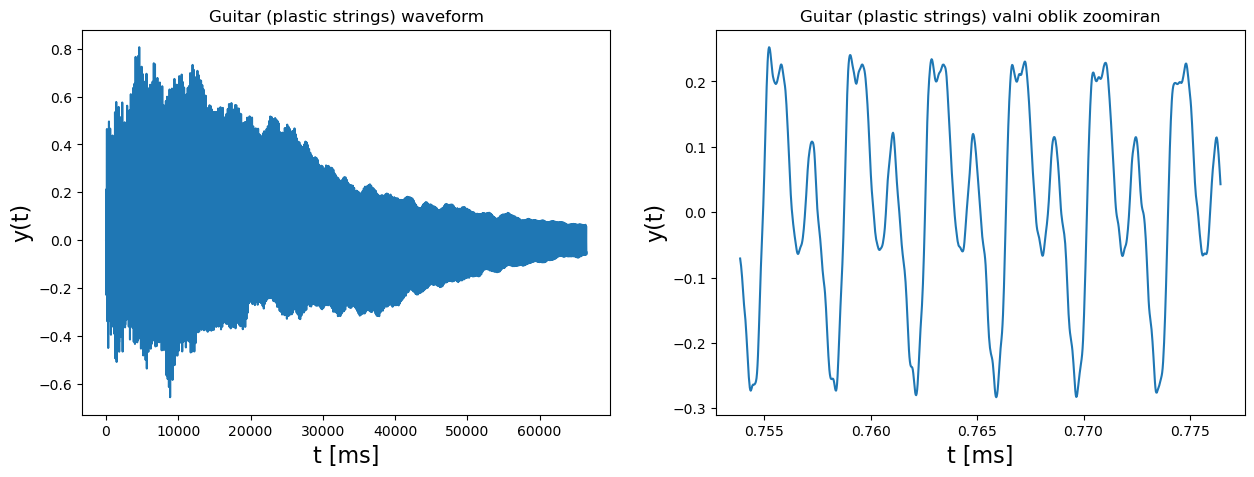

In [15]:
plotWaveformPortion(sounds, [0.015], files, "Guitar (plastic strings)")

# Extract one period

Original


Extracted period


3.8200000000000456
Frequency: 261.7801047120388


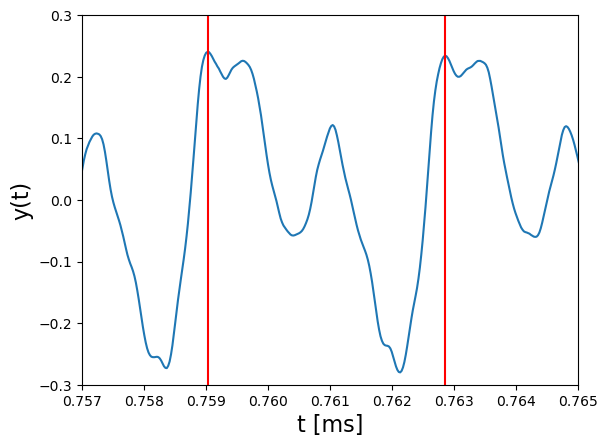

In [16]:
periods = []
rates = []

name = "piano"

# The manually found start and end time of one period of the signal
#periodBounds = [(0.8284,0.83604)] # cello
#periodBounds = [(2.09145,2.09334)] # clarinet
#periodBounds = [(0.63845,0.64609)] # double_bass
#periodBounds = [(0.65874,0.66064)] # vocal
#periodBounds = [(0.78051,0.78146)] # flute
#periodBounds = [(0.441767,0.44559)] # guitar nylon
#periodBounds = [(0.54717,0.55097)] # oboe
periodBounds = [(0.75903,0.76285)] # piano
#periodBounds = [(0.69282,0.69377)] # piccolo
#periodBounds = [(1.2636,1.2655)] # sax_alto
#periodBounds = [(2.1363,2.1515)] # sax_baritone
#periodBounds = [(1.51283,1.51472)] # sax_soprano
#periodBounds = [(1.08718,1.09096)] # sax_tenor
#periodBounds = [(0.59473,0.59853)] # guitar_metal
#periodBounds = [(1.12869,1.130605)] # trumpet
#periodBounds = [(1.28755,1.28945)] # violin
#periodBounds = [(0.54934,0.55316)] # trombone

for n, (S, P) in enumerate(zip(sounds, periodBounds)):
    plt.subplot(len(sounds), 1, n+1)
    period, rate = extractPeriod(S[0], S[1], P[0], P[1])
    periods.append(period); rates.append(rate)
    
    if name == 'cello':
        plt.axis([0.8260, 0.8380, -1, 1]) # cello
        plt.axvline(x=periodBounds[0][0], color = "red") #cello
        plt.axvline(x=periodBounds[0][1], color = "red") #cello
        
    if name == 'clarinet':
        plt.axis([2.088, 2.095, -1, 1])
        plt.axvline(x=periodBounds[0][0], color = "red")
        plt.axvline(x=periodBounds[0][1], color = "red")
        
    if name == 'double_bass':
        plt.axis([0.6370,0.6480 , -1, 1])
        plt.axvline(x=periodBounds[0][0], color = "red")
        plt.axvline(x=periodBounds[0][1], color = "red")
        
    if name == 'vocal':
        plt.axis([0.656, 0.666, -1, 1])
        plt.axvline(x=periodBounds[0][0], color = "red")
        plt.axvline(x=periodBounds[0][1], color = "red")
        
    if name == 'flute':
        plt.axis([0.779, 0.7825, -1, 1])
        plt.axvline(x=periodBounds[0][0], color = "red")
        plt.axvline(x=periodBounds[0][1], color = "red")
        
    if name == 'guitar_nylon':
        plt.axis([0.441, 0.447, -0.2, 0.2])
        plt.axvline(x=periodBounds[0][0], color = "red")
        plt.axvline(x=periodBounds[0][1], color = "red")
        
    if name == 'oboe':
        plt.axis([0.546, 0.553, -1.2, 1.2])
        plt.axvline(x=periodBounds[0][0], color = "red")
        plt.axvline(x=periodBounds[0][1], color = "red")
        
    if name == 'piano':
        plt.axis([0.757, 0.765, -0.3, 0.3])
        plt.axvline(x=periodBounds[0][0], color = "red")
        plt.axvline(x=periodBounds[0][1], color = "red")
        
    if name == 'piccolo':
        plt.axis([0.6915, 0.6945, -1, 1])
        plt.axvline(x=periodBounds[0][0], color = "red")
        plt.axvline(x=periodBounds[0][1], color = "red")
        
    if name == 'sax_alto':
        plt.axis([1.2625, 1.2665, -1, 1])
        plt.axvline(x=periodBounds[0][0], color = "red")
        plt.axvline(x=periodBounds[0][1], color = "red")
        
    if name == 'sax_baritone':
        plt.axis([2.130, 2.160, -1, 1])
        plt.axvline(x=periodBounds[0][0], color = "red")
        plt.axvline(x=periodBounds[0][1], color = "red")
        
    if name == 'sax_soprano':
        plt.axis([1.510, 1.520, -1, 1])
        plt.axvline(x=periodBounds[0][0], color = "red")
        plt.axvline(x=periodBounds[0][1], color = "red")
        
    if name == 'sax_tenor':
        plt.axis([1.084, 1.093, -1, 1])
        plt.axvline(x=periodBounds[0][0], color = "red")
        plt.axvline(x=periodBounds[0][1], color = "red")
        
    if name == 'guitar_metal':
        plt.axis([0.593, 0.601, -0.3, 0.3])
        plt.axvline(x=periodBounds[0][0], color = "red")
        plt.axvline(x=periodBounds[0][1], color = "red")
        
    if name == 'trumpet':
        plt.axis([1.1275, 1.1315, -1, 1])
        plt.axvline(x=periodBounds[0][0], color = "red")
        plt.axvline(x=periodBounds[0][1], color = "red")
        
    if name == 'violin':
        plt.axis([1.286, 1.291, -1, 1])
        plt.axvline(x=periodBounds[0][0], color = "red")
        plt.axvline(x=periodBounds[0][1], color = "red")
        
    if name == 'trombone':
        plt.axis([0.547, 0.557, -1, 1])
        plt.axvline(x=periodBounds[0][0], color = "red")
        plt.axvline(x=periodBounds[0][1], color = "red")
    
    plt.xlabel('t [ms]', fontsize=16)
    plt.ylabel('y(t)', fontsize=16)
    
plt.savefig("../results/analysed/" + name + "_period.pdf")

note_period = (periodBounds[0][1] - periodBounds[0][0])*1000
print(note_period)
print("Frequency: " + str(1/note_period*1000))

# Reconstruct the sound up to N harmonics

0.016 + 0.055*cos(2*pi*1*t/3.8200000000000456) + 0.139*sin(2*pi*1*t/3.8200000000000456)
 + 0.111*cos(2*pi*2*t/3.8200000000000456) + 0.107*sin(2*pi*2*t/3.8200000000000456)
 + 0.004*cos(2*pi*3*t/3.8200000000000456) + -0.027*sin(2*pi*3*t/3.8200000000000456)
 + 0.029*cos(2*pi*4*t/3.8200000000000456) + -0.020*sin(2*pi*4*t/3.8200000000000456)
 + 0.007*cos(2*pi*5*t/3.8200000000000456) + -0.015*sin(2*pi*5*t/3.8200000000000456)
 + 0.013*cos(2*pi*6*t/3.8200000000000456) + -0.000*sin(2*pi*6*t/3.8200000000000456)
 + -0.000*cos(2*pi*7*t/3.8200000000000456) + -0.005*sin(2*pi*7*t/3.8200000000000456)
 + 0.001*cos(2*pi*8*t/3.8200000000000456) + -0.000*sin(2*pi*8*t/3.8200000000000456)
 + 0.004*cos(2*pi*9*t/3.8200000000000456) + -0.003*sin(2*pi*9*t/3.8200000000000456)
 + -0.001*cos(2*pi*10*t/3.8200000000000456) + -0.004*sin(2*pi*10*t/3.8200000000000456)
 + -0.003*cos(2*pi*11*t/3.8200000000000456) + 0.000*sin(2*pi*11*t/3.8200000000000456)
 + -0.004*cos(2*pi*12*t/3.8200000000000456) + 0.004*sin(2*pi*12*t/3

/var/folders/f8/6q1gnbqs3qbchtcy2s4kpllh0000gn/T/ipykernel_41958/516348487.py:35: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)             #inače zakomentirano


Reconstructed up to 15 harmonics


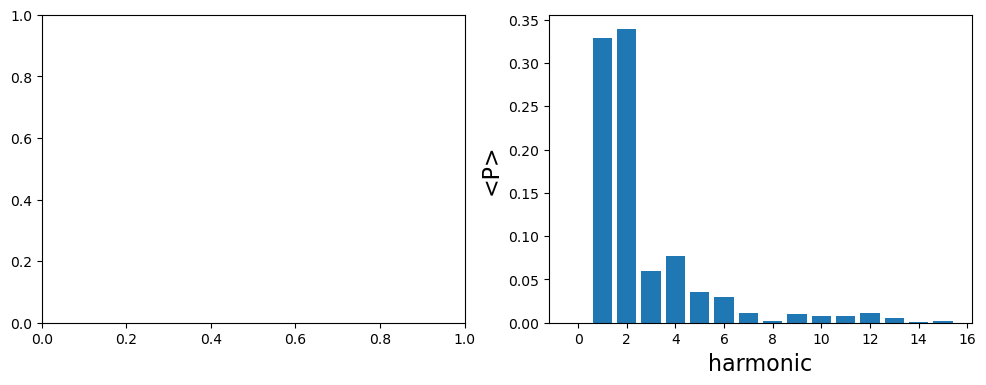

In [17]:
for P, R in zip(periods, rates):
    F, functions, powers = approximateUpToNthHarmonic(P, R, 15, note_period, "guitar_nylon") #returns coefficients of Fourier series and functions and makes plots


### Draw individual harmonics and write their function

y(t) = 0.139*sin(0.52356020942407752*pi*t) + 0.055*cos(0.52356020942407752*pi*t) + 0.016
y(t) = 0.139 \sin{\left(0.52356020942407752 \pi t \right)} + 0.055 \cos{\left(0.52356020942407752 \pi t \right)} + 0.016


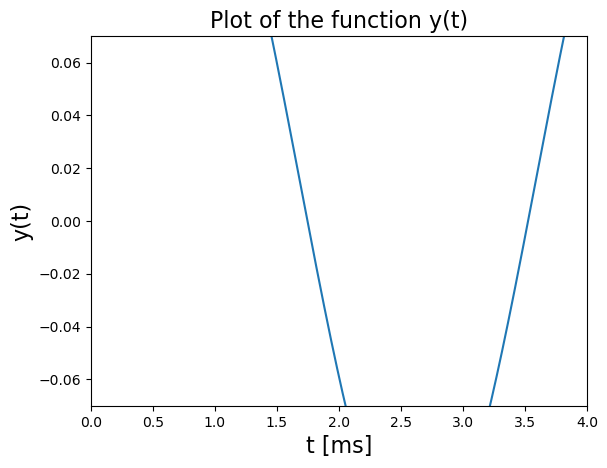

y(t) = 0.107*sin(1.047120418848155*pi*t) + 0.111*cos(1.047120418848155*pi*t)
y(t) = 0.107 \sin{\left(1.047120418848155 \pi t \right)} + 0.111 \cos{\left(1.047120418848155 \pi t \right)}


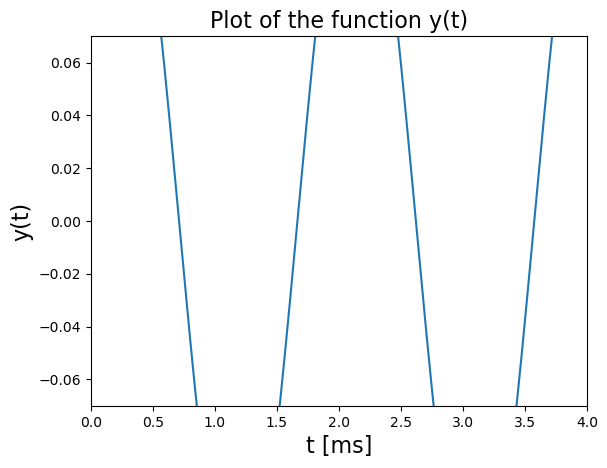

y(t) = -0.027*sin(1.5706806282722326*pi*t) + 0.004*cos(1.5706806282722326*pi*t)
y(t) = - 0.027 \sin{\left(1.5706806282722326 \pi t \right)} + 0.004 \cos{\left(1.5706806282722326 \pi t \right)}


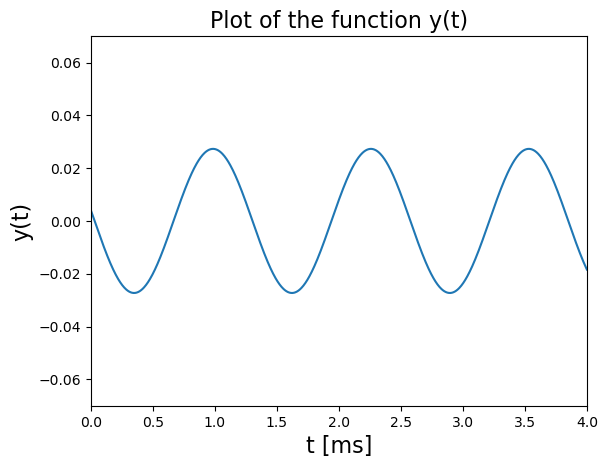

y(t) = -0.02*sin(2.0942408376963101*pi*t) + 0.029*cos(2.0942408376963101*pi*t)
y(t) = - 0.02 \sin{\left(2.0942408376963101 \pi t \right)} + 0.029 \cos{\left(2.0942408376963101 \pi t \right)}


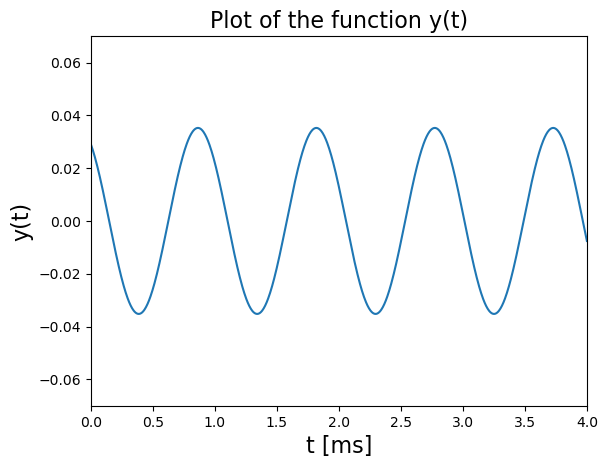

y(t) = -0.015*sin(2.6178010471203876*pi*t) + 0.007*cos(2.6178010471203876*pi*t)
y(t) = - 0.015 \sin{\left(2.6178010471203876 \pi t \right)} + 0.007 \cos{\left(2.6178010471203876 \pi t \right)}


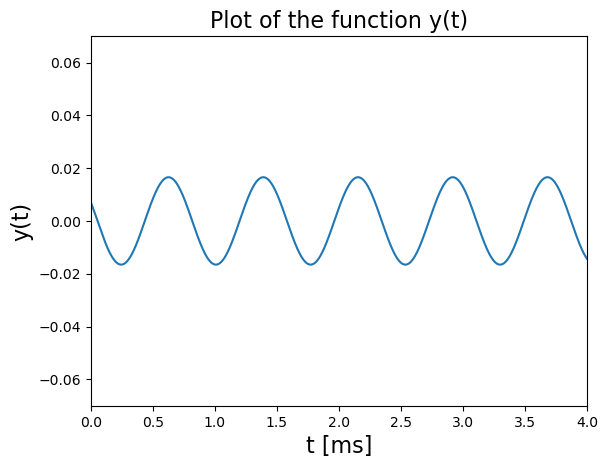

y(t) = 0.013*cos(3.1413612565444651*pi*t)
y(t) = 0.013 \cos{\left(3.1413612565444651 \pi t \right)}


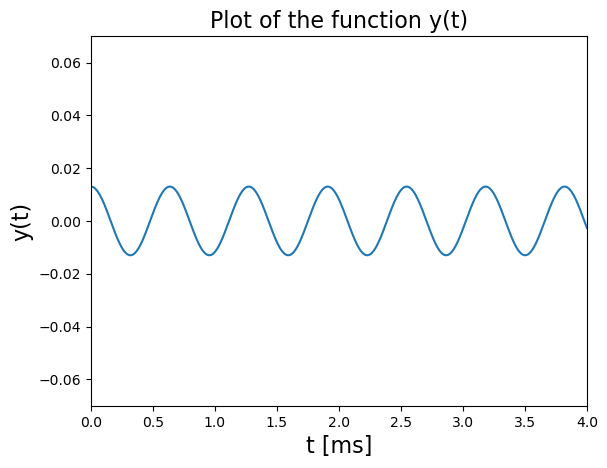

y(t) = -0.005*sin(3.6649214659685426*pi*t)
y(t) = - 0.005 \sin{\left(3.6649214659685426 \pi t \right)}


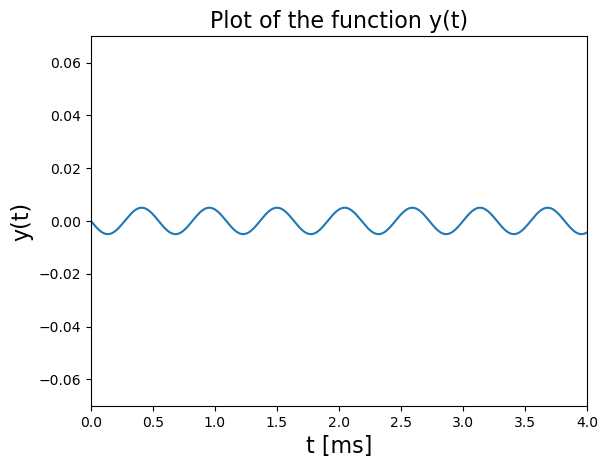

y(t) = 0.001*cos(4.1884816753926202*pi*t)
y(t) = 0.001 \cos{\left(4.1884816753926202 \pi t \right)}


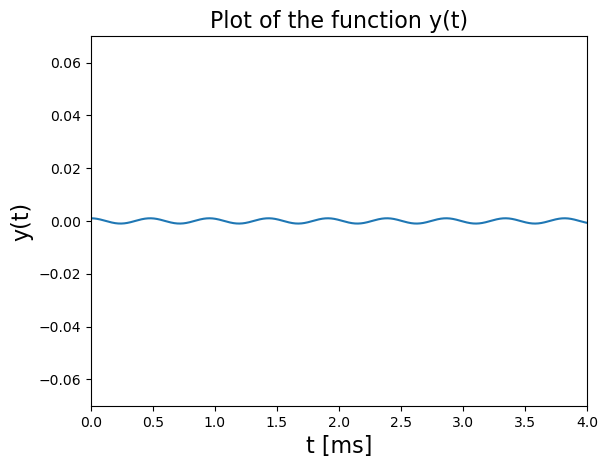

y(t) = -0.003*sin(4.7120418848166977*pi*t) + 0.004*cos(4.7120418848166977*pi*t)
y(t) = - 0.003 \sin{\left(4.7120418848166977 \pi t \right)} + 0.004 \cos{\left(4.7120418848166977 \pi t \right)}


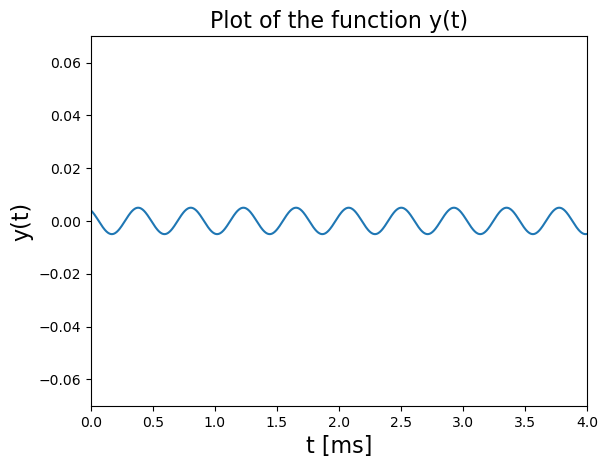

y(t) = -0.004*sin(5.2356020942407752*pi*t) - 0.001*cos(5.2356020942407752*pi*t)
y(t) = - 0.004 \sin{\left(5.2356020942407752 \pi t \right)} - 0.001 \cos{\left(5.2356020942407752 \pi t \right)}


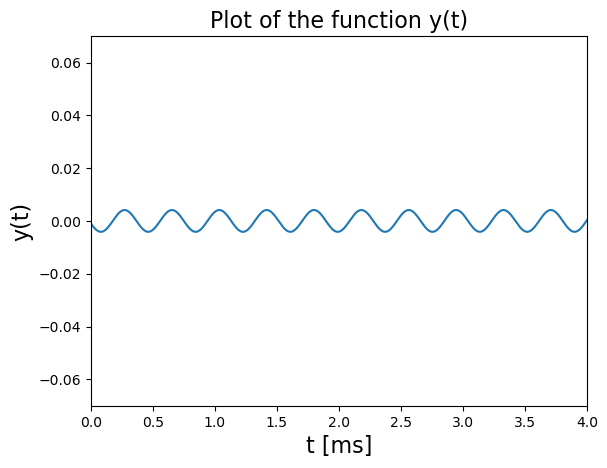

y(t) = -0.003*cos(5.7591623036648527*pi*t)
y(t) = - 0.003 \cos{\left(5.7591623036648527 \pi t \right)}


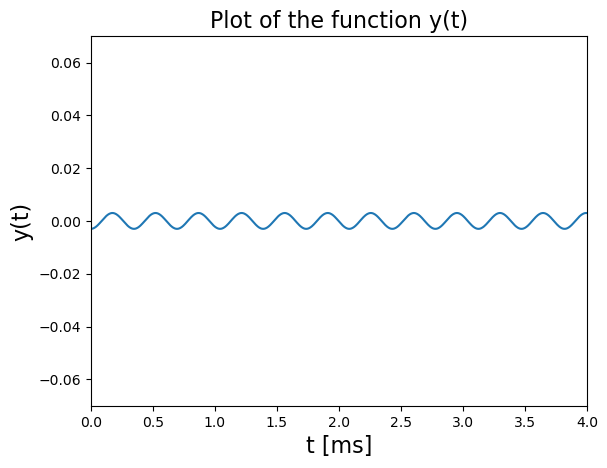

y(t) = 0.004*sin(6.2827225130889302*pi*t) - 0.004*cos(6.2827225130889302*pi*t)
y(t) = 0.004 \sin{\left(6.2827225130889302 \pi t \right)} - 0.004 \cos{\left(6.2827225130889302 \pi t \right)}


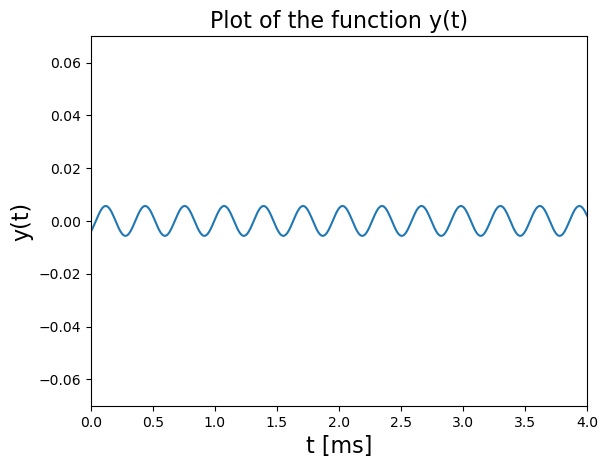

y(t) = 0.001*sin(6.8062827225130078*pi*t) + 0.002*cos(6.8062827225130078*pi*t)
y(t) = 0.001 \sin{\left(6.8062827225130078 \pi t \right)} + 0.002 \cos{\left(6.8062827225130078 \pi t \right)}


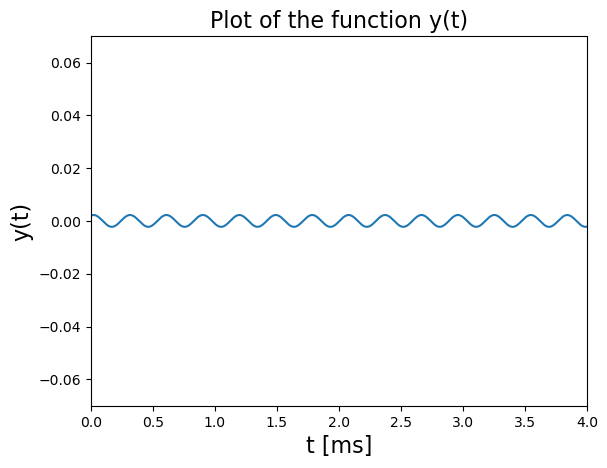

y(t) = -0.001*cos(7.3298429319370853*pi*t)
y(t) = - 0.001 \cos{\left(7.3298429319370853 \pi t \right)}


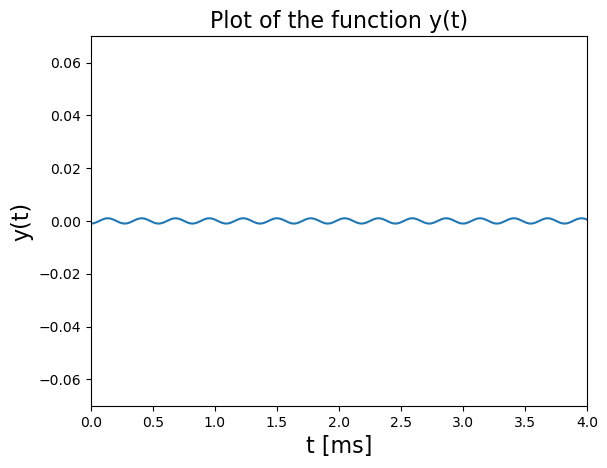

y(t) = 0.001*cos(7.8534031413611628*pi*t)
y(t) = 0.001 \cos{\left(7.8534031413611628 \pi t \right)}


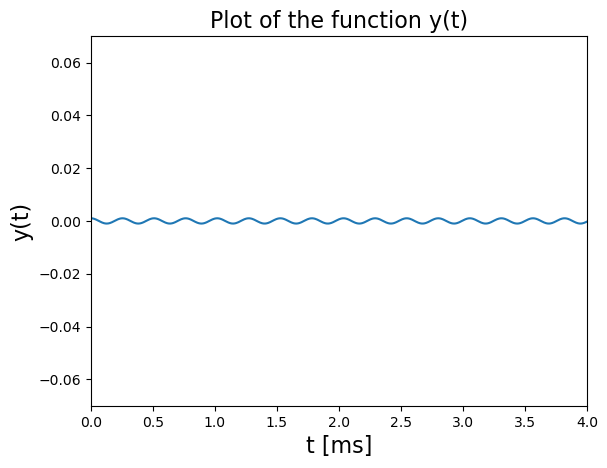

In [18]:
#draw_harmonics(functions, 0, 8, -1, 0.5, "cello", limit_N = 30)
#draw_harmonics(functions, 0, 10, -0.8, 0.8, "clarinet", limit_N = 10)
#draw_harmonics(functions, 0, 10, -1, 0.7, "double_bass", limit_N = 30)
#draw_harmonics(functions, 0, 20, -1, 1, "vocal", limit_N = 20)
#draw_harmonics(functions, 0, 20, -0.8, 0.8, "flute", limit_N = 10)
draw_harmonics(functions, 0, 4, -0.07, 0.07, "guitar_nylon", limit_N = 20)
#draw_harmonics(functions, 0, 20, -0.6, 0.6, "oboe", limit_N = 20)
#draw_harmonics(functions, 0, 20, -0.4, 0.4, "piano", limit_N = 20)
#draw_harmonics(functions, 0, 20, -0.8, 0.8, "piccolo", limit_N = 10)
#draw_harmonics(functions, 0, 20, -0.8, 0.8, "sax_alto", limit_N = 10)
#draw_harmonics(functions, 0, 20, -0.8, 0.8, "sax_baritone", limit_N = 35)
#draw_harmonics(functions, 0, 20, -0.8, 0.8, "sax_soprano", limit_N = 10)
#draw_harmonics(functions, 0, 20, -0.8, 0.8, "sax_tenor", limit_N = 18)
#draw_harmonics(functions, 0, 20, -0.1, 0.1, "guitar_metal", limit_N = 20)
#draw_harmonics(functions, 0, 20, -0.35, 0.35, "trumpet", limit_N = 15)
#draw_harmonics(functions, 0, 20, -0.9, 0.9, "violin", limit_N = 15)
#draw_harmonics(functions, 0, 20, -0.8, 0.8, "trombone", limit_N = 20)

### Find harmonics in sound and their relative power using librosa

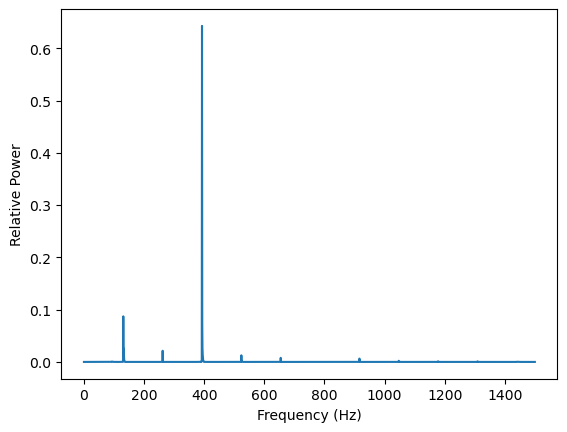

In [20]:
# Load the waveform from a wav file
#waveform, sample_rate = librosa.load('./instrument_samples/cello-c3_16bit.WAV')
waveform, sample_rate = librosa.load('../data/instrument_samples/clarinet-c5_16_bit.WAV')
waveform, sample_rate = librosa.load('../data/instrument_samples/double-bass-c3_16_bit.WAV')

# Compute the power spectrum of the waveform
power_spectrum = np.abs(np.fft.rfft(waveform))**2

# Determine the harmonic frequencies and their relative power
harmonic_frequencies = np.fft.rfftfreq(waveform.size, d=1/sample_rate)
harmonic_powers = power_spectrum / np.sum(power_spectrum)

# Select only frequencies with relative power > 0.001
#harmonics = harmonic_frequencies[harmonic_powers > 0.001]
#powers = harmonic_powers[harmonic_powers > 0.001]
harmonics = harmonic_frequencies[harmonic_frequencies < 1500]
powers_librosa = harmonic_powers[harmonic_frequencies < 1500]

# Plot the power spectrum
plt.plot(harmonics, powers_librosa)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Relative Power')
plt.show()

In [21]:
df = pd.DataFrame({'frequency': harmonics, 'powers': powers_librosa})
df["harmonic"] = df['frequency']/(1/note_period*1000)
df['harmonic'] = df['harmonic'].astype(int)

In [22]:
df = df.sort_values('powers', ascending=False)
df.head(20)

frequency    powers  harmonic
498    392.679874  0.642820         1
166    130.893291  0.087175         0
499    393.468388  0.073960         1
500    394.256902  0.025546         1
168    132.470319  0.025410         0
332    261.786583  0.021307         1
167    131.681805  0.018303         0
501    395.045416  0.013458         1
664    523.573165  0.012628         2
169    133.258833  0.009785         0
830    654.466457  0.007807         2
502    395.833929  0.007364         1
1162   916.253040  0.006381         3
1163   917.041553  0.002615         3
503    396.622443  0.002583         1
1328  1047.146331  0.002198         4
504    397.410957  0.001983         1
170    134.047347  0.001980         0
665    524.361679  0.001865         2
831    655.254971  0.001781         2

# Generate sound of each harmonic

In [23]:
produce_sound(functions, powers, "sax_baritone", limit_N = 60)